In [221]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import linkage, dendrogram
from collections import Counter

%matplotlib inline

In [222]:
df = pd.read_csv('kl.csv', encoding='ISO-8859-1')
df.head()

Unnamed: 0      ID               Name   Age  \
0           0  158023           L. Messi  31.0   
1           1   20801  Cristiano Ronaldo  33.0   
2           2  190871          Neymar Jr  26.0   
3           3  193080             De Gea  27.0   
4           4  192985       K. De Bruyne  27.0   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/52.png     94.0         94   
1  https://cdn.sofifa.org/flags/38.png     94.0         94   
2  https://cdn.sofifa.org/flags/54.png     92.0         93   
3  https://cdn.sofifa.org/flags/45.png     91.0         93   
4   https://cdn.sofifa.org/flags/7.png     91.0         92   

                  Club  ... Composure Marking StandingTackle  SlidingTackle  \
0         FC Barcelona  ...      96.0    33.0           28.0           26.0   
1             Juventus  ...      95.0    28.0           31.0           23.0   
2  Paris Saint-Germain  ...      94.0    27.0           24.0           33.0   
3    Manchester United  ...      68.0    15.0           21.0           13.0   
4      Manchester City  ...      88.0    68.0           58.0           51.0   

  GKDiving  GKHandling  GKKicking  GKPositioning GKReflexes Release Clause  
0      6.0        11.0       15.0           14.0        8.0        226.5M  
1      7.0        11.0       15.0           14.0       11.0        127.1M  
2      9.0         9.0       15.0           15.0       11.0        228.1M  
3     90.0        85.0       87.0           88.0       94.0        138.6M  
4     15.0        13.0        5.0           10.0       13.0        196.4M  

[5 rows x 89 columns]

In [223]:
df.shape

(18207, 89)

In [224]:
df.isnull().mean()

Unnamed: 0        0.000000
ID                0.000000
Name              0.000000
Age               0.000055
Photo             0.000000
                    ...   
GKHandling        0.002636
GKKicking         0.002636
GKPositioning     0.002636
GKReflexes        0.002636
Release Clause    0.085901
Length: 89, dtype: float64

<AxesSubplot:>

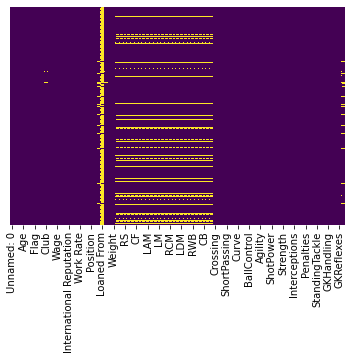

In [225]:
sns.heatmap(df.isna(), cmap='viridis', yticklabels=False, cbar=None)

In [226]:
def missing_values_boundry(df, missing_percentige):
    
    columns_with_missing_values_above_border = []
    series = df.isna().mean()
    for index in series.index:
        if series[index] > missing_percentige:
            columns_with_missing_values_above_border.append(index)
    return columns_with_missing_values_above_border
        
missing_values_boundry(df, 0.3)

['Loaned From']

In [227]:
df['Loaned From'].isna().mean()

0.9305761520294392

In [228]:
df.drop('Loaned From', axis=1, inplace=True)

In [229]:
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Contract Valid Until', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDivi

In [230]:
df['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB', nan], dtype=object)

In [231]:
# podela promenljivih na numericke i kategoricke

numeric = []
categorical = []
for column in df.columns:
    if str(df[column].dtype) == 'object':
        categorical.append(column)
    else:
        numeric.append(column)
        
numeric.remove('ID')
numeric.remove('Unnamed: 0')

len(numeric) + len(categorical)
print('Broj kategorickih promenljivih:', len(categorical))
print('Broj numerickih promenljivih:', len(numeric))

Broj kategorickih promenljivih: 44
Broj numerickih promenljivih: 42


In [232]:
# zamena NaN vrednosti zeljenim metodom (mean, mode, median ili random sample imputation-om)

def impute_value(df, variable, method='random sample'):

    if method == 'mean':
        df[variable].fillna(df[variable].mean(), inplace=True)
    elif method == 'mode':
        df[variable].fillna(df[variable].mode()[0], inplace=True)
    elif method == 'median':
        df[variable + '_median'] = df[variable].fillna(df[variable].median())
    else:
        df[variable + '_random_sample'] = df[variable]
        random_sample = df[variable].dropna().sample(df[variable].isna().sum(), random_state=0)
        random_sample.index = df.loc[df[variable].isna()].index
        df.loc[df[variable].isna(), variable] = random_sample

In [233]:
def find_irq_outliers(values):
    
    outliers = []
    sorted_values = sorted(values)
    min, max = np.percentile(sorted_values, [25, 75])
    irq_difference = max - min
    upper_border = max + 1.5 * irq_difference
    lower_border = min - 1.5 * irq_difference

    for value in sorted_values:
        if value < lower_border or value > upper_border:
            outliers.append(value)
    return outliers
        
outlier_numeric_columns = []
for numerical_variable in numeric:
    if len(find_irq_outliers(df[numerical_variable])):
        outlier_numeric_columns.append(numerical_variable)

outlier_numeric_columns

['Potential', 'Special']

In [234]:
for variable in numeric:
    if variable in outlier_numeric_columns:
        impute_value(df, variable, 'median')
        impute_value(df, variable)
        standard_deviation_old_values = df[variable].std()
        standard_deviation_median_values = df[variable + '_median'].std()
        standard_deviation_random_sample = df[variable + '_random_sample'].std()
        if abs(standard_deviation_median_values - standard_deviation_old_values) < abs(standard_deviation_random_sample - standard_deviation_old_values):
            df[variable] = df[variable + '_median']
        else:
            df[variable] = df[variable + '_random_sample']
        df.drop(columns=[variable + '_random_sample', variable + '_median'], inplace=True)

    else:
        impute_value(df, variable, 'mean')

In [235]:
for categorical_variable in categorical:
    impute_value(df, categorical_variable, 'mode')
sum(df[categorical].isna().sum().values)

0

In [236]:
sum(df[numeric].isna().sum().values)

0

<AxesSubplot:>

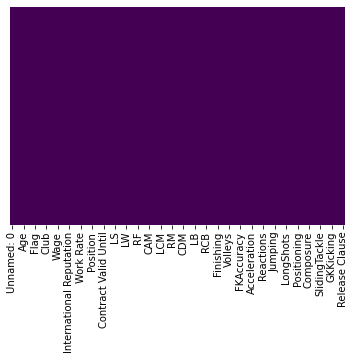

In [237]:
sns.heatmap(df.isna(), cmap='viridis', yticklabels=False, cbar=None)

In [238]:
# Funkcija koja vrsi skaliranje promenljivih zeljenom metodom

def feature_scaling(df, features, method):
    
    for feature in features:
        scaled_feature = method.fit_transform(df[[feature]])
        df[feature] = scaled_feature
        
feature_scaling(df, numeric, MinMaxScaler())

df[numeric].head()

Age   Overall  Potential   Special  International Reputation  \
0  0.517241  1.000000   0.978723  0.910836                      1.00   
1  0.586207  1.000000   0.978723  0.926935                      1.00   
2  0.344828  0.958333   0.957447  0.874303                      1.00   
3  0.379310  0.937500   0.957447  0.458204                      0.75   
4  0.379310  0.937500   0.936170  0.959752                      0.75   

   Weak Foot  Skill Moves  Jersey Number  Crossing  Finishing  ...  Penalties  \
0       0.75         0.75       0.091837  0.897727   1.000000  ...   0.804598   
1       0.75         1.00       0.061224  0.897727   0.989247  ...   0.919540   
2       1.00         1.00       0.091837  0.840909   0.913978  ...   0.873563   
3       0.50         0.00       0.000000  0.136364   0.118280  ...   0.402299   
4       1.00         0.75       0.061224  1.000000   0.860215  ...   0.850575   

   Composure   Marking  StandingTackle  SlidingTackle  GKDiving  GKHandling  \
0   1.000000  0.329670        0.285714       0.261364  0.056180    0.109890   
1   0.989247  0.274725        0.318681       0.227273  0.067416    0.109890   
2   0.978495  0.263736        0.241758       0.340909  0.089888    0.087912   
3   0.698925  0.131868        0.208791       0.113636  1.000000    0.923077   
4   0.913978  0.714286        0.615385       0.545455  0.157303    0.131868   

   GKKicking  GKPositioning  GKReflexes  
0   0.155556       0.146067    0.075269  
1   0.155556       0.146067    0.107527  
2   0.155556       0.157303    0.107527  
3   0.955556       0.977528    1.000000  
4   0.044444       0.101124    0.129032  

[5 rows x 42 columns]

In [239]:
df['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

**Golman** - GK

**Odbrana** - RWB, RB, RCB, CB, LCB, LB, LWB

**Vezni red** - RDM, CDM, LDM, RM, RCM, CM, LCM, LM, RAM, CAM, LAM

**Napad** - RF, CF, LF, RS, ST, LS, LW, RW

In [240]:
def show_position_percentige_per_cluster(df, cluster_number, original_dataset_length):
    
    number_of_players_in_cluster = len(df)
    print(f'Broj igraca u klasteru {cluster_number}: {number_of_players_in_cluster}, ({(number_of_players_in_cluster / original_dataset_length) * 100} %)' )
    print()

    # Napad
    
    df_num_of_attackers = len(df.loc[(df['Position'] == 'RF') | (df['Position'] == 'LF') | (df['Position'] == 'RW') | (df['Position'] == 'LW') | (df['Position'] == 'ST') | (df['Position'] =='CF') |  (df['Position'] == 'RS') | (df['Position'] == 'LS')])
    df_num_of_attackers_percentige = (df_num_of_attackers / number_of_players_in_cluster) * 100

    print(f'NAPAD: {df_num_of_attackers} ({df_num_of_attackers_percentige} %)')
    rf_number = len(df.loc[df['Position'] == 'RF'])
    rf_percentige = (rf_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RF:', f'{rf_number}, ({rf_percentige} %)')
    lf_number = len(df.loc[df['Position'] == 'LF'])
    lf_percentige = (lf_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LF:', f'{lf_number}, ({lf_percentige} %)')
    rw_number = len(df.loc[df['Position'] == 'RW'])
    rw_percentige = (rw_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RW:', f'{rw_number}, ({rw_percentige} %)')
    lw_number = len(df.loc[df['Position'] == 'LW'])
    lw_percentige = (lw_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LW:', f'{lw_number}, ({lw_percentige} %)')
    st_number = len(df.loc[df['Position'] == 'ST'])
    st_percentige = (st_number / number_of_players_in_cluster ) * 100
    print('Broj igraca na poziciji ST:', f'{st_number}, ({st_percentige} %)')
    cf_number = len(df.loc[df['Position'] == 'CF'])
    cf_percentige = (cf_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji CF:', f'{cf_number}, ({cf_percentige} %)')
    rs_number = len(df.loc[df['Position'] == 'RS'])
    rs_percentige = (rs_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RS:', f'{rs_number}, ({rs_percentige} %)')
    ls_number = len(df.loc[df['Position'] == 'LS'])
    ls_percentige = (ls_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LS:', f'{ls_number}, ({ls_percentige} %)')
    print()

    # Vezni red

    df_num_of_mid = len(df.loc[(df['Position'] == 'RDM') | (df['Position'] == 'CDM') | (df['Position'] == 'LDM') | (df['Position'] == 'RM') | (df['Position'] == 'RCM') | (df['Position'] == 'CM') | (df['Position'] == 'LCM') | (df['Position'] == 'LM') | (df['Position'] == 'RAM') | (df['Position'] == 'CAM') | (df['Position'] =='LAM')])
    df_num_of_mid_percentige = (df_num_of_mid / number_of_players_in_cluster) * 100

    print(f'VEZNI RED: {df_num_of_mid} ({df_num_of_mid_percentige} %)')
    rdm_number = len(df.loc[df['Position'] == 'RDM'])
    rdm_percentige = (rdm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RDM:', f'{rdm_number}, ({rdm_percentige} %)')
    cdm_number = len(df.loc[df['Position'] == 'CDM'])
    cdm_percentige = (cdm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji CDM:', f'{cdm_number}, ({cdm_percentige} %)')
    ldm_number = len(df.loc[df['Position'] == 'LDM'])
    ldm_percentige = (ldm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LDM:', f'{ldm_number}, ({ldm_percentige} %)')
    rm_number = len(df.loc[df['Position'] == 'RM'])
    rm_percentige = (rm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RM:', f'{rm_number}, ({rm_percentige} %)')
    rcm_number = len(df.loc[df['Position'] == 'RCM'])
    rcm_percentige = (rcm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RCM:', f'{rcm_number}, ({rcm_percentige} %)')
    cm_number = len(df.loc[df['Position'] == 'CM'])
    cm_percentige = (cm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji CM:', f'{cm_number}, ({cm_percentige} %)')
    lcm_number = len(df.loc[df['Position'] == 'LCM'])
    lcm_percentige = (lcm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LCM:', f'{lcm_number}, ({lcm_percentige} %)')
    lm_number = len(df.loc[df['Position'] == 'LM'])
    lm_percentige = (lm_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LM:', f'{lm_number}, ({lm_percentige} %)')
    ram_number = len(df.loc[df['Position'] == 'RAM'])
    ram_percentige = (ram_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RAM:', f'{ram_number}, ({ram_percentige} %)')
    cam_number = len(df.loc[df['Position'] == 'CAM'])
    cam_percentige = (cam_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji CAM:', f'{cam_number}, ({cam_percentige} %)')
    lam_number = len(df.loc[df['Position'] == 'LAM'])
    lam_percentige = (lam_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LAM:', f'{lam_number}, ({lam_percentige} %)')
    print()

    # Odbrana

    df_num_of_dif = len(df.loc[(df['Position'] == 'RWB') | (df['Position'] == 'RB') | (df['Position'] == 'RCB') | (df['Position'] == 'CB') | (df['Position'] == 'LCB') | (df['Position'] == 'LB') | (df['Position'] == 'LWB')])
    df_num_of_dif_percentige = (df_num_of_dif / number_of_players_in_cluster) * 100

    print(f'ODBRANA: {df_num_of_dif} ({df_num_of_dif_percentige} %)')
    rwb_number = len(df.loc[df['Position'] == 'RWB'])
    rwb_percentige = (rwb_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RWB:', f'{rwb_number}, ({rwb_percentige} %)')
    rb_number = len(df.loc[df['Position'] == 'RB'])
    rb_percentige = (rb_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RB:', f'{rb_number}, ({rb_percentige} %)')
    rcb_number = len(df.loc[df['Position'] == 'RCB'])
    rcb_percentige = (rcb_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji RCB:', f'{rcb_number}, ({rcb_percentige} %)')
    cb_number = len(df.loc[df['Position'] == 'CB'])
    cb_percentige = (cb_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji CB:', f'{cb_number}, ({cb_percentige} %)')
    lcb_number = len(df.loc[df['Position'] == 'LCB'])
    lcb_percentige = (lcb_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LCB:', f'{lcb_number}, ({lcb_percentige} %)')
    lb_number = len(df.loc[df['Position'] == 'LB'])
    lb_percentige = (lb_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LB:', f'{lb_number}, ({lb_percentige} %)')
    lwb_number = len(df.loc[df['Position'] == 'LWB'])
    lwb_percentige = (lwb_number / number_of_players_in_cluster) * 100
    print('Broj igraca na poziciji LWB:', f'{lwb_number}, ({lwb_percentige} %)')
    print()

    # Golmani

    df_num_of_gk = len(df.loc[df['Position'] == 'GK'])
    df_num_of_gk_percentige = (df_num_of_gk / number_of_players_in_cluster) * 100
    
    print(f'GOLMANI: {df_num_of_gk} ({df_num_of_gk_percentige} %)')
    print()

In [73]:
from collections import Counter

sse = []
silhouette = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df[numeric])
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df[numeric], kmeans.labels_))
    


Text(0, 0.5, 'SSE')

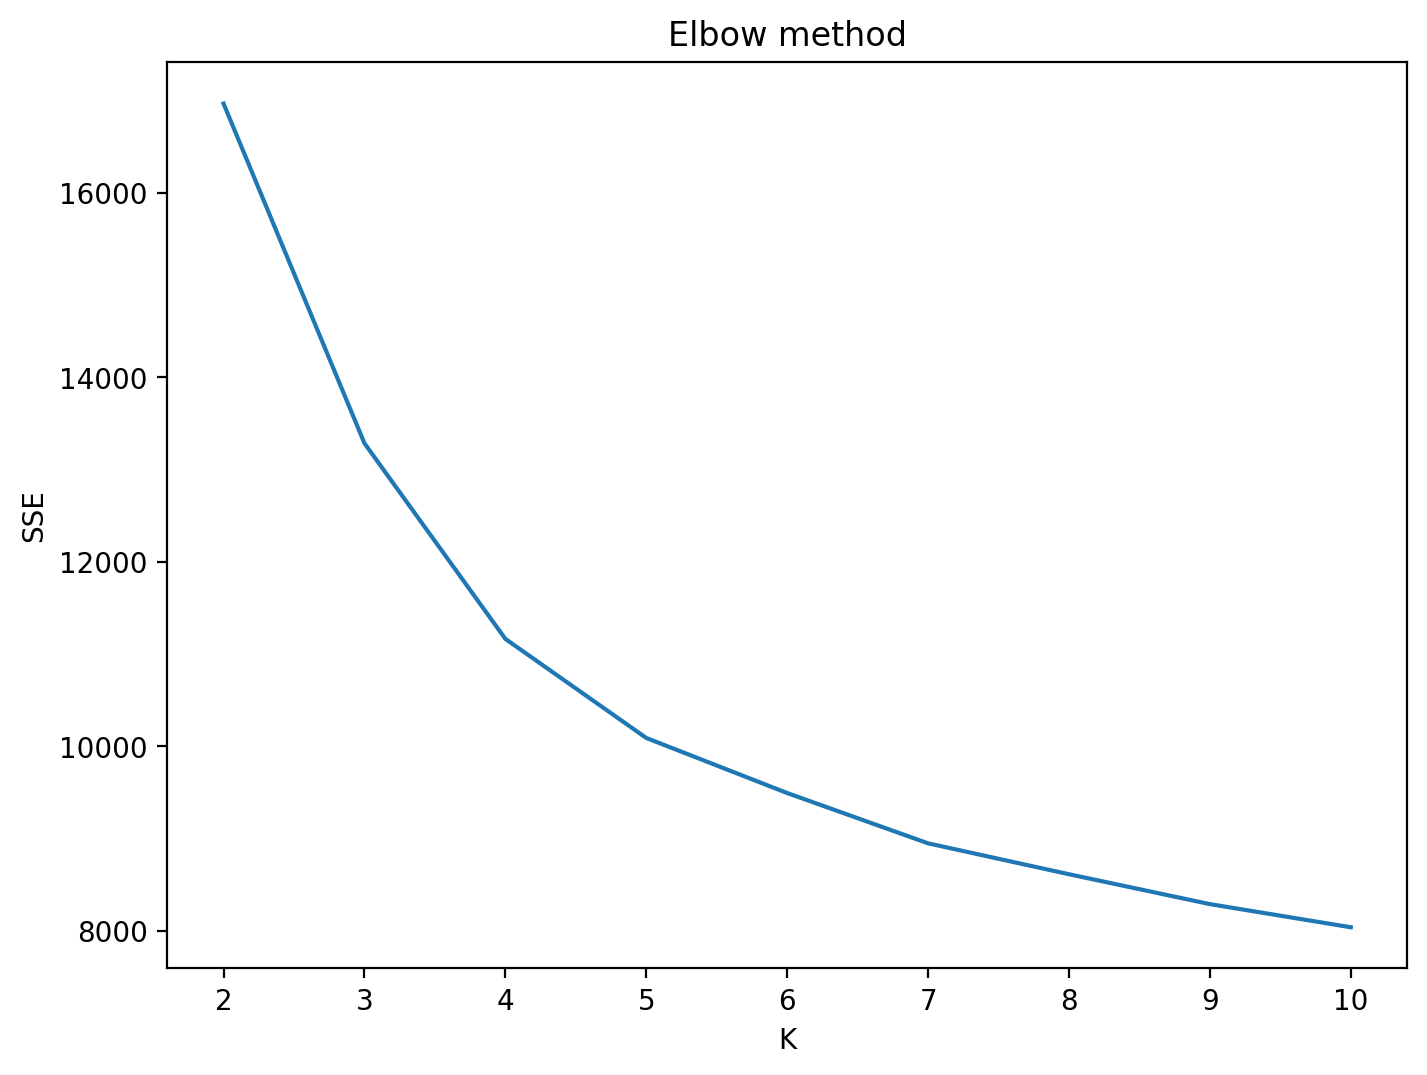

In [74]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
plt.plot(range(2, 11), sse)
plt.title('Elbow method')
plt.xlabel('K')
plt.ylabel('SSE')

In [41]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric])
kmeans.labels_

count = Counter(kmeans.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{4: [4894, 26.87977151644972],
 0: [4626, 25.40781018289669],
 1: [3545, 19.47053331136376],
 3: [3116, 17.114296699071787],
 2: [2026, 11.127588290218048]}

In [42]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4626, (25.40781018289669 %)

NAPAD: 10 (0.21616947686986598 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 10, (0.21616947686986598 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 809 (17.488110678772156 %)
Broj igraca na poziciji RDM: 37, (0.799827064418504 %)
Broj igraca na poziciji CDM: 355, (7.674016428880242 %)
Broj igraca na poziciji LDM: 37, (0.799827064418504 %)
Broj igraca na poziciji RM: 27, (0.5836575875486382 %)
Broj igraca na poziciji RCM: 35, (0.7565931690445309 %)
Broj igraca na poziciji CM: 255, (5.512321660181582 %)
Broj igraca na poziciji LCM: 31, (0.6701253782965845 %)
Broj igraca na poziciji LM: 24, (0.5188067444876783 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 8, (0.17293558149589278 %)
Broj

In [47]:
player = df_cluster_2.loc[df_cluster_2['Position'] == 'ST']
player

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [44]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

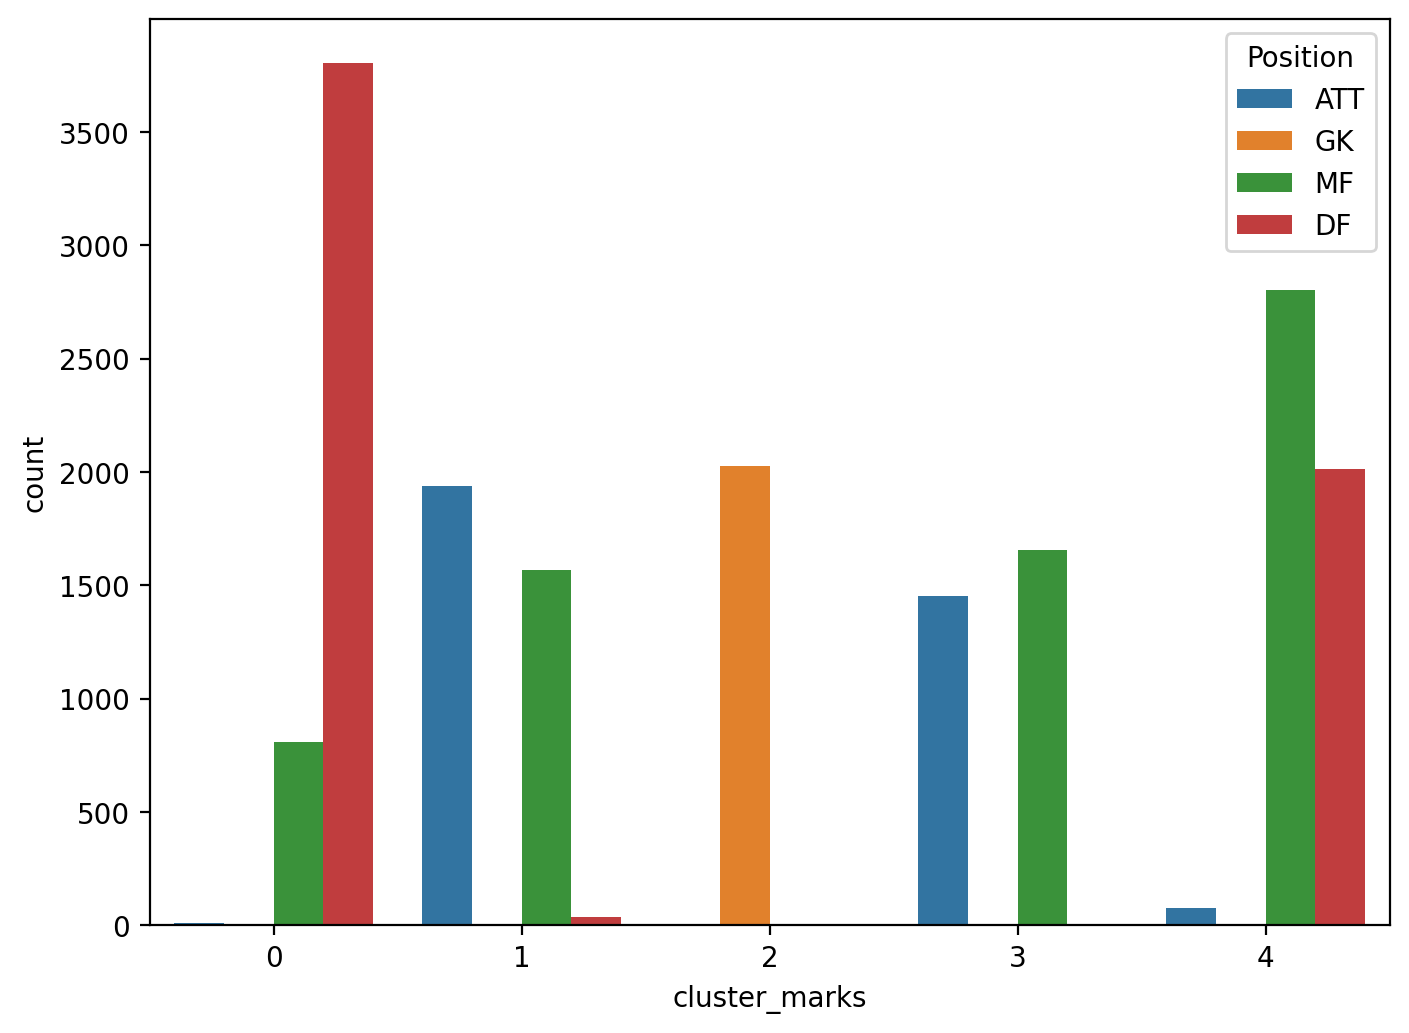

In [45]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

Text(0, 0.5, 'Silhouette score')

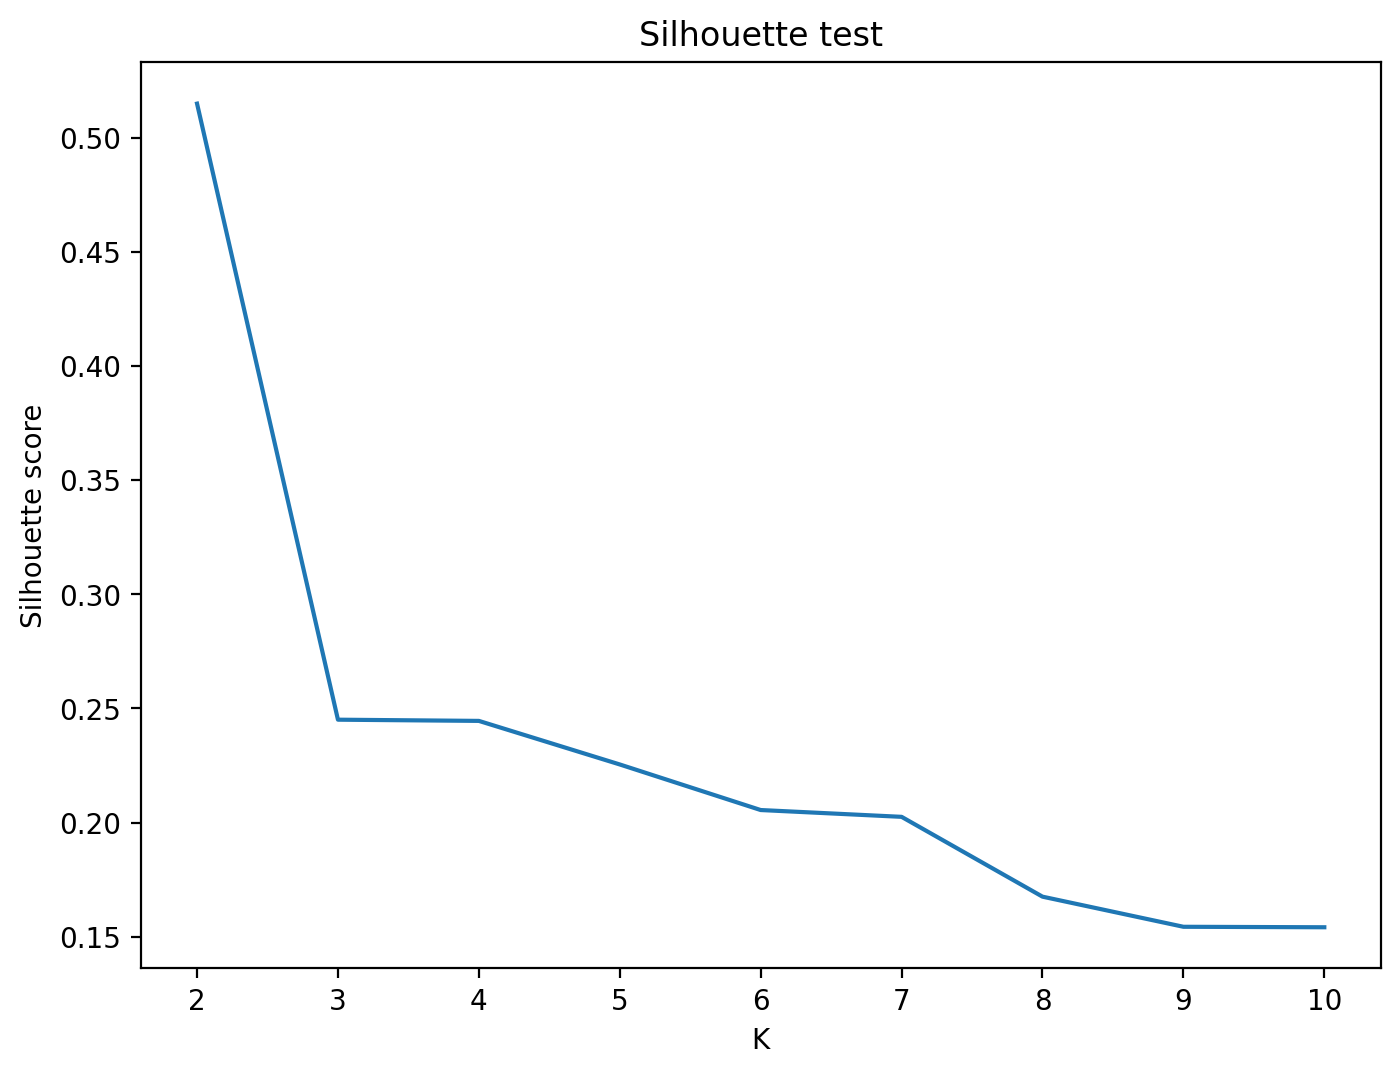

In [80]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
plt.plot(range(2, 11), silhouette)
plt.title('Silhouette test')
plt.xlabel('K')
plt.ylabel('Silhouette score')

In [81]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(df[numeric])
kmeans.labels_

count = Counter(kmeans.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]

number_and_percentige_per_cluster    

{0: [16180, 88.8669193167463], 1: [2027, 11.133080683253693]}

In [82]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))

Broj igraca u klasteru 0: 16180, (88.8669193167463 %)

NAPAD: 3477 (21.489493201483313 %)
Broj igraca na poziciji RF: 16, (0.0988875154511743 %)
Broj igraca na poziciji LF: 15, (0.0927070457354759 %)
Broj igraca na poziciji RW: 370, (2.2867737948084055 %)
Broj igraca na poziciji LW: 381, (2.3547589616810876 %)
Broj igraca na poziciji ST: 2211, (13.665018541409147 %)
Broj igraca na poziciji CF: 74, (0.4573547589616811 %)
Broj igraca na poziciji RS: 203, (1.254635352286774 %)
Broj igraca na poziciji LS: 207, (1.2793572311495673 %)

VEZNI RED: 6838 (42.26205191594561 %)
Broj igraca na poziciji RDM: 248, (1.5327564894932013 %)
Broj igraca na poziciji CDM: 948, (5.859085290482077 %)
Broj igraca na poziciji LDM: 243, (1.5018541409147095 %)
Broj igraca na poziciji RM: 1124, (6.946847960444994 %)
Broj igraca na poziciji RCM: 391, (2.4165636588380717 %)
Broj igraca na poziciji CM: 1394, (8.615574783683561 %)
Broj igraca na poziciji LCM: 395, (2.4412855377008653 %)
Broj igraca na poziciji LM: 10

In [83]:
player = df_cluster_1.loc[df_cluster_1['Position'] == 'ST']
player

Unnamed: 0        ID     Name       Age  \
16450    0.903548  0.786261  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             1  

[1 rows x 89 columns]

In [84]:
player = df_cluster_1.loc[df_cluster_1['Position'] == 'CB']
player

Unnamed: 0        ID        Name       Age  \
17657    0.969845  0.046285  J. McCombe  0.655172   

                                               Photo Nationality  \
17657  https://cdn.sofifa.org/players/4/19/11430.png     England   

                                      Flag   Overall  Potential          Club  \
17657  https://cdn.sofifa.org/flags/14.png  0.145833   0.106383  Lincoln City   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
17657  ...  0.527473       0.538462      0.568182   0.05618   0.142857   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
17657   0.122222        0.11236    0.139785           18K             1  

[1 rows x 89 columns]

In [85]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

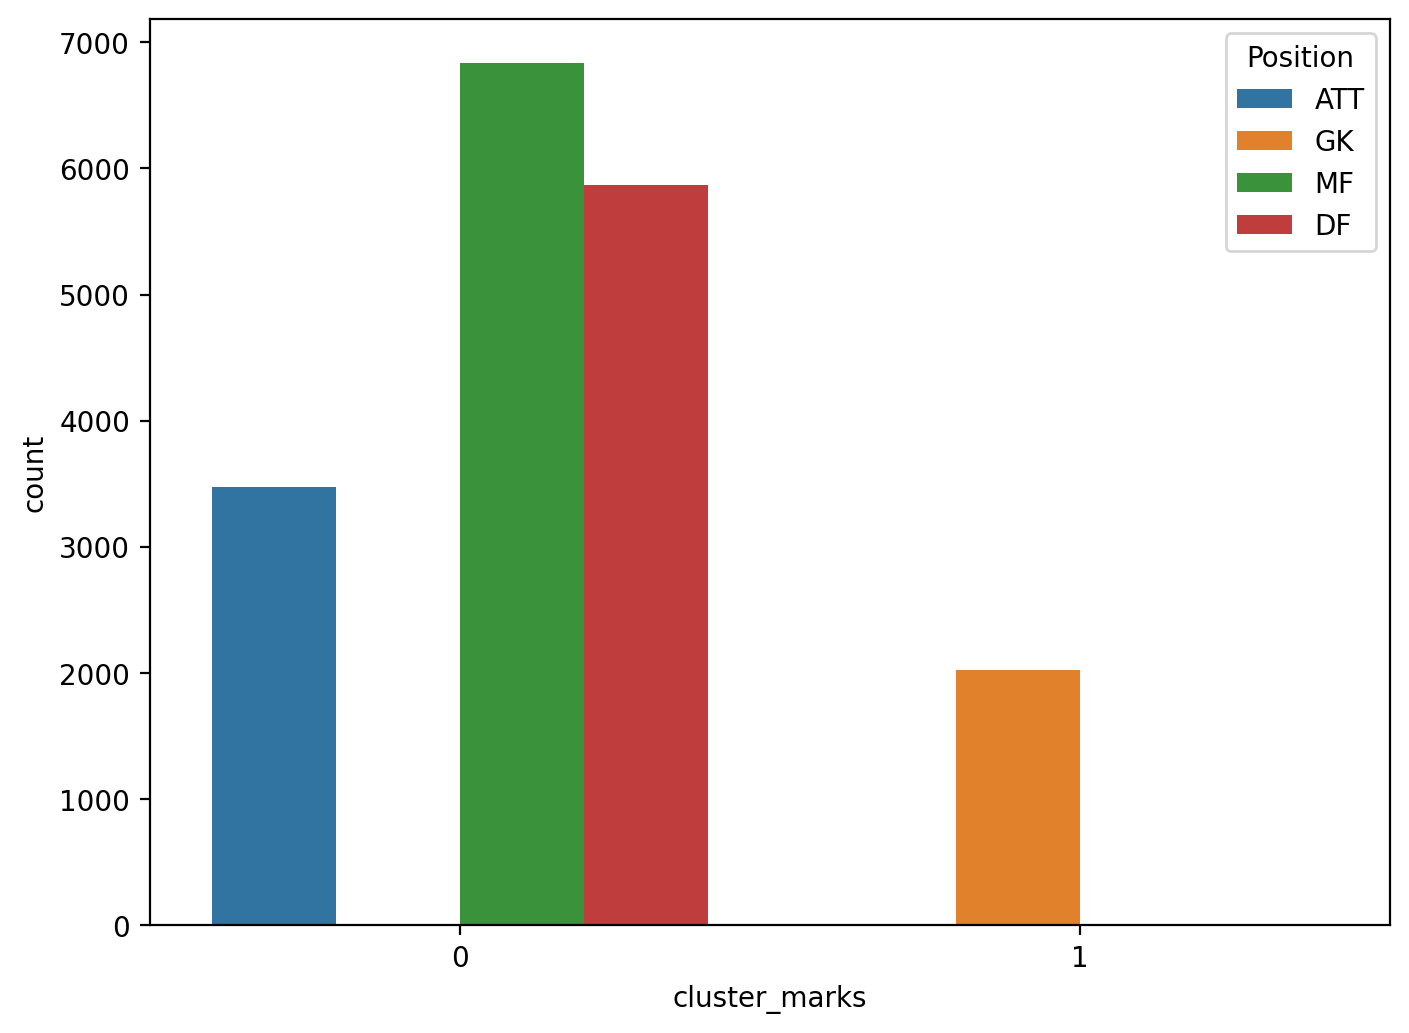

In [86]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [87]:
# Koristiti domensko znanje...
# Ukoliko znamo da se svaka pozicija (odbrana, vezni red i napad) moze podeliti na...
# ... podpozicije, dolazimo na 27 razlicitih podpozicija
# Pokusati za k=27

kmeans = KMeans(n_clusters=27, random_state=0)
kmeans.fit(df[numeric])
kmeans.labels_

count = Counter(kmeans.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{11: [1048, 5.756027901356621],
 24: [1000, 5.49239303564563],
 23: [935, 5.135387488328664],
 2: [903, 4.959630911188005],
 6: [901, 4.9486461251167135],
 3: [880, 4.833305871368155],
 8: [865, 4.750919975833471],
 15: [858, 4.712473224583951],
 0: [824, 4.525731861372],
 12: [709, 3.8941066622727525],
 19: [706, 3.8776294831658156],
 21: [698, 3.8336903388806505],
 18: [673, 3.6963805129895095],
 7: [670, 3.6799033338825726],
 26: [667, 3.6634261547756357],
 4: [624, 3.4272532542428733],
 20: [614, 3.3723293238864174],
 13: [532, 2.9219530949634756],
 10: [527, 2.8944911297852474],
 22: [526, 2.8889987367496017],
 1: [484, 2.6583182292524854],
 25: [480, 2.636348657109903],
 9: [462, 2.5374855824682814],
 17: [458, 2.515516010325699],
 16: [402, 2.2079420003295436],
 5: [401, 2.202449607293898],
 14: [360, 1.9772614928324272]}

In [100]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]
df_cluster_5 = df.loc[df['cluster_marks'] == 5]
df_cluster_6 = df.loc[df['cluster_marks'] == 6]
df_cluster_7 = df.loc[df['cluster_marks'] == 7]
df_cluster_8 = df.loc[df['cluster_marks'] == 8]
df_cluster_9 = df.loc[df['cluster_marks'] == 9]
df_cluster_10 = df.loc[df['cluster_marks'] == 10]
df_cluster_11 = df.loc[df['cluster_marks'] == 11]
df_cluster_12 = df.loc[df['cluster_marks'] == 12]
df_cluster_13 = df.loc[df['cluster_marks'] == 13]
df_cluster_14 = df.loc[df['cluster_marks'] == 14]
df_cluster_15 = df.loc[df['cluster_marks'] == 15]
df_cluster_16 = df.loc[df['cluster_marks'] == 16]
df_cluster_17 = df.loc[df['cluster_marks'] == 17]
df_cluster_18 = df.loc[df['cluster_marks'] == 18]
df_cluster_19 = df.loc[df['cluster_marks'] == 19]
df_cluster_20 = df.loc[df['cluster_marks'] == 20]
df_cluster_21 = df.loc[df['cluster_marks'] == 21]
df_cluster_22 = df.loc[df['cluster_marks'] == 22]
df_cluster_23 = df.loc[df['cluster_marks'] == 23]
df_cluster_24 = df.loc[df['cluster_marks'] == 24]
df_cluster_25 = df.loc[df['cluster_marks'] == 25]
df_cluster_26 = df.loc[df['cluster_marks'] == 26]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))
show_position_percentige_per_cluster(df_cluster_5, 5, len(df))
show_position_percentige_per_cluster(df_cluster_6, 6, len(df))
show_position_percentige_per_cluster(df_cluster_7, 7, len(df))
show_position_percentige_per_cluster(df_cluster_8, 8, len(df))
show_position_percentige_per_cluster(df_cluster_9, 9, len(df))
show_position_percentige_per_cluster(df_cluster_10, 10, len(df))
show_position_percentige_per_cluster(df_cluster_11, 11, len(df))
show_position_percentige_per_cluster(df_cluster_12, 12, len(df))
show_position_percentige_per_cluster(df_cluster_13, 13, len(df))
show_position_percentige_per_cluster(df_cluster_14, 14, len(df))
show_position_percentige_per_cluster(df_cluster_15, 15, len(df))
show_position_percentige_per_cluster(df_cluster_16, 16, len(df))
show_position_percentige_per_cluster(df_cluster_17, 17, len(df))
show_position_percentige_per_cluster(df_cluster_18, 18, len(df))
show_position_percentige_per_cluster(df_cluster_19, 19, len(df))
show_position_percentige_per_cluster(df_cluster_20, 20, len(df))
show_position_percentige_per_cluster(df_cluster_21, 12, len(df))
show_position_percentige_per_cluster(df_cluster_22, 22, len(df))
show_position_percentige_per_cluster(df_cluster_23, 23, len(df))
show_position_percentige_per_cluster(df_cluster_24, 24, len(df))
show_position_percentige_per_cluster(df_cluster_24, 25, len(df))
show_position_percentige_per_cluster(df_cluster_26, 26, len(df))

Broj igraca u klasteru 0: 824, (4.525731861372 %)

NAPAD: 1 (0.12135922330097086 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 1, (0.12135922330097086 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 0 (0.0 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 0 (0.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji RCB: 0

Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 1, (0.14104372355430184 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 701 (98.8716502115656 %)
Broj igraca na poziciji RWB: 1, (0.14104372355430184 %)
Broj igraca na poziciji RB: 8, (1.1283497884344147 %)
Broj igraca na poziciji RCB: 133, (18.758815232722146 %)
Broj igraca na poziciji CB: 410, (57.82792665726375 %)
Broj igraca na poziciji LCB: 135, (19.040902679830747 %)
Broj igraca na poziciji LB: 13, (1.8335684062059237 %)
Broj igraca na poziciji LWB: 1, (0.14104372355430184 %)

GOLMANI: 0 (0.0 %)

Broj igraca u klasteru 13: 532, (2.9219530949634756 %)

NAPAD: 0 (0.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 0, (0.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (

NAPAD: 80 (8.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 1, (0.1 %)
Broj igraca na poziciji RW: 21, (2.1 %)
Broj igraca na poziciji LW: 33, (3.3000000000000003 %)
Broj igraca na poziciji ST: 20, (2.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 3, (0.3 %)
Broj igraca na poziciji LS: 2, (0.2 %)

VEZNI RED: 795 (79.5 %)
Broj igraca na poziciji RDM: 15, (1.5 %)
Broj igraca na poziciji CDM: 40, (4.0 %)
Broj igraca na poziciji LDM: 20, (2.0 %)
Broj igraca na poziciji RM: 124, (12.4 %)
Broj igraca na poziciji RCM: 54, (5.4 %)
Broj igraca na poziciji CM: 250, (25.0 %)
Broj igraca na poziciji LCM: 59, (5.8999999999999995 %)
Broj igraca na poziciji LM: 118, (11.799999999999999 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 113, (11.3 %)
Broj igraca na poziciji LAM: 2, (0.2 %)

ODBRANA: 125 (12.5 %)
Broj igraca na poziciji RWB: 7, (0.7000000000000001 %)
Broj igraca na poziciji RB: 41, (4.1000000000000005 %)
Broj igraca

In [101]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

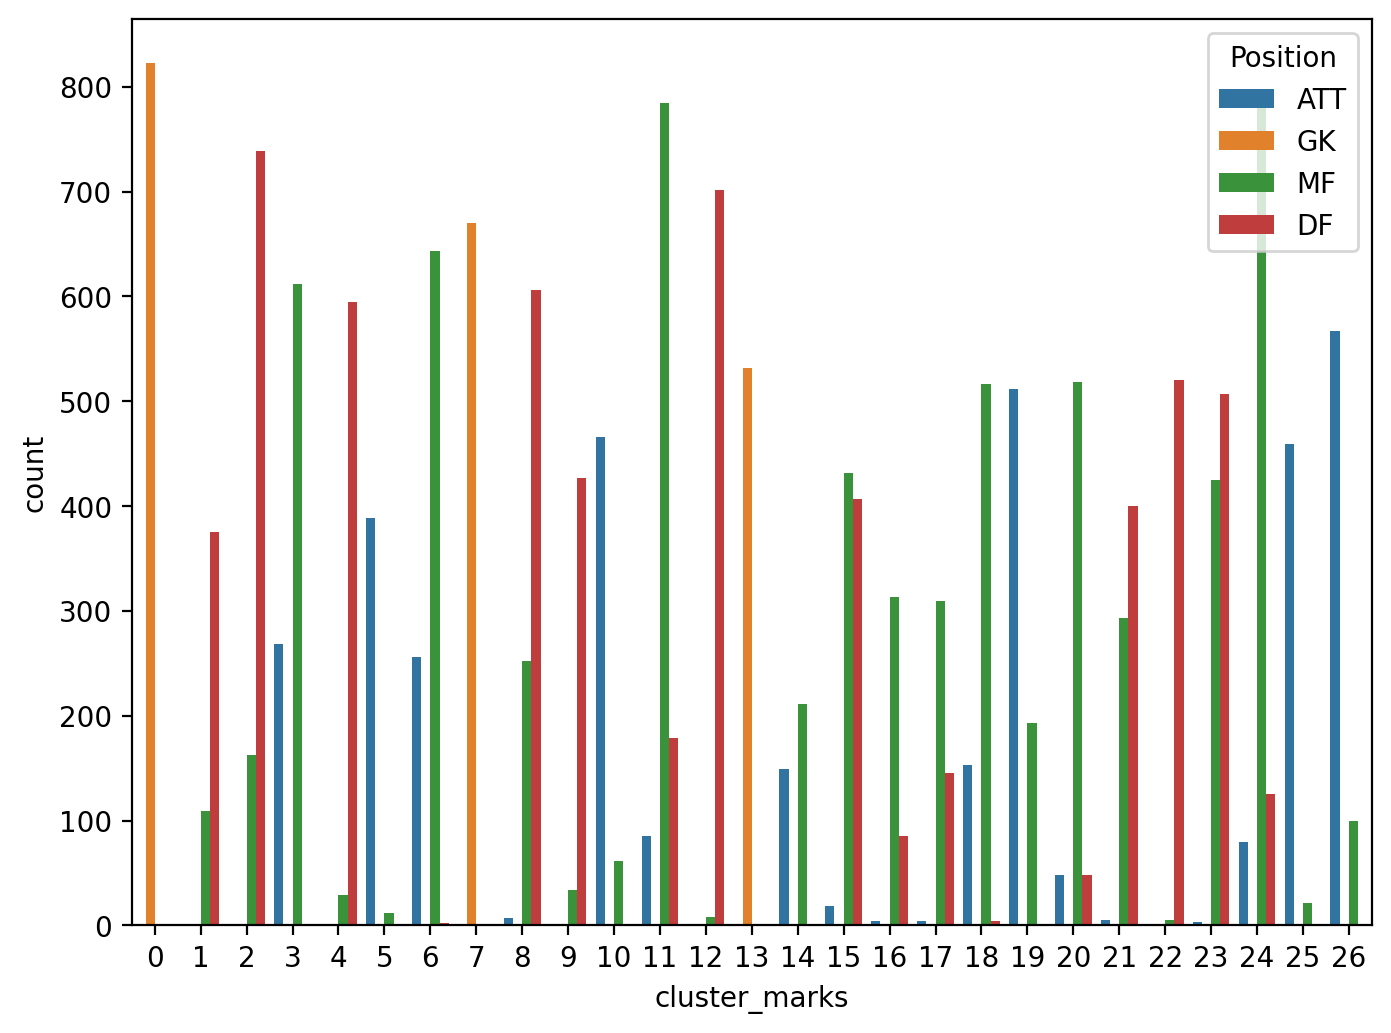

In [102]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [103]:
categorical_features_index = []
for index, feature in enumerate(df.columns.values):
    if str(df[feature].dtype) == 'object':
        categorical_features_index.append(index)

In [92]:
# KPrototypes

sse = []

for k in range(2, 11):
    kprototypes = KPrototypes(n_clusters=k, random_state=0, n_jobs=-1)
    kprototypes.fit(df, categorical=categorical_features_index)
    sse.append(kprototypes.cost_)

Text(0, 0.5, 'Cost')

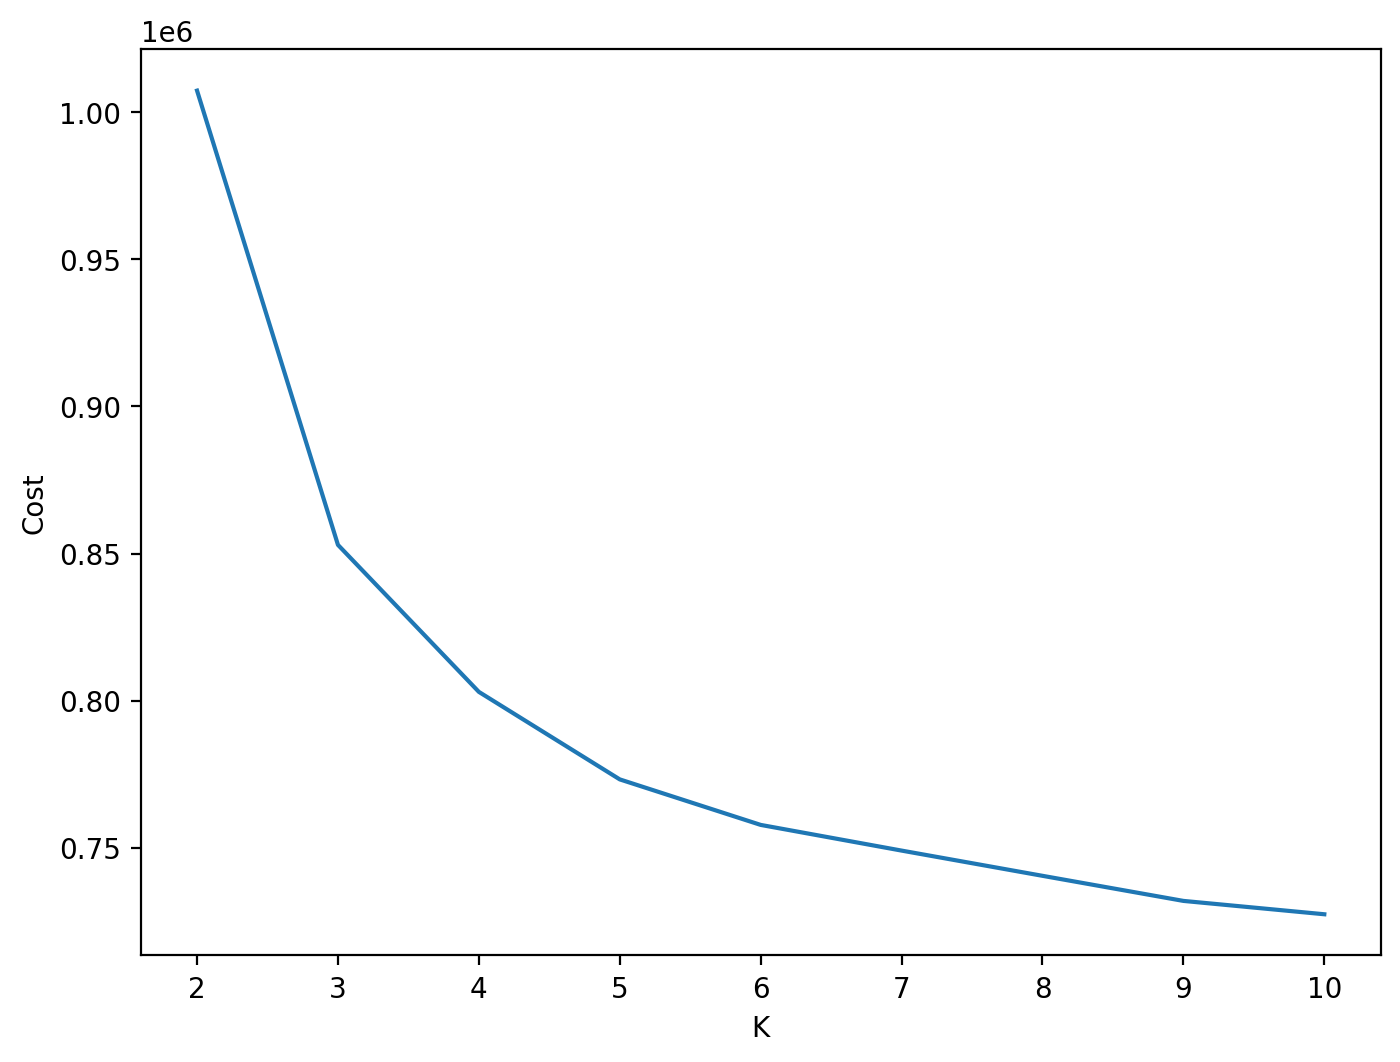

In [93]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
plt.plot(range(2, 11), sse)
plt.xlabel('K')
plt.ylabel('Cost')

In [40]:
kprototypes = KPrototypes(n_clusters=5, random_state=0)
kprototypes.fit(df, categorical=categorical_features_index)

NameError: name 'categorical_features_index' is not defined

In [95]:
count = Counter(kprototypes.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{4: [4080, 22.408963585434176],
 1: [3715, 20.404240127423517],
 2: [3618, 19.871478002965894],
 0: [3495, 19.19591365958148],
 3: [3299, 18.119404624594935]}

In [96]:
df['cluster_marks'] = kprototypes.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))

Broj igraca u klasteru 0: 3495, (19.19591365958148 %)

NAPAD: 725 (20.74391988555079 %)
Broj igraca na poziciji RF: 8, (0.22889842632331905 %)
Broj igraca na poziciji LF: 2, (0.057224606580829764 %)
Broj igraca na poziciji RW: 95, (2.7181688125894135 %)
Broj igraca na poziciji LW: 89, (2.5464949928469243 %)
Broj igraca na poziciji ST: 424, (12.131616595135908 %)
Broj igraca na poziciji CF: 18, (0.5150214592274678 %)
Broj igraca na poziciji RS: 44, (1.2589413447782547 %)
Broj igraca na poziciji LS: 45, (1.2875536480686696 %)

VEZNI RED: 2108 (60.31473533619456 %)
Broj igraca na poziciji RDM: 74, (2.1173104434907013 %)
Broj igraca na poziciji CDM: 232, (6.638054363376251 %)
Broj igraca na poziciji LDM: 84, (2.40343347639485 %)
Broj igraca na poziciji RM: 328, (9.38483547925608 %)
Broj igraca na poziciji RCM: 149, (4.263233190271817 %)
Broj igraca na poziciji CM: 466, (13.333333333333334 %)
Broj igraca na poziciji LCM: 138, (3.9484978540772535 %)
Broj igraca na poziciji LM: 325, (9.298998

In [97]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

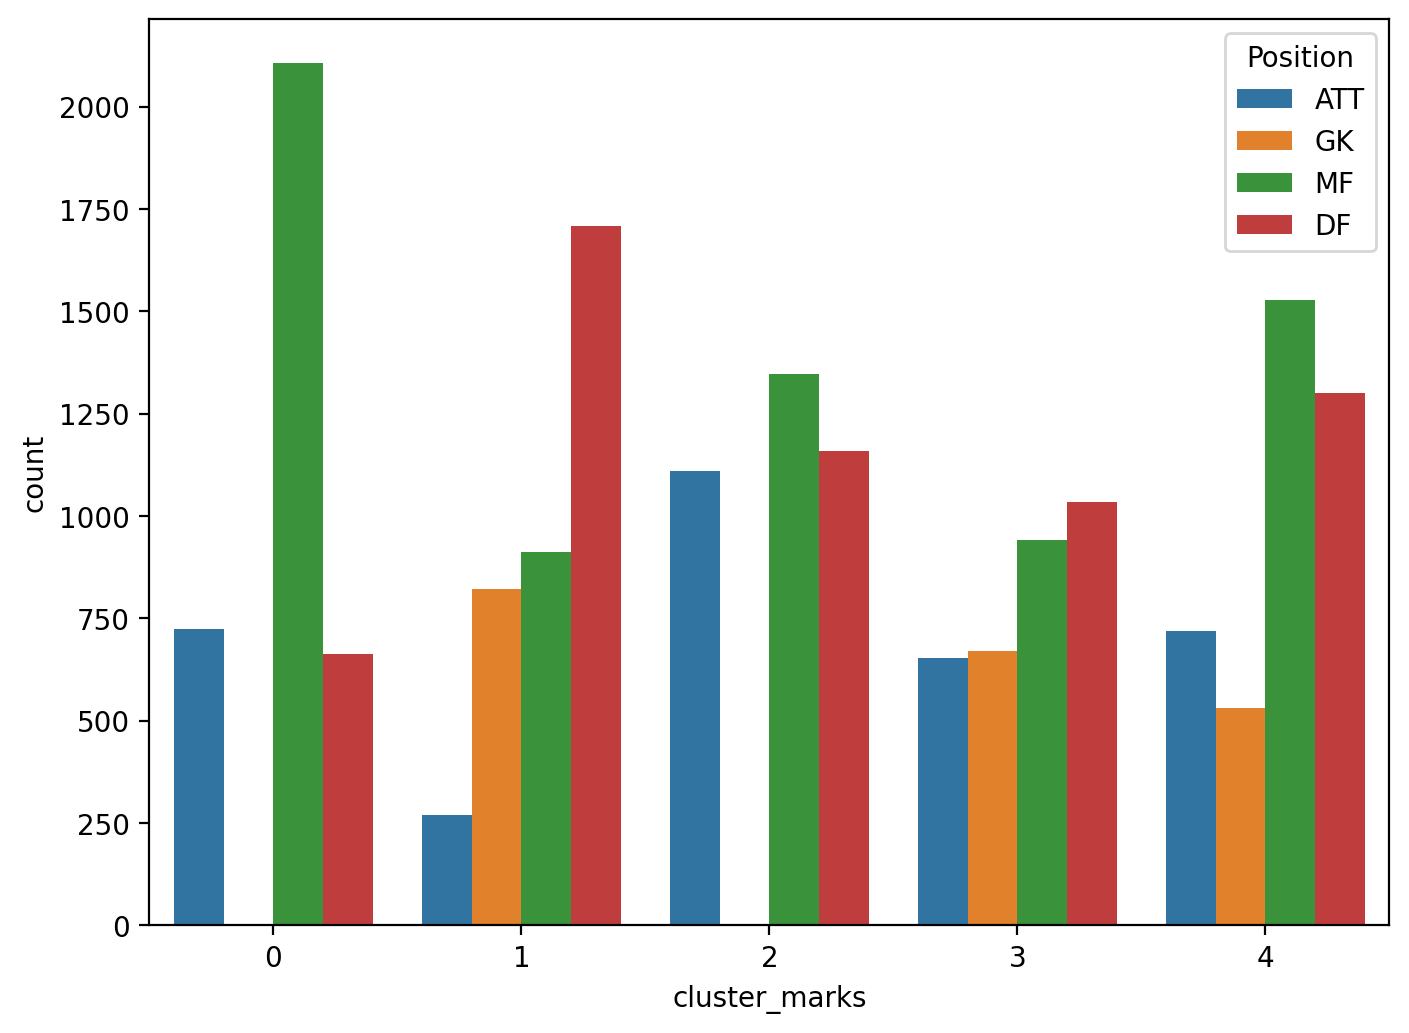

In [98]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [99]:
kprototypes = KPrototypes(n_clusters=27, random_state=0)
kprototypes.fit(df, categorical=categorical_features_index)

count = Counter(kprototypes.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{13: [1343, 7.376283846872083],
 7: [928, 5.096940737079145],
 2: [926, 5.085955951007854],
 18: [829, 4.553193826550228],
 6: [826, 4.536716647443291],
 15: [811, 4.454330751908606],
 10: [793, 4.355467677266986],
 14: [734, 4.0314164881638925],
 8: [717, 3.9380458065579176],
 0: [703, 3.861152304058878],
 17: [671, 3.6853957269182183],
 16: [670, 3.6799033338825726],
 5: [662, 3.635964189597408],
 21: [633, 3.476684791563684],
 11: [628, 3.4492228263854563],
 3: [612, 3.361344537815126],
 26: [595, 3.2679738562091507],
 24: [576, 3.163618388531883],
 22: [574, 3.1526336024605923],
 20: [570, 3.1306640303180098],
 1: [543, 2.9823694183555776],
 4: [533, 2.927445487999121],
 9: [532, 2.9219530949634756],
 19: [503, 2.7626736969297525],
 25: [435, 2.389190970505849],
 12: [432, 2.3727137913989127],
 23: [428, 2.3507442192563297]}

In [48]:
df['cluster_marks'] = kprototypes.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]
df_cluster_5 = df.loc[df['cluster_marks'] == 5]
df_cluster_6 = df.loc[df['cluster_marks'] == 6]
df_cluster_7 = df.loc[df['cluster_marks'] == 7]
df_cluster_8 = df.loc[df['cluster_marks'] == 8]
df_cluster_9 = df.loc[df['cluster_marks'] == 9]
df_cluster_10 = df.loc[df['cluster_marks'] == 10]
df_cluster_11 = df.loc[df['cluster_marks'] == 11]
df_cluster_12 = df.loc[df['cluster_marks'] == 12]
df_cluster_13 = df.loc[df['cluster_marks'] == 13]
df_cluster_14 = df.loc[df['cluster_marks'] == 14]
df_cluster_15 = df.loc[df['cluster_marks'] == 15]
df_cluster_16 = df.loc[df['cluster_marks'] == 16]
df_cluster_17 = df.loc[df['cluster_marks'] == 17]
df_cluster_18 = df.loc[df['cluster_marks'] == 18]
df_cluster_19 = df.loc[df['cluster_marks'] == 19]
df_cluster_20 = df.loc[df['cluster_marks'] == 20]
df_cluster_21 = df.loc[df['cluster_marks'] == 21]
df_cluster_22 = df.loc[df['cluster_marks'] == 22]
df_cluster_23 = df.loc[df['cluster_marks'] == 23]
df_cluster_24 = df.loc[df['cluster_marks'] == 24]
df_cluster_25 = df.loc[df['cluster_marks'] == 25]
df_cluster_26 = df.loc[df['cluster_marks'] == 26]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))
show_position_percentige_per_cluster(df_cluster_5, 5, len(df))
show_position_percentige_per_cluster(df_cluster_6, 6, len(df))
show_position_percentige_per_cluster(df_cluster_7, 7, len(df))
show_position_percentige_per_cluster(df_cluster_8, 8, len(df))
show_position_percentige_per_cluster(df_cluster_9, 9, len(df))
show_position_percentige_per_cluster(df_cluster_10, 10, len(df))
show_position_percentige_per_cluster(df_cluster_11, 11, len(df))
show_position_percentige_per_cluster(df_cluster_12, 12, len(df))
show_position_percentige_per_cluster(df_cluster_13, 13, len(df))
show_position_percentige_per_cluster(df_cluster_14, 14, len(df))
show_position_percentige_per_cluster(df_cluster_15, 15, len(df))
show_position_percentige_per_cluster(df_cluster_16, 16, len(df))
show_position_percentige_per_cluster(df_cluster_17, 17, len(df))
show_position_percentige_per_cluster(df_cluster_18, 18, len(df))
show_position_percentige_per_cluster(df_cluster_19, 19, len(df))
show_position_percentige_per_cluster(df_cluster_20, 20, len(df))
show_position_percentige_per_cluster(df_cluster_21, 12, len(df))
show_position_percentige_per_cluster(df_cluster_22, 22, len(df))
show_position_percentige_per_cluster(df_cluster_23, 23, len(df))
show_position_percentige_per_cluster(df_cluster_24, 24, len(df))
show_position_percentige_per_cluster(df_cluster_24, 25, len(df))
show_position_percentige_per_cluster(df_cluster_26, 26, len(df))

Broj igraca u klasteru 0: 476, (2.6143790849673203 %)

NAPAD: 0 (0.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 0, (0.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 27 (5.6722689075630255 %)
Broj igraca na poziciji RDM: 2, (0.42016806722689076 %)
Broj igraca na poziciji CDM: 20, (4.201680672268908 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 2, (0.42016806722689076 %)
Broj igraca na poziciji CM: 2, (0.42016806722689076 %)
Broj igraca na poziciji LCM: 1, (0.21008403361344538 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 449 (94.32773109243698 %)
Broj igraca na poziciji RW

Broj igraca na poziciji RW: 11, (2.0793950850661624 %)
Broj igraca na poziciji LW: 8, (1.5122873345935728 %)
Broj igraca na poziciji ST: 329, (62.19281663516069 %)
Broj igraca na poziciji CF: 5, (0.945179584120983 %)
Broj igraca na poziciji RS: 55, (10.396975425330812 %)
Broj igraca na poziciji LS: 55, (10.396975425330812 %)

VEZNI RED: 65 (12.287334593572778 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 18, (3.402646502835539 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 23, (4.3478260869565215 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 23, (4.3478260869565215 %)
Broj igraca na poziciji LAM: 1, (0.1890359168241966 %)

ODBRANA: 0 (0.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji RCB: 0, (0.0 

Broj igraca na poziciji RW: 72, (8.581644815256258 %)
Broj igraca na poziciji LW: 89, (10.607866507747318 %)
Broj igraca na poziciji ST: 89, (10.607866507747318 %)
Broj igraca na poziciji CF: 9, (1.0727056019070322 %)
Broj igraca na poziciji RS: 13, (1.5494636471990464 %)
Broj igraca na poziciji LS: 16, (1.907032181168057 %)

VEZNI RED: 546 (65.07747318235995 %)
Broj igraca na poziciji RDM: 2, (0.23837902264600713 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 2, (0.23837902264600713 %)
Broj igraca na poziciji RM: 198, (23.59952324195471 %)
Broj igraca na poziciji RCM: 6, (0.7151370679380215 %)
Broj igraca na poziciji CM: 11, (1.3110846245530394 %)
Broj igraca na poziciji LCM: 9, (1.0727056019070322 %)
Broj igraca na poziciji LM: 159, (18.951132300357568 %)
Broj igraca na poziciji RAM: 1, (0.11918951132300357 %)
Broj igraca na poziciji CAM: 157, (18.71275327771156 %)
Broj igraca na poziciji LAM: 1, (0.11918951132300357 %)

ODBRANA: 1 (0.11918951132300357 %)
Bro

Text(0, 0.5, 'Distance between clusters')

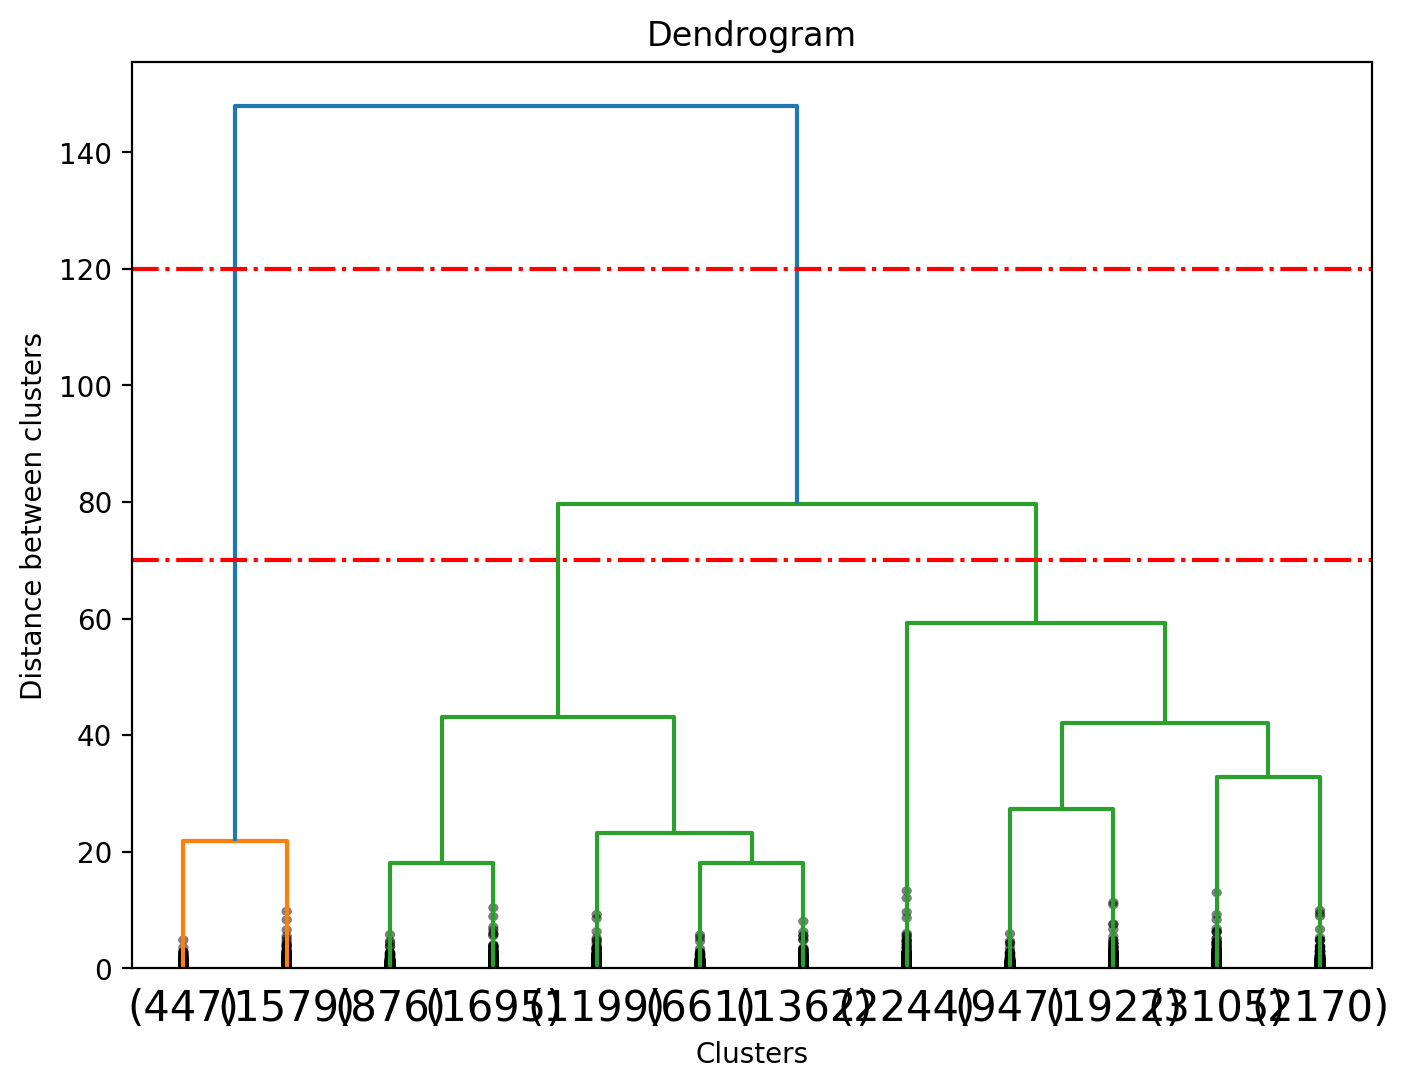

In [49]:
# Agglomerative

plt.figure(num=None, figsize=(8, 6), dpi=200)
distance_matrix = linkage(df[numeric], 'ward')
dendrogram(distance_matrix, truncate_mode='lastp', p=12, leaf_font_size=15, show_contracted=True)
plt.axhline(y=120, linestyle='-.', color='red')
plt.axhline(y=70, linestyle='-.', color='red')
plt.title('Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Distance between clusters')

In [50]:
# za podelu na 2 klastera

agglomerative = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agglomerative.fit(df[numeric])

AgglomerativeClustering()

In [51]:
count = Counter(agglomerative.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{0: [16181, 88.87241170978196], 1: [2026, 11.127588290218048]}

In [52]:
df['cluster_marks'] = agglomerative.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))


Broj igraca u klasteru 0: 16181, (88.87241170978196 %)

NAPAD: 3477 (21.48816513194487 %)
Broj igraca na poziciji RF: 16, (0.09888140411593845 %)
Broj igraca na poziciji LF: 15, (0.09270131635869229 %)
Broj igraca na poziciji RW: 370, (2.2866324701810767 %)
Broj igraca na poziciji LW: 381, (2.3546134355107844 %)
Broj igraca na poziciji ST: 2211, (13.664174031271244 %)
Broj igraca na poziciji CF: 74, (0.45732649403621534 %)
Broj igraca na poziciji RS: 203, (1.254557814720969 %)
Broj igraca na poziciji LS: 207, (1.2792781657499537 %)

VEZNI RED: 6838 (42.259440084049196 %)
Broj igraca na poziciji RDM: 248, (1.5326617637970459 %)
Broj igraca na poziciji CDM: 948, (5.858723193869353 %)
Broj igraca na poziciji LDM: 243, (1.5017613250108153 %)
Broj igraca na poziciji RM: 1124, (6.946418639144676 %)
Broj igraca na poziciji RCM: 391, (2.416414313083246 %)
Broj igraca na poziciji CM: 1394, (8.615042333601137 %)
Broj igraca na poziciji LCM: 395, (2.4411346641122305 %)
Broj igraca na poziciji LM:

In [53]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

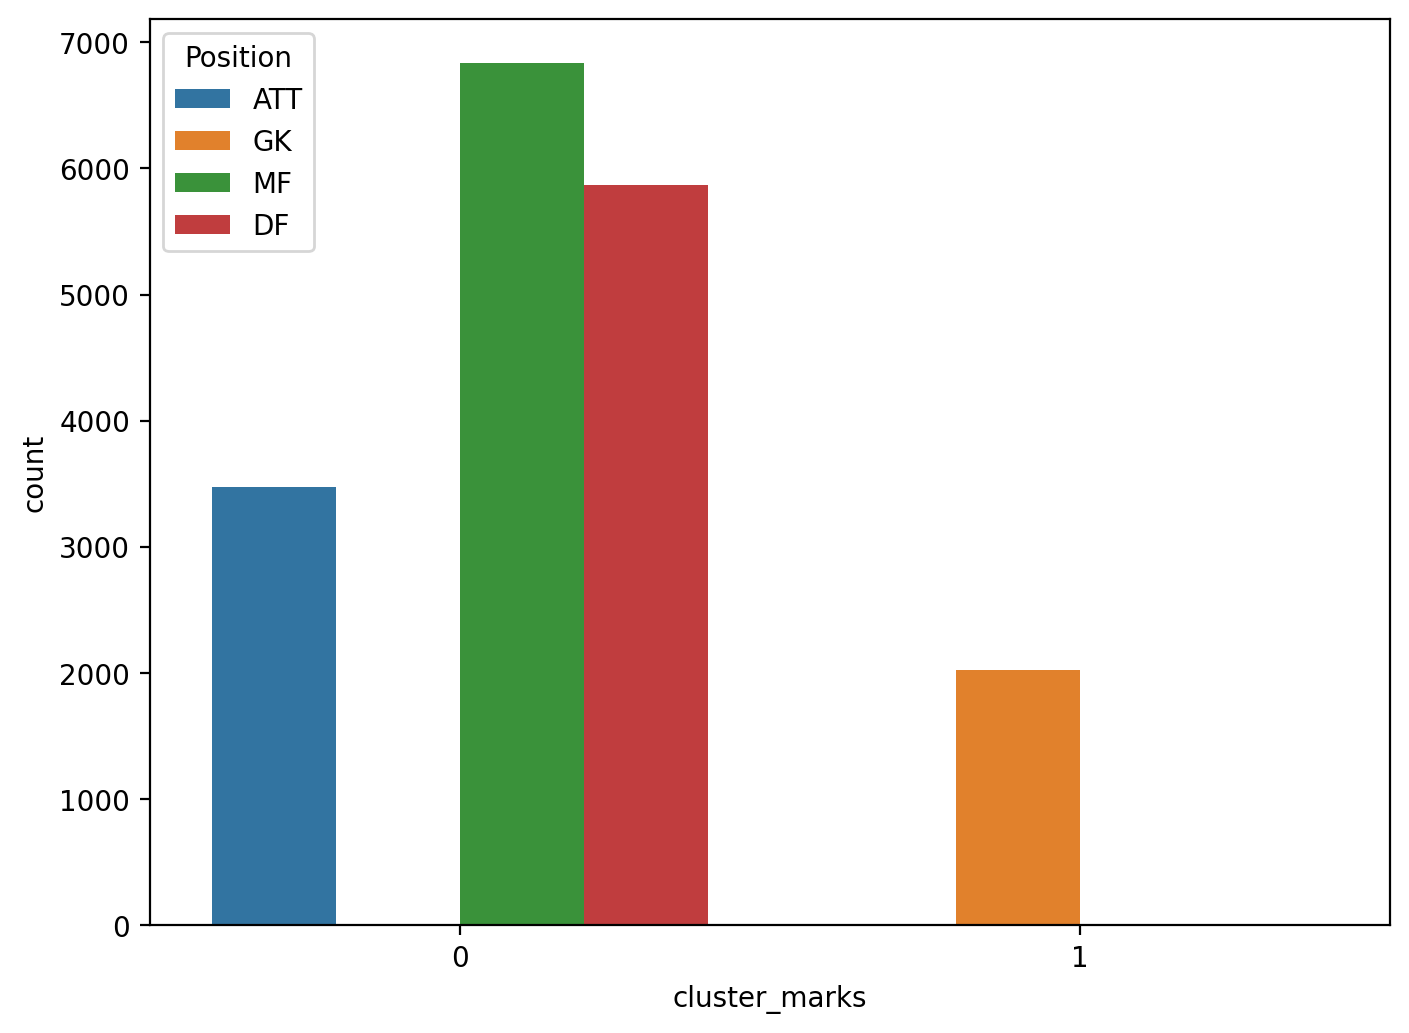

In [54]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)


In [55]:
# Za podelu na 3 klastera

agglomerative = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
agglomerative.fit(df[numeric])
clusters = agglomerative.labels_

count = Counter(clusters)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{0: [10388, 57.05497885428681],
 2: [5793, 31.817432855495138],
 1: [2026, 11.127588290218048]}

In [56]:
df['cluster_marks'] = agglomerative.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 1, len(df))

Broj igraca u klasteru 0: 10388, (57.05497885428681 %)

NAPAD: 1603 (15.431266846361186 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 2, (0.019252984212552945 %)
Broj igraca na poziciji RW: 164, (1.5787447054293418 %)
Broj igraca na poziciji LW: 167, (1.607624181748171 %)
Broj igraca na poziciji ST: 1137, (10.94532152483635 %)
Broj igraca na poziciji CF: 35, (0.3369272237196766 %)
Broj igraca na poziciji RS: 53, (0.5102040816326531 %)
Broj igraca na poziciji LS: 45, (0.4331921447824413 %)

VEZNI RED: 3695 (35.56988833269157 %)
Broj igraca na poziciji RDM: 134, (1.2899499422410472 %)
Broj igraca na poziciji CDM: 727, (6.998459761262995 %)
Broj igraca na poziciji LDM: 149, (1.4343473238351945 %)
Broj igraca na poziciji RM: 523, (5.034655371582596 %)
Broj igraca na poziciji RCM: 180, (1.7327685791297651 %)
Broj igraca na poziciji CM: 944, (9.08740854832499 %)
Broj igraca na poziciji LCM: 173, (1.6653831343858296 %)
Broj igraca na poziciji LM: 476, (4.58221024258760

In [57]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

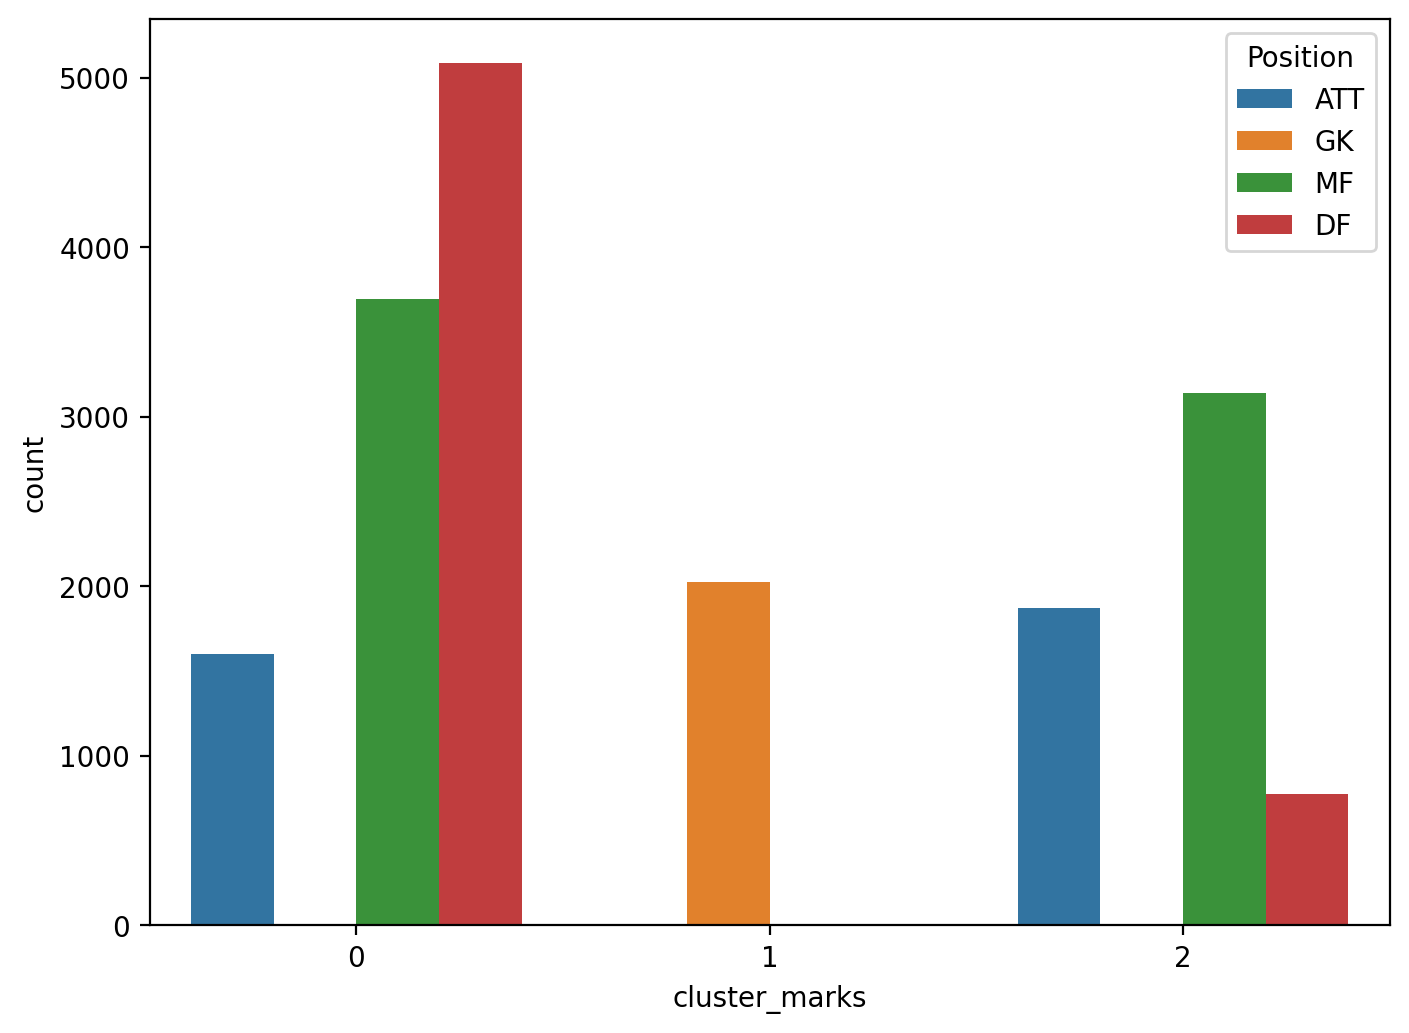

In [58]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [59]:
# DBSCAN

dbscan = DBSCAN()
dbscan.fit(df[numeric])

count = Counter(dbscan.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]

number_and_percentige_per_cluster    

{1: [10979, 60.30098313835338],
 -1: [5632, 30.933157576756194],
 0: [1546, 8.491239633108146],
 3: [7, 0.03844675124951942],
 2: [5, 0.027461965178228156],
 8: [5, 0.027461965178228156],
 5: [5, 0.027461965178228156],
 9: [4, 0.021969572142582522],
 6: [4, 0.021969572142582522],
 10: [4, 0.021969572142582522],
 11: [4, 0.021969572142582522],
 4: [3, 0.01647717910693689],
 7: [3, 0.01647717910693689],
 12: [3, 0.01647717910693689],
 13: [3, 0.01647717910693689]}

In [60]:
df['cluster_marks'] = dbscan.labels_

df_cluster_minus_1 = df.loc[df['cluster_marks'] == -1]
df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]
df_cluster_5 = df.loc[df['cluster_marks'] == 5]
df_cluster_6 = df.loc[df['cluster_marks'] == 6]
df_cluster_7 = df.loc[df['cluster_marks'] == 7]
df_cluster_8 = df.loc[df['cluster_marks'] == 8]
df_cluster_9 = df.loc[df['cluster_marks'] == 9]
df_cluster_10 = df.loc[df['cluster_marks'] == 10]
df_cluster_11 = df.loc[df['cluster_marks'] == 11]
df_cluster_12 = df.loc[df['cluster_marks'] == 12]
df_cluster_13 = df.loc[df['cluster_marks'] == 13]

show_position_percentige_per_cluster(df_cluster_minus_1, -1, len(df))
show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))
show_position_percentige_per_cluster(df_cluster_5, 5, len(df))
show_position_percentige_per_cluster(df_cluster_6, 6, len(df))
show_position_percentige_per_cluster(df_cluster_7, 7, len(df))
show_position_percentige_per_cluster(df_cluster_8, 8, len(df))
show_position_percentige_per_cluster(df_cluster_9, 9, len(df))
show_position_percentige_per_cluster(df_cluster_10, 10, len(df))
show_position_percentige_per_cluster(df_cluster_11, 11, len(df))
show_position_percentige_per_cluster(df_cluster_12, 12, len(df))
show_position_percentige_per_cluster(df_cluster_13, 13, len(df))

Broj igraca u klasteru -1: 5632, (30.933157576756194 %)

NAPAD: 1338 (23.757102272727273 %)
Broj igraca na poziciji RF: 8, (0.14204545454545456 %)
Broj igraca na poziciji LF: 9, (0.15980113636363638 %)
Broj igraca na poziciji RW: 155, (2.752130681818182 %)
Broj igraca na poziciji LW: 149, (2.645596590909091 %)
Broj igraca na poziciji ST: 803, (14.2578125 %)
Broj igraca na poziciji CF: 31, (0.5504261363636364 %)
Broj igraca na poziciji RS: 90, (1.5980113636363635 %)
Broj igraca na poziciji LS: 93, (1.6512784090909092 %)

VEZNI RED: 2062 (36.612215909090914 %)
Broj igraca na poziciji RDM: 63, (1.1186079545454546 %)
Broj igraca na poziciji CDM: 250, (4.438920454545454 %)
Broj igraca na poziciji LDM: 77, (1.3671875 %)
Broj igraca na poziciji RM: 399, (7.084517045454546 %)
Broj igraca na poziciji RCM: 97, (1.7223011363636365 %)
Broj igraca na poziciji CM: 286, (5.078125 %)
Broj igraca na poziciji LCM: 99, (1.7578125 %)
Broj igraca na poziciji LM: 403, (7.1555397727272725 %)
Broj igraca na p

GOLMANI: 5 (100.0 %)

Broj igraca u klasteru 9: 4, (0.021969572142582522 %)

NAPAD: 0 (0.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 0, (0.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 0 (0.0 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 4 (100.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji RCB: 2, (5

In [61]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

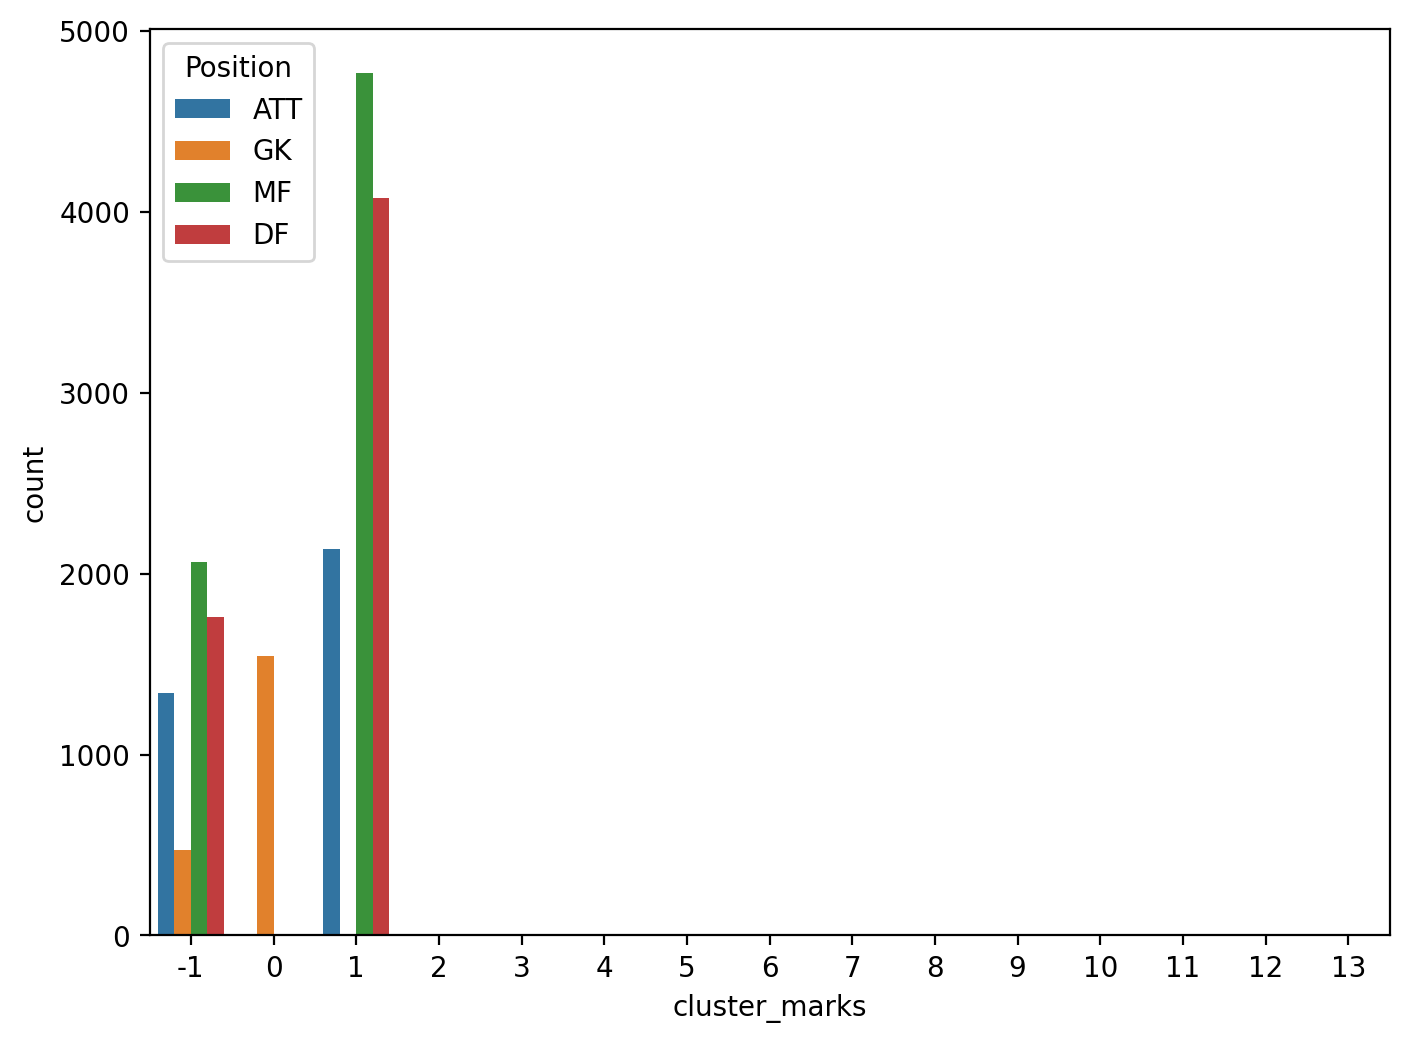

In [62]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [63]:
dbscan = DBSCAN(min_samples=6)
dbscan.fit(df[numeric])

count = Counter(dbscan.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{2: [10810, 59.37276871532927],
 -1: [5852, 32.141484044598236],
 0: [1526, 8.381391772395233],
 1: [6, 0.03295435821387378],
 3: [5, 0.027461965178228156],
 4: [4, 0.021969572142582522],
 5: [4, 0.021969572142582522]}

In [64]:
df['cluster_marks'] = dbscan.labels_

df_cluster_minus_1 = df.loc[df['cluster_marks'] == -1]
df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]
df_cluster_5 = df.loc[df['cluster_marks'] == 5]

show_position_percentige_per_cluster(df_cluster_minus_1, -1, len(df))
show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))
show_position_percentige_per_cluster(df_cluster_5, 5, len(df))

Broj igraca u klasteru -1: 5852, (32.141484044598236 %)

NAPAD: 1391 (23.769651401230348 %)
Broj igraca na poziciji RF: 8, (0.1367053998632946 %)
Broj igraca na poziciji LF: 9, (0.15379357484620643 %)
Broj igraca na poziciji RW: 165, (2.819548872180451 %)
Broj igraca na poziciji LW: 160, (2.734107997265892 %)
Broj igraca na poziciji ST: 821, (14.029391660970608 %)
Broj igraca na poziciji CF: 34, (0.5809979494190021 %)
Broj igraca na poziciji RS: 95, (1.6233766233766231 %)
Broj igraca na poziciji LS: 99, (1.6917293233082706 %)

VEZNI RED: 2130 (36.39781271360219 %)
Broj igraca na poziciji RDM: 65, (1.1107313738892686 %)
Broj igraca na poziciji CDM: 259, (4.425837320574163 %)
Broj igraca na poziciji LDM: 78, (1.3328776486671223 %)
Broj igraca na poziciji RM: 414, (7.0745044429254955 %)
Broj igraca na poziciji RCM: 101, (1.7259056732740943 %)
Broj igraca na poziciji CM: 289, (4.938482570061518 %)
Broj igraca na poziciji LCM: 100, (1.7088174982911826 %)
Broj igraca na poziciji LM: 423, (7.

In [65]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

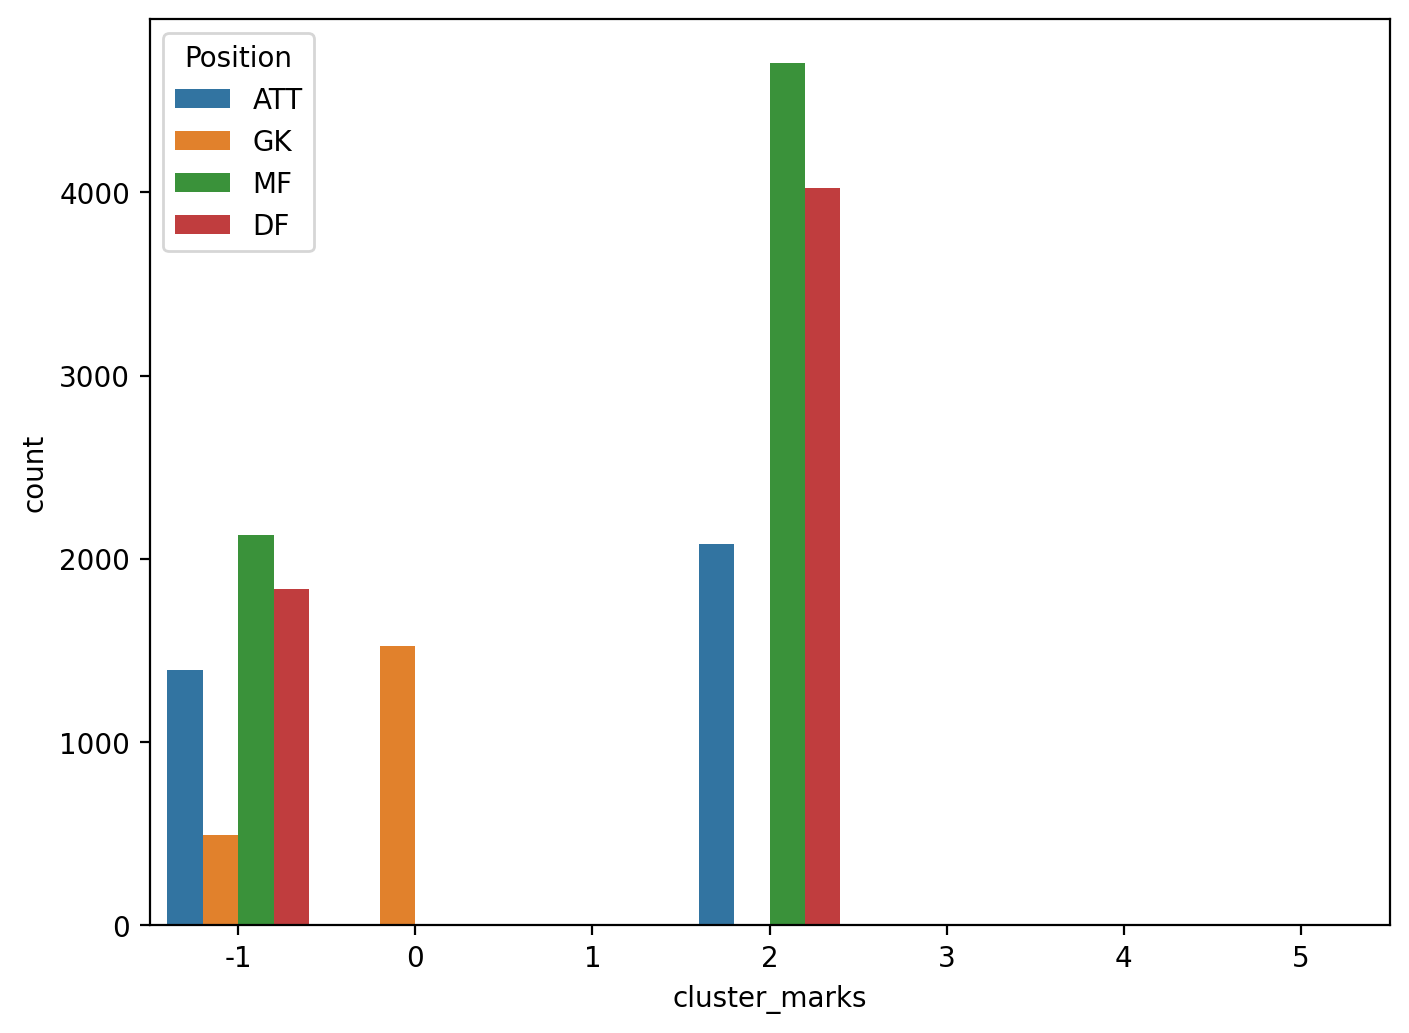

In [66]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [67]:
dbscan = DBSCAN(min_samples=7)
dbscan.fit(df[numeric])
dbscan.labels_

count = Counter(dbscan.labels_)
number_and_percentige_per_cluster = {}

for value, times in count.most_common():
    number_and_percentige_per_cluster[value] = [times, (times / len(df)) * 100]
    
number_and_percentige_per_cluster

{1: [10636, 58.41709232712693],
 -1: [6049, 33.223485472620425],
 0: [1514, 8.315483055967485],
 2: [4, 0.021969572142582522],
 3: [4, 0.021969572142582522]}

In [68]:
df['cluster_marks'] = dbscan.labels_

df_cluster_minus_1 = df.loc[df['cluster_marks'] == -1]
df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]

show_position_percentige_per_cluster(df_cluster_minus_1, -1, len(df))
show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))

Broj igraca u klasteru -1: 6049, (33.223485472620425 %)

NAPAD: 1441 (23.822119358571666 %)
Broj igraca na poziciji RF: 8, (0.13225326500247975 %)
Broj igraca na poziciji LF: 9, (0.1487849231277897 %)
Broj igraca na poziciji RW: 175, (2.8930401719292447 %)
Broj igraca na poziciji LW: 167, (2.7607869069267648 %)
Broj igraca na poziciji ST: 844, (13.952719457761614 %)
Broj igraca na poziciji CF: 37, (0.6116713506364688 %)
Broj igraca na poziciji RS: 100, (1.653165812530997 %)
Broj igraca na poziciji LS: 101, (1.6696974706563068 %)

VEZNI RED: 2203 (36.419242850057856 %)
Broj igraca na poziciji RDM: 67, (1.1076210943957678 %)
Broj igraca na poziciji CDM: 266, (4.397421061332452 %)
Broj igraca na poziciji LDM: 80, (1.3225326500247974 %)
Broj igraca na poziciji RM: 433, (7.158207968259217 %)
Broj igraca na poziciji RCM: 103, (1.7027607869069268 %)
Broj igraca na poziciji CM: 300, (4.95949743759299 %)
Broj igraca na poziciji LCM: 103, (1.7027607869069268 %)
Broj igraca na poziciji LM: 437, (

In [69]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})

df1['Position'].unique()

array(['ATT', 'GK', 'MF', 'DF'], dtype=object)

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

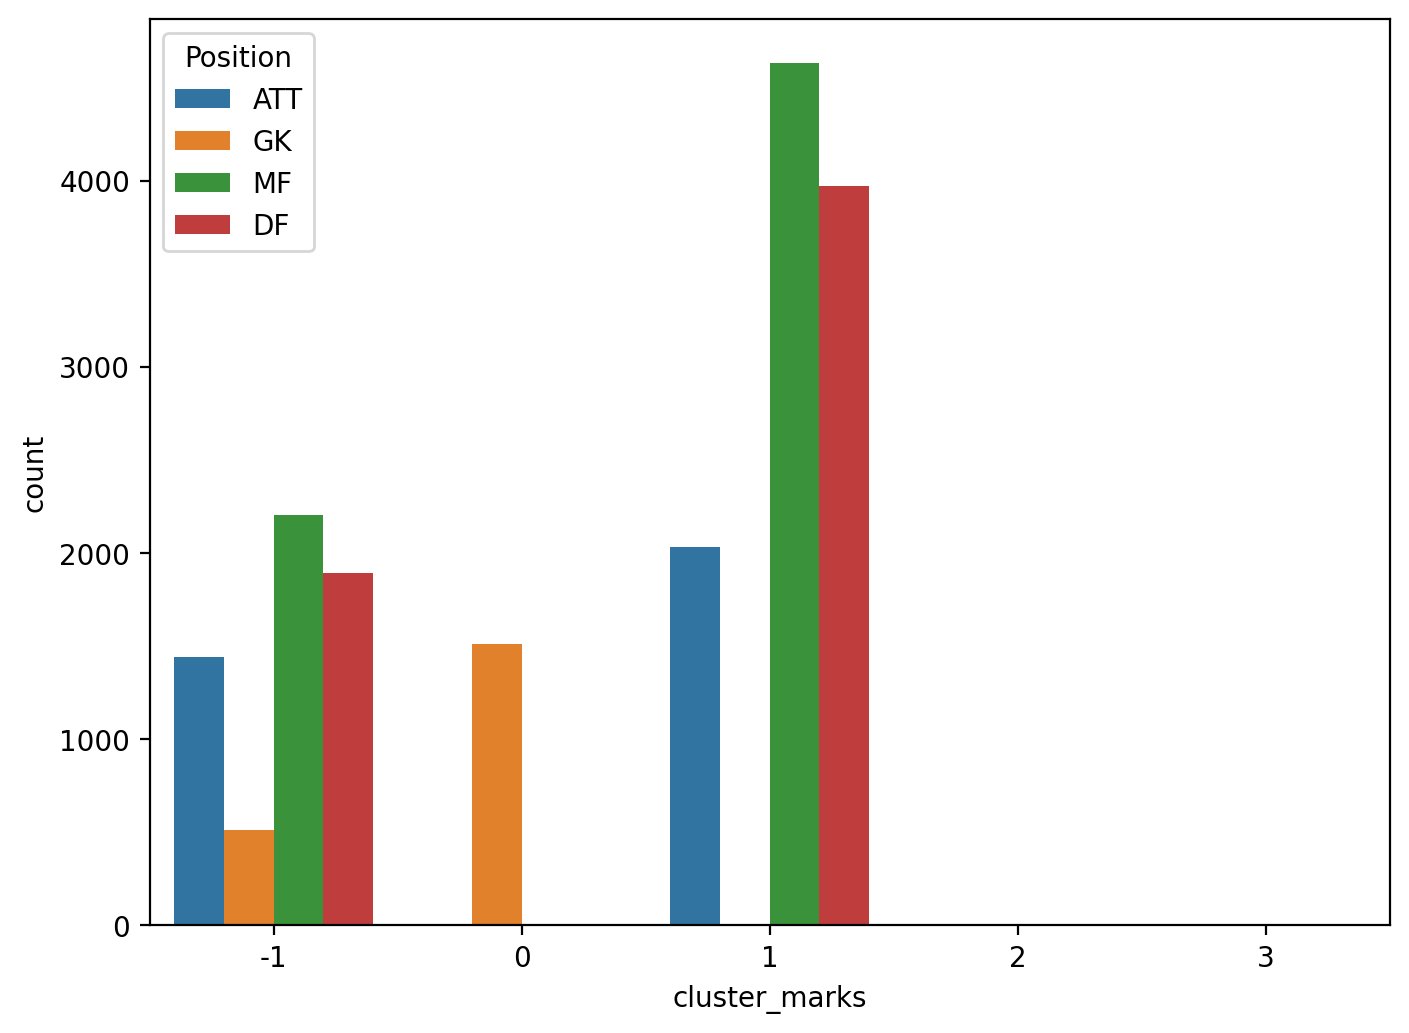

In [70]:
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [104]:
df['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [105]:
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Contract Valid Until', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDivi

In [134]:
df[numeric].columns

Index(['Unnamed: 0', 'ID', 'Age', 'Overall', 'Potential', 'Special',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Jersey Number',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')

**Golman** - GK

**Odbrana** - RWB, RB, RCB, CB, LCB, LB, LWB

**Vezni red** - RDM, CDM, LDM, RM, RCM, CM, LCM, LM, RAM, CAM, LAM

**Napad** - RF, CF, LF, RS, ST, LS, LW, RW

In [189]:
def f(df, variable):
    
    gk = df.loc[df['Position'] == 'GK']

    print(f'GK, srednja vrednost {variable}: ', gk[variable].mean())
    print(f'GK, medijan vrednost {variable}: ', gk[variable].median())
    print()

    # Napadaci 

    print('NAPAD:')

    rf = df.loc[df['Position'] == 'RF']

    print(f'RF, srednja vrednost {variable}: ', rf[variable].mean())
    print(f'RF, medijan vrednost {variable}: ', rf[variable].median())
    print()

    cf = df.loc[df['Position'] == 'CF']

    print(f'CF, srednja vrednost {variable}: ', cf[variable].mean())
    print(f'CF, medijan vrednost {variable}: ', cf[variable].median())
    print()

    lf = df.loc[df['Position'] == 'LF']

    print(f'LF, srednja vrednost {variable}: ', lf[variable].mean())
    print(f'LF, medijan vrednost {variable}: ', lf[variable].median())
    print()

    rs = df.loc[df['Position'] == 'RS']

    print(f'RS, srednja vrednost {variable}: ', rs[variable].mean())
    print(f'RS, medijan vrednost {variable}: ', rs[variable].median())
    print()

    st = df.loc[df['Position'] == 'ST']

    print(f'ST, srednja vrednost {variable}: ', st[variable].mean())
    print(f'ST, medijan vrednost {variable}: ', st[variable].median())
    print()

    ls = df.loc[df['Position'] == 'LS']

    print(f'LS, srednja vrednost {variable}: ', ls[variable].mean())
    print(f'LS, medijan vrednost {variable}: ', ls[variable].median())
    print()

    lw = df.loc[df['Position'] == 'LW']

    print(f'LW, srednja vrednost {variable}: ', lw[variable].mean())
    print(f'LW, medijan vrednost {variable}: ', lw[variable].median())
    print()

    rw = df.loc[df['Position'] == 'RW']

    print(f'RW, srednja vrednost {variable}: ', rw[variable].mean())
    print(f'RW, medijan vrednost {variable}: ', rw[variable].median())
    print()

    # Vezni red

    print('VEZNI RED:')

    rdm = df.loc[df['Position'] == 'RDM']

    print(f'RDM, srednja vrednost {variable}: ', rdm[variable].mean())
    print(f'RDM, medijan vrednost {variable}: ', rdm[variable].median())
    print()

    cdm = df.loc[df['Position'] == 'CDM']

    print(f'CDM, srednja vrednost {variable}: ', cdm[variable].mean())
    print(f'CDM, medijan vrednost {variable}: ', cdm[variable].median())
    print()

    ldm = df.loc[df['Position'] == 'LDM']

    print(f'LDM, srednja vrednost {variable}: ', ldm[variable].mean())
    print(f'LDM, medijan vrednost {variable}: ', ldm[variable].median())
    print()

    rm = df.loc[df['Position'] == 'RM']

    print(f'RM, srednja vrednost {variable}: ', rm[variable].mean())
    print(f'RM, medijan vrednost {variable}: ', rm[variable].median())
    print()

    rcm = df.loc[df['Position'] == 'RCM']

    print(f'RCM, srednja vrednost {variable}: ', rcm[variable].mean())
    print(f'RCM, medijan vrednost {variable}: ', rcm[variable].median())
    print()

    cm = df.loc[df['Position'] == 'CM']

    print(f'CM, srednja vrednost {variable}: ', cm[variable].mean())
    print(f'CM, medijan vrednost {variable}: ', cm[variable].median())
    print()

    lcm = df.loc[df['Position'] == 'LCM']

    print(f'LCM, srednja vrednost {variable}: ', lcm[variable].mean())
    print(f'LCM, medijan vrednost {variable}: ', lcm[variable].median())
    print()

    lm = df.loc[df['Position'] == 'LM']

    print(f'LM, srednja vrednost {variable}: ', lm[variable].mean())
    print(f'LM, medijan vrednost {variable}: ', lm[variable].median())
    print()

    ram = df.loc[df['Position'] == 'RAM']

    print(f'RAM, srednja vrednost {variable}: ', ram[variable].mean())
    print(f'RAM, medijan vrednost {variable}: ', ram[variable].median())
    print()

    cam = df.loc[df['Position'] == 'CAM']

    print(f'CAM, srednja vrednost {variable}: ', cam[variable].mean())
    print(f'CAM, medijan vrednost {variable}: ', cam[variable].median())
    print()

    # Odbrana

    print('ODBRANA:')

    rwb = df.loc[df['Position'] == 'RWB']

    print(f'RWB, srednja vrednost {variable}: ', rwb[variable].mean())
    print(f'RWB, medijan vrednost {variable}: ', rwb[variable].median())
    print()

    rb = df.loc[df['Position'] == 'RB']

    print(f'RB, srednja vrednost {variable}: ', rb[variable].mean())
    print(f'RB, medijan vrednost {variable}: ', rb[variable].median())
    print()

    rcb = df.loc[df['Position'] == 'RCB']

    print(f'RCB, srednja vrednost {variable}: ', rcb[variable].mean())
    print(f'RCB, medijan vrednost {variable}: ', rcb[variable].median())
    print()

    cb = df.loc[df['Position'] == 'CB']

    print(f'CB, srednja vrednost {variable}: ', cb[variable].mean())
    print(f'CB, medijan vrednost {variable}: ', cb[variable].median())
    print()

    lcb = df.loc[df['Position'] == 'LCB']

    print(f'LCB, srednja vrednost {variable}: ', lcb[variable].mean())
    print(f'LCB, medijan vrednost {variable}: ', lcb[variable].median())
    print()

    lb = df.loc[df['Position'] == 'LB']

    print(f'LB, srednja vrednost {variable}: ', lb[variable].mean())
    print(f'LB, medijan vrednost {variable}: ', lb[variable].median())
    print()

    lwb = df.loc[df['Position'] == 'LWB']

    print(f'LWB, srednja vrednost {variable}: ', lwb[variable].mean())
    print(f'LWB, medijan vrednost {variable}: ', lwb[variable].median())
    print()

In [467]:
def temp(df, variable):
    
    f(df, variable)
    
    kmeans = KMeans(n_clusters=5, random_state=0)
    kmeans.fit(df[numeric].drop(columns=variable, axis=1))
    
    df['cluster_marks'] = kmeans.labels_

    df_cluster_0 = df.loc[df['cluster_marks'] == 0]
    df_cluster_1 = df.loc[df['cluster_marks'] == 1]
    df_cluster_2 = df.loc[df['cluster_marks'] == 2]
    df_cluster_3 = df.loc[df['cluster_marks'] == 3]
    df_cluster_4 = df.loc[df['cluster_marks'] == 4]

    show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
    show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
    show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
    show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
    show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

In [468]:
def temp1(df):
    
    df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
    plt.figure(num=None, figsize=(8, 6), dpi=200)
    sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [469]:
# Acceleration

temp(df, 'Acceleration')

GK, srednja vrednost Acceleration:  0.3096470588235294
GK, medijan vrednost Acceleration:  0.3176470588235294

NAPAD:
RF, srednja vrednost Acceleration:  0.7345588235294118
RF, medijan vrednost Acceleration:  0.7352941176470589

CF, srednja vrednost Acceleration:  0.7214626391096979
CF, medijan vrednost Acceleration:  0.7294117647058824

LF, srednja vrednost Acceleration:  0.7662745098039216
LF, medijan vrednost Acceleration:  0.7529411764705882

RS, srednja vrednost Acceleration:  0.7057084902926688
RS, medijan vrednost Acceleration:  0.7176470588235293

ST, srednja vrednost Acceleration:  0.6649637040310501
ST, medijan vrednost Acceleration:  0.6705882352941177

LS, srednja vrednost Acceleration:  0.7023586246092641
LS, medijan vrednost Acceleration:  0.7176470588235293

LW, srednja vrednost Acceleration:  0.7740620657711903
LW, medijan vrednost Acceleration:  0.776470588235294

RW, srednja vrednost Acceleration:  0.7767885532591415
RW, medijan vrednost Acceleration:  0.7764705882352

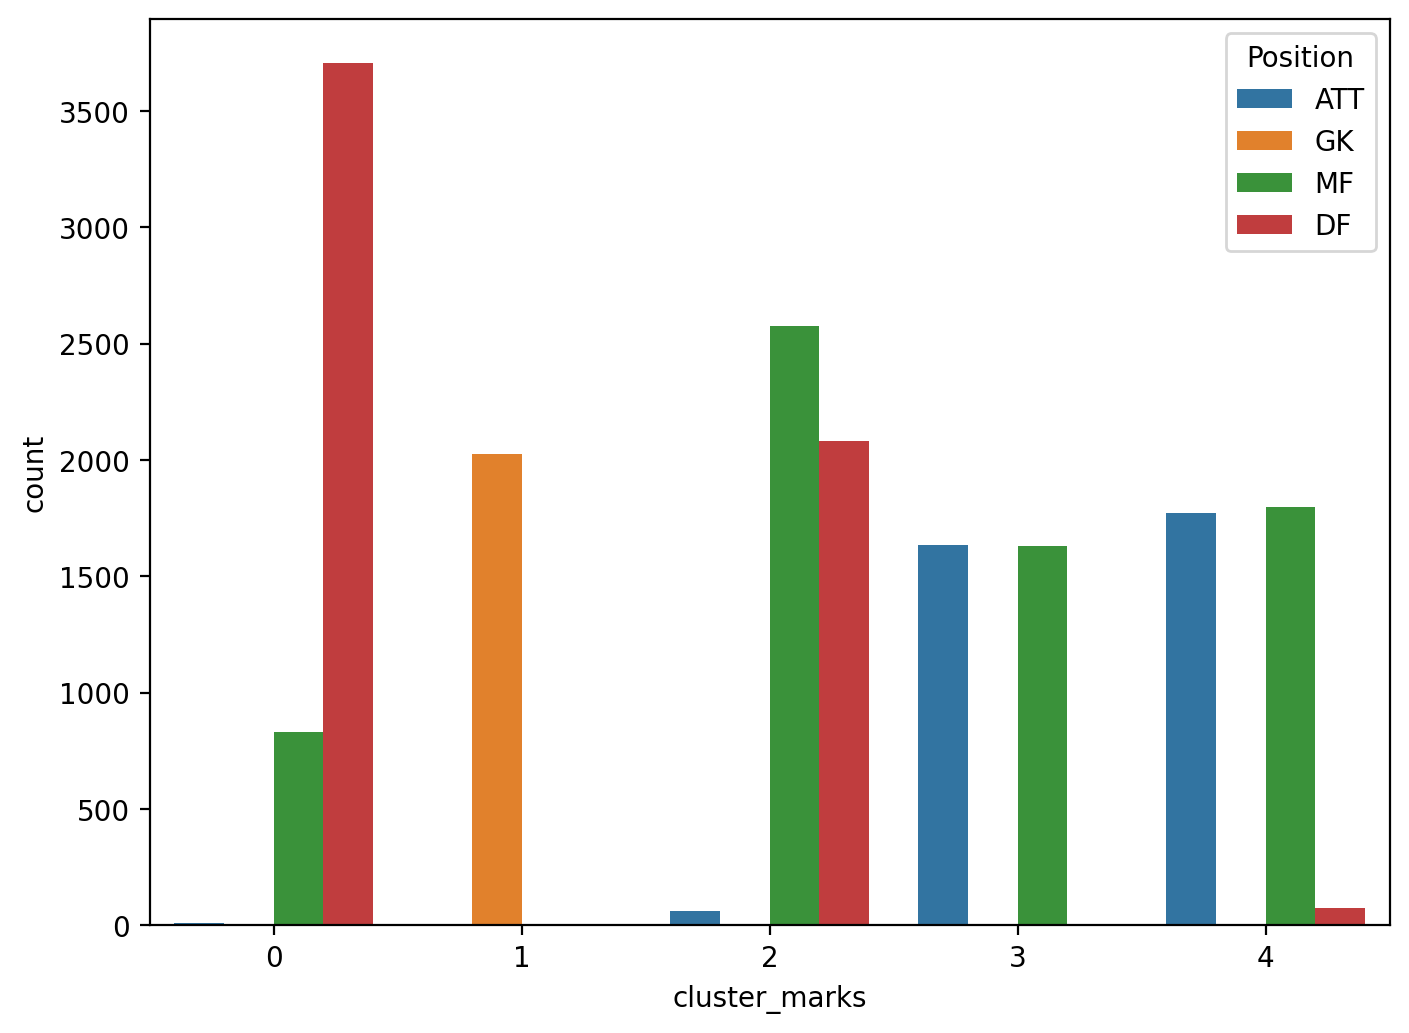

In [470]:
temp1(df)

In [680]:
# Dribbling

temp(df, 'Dribbling')

GK, srednja vrednost Dribbling:  0.10598168060533653
GK, medijan vrednost Dribbling:  0.09677419354838711

NAPAD:
RF, srednja vrednost Dribbling:  0.7412634408602151
RF, medijan vrednost Dribbling:  0.6989247311827957

CF, srednja vrednost Dribbling:  0.695437372856728
CF, medijan vrednost Dribbling:  0.6881720430107527

LF, srednja vrednost Dribbling:  0.7813620071684588
LF, medijan vrednost Dribbling:  0.7634408602150539

RS, srednja vrednost Dribbling:  0.6742941893108748
RS, medijan vrednost Dribbling:  0.6881720430107527

ST, srednja vrednost Dribbling:  0.6286327170909239
ST, medijan vrednost Dribbling:  0.6344086021505377

LS, srednja vrednost Dribbling:  0.6855228299828582
LS, medijan vrednost Dribbling:  0.6881720430107527

LW, srednja vrednost Dribbling:  0.7074478593401633
LW, medijan vrednost Dribbling:  0.7096774193548389

RW, srednja vrednost Dribbling:  0.7097936646323744
RW, medijan vrednost Dribbling:  0.7096774193548389

VEZNI RED:
RDM, srednja vrednost Dribbling:  0.

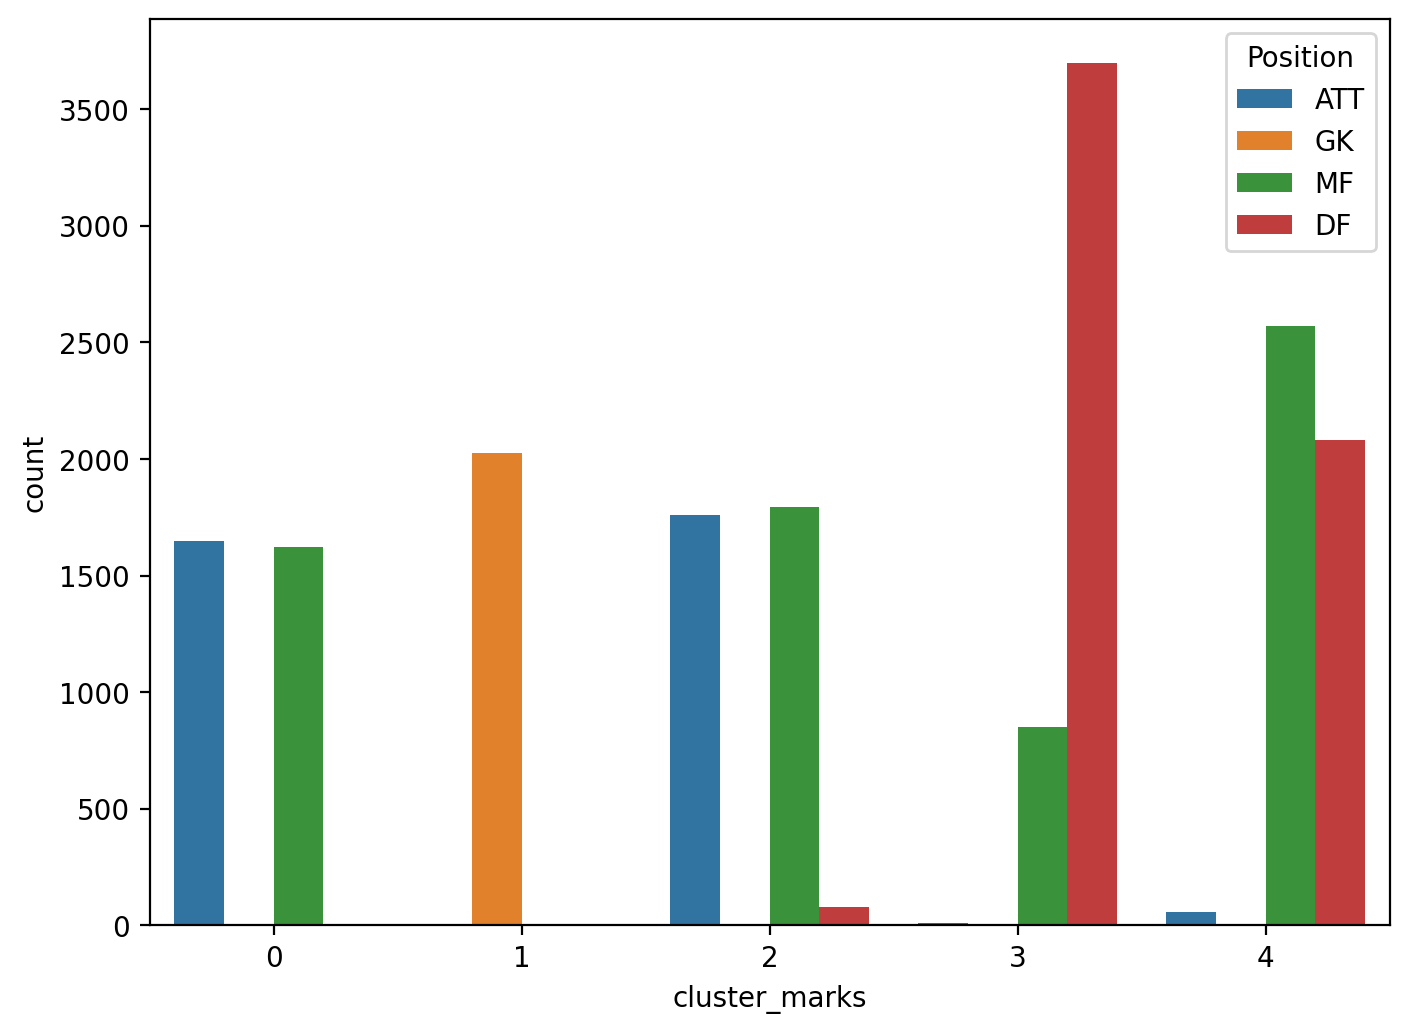

In [472]:
temp1(df)

In [473]:
temp(df, 'SprintSpeed')

GK, srednja vrednost SprintSpeed:  0.3180011757789535
GK, medijan vrednost SprintSpeed:  0.3333333333333333

NAPAD:
RF, srednja vrednost SprintSpeed:  0.7328869047619048
RF, medijan vrednost SprintSpeed:  0.75

CF, srednja vrednost SprintSpeed:  0.7125160875160875
CF, medijan vrednost SprintSpeed:  0.726190476190476

LF, srednja vrednost SprintSpeed:  0.7507936507936507
LF, medijan vrednost SprintSpeed:  0.7380952380952381

RS, srednja vrednost SprintSpeed:  0.7300609899132066
RS, medijan vrednost SprintSpeed:  0.7380952380952381

ST, srednja vrednost SprintSpeed:  0.6842810558884052
ST, medijan vrednost SprintSpeed:  0.6904761904761905

LS, srednja vrednost SprintSpeed:  0.7254428341384861
LS, medijan vrednost SprintSpeed:  0.75

LW, srednja vrednost SprintSpeed:  0.7704974378202726
LW, medijan vrednost SprintSpeed:  0.7619047619047619

RW, srednja vrednost SprintSpeed:  0.774163449163449
RW, medijan vrednost SprintSpeed:  0.7738095238095237

VEZNI RED:
RDM, srednja vrednost SprintSpe

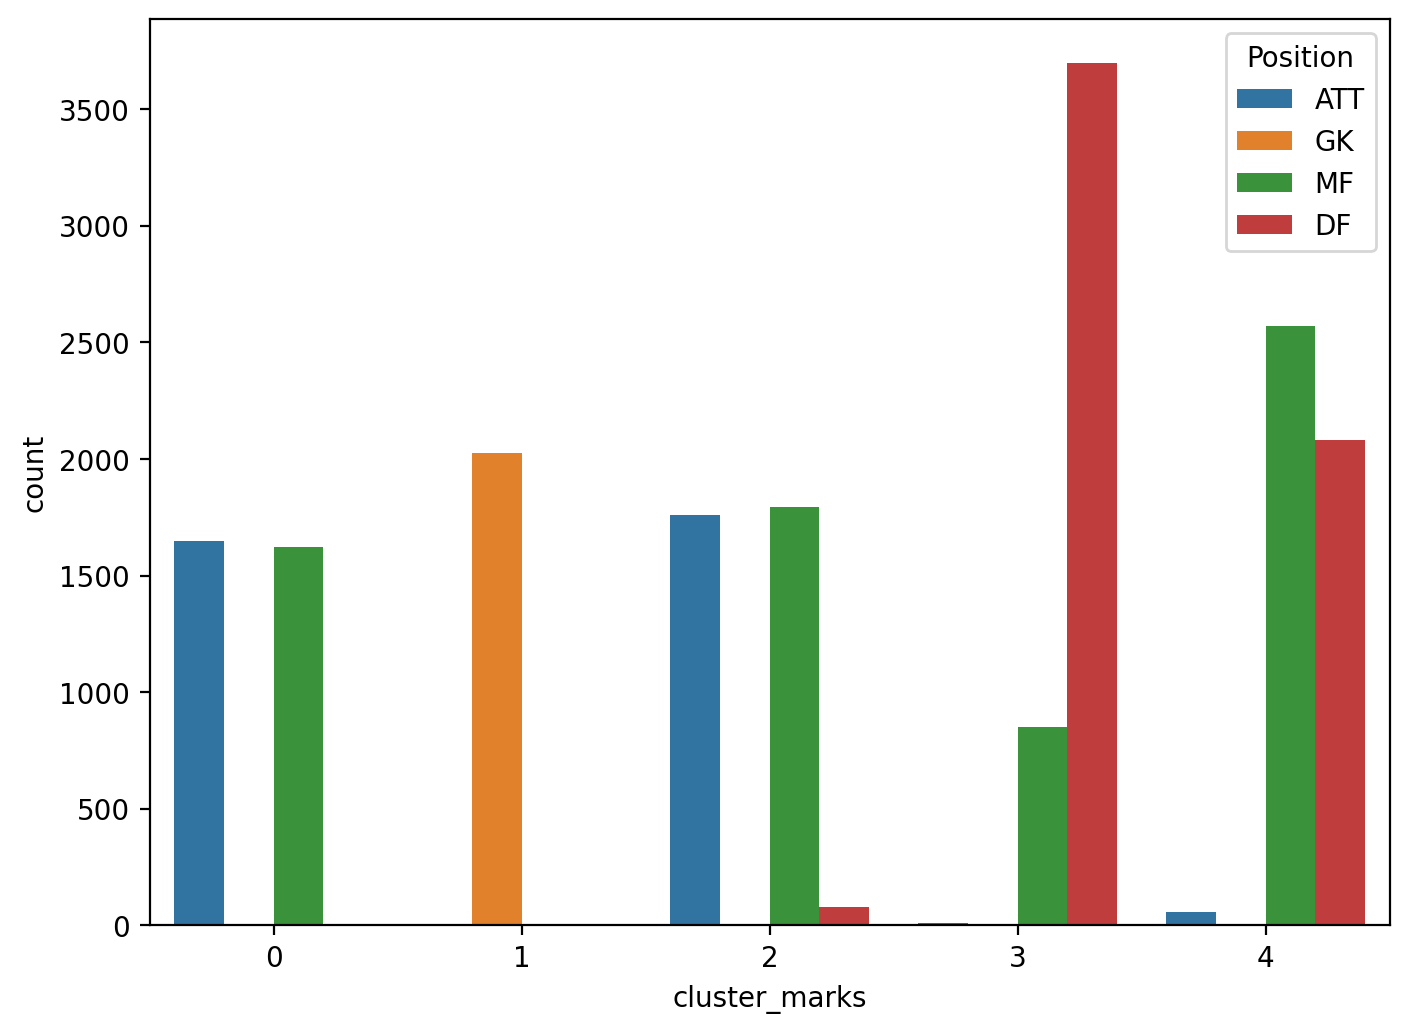

In [681]:
temp1(df)

In [682]:
temp(df, 'Agility')

GK, srednja vrednost Agility:  0.3195302619692864
GK, medijan vrednost Agility:  0.29268292682926833

NAPAD:
RF, srednja vrednost Agility:  0.7629573170731707
RF, medijan vrednost Agility:  0.75

CF, srednja vrednost Agility:  0.7391232696110744
CF, medijan vrednost Agility:  0.75

LF, srednja vrednost Agility:  0.8016260162601628
LF, medijan vrednost Agility:  0.7804878048780488

RS, srednja vrednost Agility:  0.6850895109936322
RS, medijan vrednost Agility:  0.6951219512195121

ST, srednja vrednost Agility:  0.6351341526115164
ST, medijan vrednost Agility:  0.6463414634146342

LS, srednja vrednost Agility:  0.6815718157181571
LS, medijan vrednost Agility:  0.6951219512195121

LW, srednja vrednost Agility:  0.7565136674988797
LW, medijan vrednost Agility:  0.7682926829268293

RW, srednja vrednost Agility:  0.7544825313117995
RW, medijan vrednost Agility:  0.7682926829268293

VEZNI RED:
RDM, srednja vrednost Agility:  0.63286782061369
RDM, medijan vrednost Agility:  0.6402439024390244


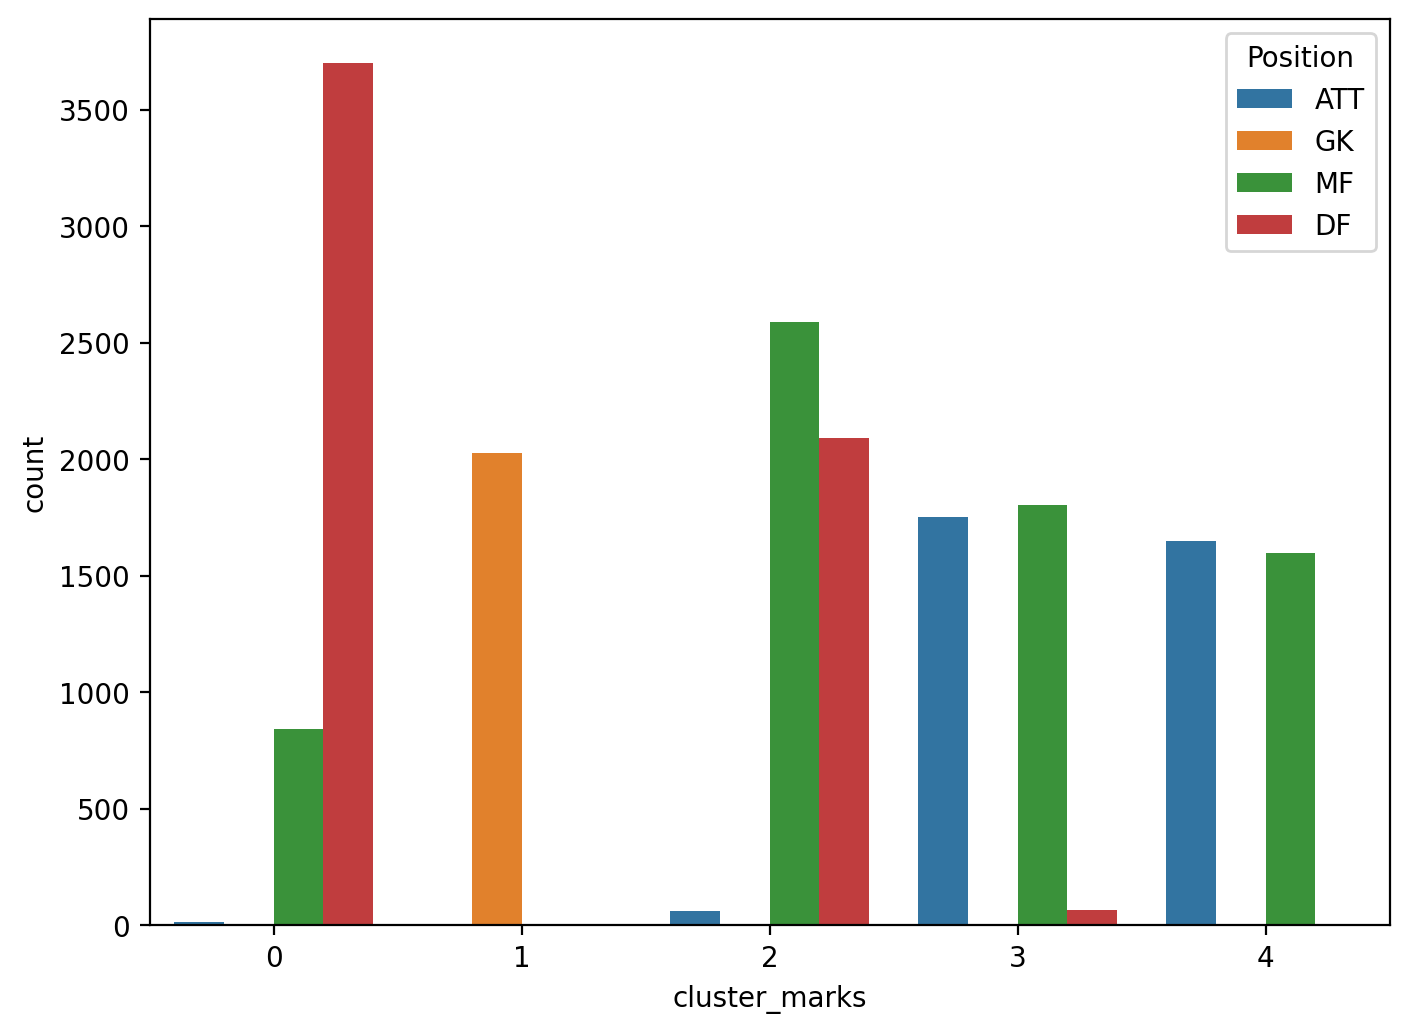

In [476]:
temp1(df)

In [477]:
temp(df, 'Skill Moves')

GK, srednja vrednost Skill Moves:  0.0
GK, medijan vrednost Skill Moves:  0.0

NAPAD:
RF, srednja vrednost Skill Moves:  0.578125
RF, medijan vrednost Skill Moves:  0.5

CF, srednja vrednost Skill Moves:  0.4831081081081081
CF, medijan vrednost Skill Moves:  0.5

LF, srednja vrednost Skill Moves:  0.6
LF, medijan vrednost Skill Moves:  0.5

RS, srednja vrednost Skill Moves:  0.44950738916256155
RS, medijan vrednost Skill Moves:  0.5

ST, srednja vrednost Skill Moves:  0.38498449426091225
ST, medijan vrednost Skill Moves:  0.34032711052370723

LS, srednja vrednost Skill Moves:  0.4553140096618358
LS, medijan vrednost Skill Moves:  0.5

LW, srednja vrednost Skill Moves:  0.5111548556430446
LW, medijan vrednost Skill Moves:  0.5

RW, srednja vrednost Skill Moves:  0.5027027027027027
RW, medijan vrednost Skill Moves:  0.5

VEZNI RED:
RDM, srednja vrednost Skill Moves:  0.39314516129032256
RDM, medijan vrednost Skill Moves:  0.5

CDM, srednja vrednost Skill Moves:  0.3314873417721519
CDM, m

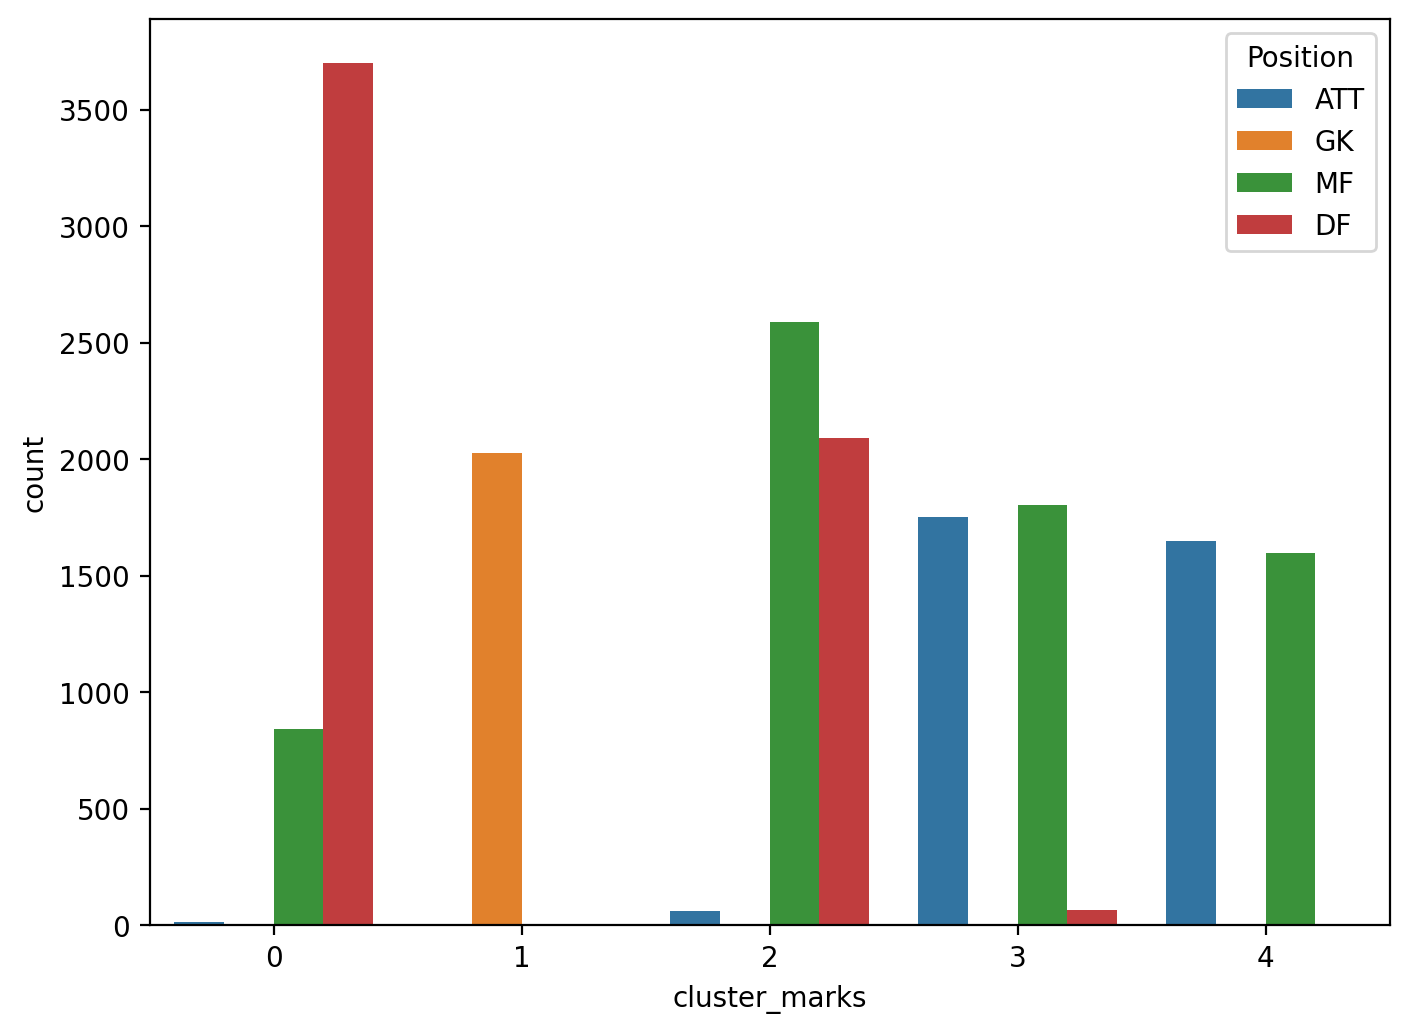

In [684]:
temp1(df)

In [479]:
temp(df, 'FKAccuracy')

GK, srednja vrednost FKAccuracy:  0.12598019264685933
GK, medijan vrednost FKAccuracy:  0.10989010989010992

NAPAD:
RF, srednja vrednost FKAccuracy:  0.6655219780219781
RF, medijan vrednost FKAccuracy:  0.6923076923076924

CF, srednja vrednost FKAccuracy:  0.5472230472230473
CF, medijan vrednost FKAccuracy:  0.5274725274725275

LF, srednja vrednost FKAccuracy:  0.6417582417582417
LF, medijan vrednost FKAccuracy:  0.6263736263736265

RS, srednja vrednost FKAccuracy:  0.5033291831321388
RS, medijan vrednost FKAccuracy:  0.4835164835164836

ST, srednja vrednost FKAccuracy:  0.4474267797843542
ST, medijan vrednost FKAccuracy:  0.4175824175824176

LS, srednja vrednost FKAccuracy:  0.508998248128683
LS, medijan vrednost FKAccuracy:  0.4945054945054945

LW, srednja vrednost FKAccuracy:  0.532058492688414
LW, medijan vrednost FKAccuracy:  0.5164835164835165

RW, srednja vrednost FKAccuracy:  0.5353133353133354
RW, medijan vrednost FKAccuracy:  0.5054945054945056

VEZNI RED:
RDM, srednja vredno

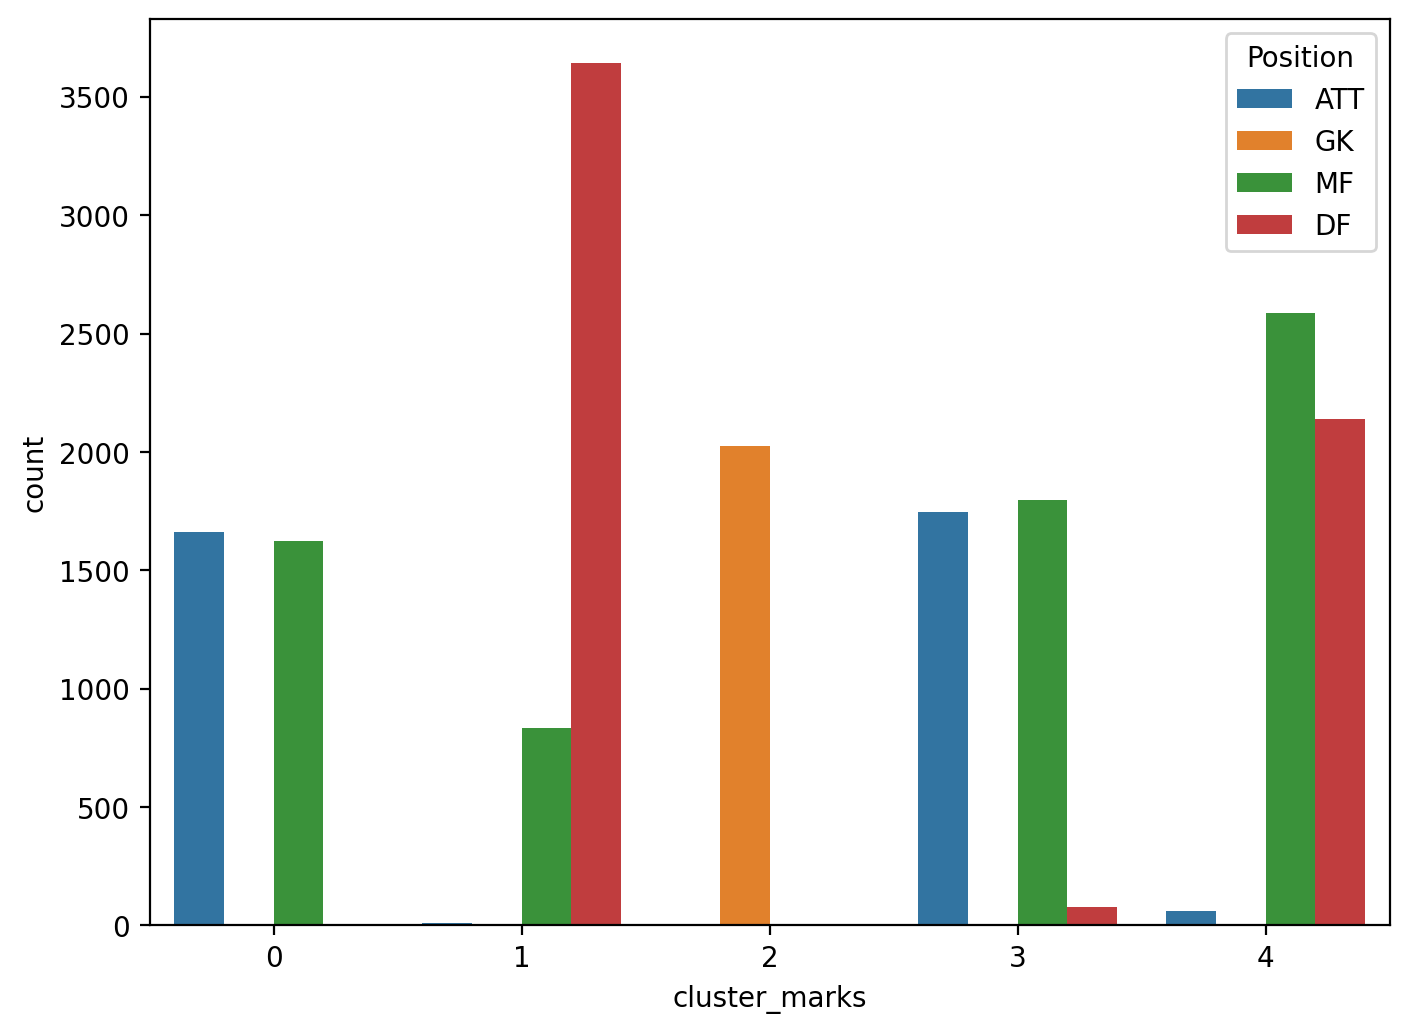

In [480]:
temp1(df)

In [481]:
temp(df, 'FKAccuracy')

GK, srednja vrednost FKAccuracy:  0.12598019264685933
GK, medijan vrednost FKAccuracy:  0.10989010989010992

NAPAD:
RF, srednja vrednost FKAccuracy:  0.6655219780219781
RF, medijan vrednost FKAccuracy:  0.6923076923076924

CF, srednja vrednost FKAccuracy:  0.5472230472230473
CF, medijan vrednost FKAccuracy:  0.5274725274725275

LF, srednja vrednost FKAccuracy:  0.6417582417582417
LF, medijan vrednost FKAccuracy:  0.6263736263736265

RS, srednja vrednost FKAccuracy:  0.5033291831321388
RS, medijan vrednost FKAccuracy:  0.4835164835164836

ST, srednja vrednost FKAccuracy:  0.4474267797843542
ST, medijan vrednost FKAccuracy:  0.4175824175824176

LS, srednja vrednost FKAccuracy:  0.508998248128683
LS, medijan vrednost FKAccuracy:  0.4945054945054945

LW, srednja vrednost FKAccuracy:  0.532058492688414
LW, medijan vrednost FKAccuracy:  0.5164835164835165

RW, srednja vrednost FKAccuracy:  0.5353133353133354
RW, medijan vrednost FKAccuracy:  0.5054945054945056

VEZNI RED:
RDM, srednja vredno

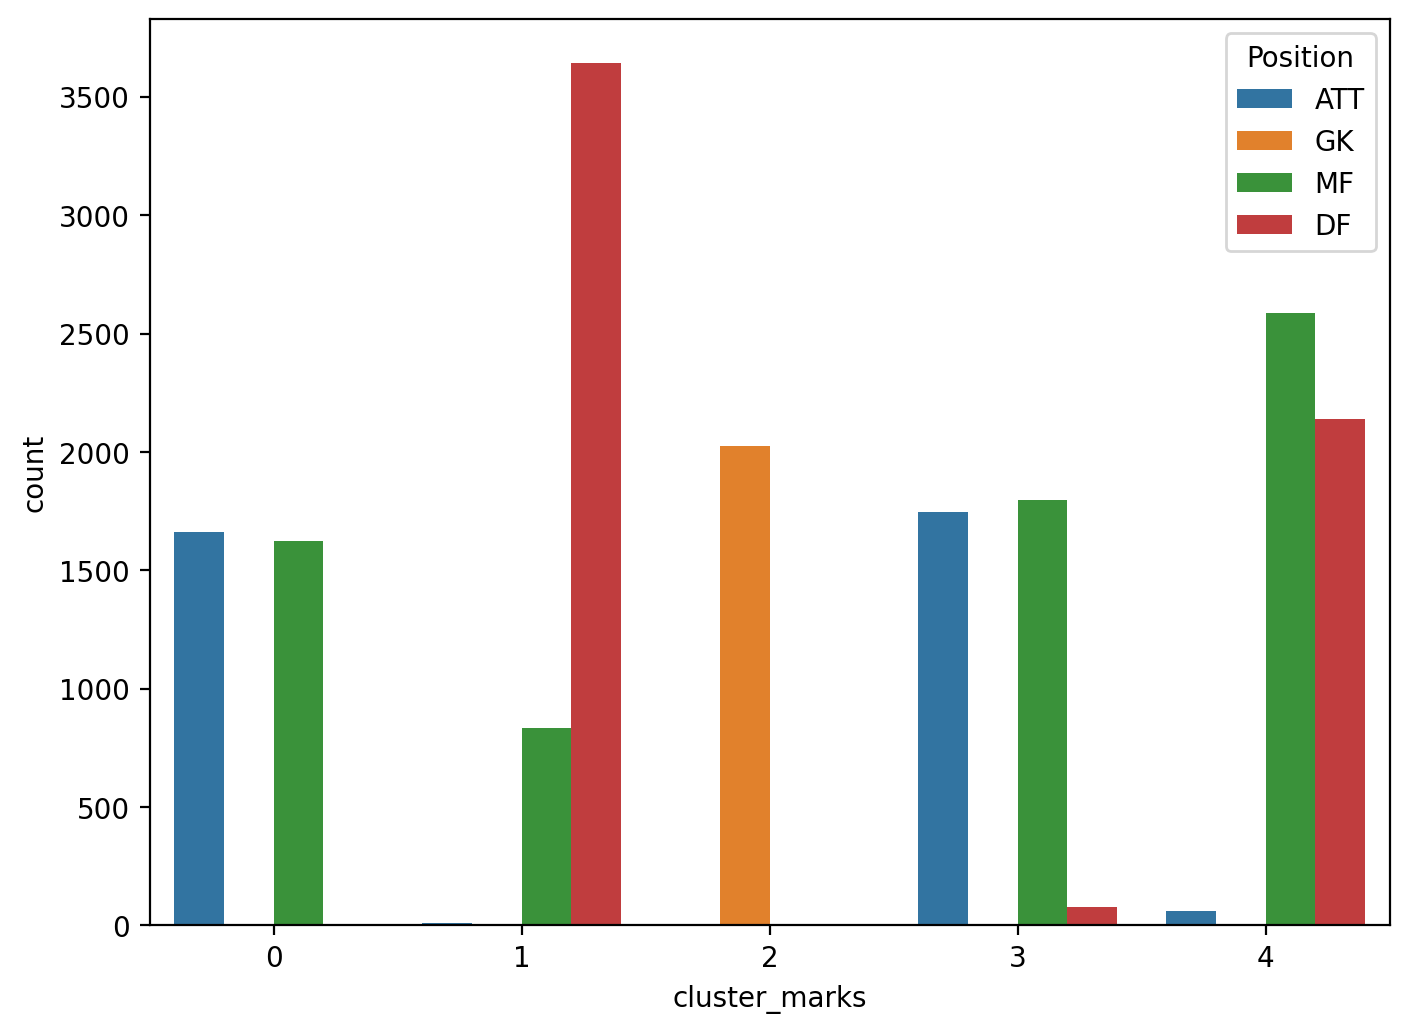

In [482]:
temp1(df)

In [483]:
temp(df, 'LongPassing')

GK, srednja vrednost LongPassing:  0.2000999412110523
GK, medijan vrednost LongPassing:  0.17857142857142855

NAPAD:
RF, srednja vrednost LongPassing:  0.6614583333333333
RF, medijan vrednost LongPassing:  0.6845238095238095

CF, srednja vrednost LongPassing:  0.5381274131274131
CF, medijan vrednost LongPassing:  0.5476190476190477

LF, srednja vrednost LongPassing:  0.7111111111111111
LF, medijan vrednost LongPassing:  0.7023809523809524

RS, srednja vrednost LongPassing:  0.4822894675111424
RS, medijan vrednost LongPassing:  0.4880952380952381

ST, srednja vrednost LongPassing:  0.4252355808515921
ST, medijan vrednost LongPassing:  0.4166666666666666

LS, srednja vrednost LongPassing:  0.5025879917184265
LS, medijan vrednost LongPassing:  0.511904761904762

LW, srednja vrednost LongPassing:  0.5441507311586051
LW, medijan vrednost LongPassing:  0.5595238095238095

RW, srednja vrednost LongPassing:  0.5526061776061776
RW, medijan vrednost LongPassing:  0.5595238095238095

VEZNI RED:
R

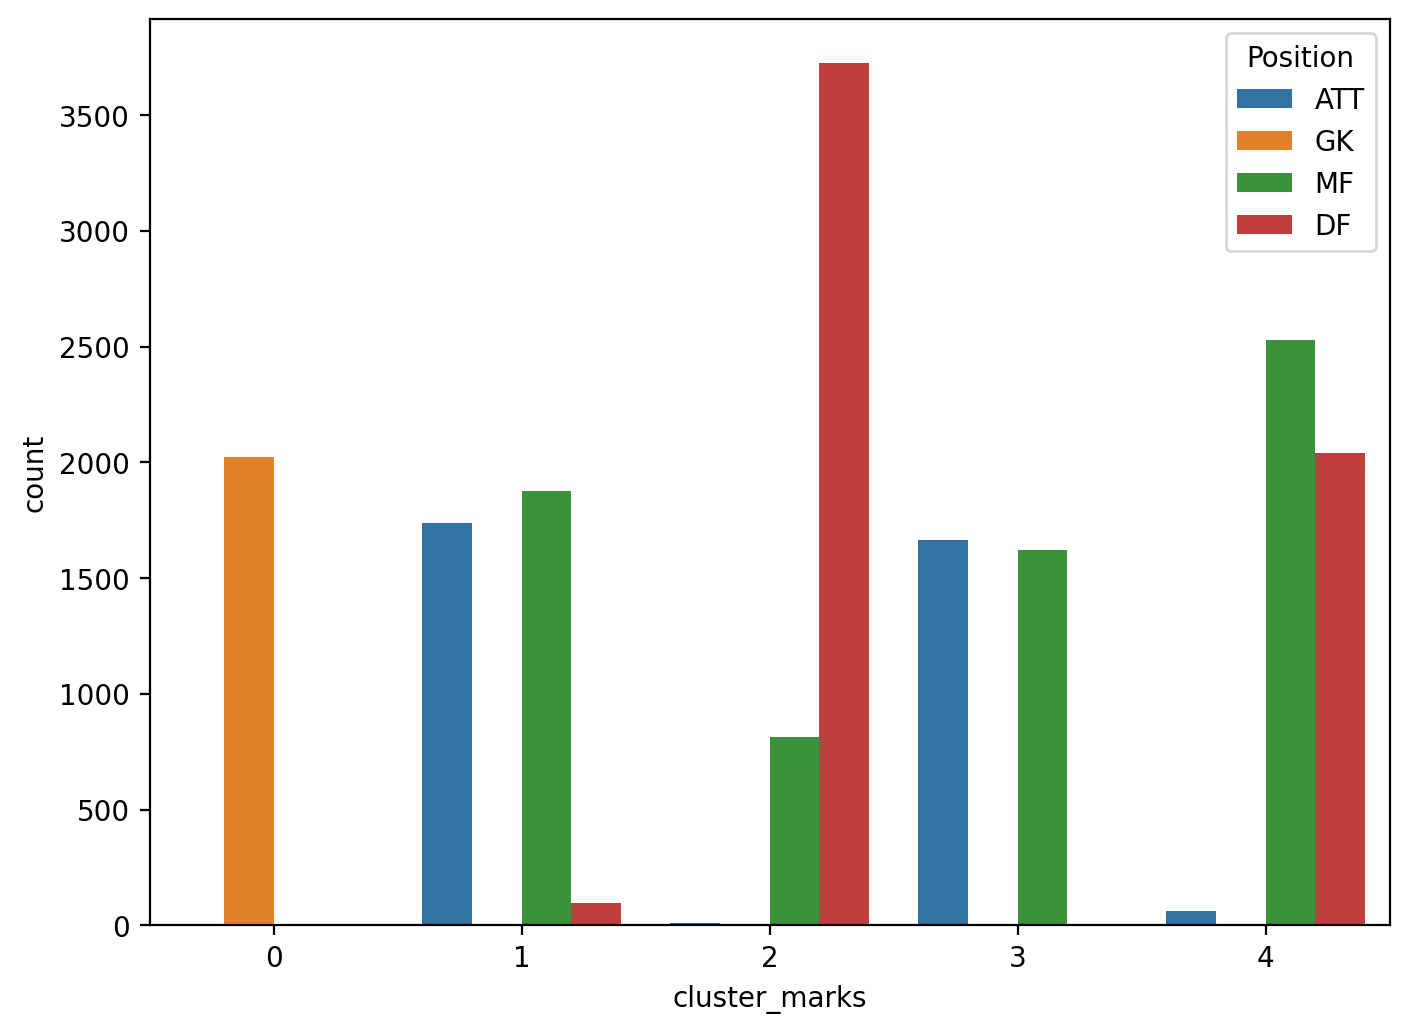

In [484]:
temp1(df)

In [485]:
temp(df, 'Crossing')

GK, srednja vrednost Crossing:  0.10519640852974185
GK, medijan vrednost Crossing:  0.09090909090909091

NAPAD:
RF, srednja vrednost Crossing:  0.7215909090909091
RF, medijan vrednost Crossing:  0.7045454545454545

CF, srednja vrednost Crossing:  0.5658783783783784
CF, medijan vrednost Crossing:  0.5681818181818181

LF, srednja vrednost Crossing:  0.7106060606060608
LF, medijan vrednost Crossing:  0.6818181818181819

RS, srednja vrednost Crossing:  0.5361621137483207
RS, medijan vrednost Crossing:  0.5568181818181819

ST, srednja vrednost Crossing:  0.46838649056328807
ST, medijan vrednost Crossing:  0.4659090909090909

LS, srednja vrednost Crossing:  0.550175669740887
LS, medijan vrednost Crossing:  0.5681818181818181

LW, srednja vrednost Crossing:  0.6406585540443808
LW, medijan vrednost Crossing:  0.6477272727272727

RW, srednja vrednost Crossing:  0.6489250614250615
RW, medijan vrednost Crossing:  0.6590909090909092

VEZNI RED:
RDM, srednja vrednost Crossing:  0.5858687683284458
R

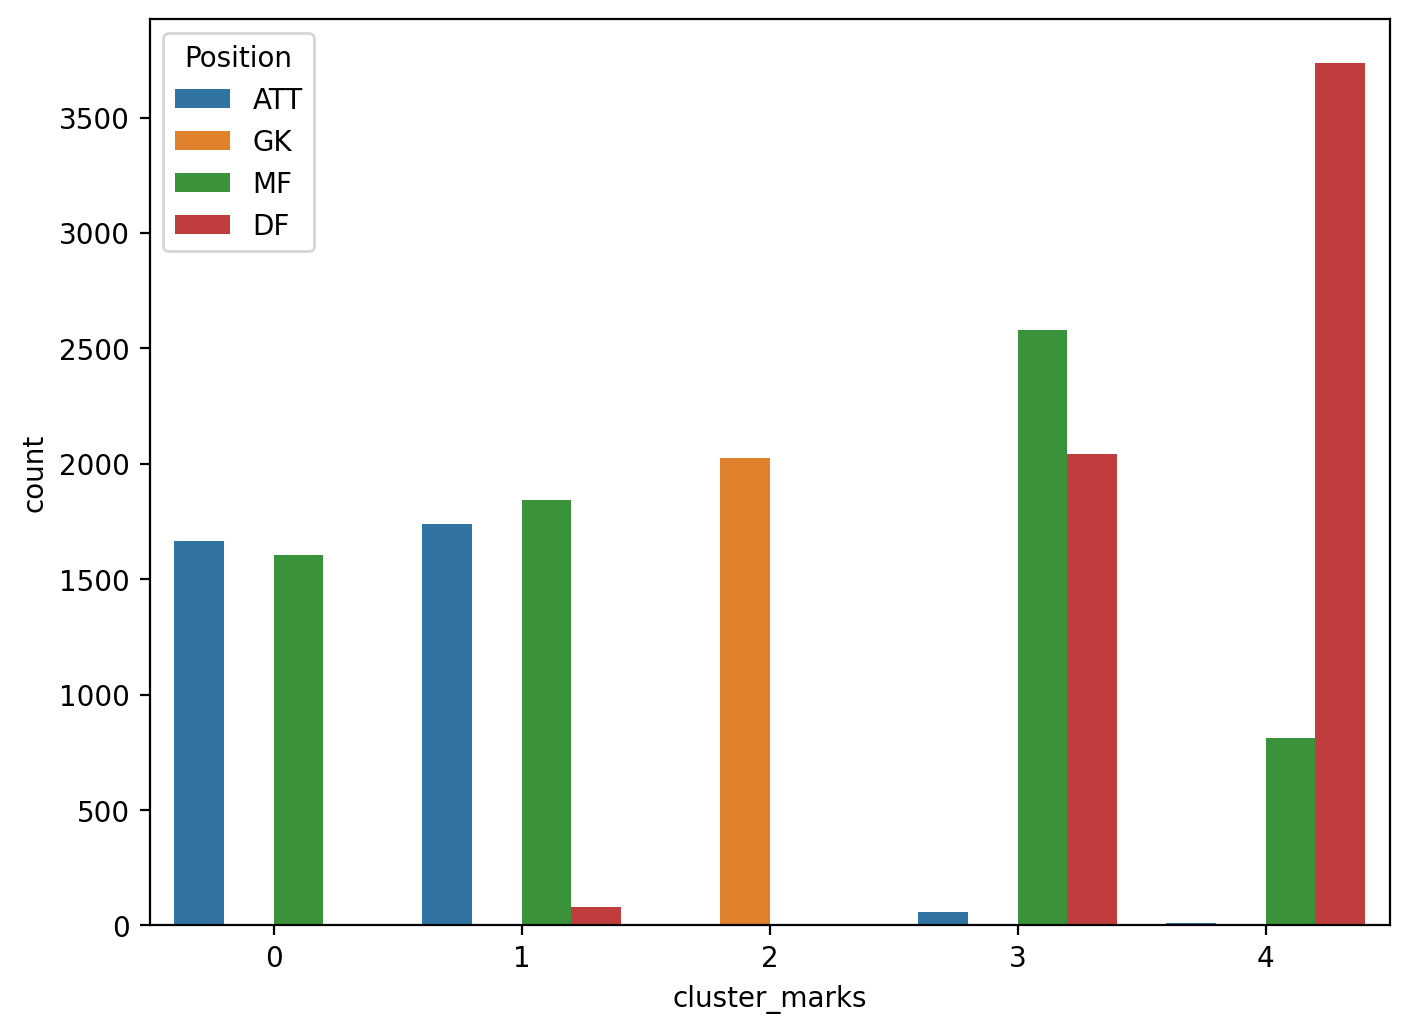

In [486]:
temp1(df)

In [487]:
temp(df, 'Finishing')

GK, srednja vrednost Finishing:  0.10770211071286338
GK, medijan vrednost Finishing:  0.1075268817204301

NAPAD:
RF, srednja vrednost Finishing:  0.7358870967741936
RF, medijan vrednost Finishing:  0.7043010752688172

CF, srednja vrednost Finishing:  0.6732054635280443
CF, medijan vrednost Finishing:  0.6720430107526882

LF, srednja vrednost Finishing:  0.7240143369175628
LF, medijan vrednost Finishing:  0.7204301075268817

RS, srednja vrednost Finishing:  0.7276338789130782
RS, medijan vrednost Finishing:  0.7204301075268817

ST, srednja vrednost Finishing:  0.6866721292796981
ST, medijan vrednost Finishing:  0.6881720430107527

LS, srednja vrednost Finishing:  0.7298841618617214
LS, medijan vrednost Finishing:  0.7204301075268817

LW, srednja vrednost Finishing:  0.6432986199305734
LW, medijan vrednost Finishing:  0.6451612903225807

RW, srednja vrednost Finishing:  0.6489973844812557
RW, medijan vrednost Finishing:  0.6451612903225807

VEZNI RED:
RDM, srednja vrednost Finishing:  0.

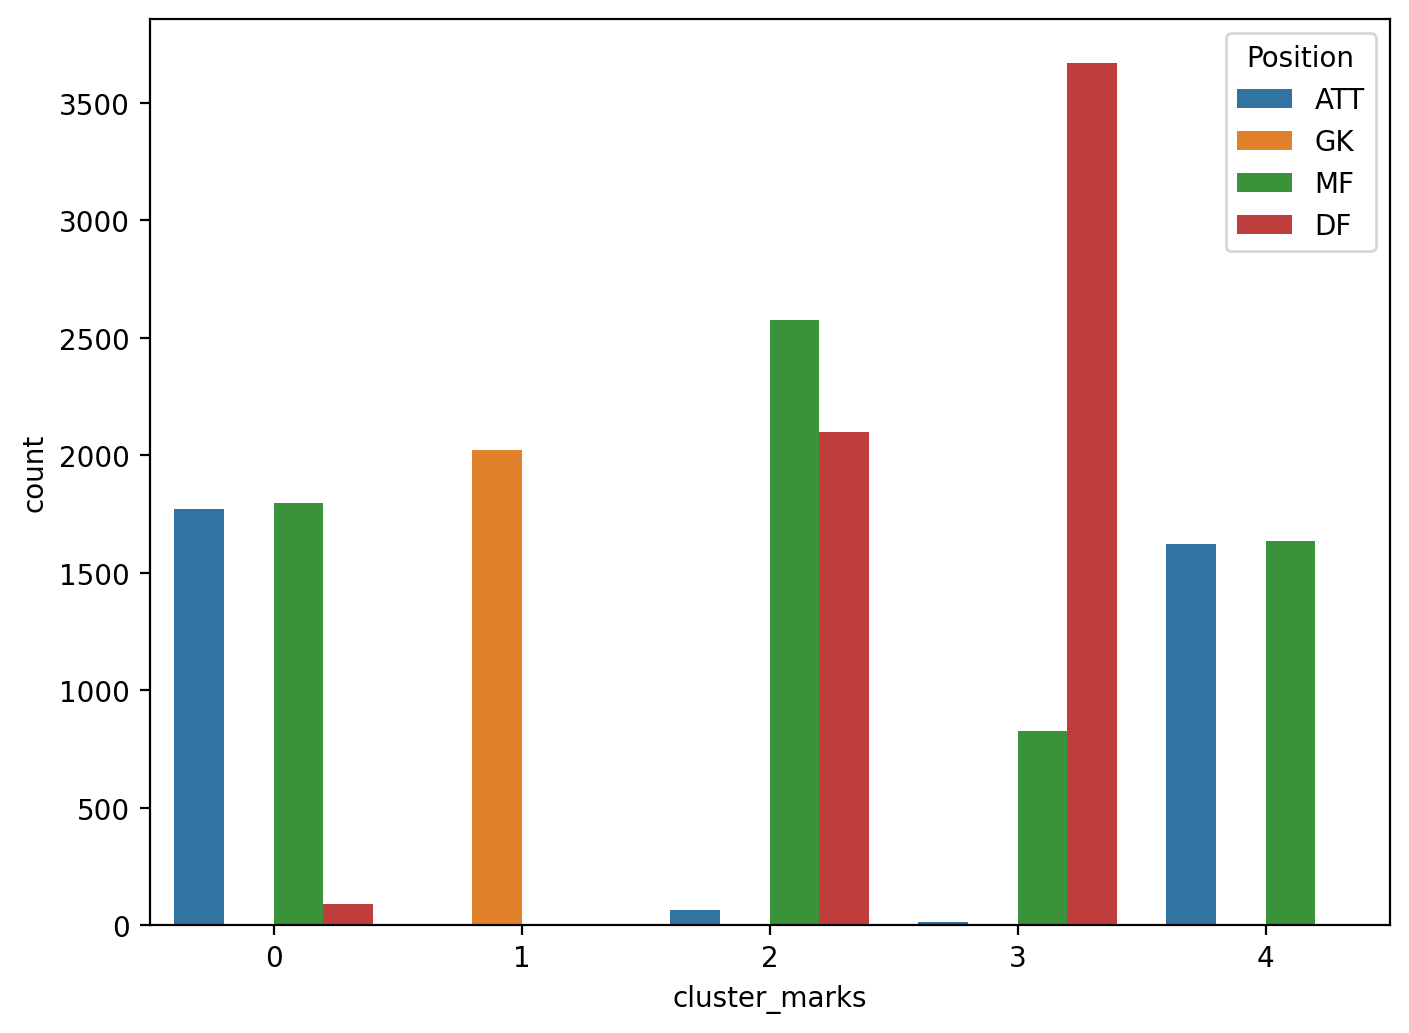

In [488]:
temp1(df)

In [489]:
temp(df, 'HeadingAccuracy')

GK, srednja vrednost HeadingAccuracy:  0.11520987654320987
GK, medijan vrednost HeadingAccuracy:  0.1111111111111111

NAPAD:
RF, srednja vrednost HeadingAccuracy:  0.563888888888889
RF, medijan vrednost HeadingAccuracy:  0.5611111111111112

CF, srednja vrednost HeadingAccuracy:  0.5560060060060061
CF, medijan vrednost HeadingAccuracy:  0.5611111111111111

LF, srednja vrednost HeadingAccuracy:  0.5607407407407409
LF, medijan vrednost HeadingAccuracy:  0.6000000000000001

RS, srednja vrednost HeadingAccuracy:  0.6733990147783252
RS, medijan vrednost HeadingAccuracy:  0.688888888888889

ST, srednja vrednost HeadingAccuracy:  0.6555822328722366
ST, medijan vrednost HeadingAccuracy:  0.6555555555555557

LS, srednja vrednost HeadingAccuracy:  0.6703166935050995
LS, medijan vrednost HeadingAccuracy:  0.6777777777777778

LW, srednja vrednost HeadingAccuracy:  0.504666083406241
LW, medijan vrednost HeadingAccuracy:  0.5000000000000001

RW, srednja vrednost HeadingAccuracy:  0.5020120120120121
R

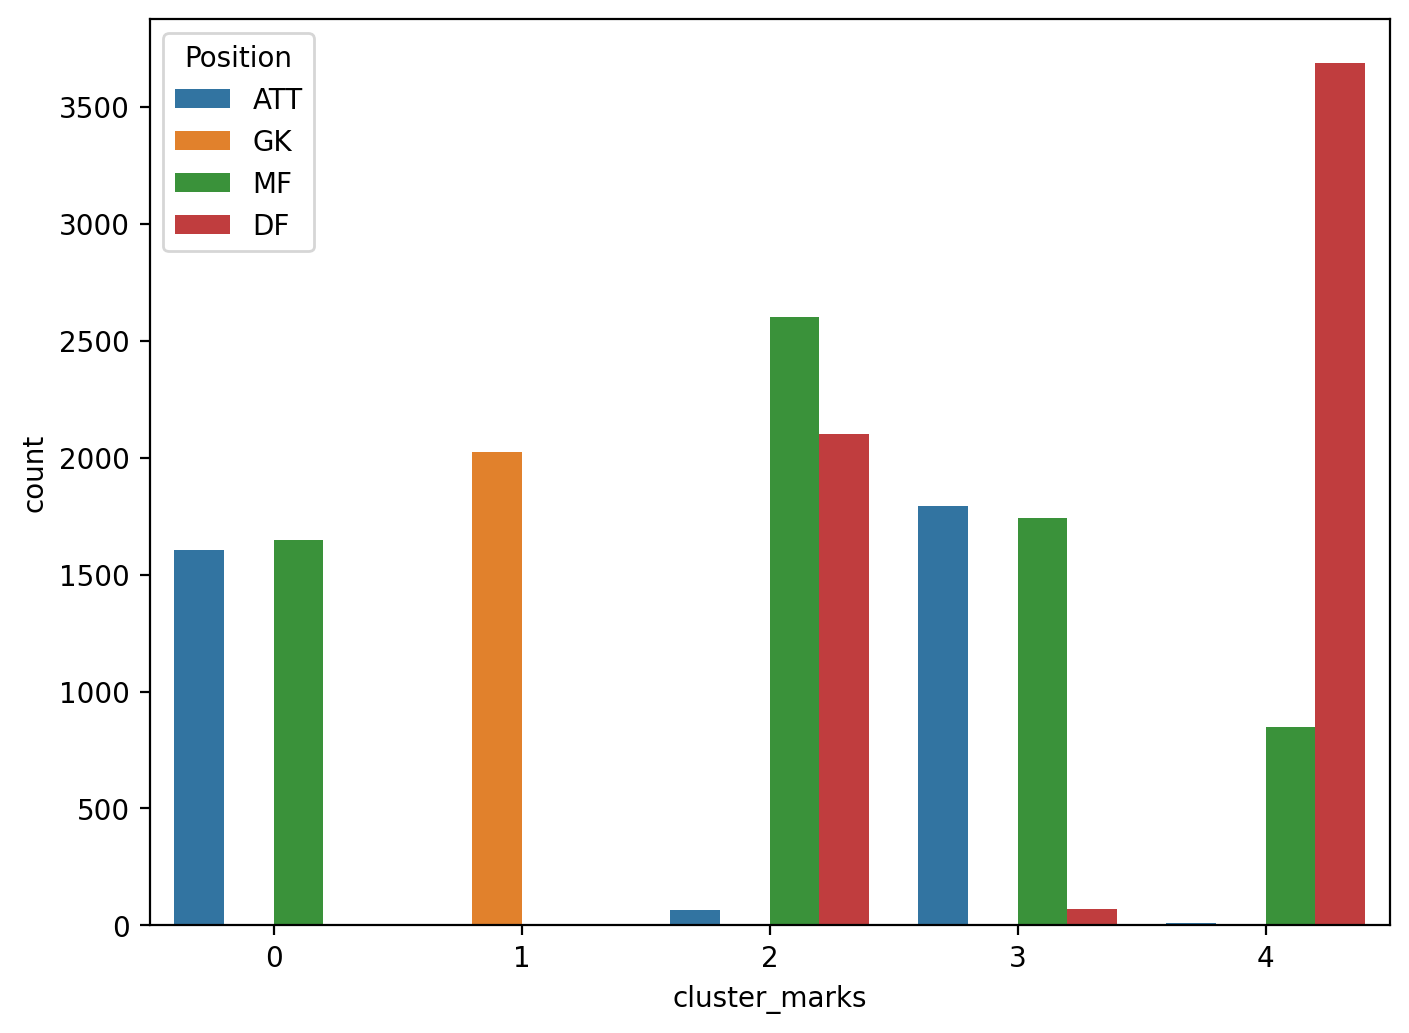

In [490]:
temp1(df)

In [677]:
# Ne cini golmana inferiornim

temp(df, 'Reactions')

GK, srednja vrednost Reactions:  0.5056855967078189
GK, medijan vrednost Reactions:  0.52

NAPAD:
RF, srednja vrednost Reactions:  0.6600000000000001
RF, medijan vrednost Reactions:  0.66

CF, srednja vrednost Reactions:  0.5574774774774774
CF, medijan vrednost Reactions:  0.5466666666666667

LF, srednja vrednost Reactions:  0.6666666666666666
LF, medijan vrednost Reactions:  0.6533333333333333

RS, srednja vrednost Reactions:  0.6005911330049262
RS, medijan vrednost Reactions:  0.6

ST, srednja vrednost Reactions:  0.5424843717744612
ST, medijan vrednost Reactions:  0.544488132606421

LS, srednja vrednost Reactions:  0.6045088566827698
LS, medijan vrednost Reactions:  0.6

LW, srednja vrednost Reactions:  0.5294138232720911
LW, medijan vrednost Reactions:  0.5333333333333333

RW, srednja vrednost Reactions:  0.5343423423423423
RW, medijan vrednost Reactions:  0.5466666666666667

VEZNI RED:
RDM, srednja vrednost Reactions:  0.6112365591397849
RDM, medijan vrednost Reactions:  0.6133333

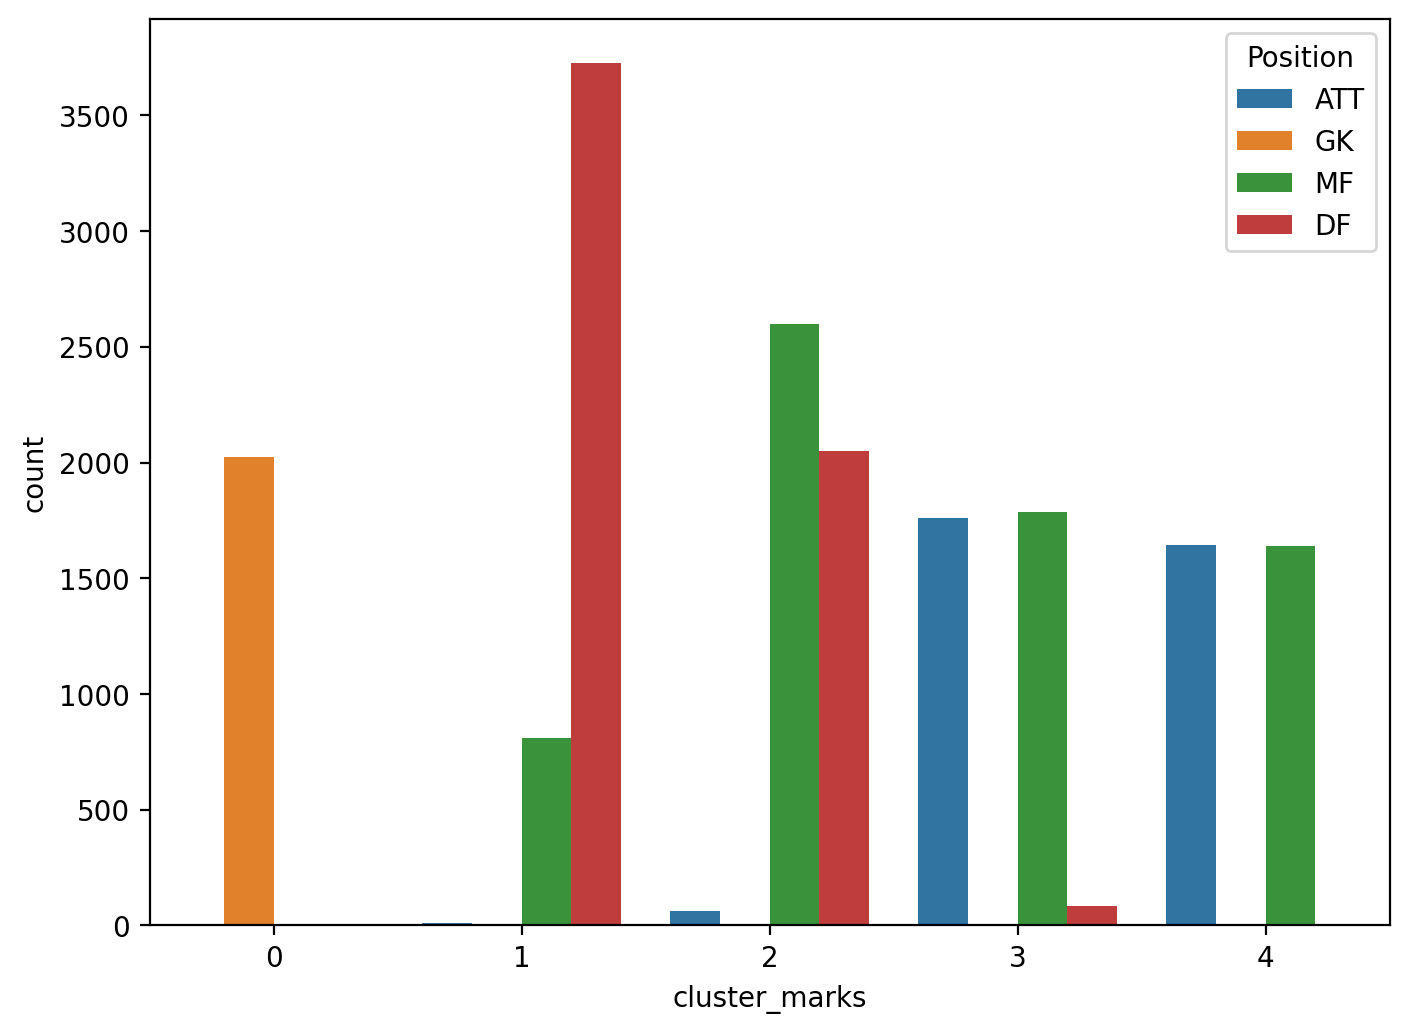

In [492]:
temp1(df)

In [493]:
temp(df, 'LongShots')

GK, srednja vrednost LongShots:  0.1060805860805861
GK, medijan vrednost LongShots:  0.10989010989010992

NAPAD:
RF, srednja vrednost LongShots:  0.742445054945055
RF, medijan vrednost LongShots:  0.7087912087912089

CF, srednja vrednost LongShots:  0.638996138996139
CF, medijan vrednost LongShots:  0.6483516483516484

LF, srednja vrednost LongShots:  0.7443223443223441
LF, medijan vrednost LongShots:  0.7472527472527474

RS, srednja vrednost LongShots:  0.6528446922535592
RS, medijan vrednost LongShots:  0.6703296703296704

ST, srednja vrednost LongShots:  0.6144073222223163
ST, medijan vrednost LongShots:  0.6153846153846154

LS, srednja vrednost LongShots:  0.6647555343207517
LS, medijan vrednost LongShots:  0.6703296703296704

LW, srednja vrednost LongShots:  0.6176343341697673
LW, medijan vrednost LongShots:  0.6153846153846154

RW, srednja vrednost LongShots:  0.6123552123552125
RW, medijan vrednost LongShots:  0.6153846153846154

VEZNI RED:
RDM, srednja vrednost LongShots:  0.61

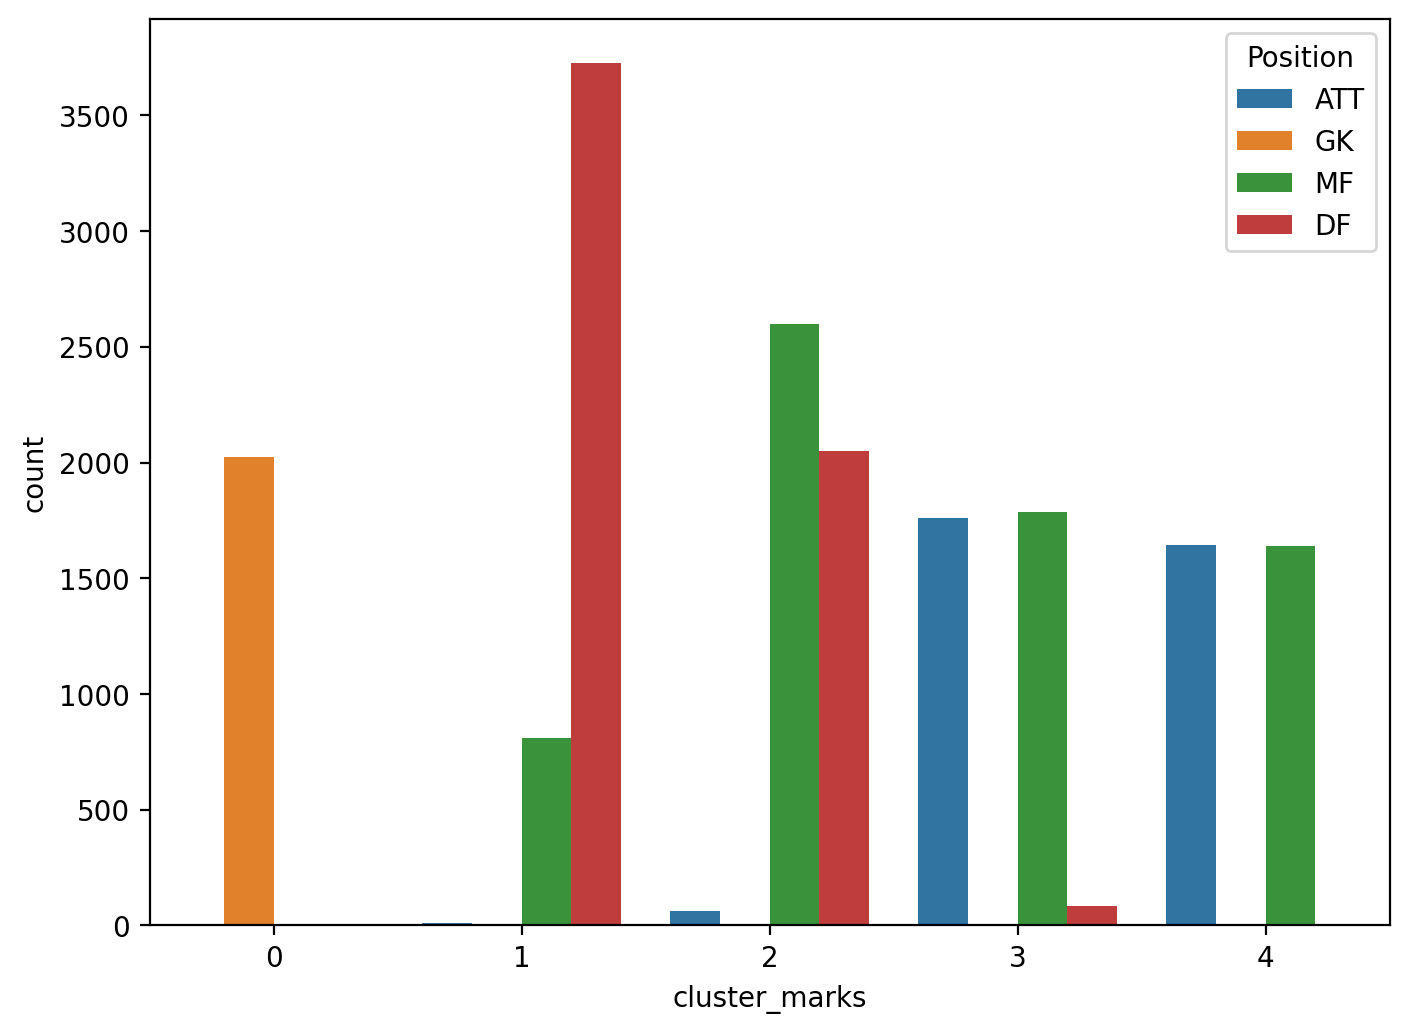

In [678]:
temp1(df)

In [679]:
temp(df, 'BallControl')

GK, srednja vrednost BallControl:  0.1642816442816443
GK, medijan vrednost BallControl:  0.16483516483516486

NAPAD:
RF, srednja vrednost BallControl:  0.7561813186813188
RF, medijan vrednost BallControl:  0.7197802197802199

CF, srednja vrednost BallControl:  0.6905256905256906
CF, medijan vrednost BallControl:  0.6813186813186813

LF, srednja vrednost BallControl:  0.78021978021978
LF, medijan vrednost BallControl:  0.7582417582417583

RS, srednja vrednost BallControl:  0.6916039625399231
RS, medijan vrednost BallControl:  0.7032967032967034

ST, srednja vrednost BallControl:  0.6423292232984438
ST, medijan vrednost BallControl:  0.6483516483516484

LS, srednja vrednost BallControl:  0.7015979189892233
LS, medijan vrednost BallControl:  0.6923076923076923

LW, srednja vrednost BallControl:  0.6948746791266477
LW, medijan vrednost BallControl:  0.6923076923076923

RW, srednja vrednost BallControl:  0.6942975942975943
RW, medijan vrednost BallControl:  0.6923076923076923

VEZNI RED:
RD

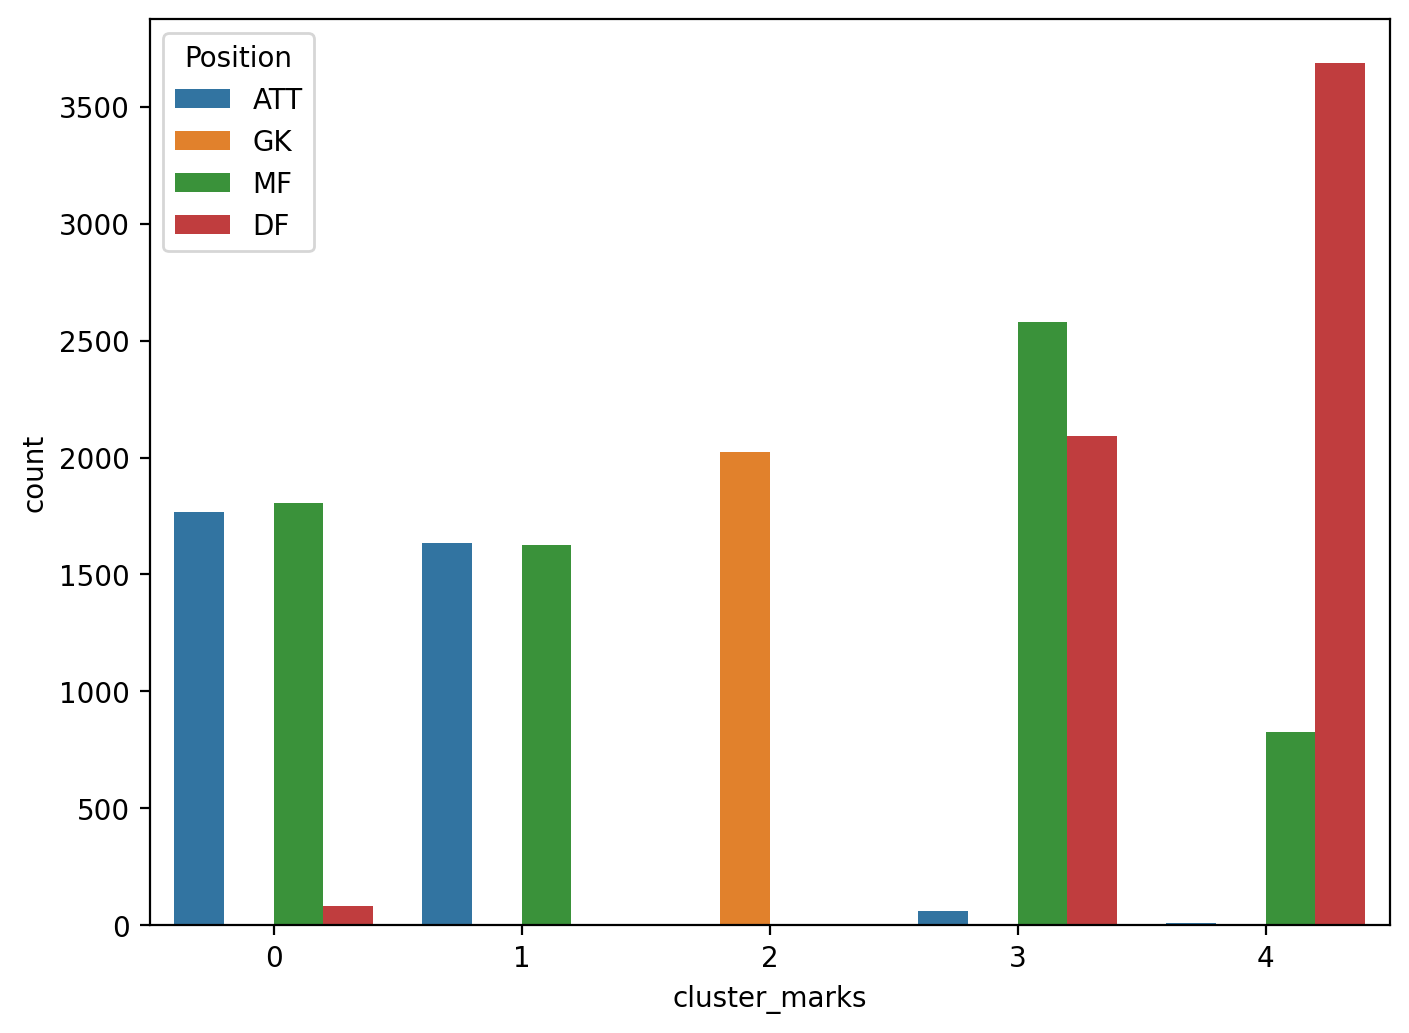

In [496]:
temp1(df)

In [497]:
temp(df, 'ShotPower')

GK, srednja vrednost ShotPower:  0.22078853046594982
GK, medijan vrednost ShotPower:  0.21505376344086022

NAPAD:
RF, srednja vrednost ShotPower:  0.7661290322580646
RF, medijan vrednost ShotPower:  0.7365591397849464

CF, srednja vrednost ShotPower:  0.6697181052019764
CF, medijan vrednost ShotPower:  0.6774193548387097

LF, srednja vrednost ShotPower:  0.7541218637992831
LF, medijan vrednost ShotPower:  0.7311827956989249

RS, srednja vrednost ShotPower:  0.7318184225859423
RS, medijan vrednost ShotPower:  0.7311827956989249

ST, srednja vrednost ShotPower:  0.6837488686988515
ST, medijan vrednost ShotPower:  0.6881720430107527

LS, srednja vrednost ShotPower:  0.7402212872058596
LS, medijan vrednost ShotPower:  0.7311827956989249

LW, srednja vrednost ShotPower:  0.6785200237067142
LW, medijan vrednost ShotPower:  0.6774193548387097

RW, srednja vrednost ShotPower:  0.6836384771868644
RW, medijan vrednost ShotPower:  0.6881720430107527

VEZNI RED:
RDM, srednja vrednost ShotPower:  0

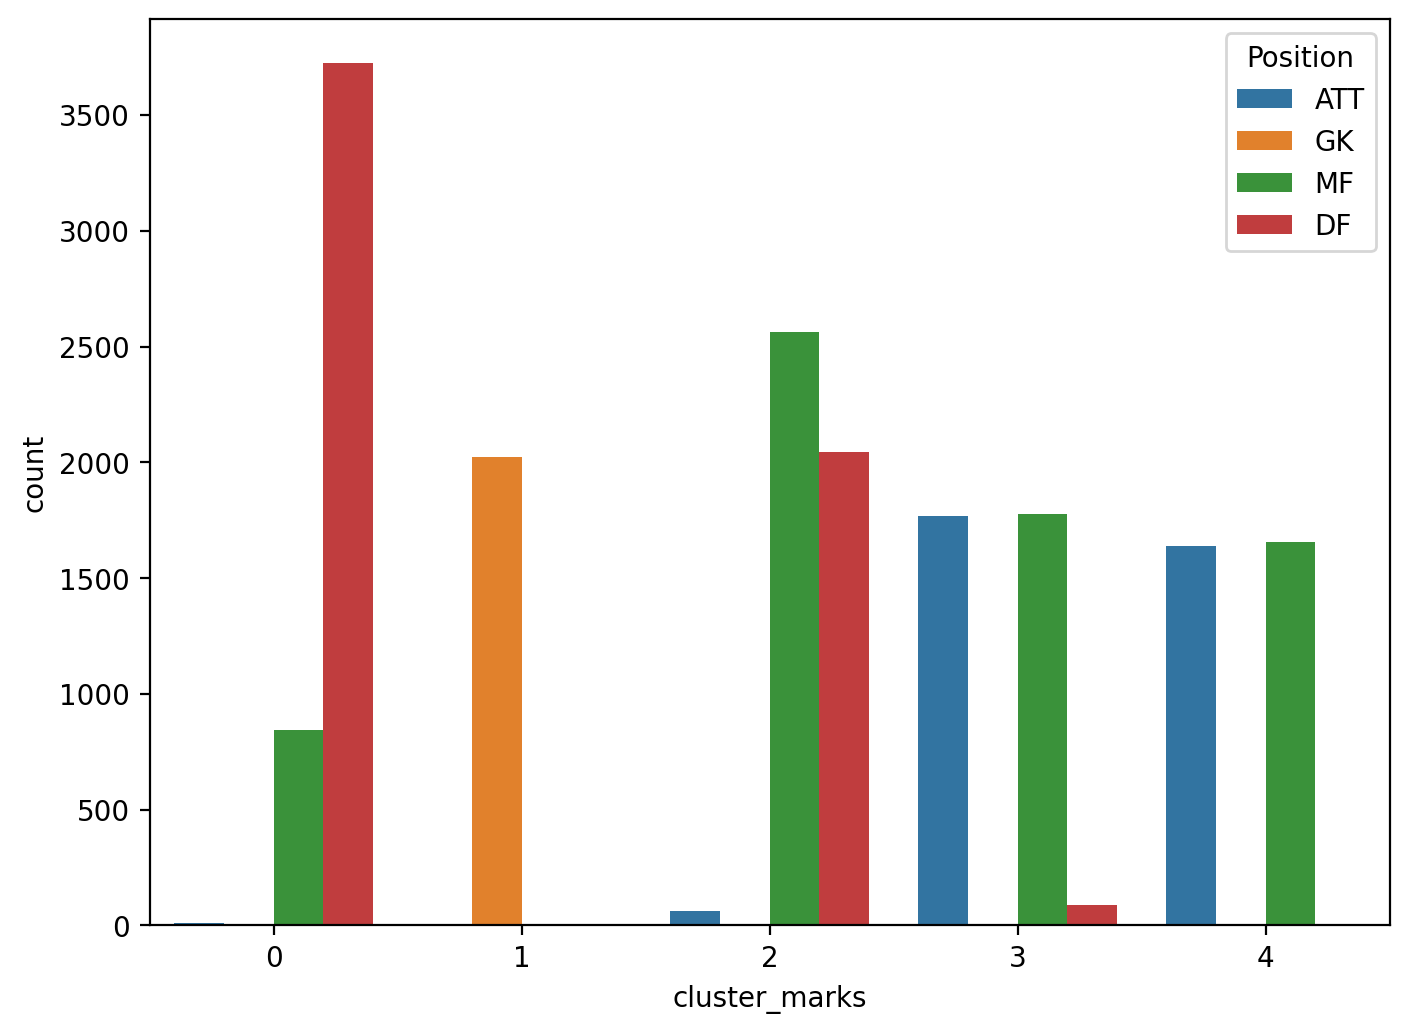

In [498]:
temp1(df)

In [499]:
temp(df, 'Interceptions')

GK, srednja vrednost Interceptions:  0.15789152448328478
GK, medijan vrednost Interceptions:  0.15730337078651685

NAPAD:
RF, srednja vrednost Interceptions:  0.3595505617977528
RF, medijan vrednost Interceptions:  0.3707865168539326

CF, srednja vrednost Interceptions:  0.28515031885818404
CF, medijan vrednost Interceptions:  0.2640449438202247

LF, srednja vrednost Interceptions:  0.4014981273408241
LF, medijan vrednost Interceptions:  0.3370786516853933

RS, srednja vrednost Interceptions:  0.3037028837106327
RS, medijan vrednost Interceptions:  0.2808988764044944

ST, srednja vrednost Interceptions:  0.26432694629988895
ST, medijan vrednost Interceptions:  0.23595505617977527

LS, srednja vrednost Interceptions:  0.30076534766324703
LS, medijan vrednost Interceptions:  0.2921348314606742

LW, srednja vrednost Interceptions:  0.3305317172432098
LW, medijan vrednost Interceptions:  0.3033707865168539

RW, srednja vrednost Interceptions:  0.32900091102338297
RW, medijan vrednost Inter

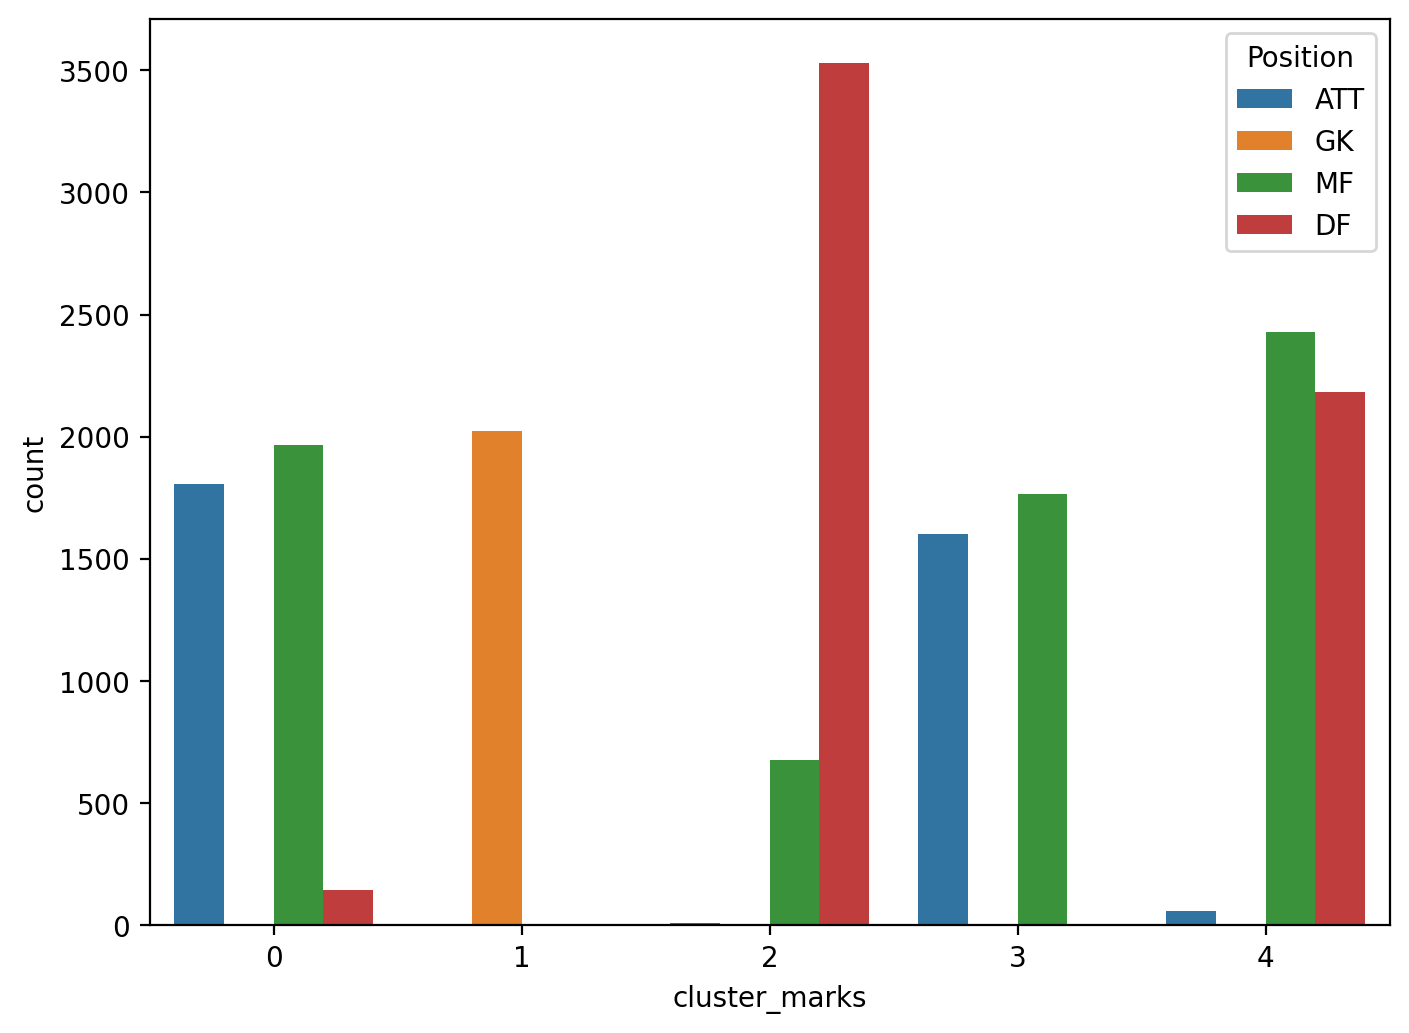

In [500]:
temp1(df)

In [501]:
temp(df, 'Volleys')

GK, srednja vrednost Volleys:  0.09763996554694229
GK, medijan vrednost Volleys:  0.09302325581395349

NAPAD:
RF, srednja vrednost Volleys:  0.7129360465116279
RF, medijan vrednost Volleys:  0.6918604651162791

CF, srednja vrednost Volleys:  0.6379635449402893
CF, medijan vrednost Volleys:  0.627906976744186

LF, srednja vrednost Volleys:  0.7085271317829457
LF, medijan vrednost Volleys:  0.6976744186046512

RS, srednja vrednost Volleys:  0.6751059686103793
RS, medijan vrednost Volleys:  0.686046511627907

ST, srednja vrednost Volleys:  0.6167502483268632
ST, medijan vrednost Volleys:  0.627906976744186

LS, srednja vrednost Volleys:  0.6873385012919896
LS, medijan vrednost Volleys:  0.686046511627907

LW, srednja vrednost Volleys:  0.5973570164194593
LW, medijan vrednost Volleys:  0.5930232558139535

RW, srednja vrednost Volleys:  0.5970773098680076
RW, medijan vrednost Volleys:  0.5930232558139535

VEZNI RED:
RDM, srednja vrednost Volleys:  0.5237246811702926
RDM, medijan vrednost Vo

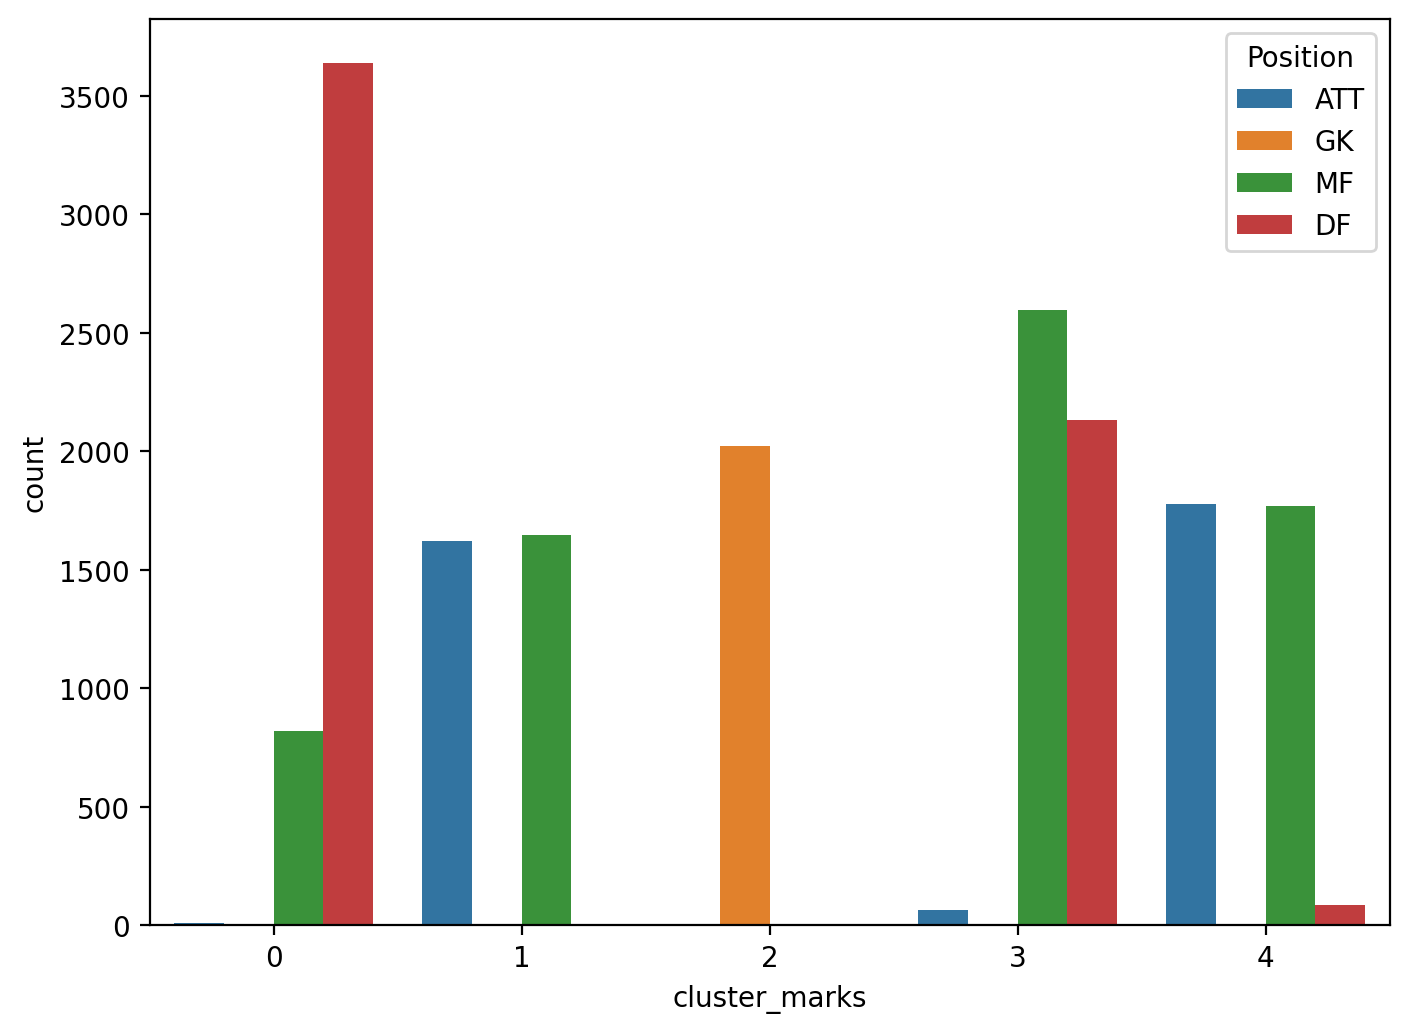

In [502]:
temp1(df)

In [503]:
temp(df, 'StandingTackle')

GK, srednja vrednost StandingTackle:  0.13342016008682675
GK, medijan vrednost StandingTackle:  0.13186813186813187

NAPAD:
RF, srednja vrednost StandingTackle:  0.3853021978021978
RF, medijan vrednost StandingTackle:  0.40659340659340665

CF, srednja vrednost StandingTackle:  0.29610929610929615
CF, medijan vrednost StandingTackle:  0.2637362637362638

LF, srednja vrednost StandingTackle:  0.36923076923076936
LF, medijan vrednost StandingTackle:  0.41758241758241765

RS, srednja vrednost StandingTackle:  0.2989227521247226
RS, medijan vrednost StandingTackle:  0.28571428571428575

ST, srednja vrednost StandingTackle:  0.2606337863284563
ST, medijan vrednost StandingTackle:  0.2307692307692308

LS, srednja vrednost StandingTackle:  0.2934119021075543
LS, medijan vrednost StandingTackle:  0.28571428571428575

LW, srednja vrednost StandingTackle:  0.35104265812927227
LW, medijan vrednost StandingTackle:  0.3296703296703297

RW, srednja vrednost StandingTackle:  0.3403920403920404
RW, med

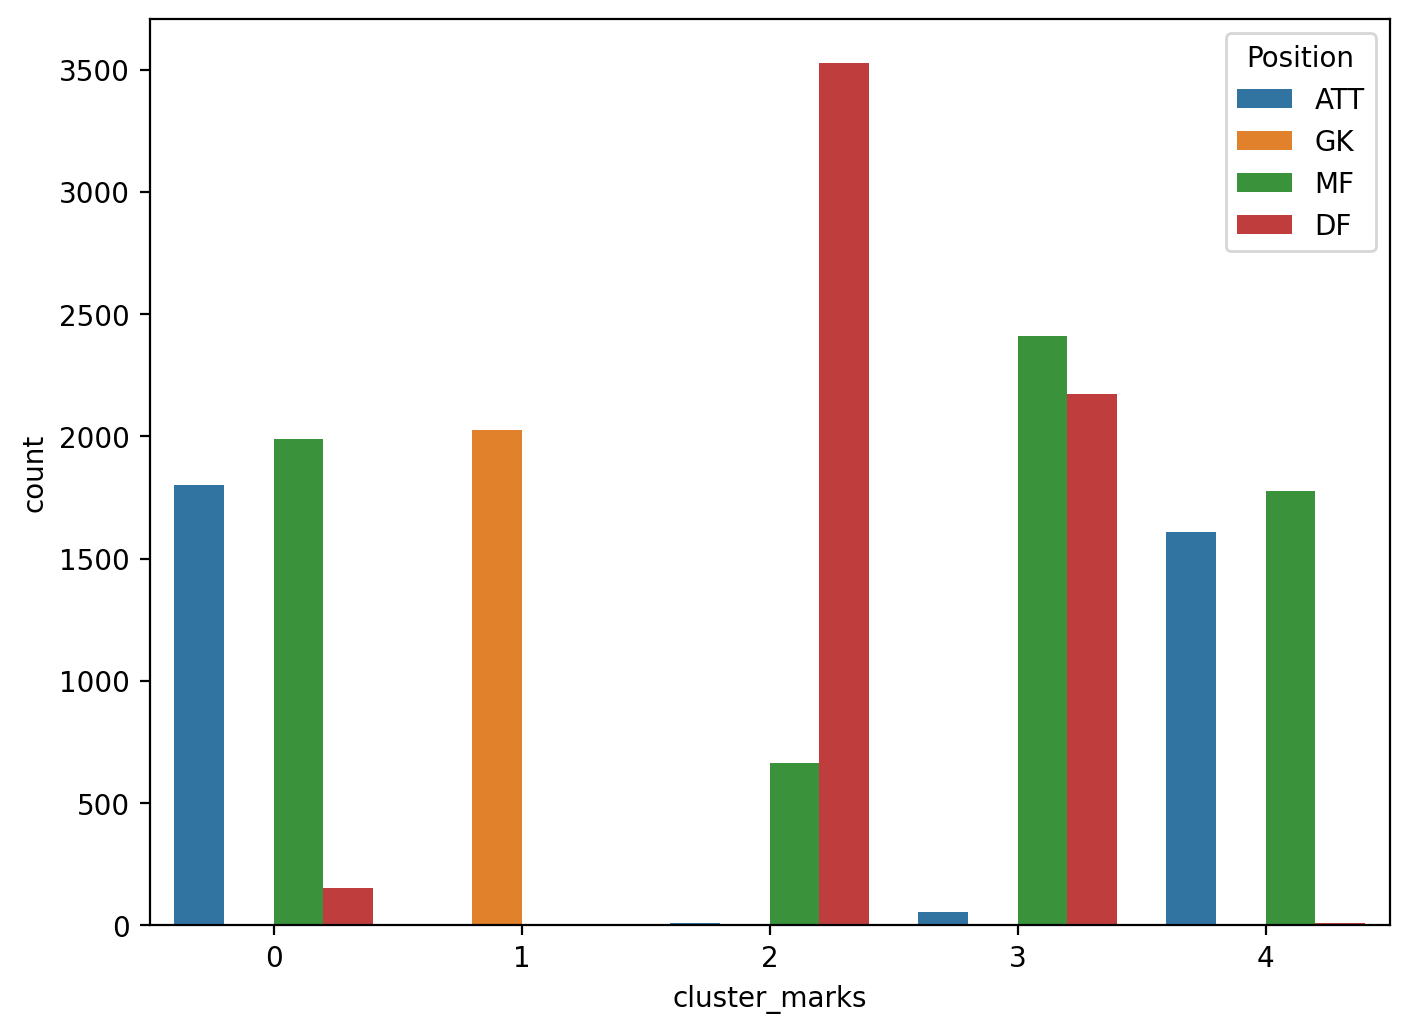

In [504]:
temp1(df)

In [505]:
temp(df, 'SlidingTackle')

GK, srednja vrednost SlidingTackle:  0.1258193041526375
GK, medijan vrednost SlidingTackle:  0.11363636363636365

NAPAD:
RF, srednja vrednost SlidingTackle:  0.3515625
RF, medijan vrednost SlidingTackle:  0.33522727272727276

CF, srednja vrednost SlidingTackle:  0.261977886977887
CF, medijan vrednost SlidingTackle:  0.23295454545454544

LF, srednja vrednost SlidingTackle:  0.36515151515151517
LF, medijan vrednost SlidingTackle:  0.36363636363636365

RS, srednja vrednost SlidingTackle:  0.2536386027765338
RS, medijan vrednost SlidingTackle:  0.22727272727272727

ST, srednja vrednost SlidingTackle:  0.2305130532059145
ST, medijan vrednost SlidingTackle:  0.20454545454545456

LS, srednja vrednost SlidingTackle:  0.26064997804128237
LS, medijan vrednost SlidingTackle:  0.23863636363636362

LW, srednja vrednost SlidingTackle:  0.3277857313290385
LW, medijan vrednost SlidingTackle:  0.2954545454545454

RW, srednja vrednost SlidingTackle:  0.32039312039312046
RW, medijan vrednost SlidingTackl

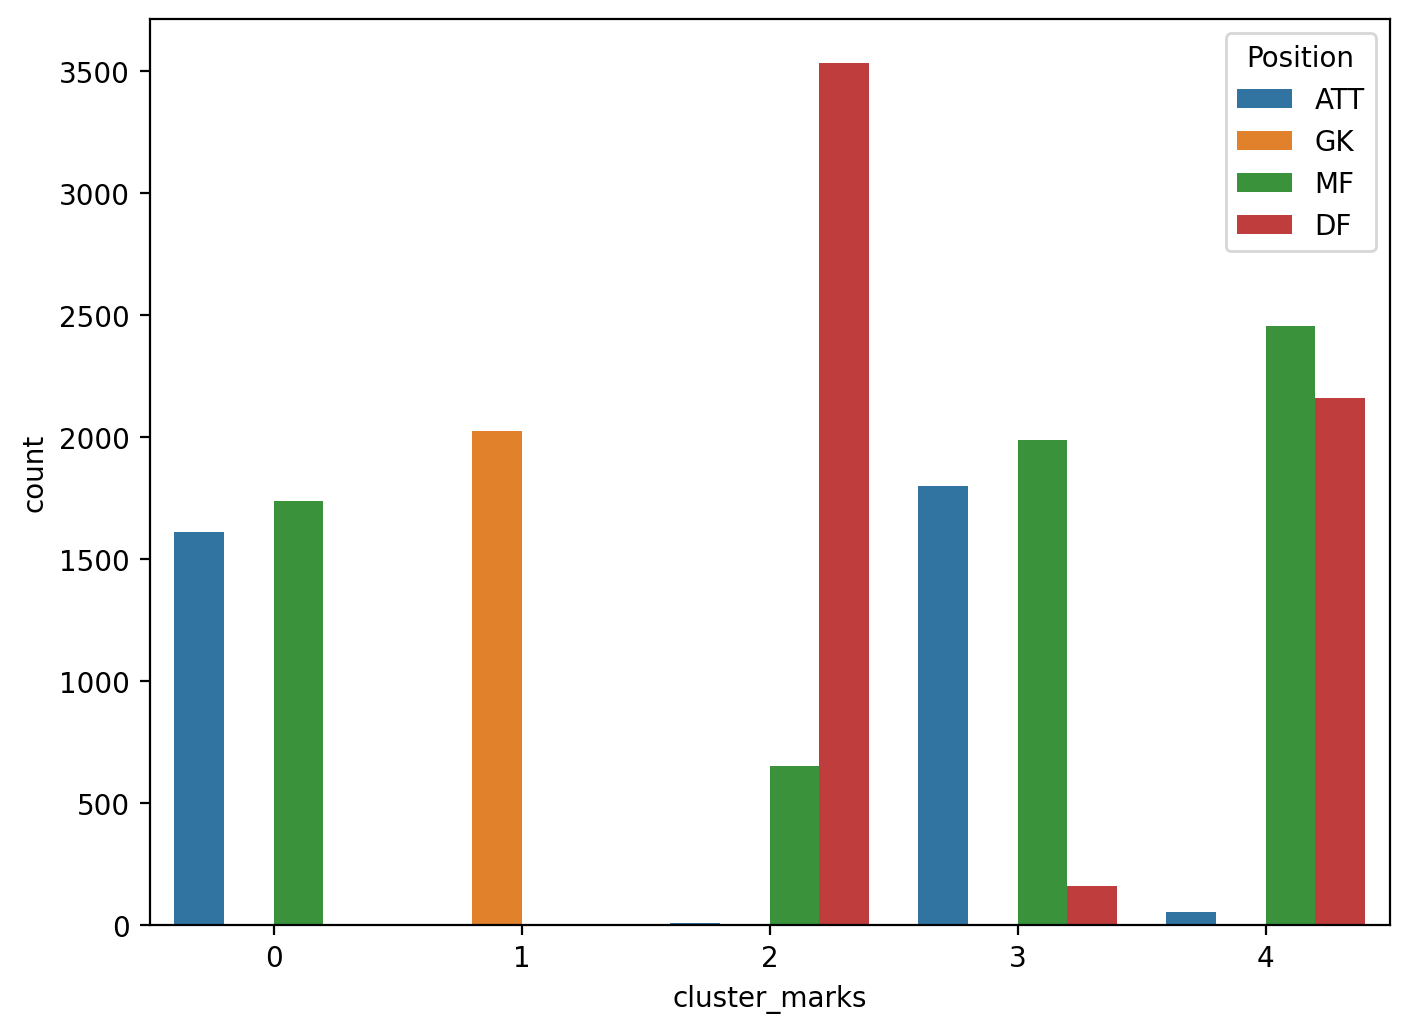

In [506]:
temp1(df)

In [507]:
temp(df, 'Balance')

GK, srednja vrednost Balance:  0.3387283950617284
GK, medijan vrednost Balance:  0.33749999999999997

NAPAD:
RF, srednja vrednost Balance:  0.7296875
RF, medijan vrednost Balance:  0.7375

CF, srednja vrednost Balance:  0.7219594594594596
CF, medijan vrednost Balance:  0.7250000000000001

LF, srednja vrednost Balance:  0.805
LF, medijan vrednost Balance:  0.7875000000000001

RS, srednja vrednost Balance:  0.6280172413793104
RS, medijan vrednost Balance:  0.6375

ST, srednja vrednost Balance:  0.5988098751489631
ST, medijan vrednost Balance:  0.6125

LS, srednja vrednost Balance:  0.6137077294685992
LS, medijan vrednost Balance:  0.6375

LW, srednja vrednost Balance:  0.7224409448818898
LW, medijan vrednost Balance:  0.7125000000000001

RW, srednja vrednost Balance:  0.7277364864864866
RW, medijan vrednost Balance:  0.7375

VEZNI RED:
RDM, srednja vrednost Balance:  0.6378528225806451
RDM, medijan vrednost Balance:  0.6500000000000001

CDM, srednja vrednost Balance:  0.621215717299578
C

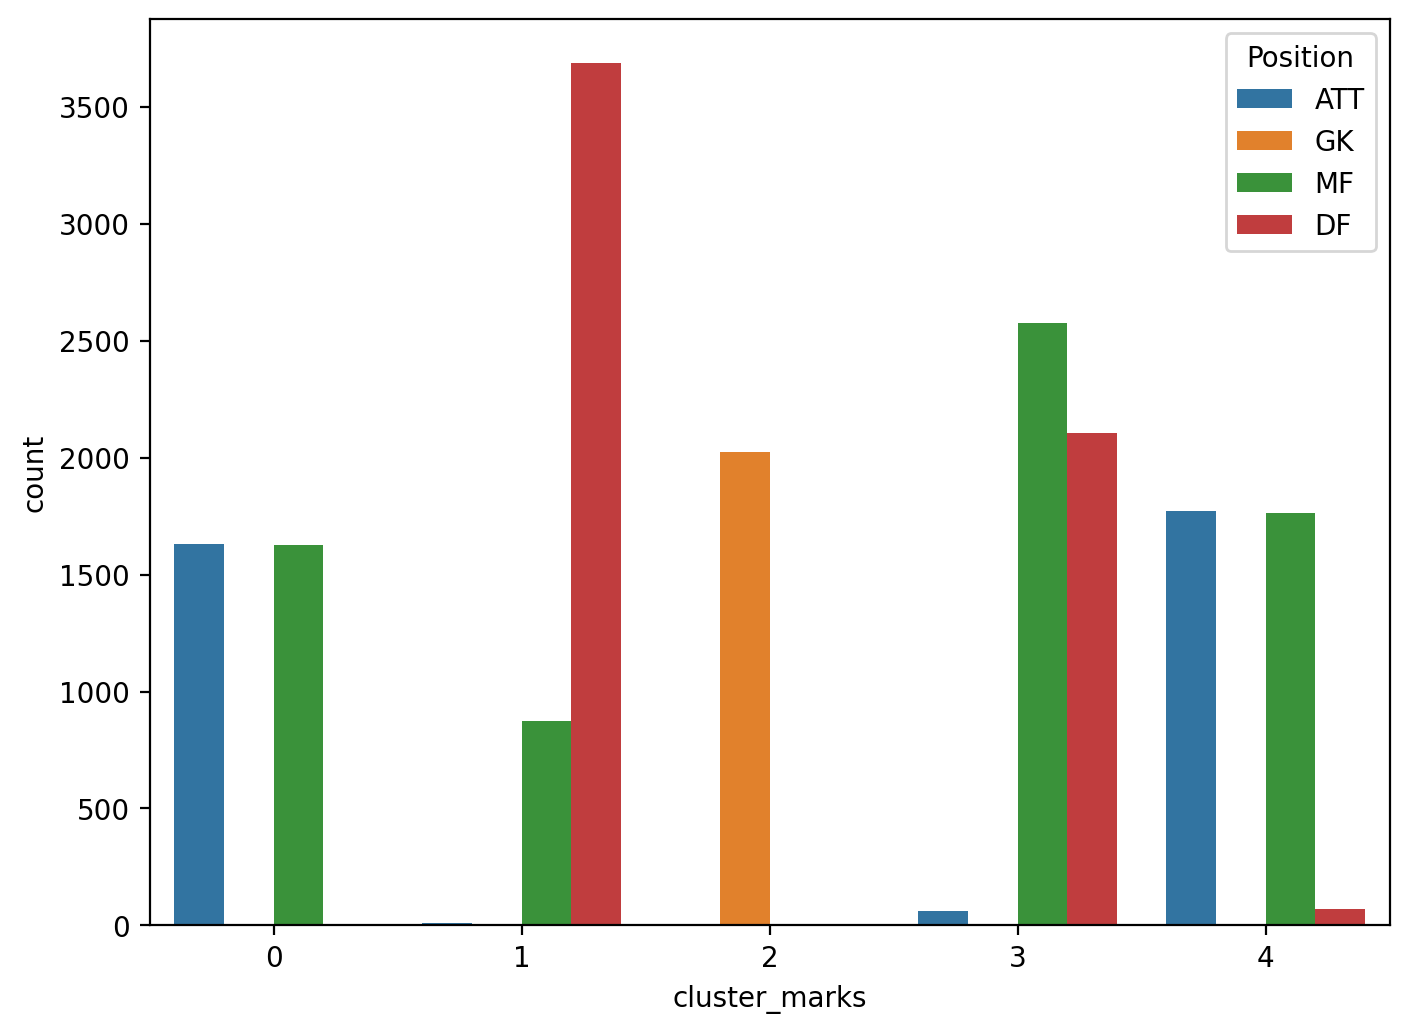

In [508]:
temp1(df)

In [509]:
temp(df, 'Curve')

GK, srednja vrednost Curve:  0.09895061728395062
GK, medijan vrednost Curve:  0.09090909090909091

NAPAD:
RF, srednja vrednost Curve:  0.7365056818181819
RF, medijan vrednost Curve:  0.7329545454545454

CF, srednja vrednost Curve:  0.6048832923832923
CF, medijan vrednost Curve:  0.5965909090909091

LF, srednja vrednost Curve:  0.7136363636363637
LF, medijan vrednost Curve:  0.7272727272727273

RS, srednja vrednost Curve:  0.5668943125839677
RS, medijan vrednost Curve:  0.5795454545454546

ST, srednja vrednost Curve:  0.5076452797265995
ST, medijan vrednost Curve:  0.5

LS, srednja vrednost Curve:  0.5741655687307861
LS, medijan vrednost Curve:  0.5795454545454546

LW, srednja vrednost Curve:  0.6037640181340969
LW, medijan vrednost Curve:  0.6022727272727273

RW, srednja vrednost Curve:  0.6034090909090909
RW, medijan vrednost Curve:  0.6022727272727273

VEZNI RED:
RDM, srednja vrednost Curve:  0.5448130498533724
RDM, medijan vrednost Curve:  0.5454545454545454

CDM, srednja vrednost C

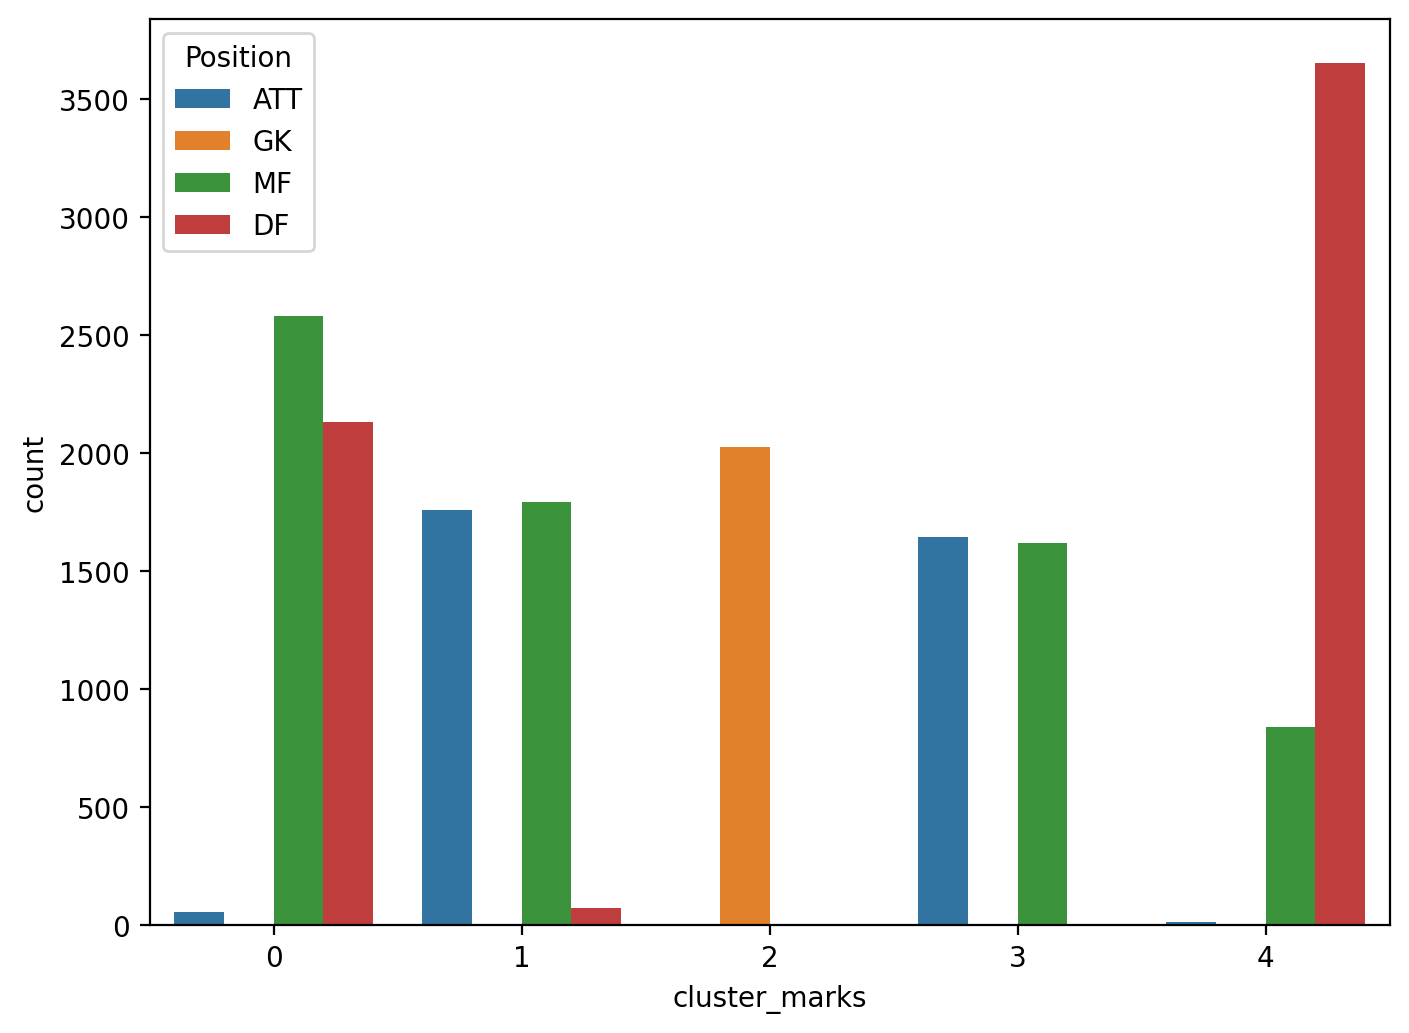

In [510]:
temp1(df)

In [511]:
temp(df, 'Stamina')

GK, srednja vrednost Stamina:  0.219782480893592
GK, medijan vrednost Stamina:  0.21428571428571425

NAPAD:
RF, srednja vrednost Stamina:  0.7299107142857142
RF, medijan vrednost Stamina:  0.7321428571428571

CF, srednja vrednost Stamina:  0.6145431145431144
CF, medijan vrednost Stamina:  0.6309523809523809

LF, srednja vrednost Stamina:  0.6928571428571428
LF, medijan vrednost Stamina:  0.6428571428571428

RS, srednja vrednost Stamina:  0.6824419422941591
RS, medijan vrednost Stamina:  0.6785714285714286

ST, srednja vrednost Stamina:  0.6144598586150702
ST, medijan vrednost Stamina:  0.6190476190476191

LS, srednja vrednost Stamina:  0.6664366229583621
LS, medijan vrednost Stamina:  0.6785714285714286

LW, srednja vrednost Stamina:  0.6177040369953756
LW, medijan vrednost Stamina:  0.6309523809523809

RW, srednja vrednost Stamina:  0.6247747747747748
RW, medijan vrednost Stamina:  0.6428571428571428

VEZNI RED:
RDM, srednja vrednost Stamina:  0.7601766513056836
RDM, medijan vrednost 

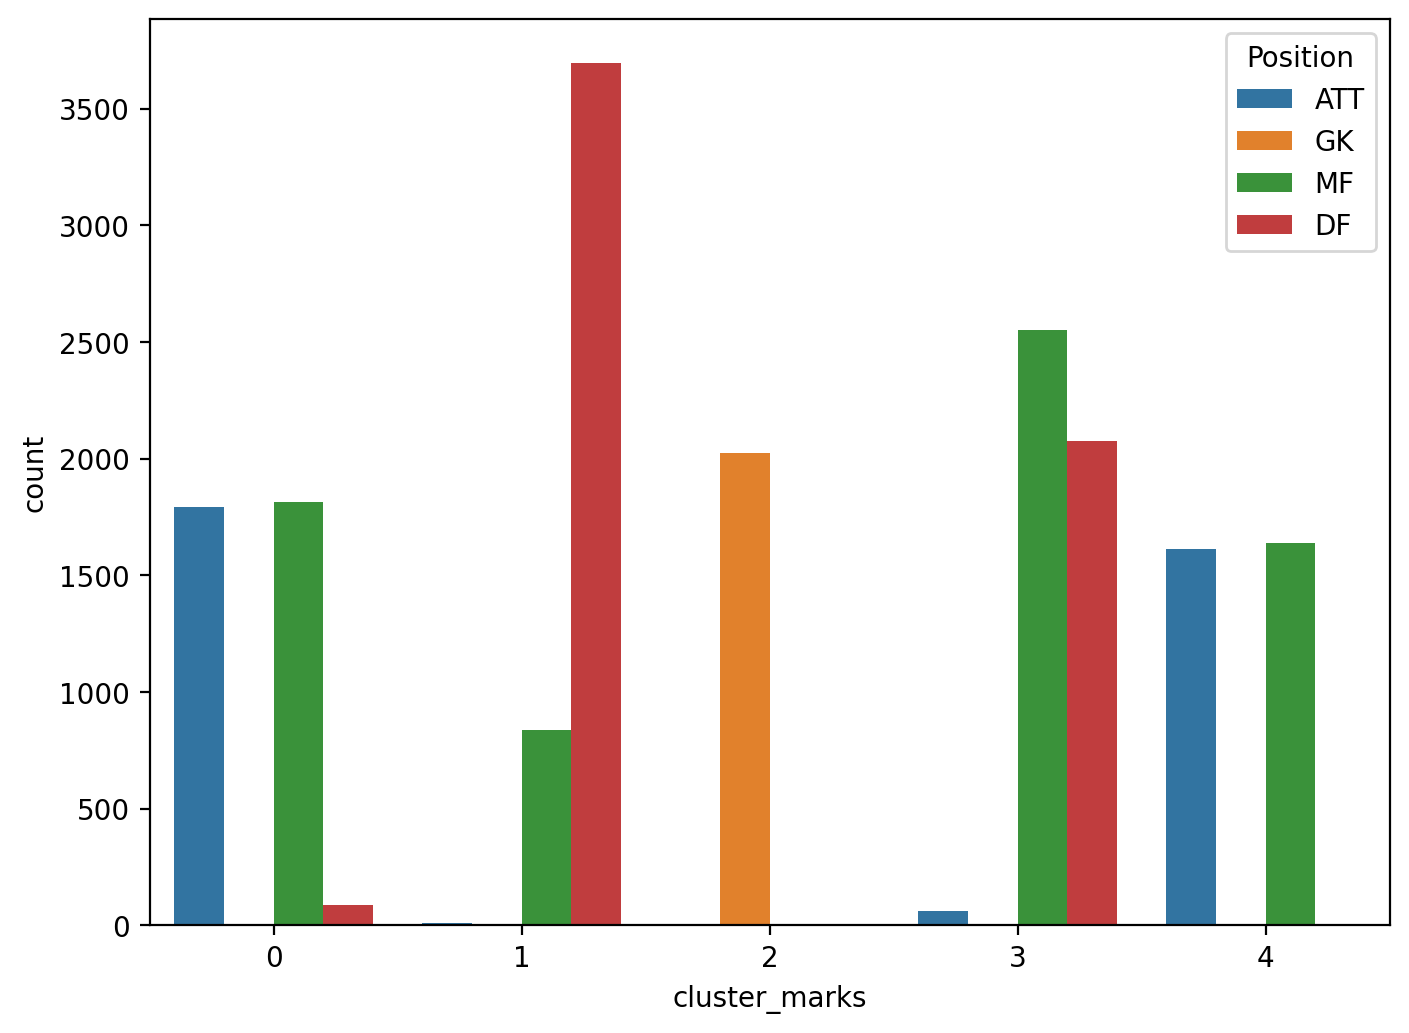

In [512]:
temp1(df)

In [513]:
temp(df, 'Aggression')

GK, srednja vrednost Aggression:  0.18299823633156967
GK, medijan vrednost Aggression:  0.16666666666666669

NAPAD:
RF, srednja vrednost Aggression:  0.5290178571428571
RF, medijan vrednost Aggression:  0.4880952380952381

CF, srednja vrednost Aggression:  0.45093307593307586
CF, medijan vrednost Aggression:  0.43452380952380953

LF, srednja vrednost Aggression:  0.4841269841269841
LF, medijan vrednost Aggression:  0.5119047619047619

RS, srednja vrednost Aggression:  0.5505512549847524
RS, medijan vrednost Aggression:  0.5595238095238095

ST, srednja vrednost Aggression:  0.4865544623912465
ST, medijan vrednost Aggression:  0.5

LS, srednja vrednost Aggression:  0.5562456866804693
LS, medijan vrednost Aggression:  0.5952380952380952

LW, srednja vrednost Aggression:  0.45013123359580054
LW, medijan vrednost Aggression:  0.44047619047619047

RW, srednja vrednost Aggression:  0.42879665379665377
RW, medijan vrednost Aggression:  0.40476190476190477

VEZNI RED:
RDM, srednja vrednost Aggr

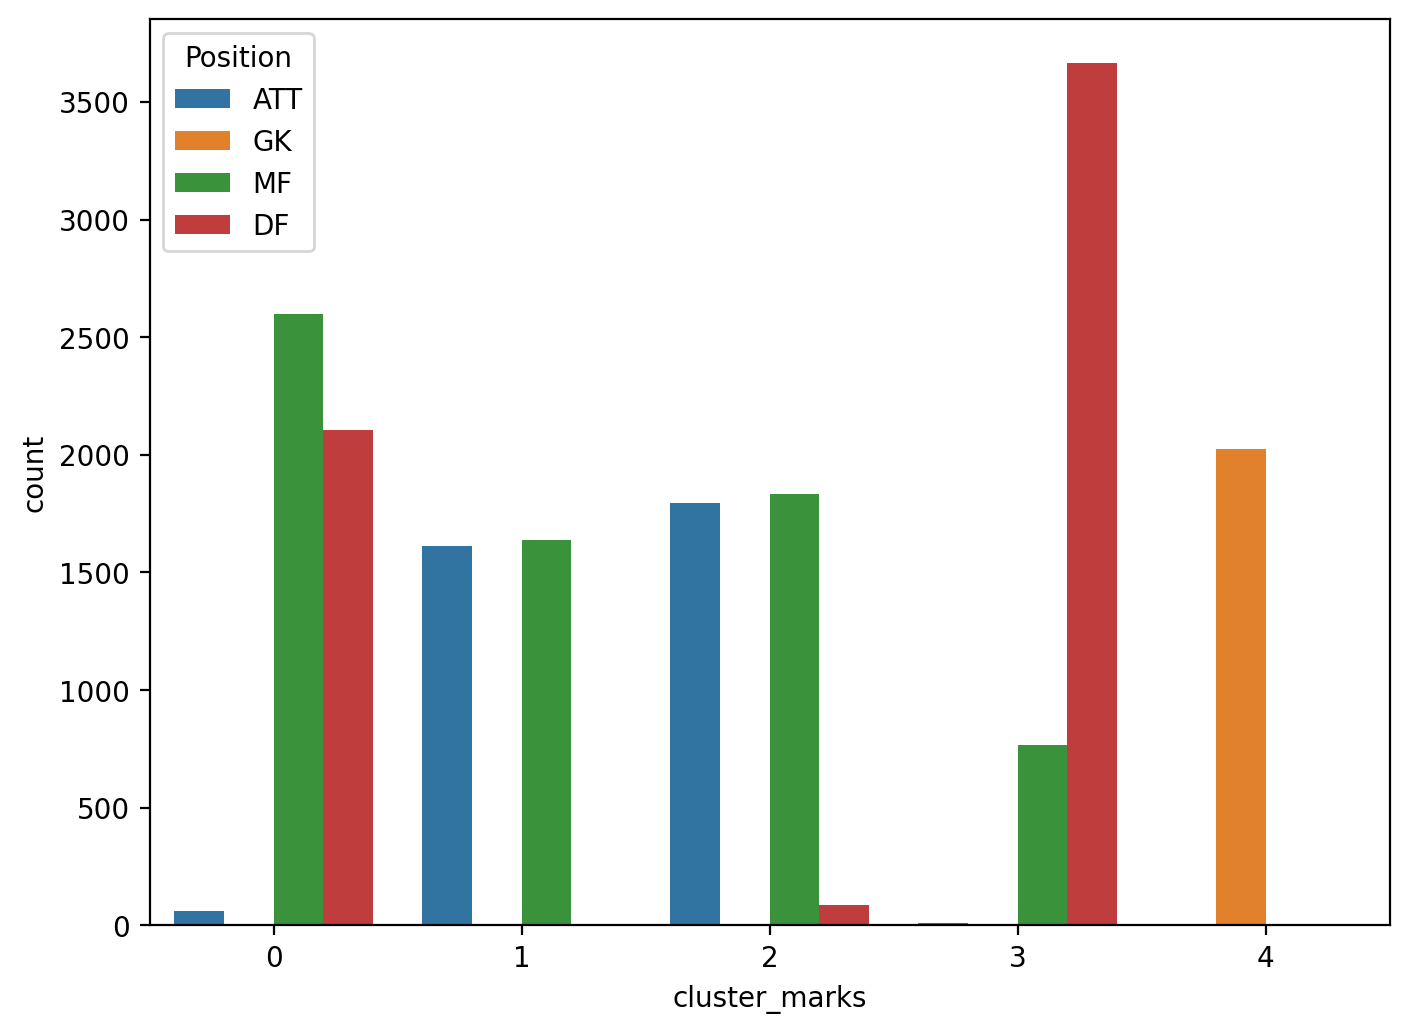

In [514]:
temp1(df)

In [515]:
temp(df, 'Positioning')

GK, srednja vrednost Positioning:  0.09955661754944908
GK, medijan vrednost Positioning:  0.0967741935483871

NAPAD:
RF, srednja vrednost Positioning:  0.739247311827957
RF, medijan vrednost Positioning:  0.7096774193548387

CF, srednja vrednost Positioning:  0.6620168555652429
CF, medijan vrednost Positioning:  0.6559139784946237

LF, srednja vrednost Positioning:  0.7304659498207886
LF, medijan vrednost Positioning:  0.6989247311827957

RS, srednja vrednost Positioning:  0.7257799671592777
RS, medijan vrednost Positioning:  0.7311827956989249

ST, srednja vrednost Positioning:  0.673219423567968
ST, medijan vrednost Positioning:  0.6774193548387097

LS, srednja vrednost Positioning:  0.7305075061035792
LS, medijan vrednost Positioning:  0.7311827956989249

LW, srednja vrednost Positioning:  0.6561679790026248
LW, medijan vrednost Positioning:  0.6559139784946237

RW, srednja vrednost Positioning:  0.6602731764022088
RW, medijan vrednost Positioning:  0.6666666666666667

VEZNI RED:
RD

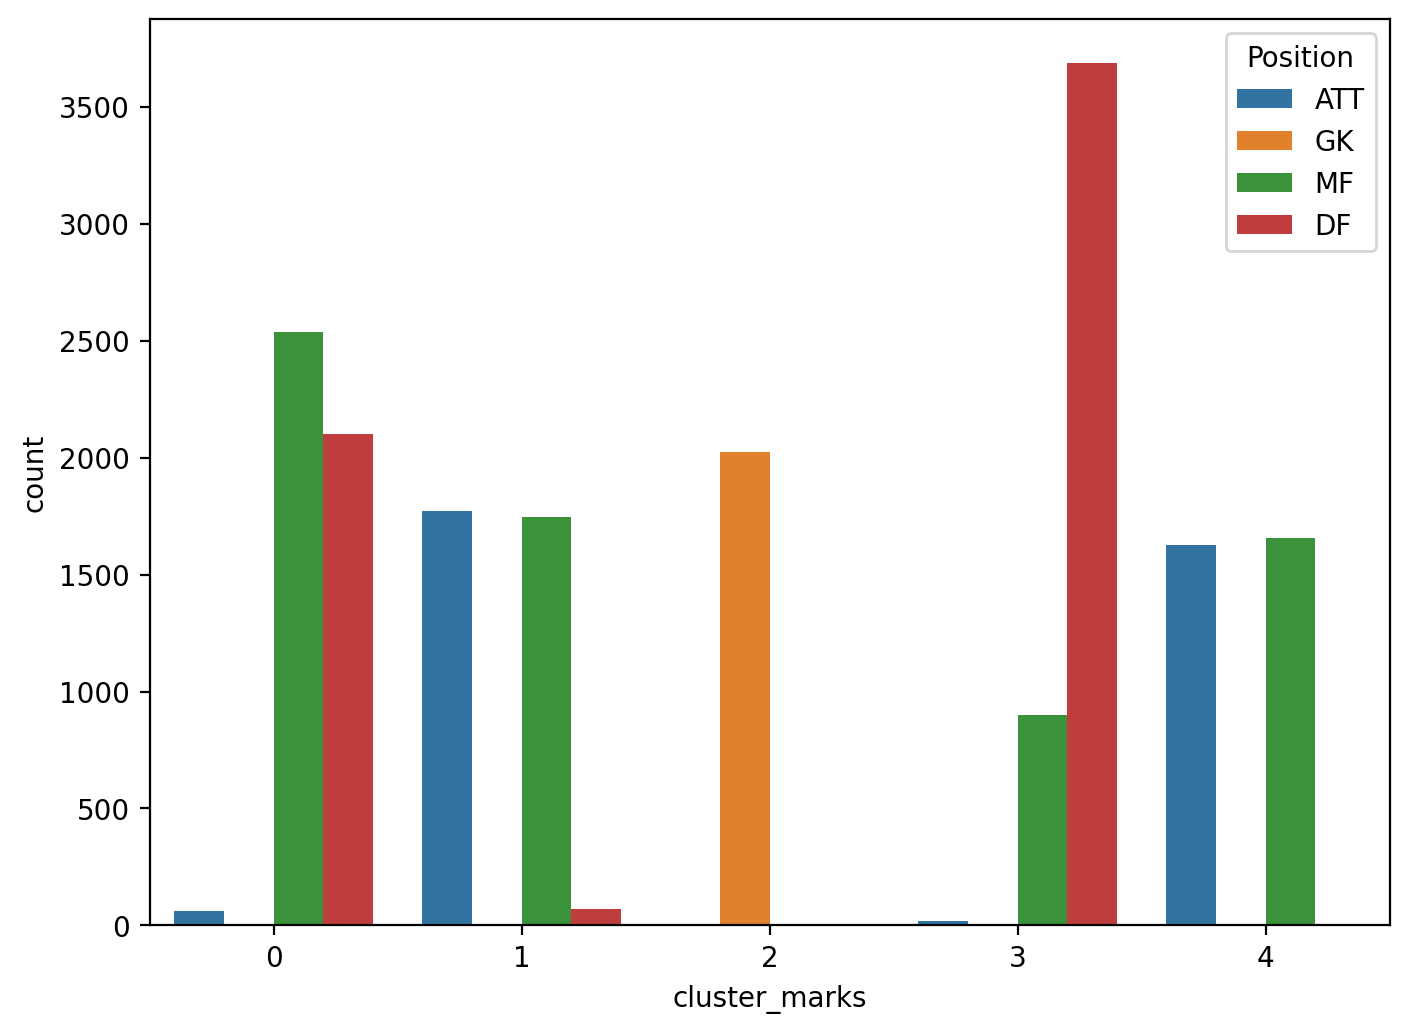

In [516]:
temp1(df)

In [517]:
temp(df, 'Vision')

GK, srednja vrednost Vision:  0.32139917695473247
GK, medijan vrednost Vision:  0.30952380952380953

NAPAD:
RF, srednja vrednost Vision:  0.7299107142857142
RF, medijan vrednost Vision:  0.7261904761904762

CF, srednja vrednost Vision:  0.6274131274131275
CF, medijan vrednost Vision:  0.6309523809523809

LF, srednja vrednost Vision:  0.7261904761904762
LF, medijan vrednost Vision:  0.6904761904761905

RS, srednja vrednost Vision:  0.5796973961998592
RS, medijan vrednost Vision:  0.5714285714285714

ST, srednja vrednost Vision:  0.5318729190906998
ST, medijan vrednost Vision:  0.5238095238095237

LS, srednja vrednost Vision:  0.5884518058431101
LS, medijan vrednost Vision:  0.5714285714285714

LW, srednja vrednost Vision:  0.6060492438445193
LW, medijan vrednost Vision:  0.6071428571428571

RW, srednja vrednost Vision:  0.6119691119691119
RW, medijan vrednost Vision:  0.6071428571428571

VEZNI RED:
RDM, srednja vrednost Vision:  0.6459293394777265
RDM, medijan vrednost Vision:  0.648809

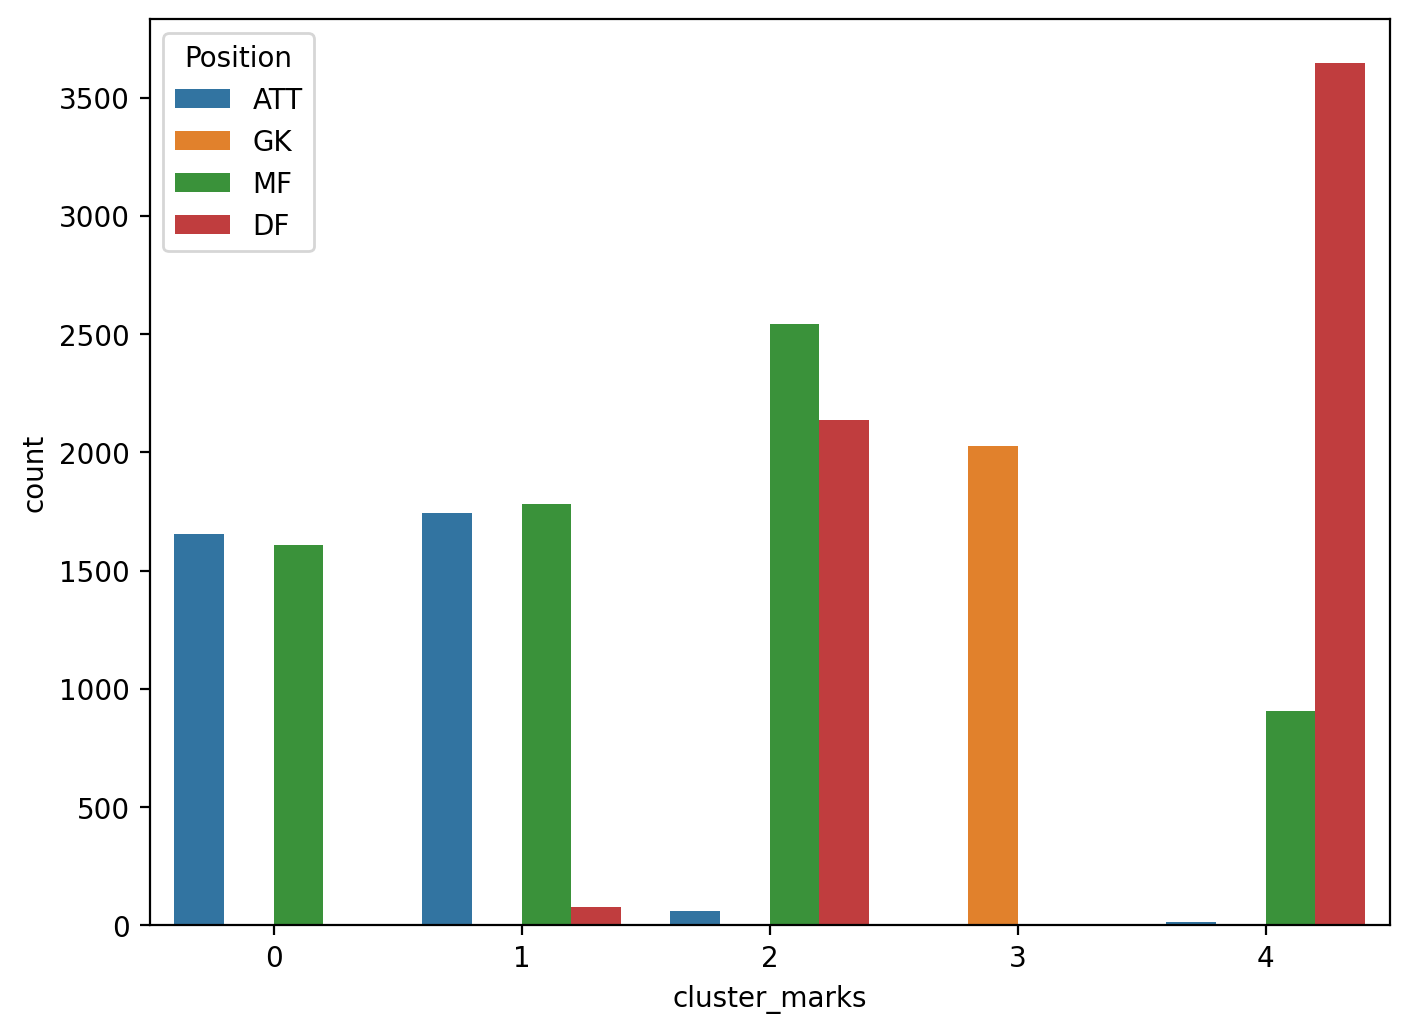

In [518]:
temp1(df)

In [519]:
temp(df, 'Penalties')

GK, srednja vrednost Penalties:  0.17249893571732655
GK, medijan vrednost Penalties:  0.1724137931034483

NAPAD:
RF, srednja vrednost Penalties:  0.6961206896551724
RF, medijan vrednost Penalties:  0.7241379310344827

CF, srednja vrednost Penalties:  0.6247281764523143
CF, medijan vrednost Penalties:  0.6264367816091954

LF, srednja vrednost Penalties:  0.6888888888888888
LF, medijan vrednost Penalties:  0.6551724137931034

RS, srednja vrednost Penalties:  0.6868806975822433
RS, medijan vrednost Penalties:  0.689655172413793

ST, srednja vrednost Penalties:  0.6610355881584934
ST, medijan vrednost Penalties:  0.6666666666666666

LS, srednja vrednost Penalties:  0.69026597812205
LS, medijan vrednost Penalties:  0.7011494252873562

LW, srednja vrednost Penalties:  0.6033426856125742
LW, medijan vrednost Penalties:  0.6091954022988505

RW, srednja vrednost Penalties:  0.6075799937868903
RW, medijan vrednost Penalties:  0.6206896551724137

VEZNI RED:
RDM, srednja vrednost Penalties:  0.562

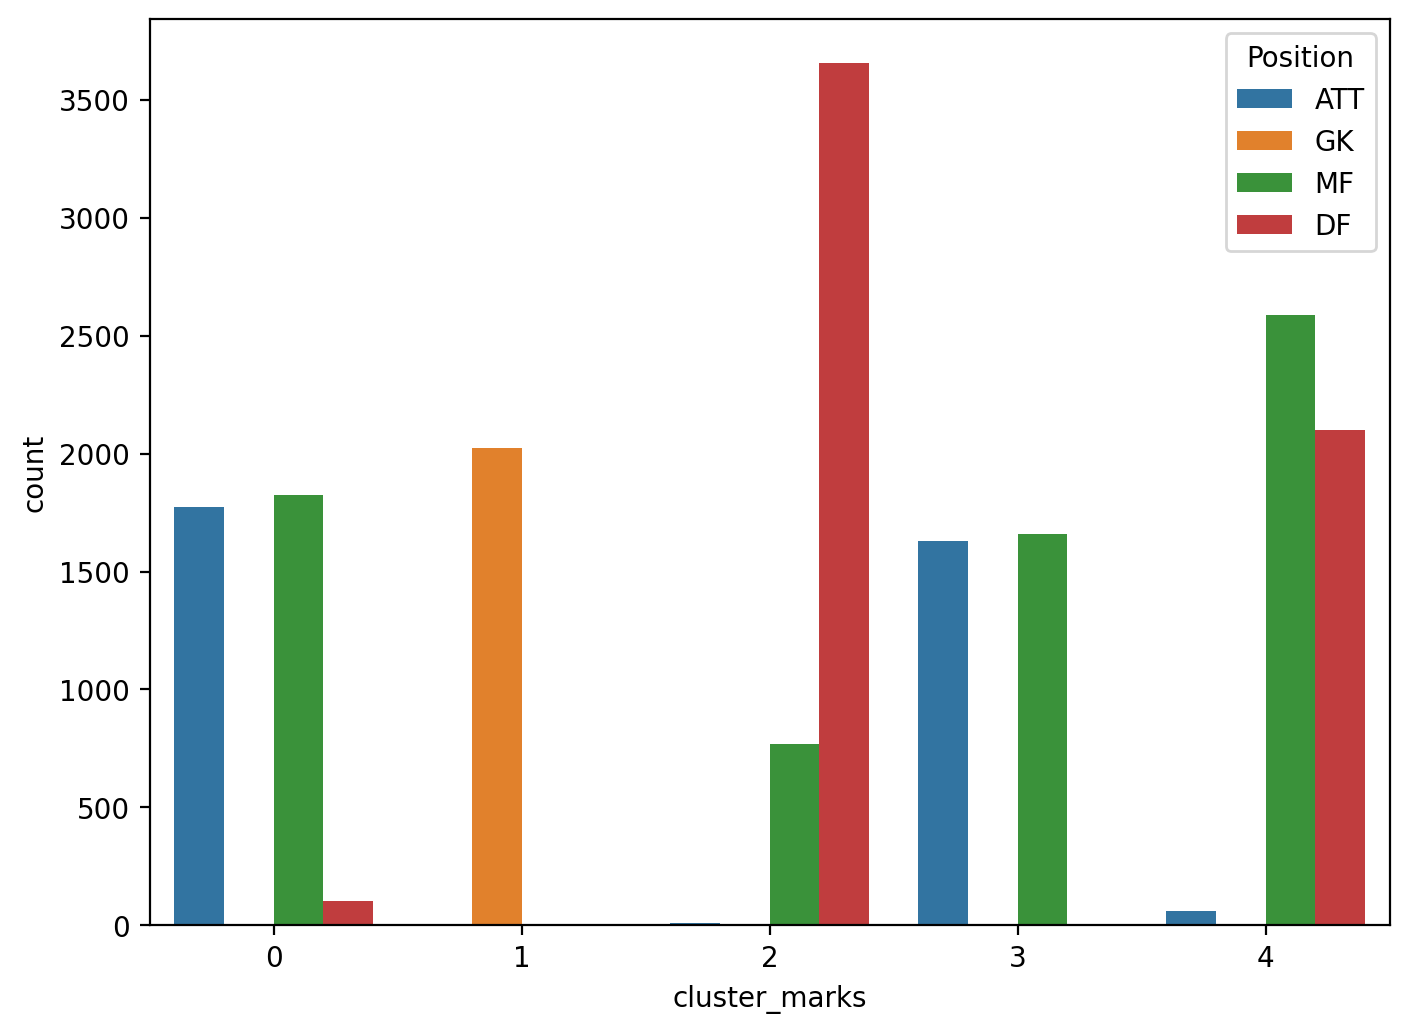

In [520]:
temp1(df)

In [543]:
temp(df, 'Composure')

GK, srednja vrednost Composure:  0.45292977565379006
GK, medijan vrednost Composure:  0.4623655913978495

NAPAD:
RF, srednja vrednost Composure:  0.7204301075268817
RF, medijan vrednost Composure:  0.7043010752688172

CF, srednja vrednost Composure:  0.6232199941877362
CF, medijan vrednost Composure:  0.6021505376344087

LF, srednja vrednost Composure:  0.7218637992831543
LF, medijan vrednost Composure:  0.6774193548387097

RS, srednja vrednost Composure:  0.6594628952804706
RS, medijan vrednost Composure:  0.6666666666666667

ST, srednja vrednost Composure:  0.6112072815532126
ST, medijan vrednost Composure:  0.6021505376344087

LS, srednja vrednost Composure:  0.6702508960573479
LS, medijan vrednost Composure:  0.6774193548387097

LW, srednja vrednost Composure:  0.6220190218158216
LW, medijan vrednost Composure:  0.6236559139784947

RW, srednja vrednost Composure:  0.6227840743969778
RW, medijan vrednost Composure:  0.6236559139784947

VEZNI RED:
RDM, srednja vrednost Composure:  0.

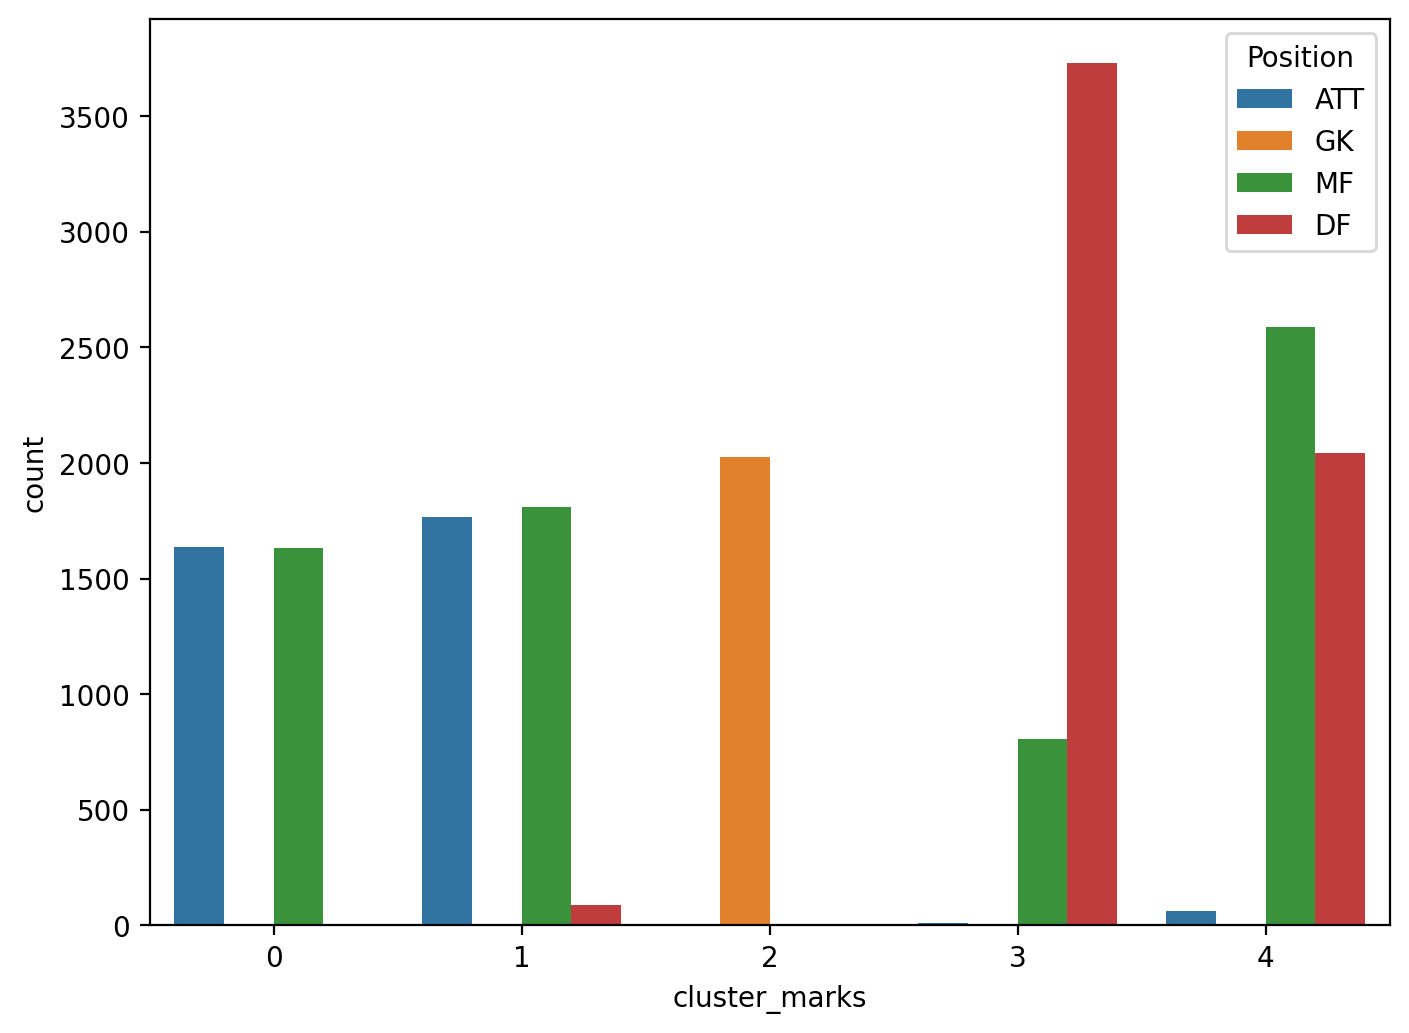

In [544]:
temp1(df)

In [ ]:
#######

In [548]:
kmeans = KMeans(n_clusters=5, random_state=0)
list_of_variables_to_drop = ['Dribbling', 'SprintSpeed', 'Agility',
                             'Skill Moves', 'FKAccuracy', 'LongPassing', 'Crossing',
                             'Finishing', 'HeadingAccuracy', 'Reactions', 'LongShots', 
                             'BallControl', 'ShotPower', 'Interceptions', 'Volleys', 
                             'StandingTackle', 'SlidingTackle', 'Balance', 'Curve',
                             'Stamina', 'Aggression', 'Positioning', 'Vision', 'Penalties',
                             ] # 'Acceleration'
kmeans.fit(df[numeric].drop(columns=list_of_variables_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [549]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4666, (25.62750590432251 %)

NAPAD: 438 (9.387055293613374 %)
Broj igraca na poziciji RF: 2, (0.04286326618088298 %)
Broj igraca na poziciji LF: 3, (0.06429489927132448 %)
Broj igraca na poziciji RW: 20, (0.42863266180882986 %)
Broj igraca na poziciji LW: 25, (0.5357908272610373 %)
Broj igraca na poziciji ST: 327, (7.008144020574368 %)
Broj igraca na poziciji CF: 5, (0.10715816545220747 %)
Broj igraca na poziciji RS: 30, (0.6429489927132447 %)
Broj igraca na poziciji LS: 26, (0.5572224603514788 %)

VEZNI RED: 1534 (32.876125160737246 %)
Broj igraca na poziciji RDM: 88, (1.8859837119588514 %)
Broj igraca na poziciji CDM: 391, (8.379768538362624 %)
Broj igraca na poziciji LDM: 92, (1.9717102443206174 %)
Broj igraca na poziciji RM: 133, (2.8504072010287183 %)
Broj igraca na poziciji RCM: 131, (2.8075439348478355 %)
Broj igraca na poziciji CM: 366, (7.843977711101586 %)
Broj igraca na poziciji LCM: 122, (2.614659237033862 %)
Broj igraca na poziciji LM: 125, (2.678

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

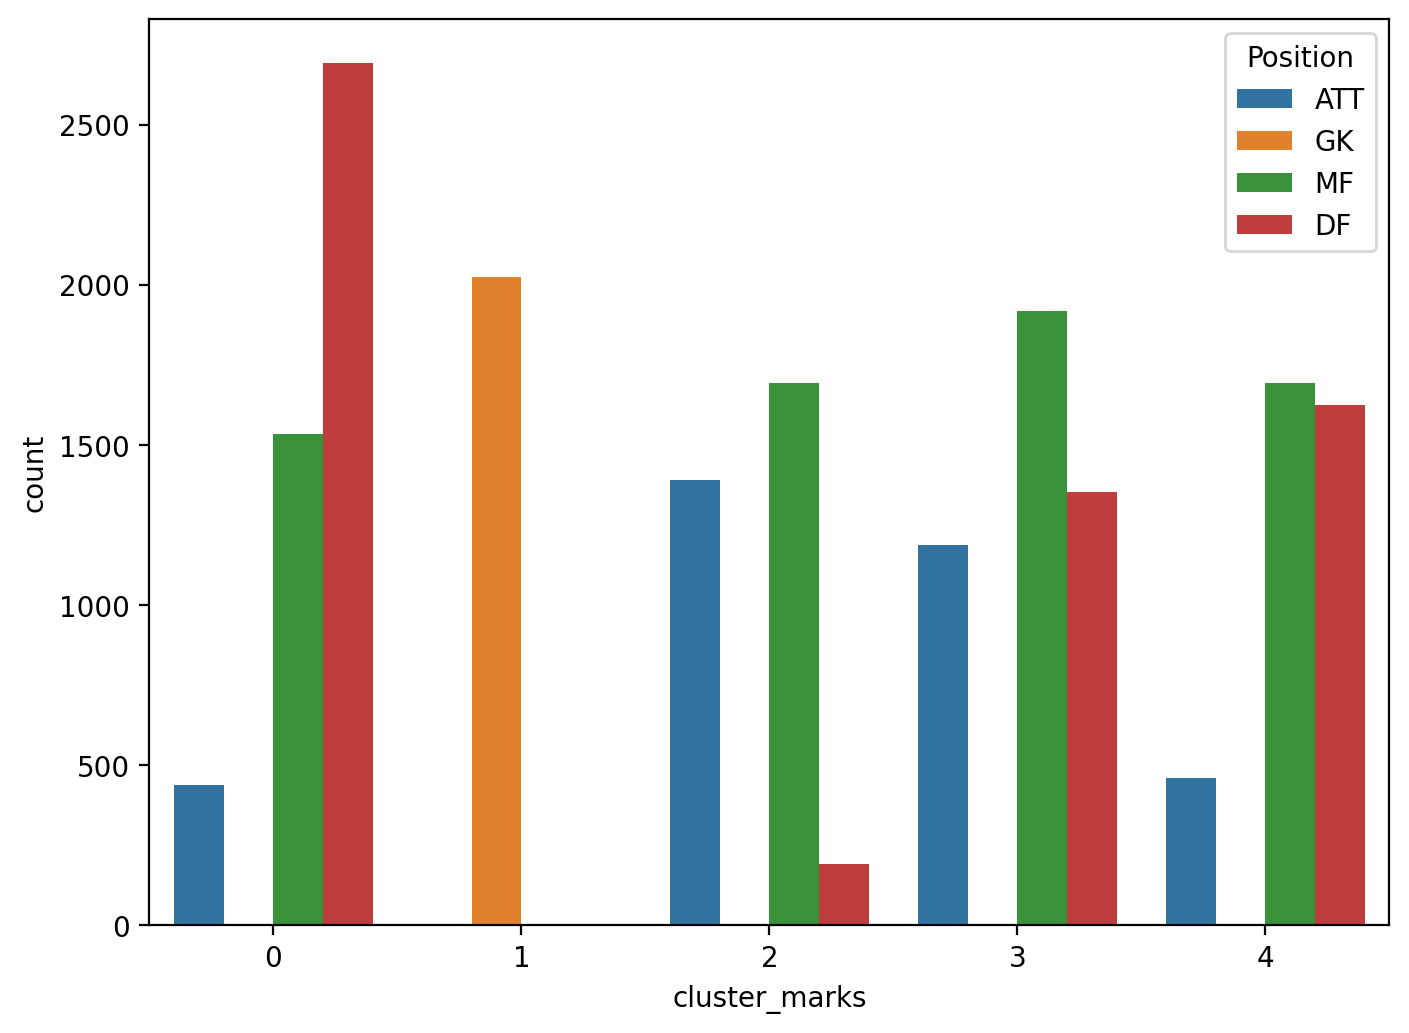

In [550]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [524]:
# Parametri koji golmana cine superiornim

temp(df, 'Age')

GK, srednja vrednost Age:  0.3463260962111537
GK, medijan vrednost Age:  0.31034482758620685

NAPAD:
RF, srednja vrednost Age:  0.40086206896551724
RF, medijan vrednost Age:  0.3793103448275862

CF, srednja vrednost Age:  0.2590866728797763
CF, medijan vrednost Age:  0.24137931034482762

LF, srednja vrednost Age:  0.37011494252873567
LF, medijan vrednost Age:  0.3793103448275862

RS, srednja vrednost Age:  0.368269067436725
RS, medijan vrednost Age:  0.3448275862068966

ST, srednja vrednost Age:  0.2994481511504646
ST, medijan vrednost Age:  0.27586206896551724

LS, srednja vrednost Age:  0.3726470098284191
LS, medijan vrednost Age:  0.3793103448275862

LW, srednja vrednost Age:  0.2555887410625396
LW, medijan vrednost Age:  0.24137931034482762

RW, srednja vrednost Age:  0.261789375582479
RW, medijan vrednost Age:  0.24137931034482762

VEZNI RED:
RDM, srednja vrednost Age:  0.3794493882091212
RDM, medijan vrednost Age:  0.3793103448275862

CDM, srednja vrednost Age:  0.318456278190018

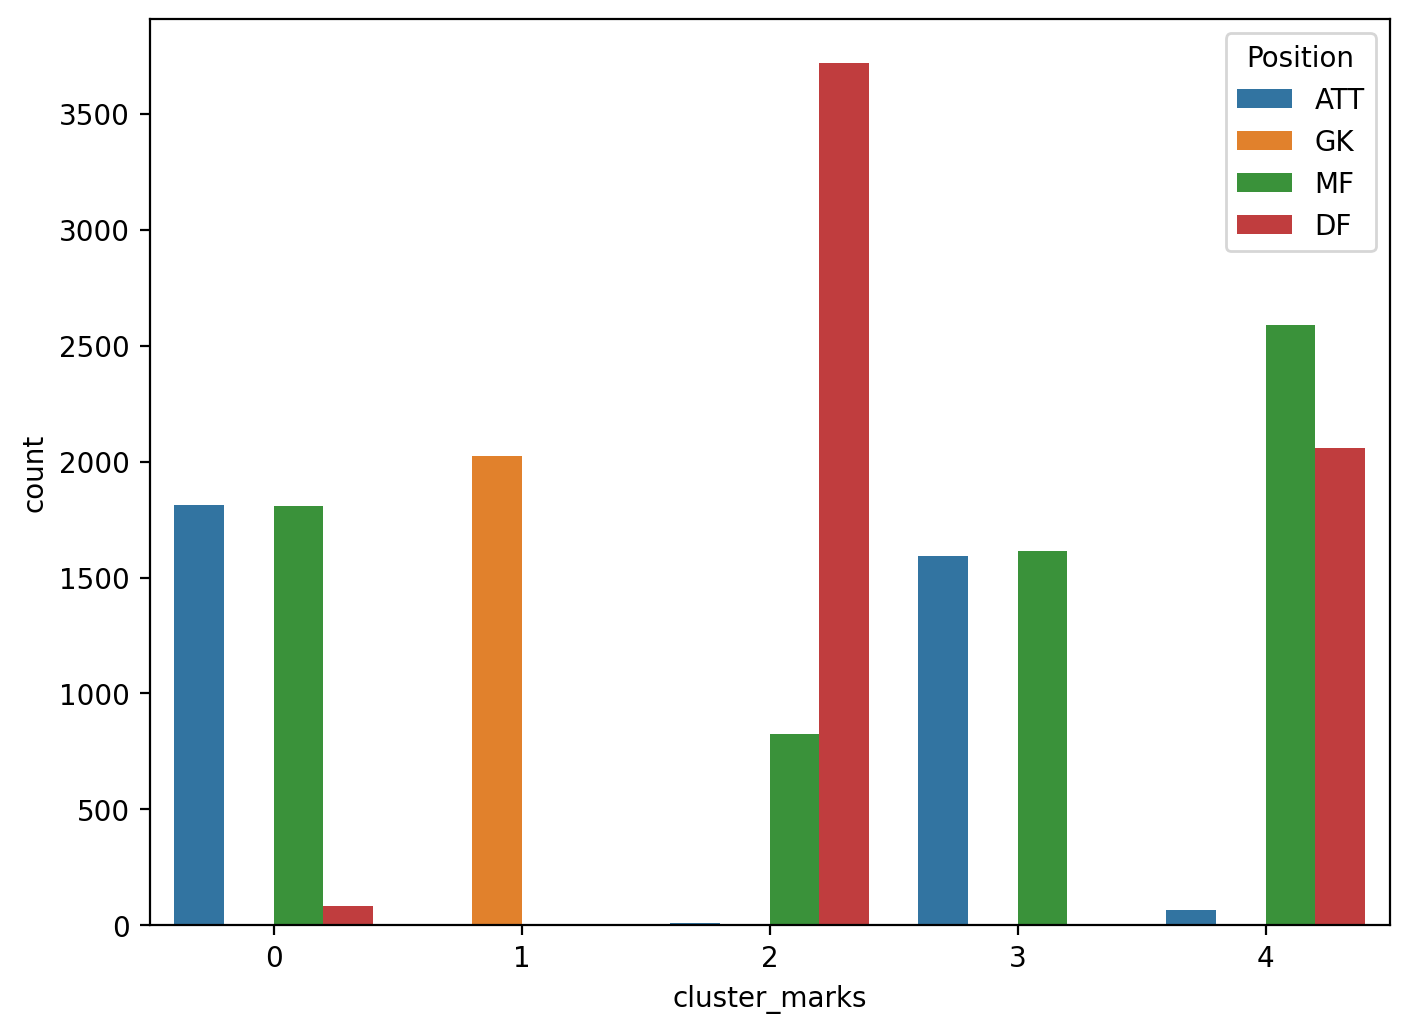

In [525]:
temp1(df)

In [526]:
temp(df, 'GKDiving')

GK, srednja vrednost GKDiving:  0.7227410181717296
GK, medijan vrednost GKDiving:  0.7191011235955056

NAPAD:
RF, srednja vrednost GKDiving:  0.10674157303370786
RF, medijan vrednost GKDiving:  0.10674157303370786

CF, srednja vrednost GKDiving:  0.09474643182508351
CF, medijan vrednost GKDiving:  0.0898876404494382

LF, srednja vrednost GKDiving:  0.10636704119850186
LF, medijan vrednost GKDiving:  0.11235955056179775

RS, srednja vrednost GKDiving:  0.10970277301156804
RS, medijan vrednost GKDiving:  0.11235955056179775

ST, srednja vrednost GKDiving:  0.10758263771306269
ST, medijan vrednost GKDiving:  0.11235955056179775

LS, srednja vrednost GKDiving:  0.10817999240080338
LS, medijan vrednost GKDiving:  0.11235955056179775

LW, srednja vrednost GKDiving:  0.10619599516352592
LW, medijan vrednost GKDiving:  0.11235955056179775

RW, srednja vrednost GKDiving:  0.1066808381415123
RW, medijan vrednost GKDiving:  0.10112359550561797

VEZNI RED:
RDM, srednja vrednost GKDiving:  0.109505

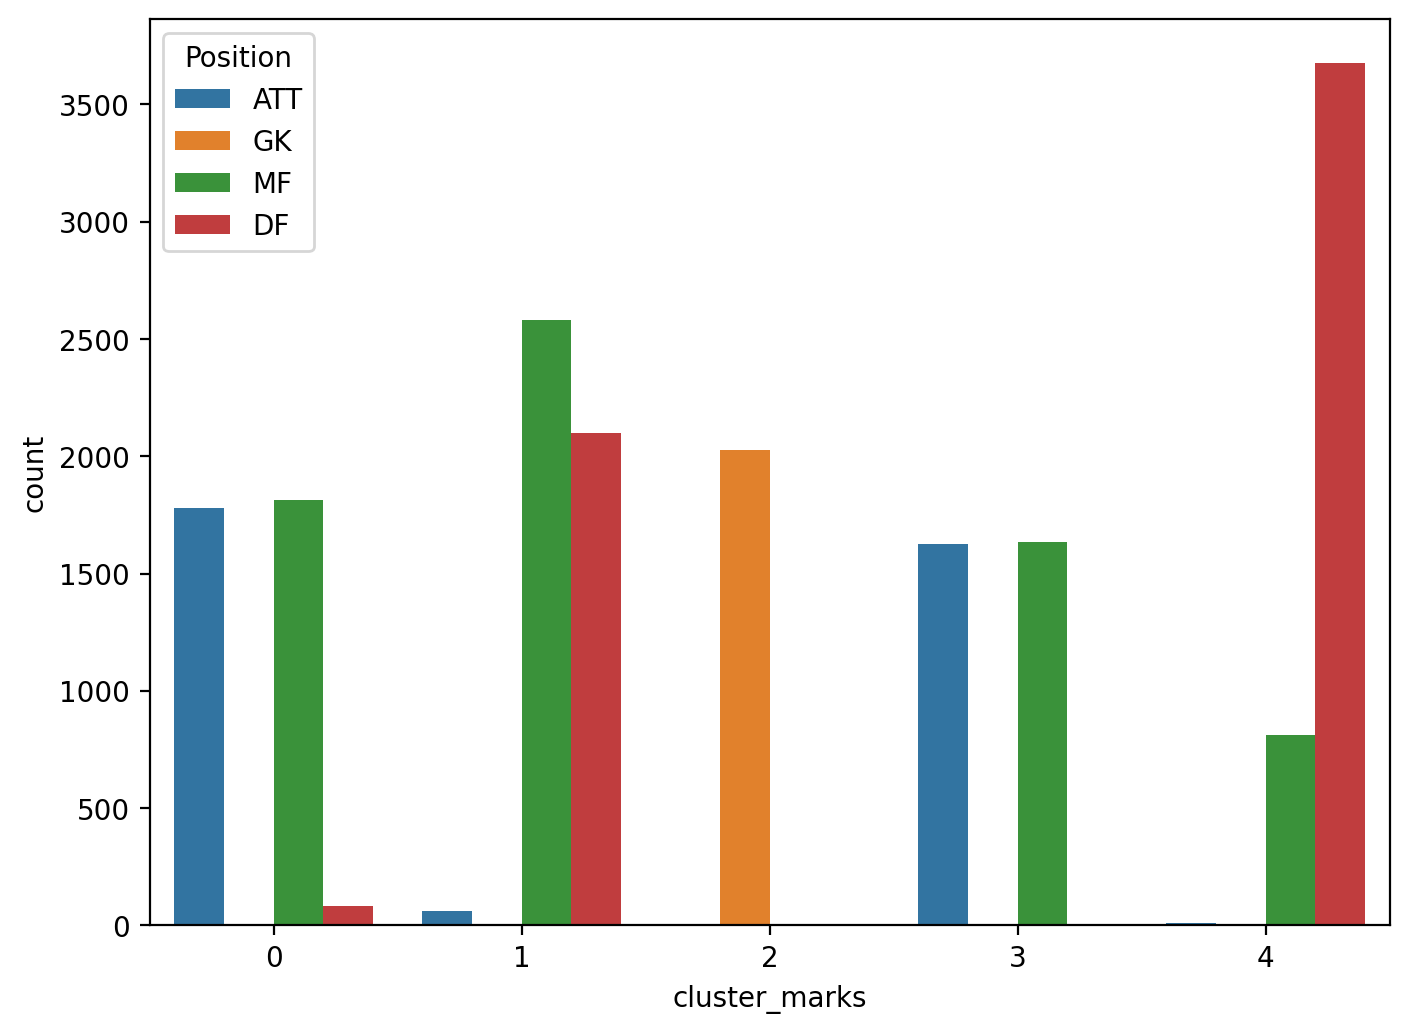

In [527]:
temp1(df)

In [528]:
temp(df, 'GKHandling')

GK, srednja vrednost GKHandling:  0.67986975986976
GK, medijan vrednost GKHandling:  0.6813186813186815

NAPAD:
RF, srednja vrednost GKHandling:  0.11195054945054947
RF, medijan vrednost GKHandling:  0.1098901098901099

CF, srednja vrednost GKHandling:  0.09414909414909416
CF, medijan vrednost GKHandling:  0.09890109890109891

LF, srednja vrednost GKHandling:  0.11941391941391943
LF, medijan vrednost GKHandling:  0.1318681318681319

RS, srednja vrednost GKHandling:  0.11216369837059492
RS, medijan vrednost GKHandling:  0.1098901098901099

ST, srednja vrednost GKHandling:  0.10651589049624607
ST, medijan vrednost GKHandling:  0.1098901098901099

LS, srednja vrednost GKHandling:  0.10330732069862504
LS, medijan vrednost GKHandling:  0.09890109890109891

LW, srednja vrednost GKHandling:  0.10141040062299907
LW, medijan vrednost GKHandling:  0.09890109890109891

RW, srednja vrednost GKHandling:  0.10430650430650432
RW, medijan vrednost GKHandling:  0.10439560439560441

VEZNI RED:
RDM, sred

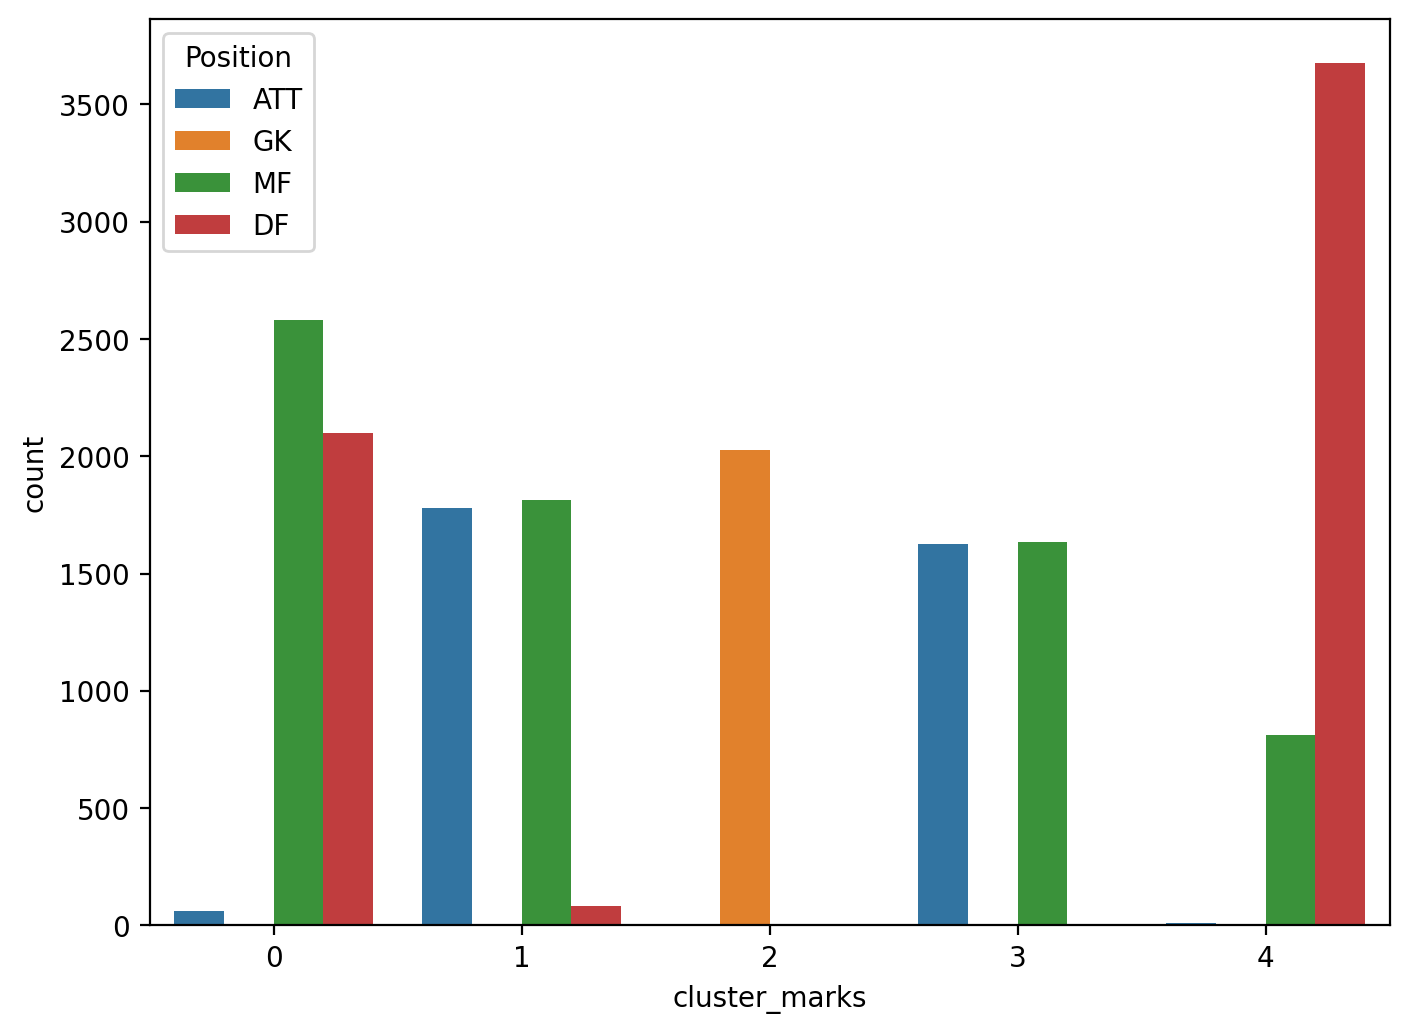

In [529]:
temp1(df)

In [530]:
temp(df, 'GKKicking')

GK, srednja vrednost GKKicking:  0.6719725651577504
GK, medijan vrednost GKKicking:  0.6666666666666667

NAPAD:
RF, srednja vrednost GKKicking:  0.11250000000000002
RF, medijan vrednost GKKicking:  0.09444444444444444

CF, srednja vrednost GKKicking:  0.0993993993993994
CF, medijan vrednost GKKicking:  0.1

LF, srednja vrednost GKKicking:  0.09407407407407406
LF, medijan vrednost GKKicking:  0.08888888888888889

RS, srednja vrednost GKKicking:  0.10711548987411056
RS, medijan vrednost GKKicking:  0.11111111111111112

ST, srednja vrednost GKKicking:  0.10835914677199573
ST, medijan vrednost GKKicking:  0.11111111111111112

LS, srednja vrednost GKKicking:  0.10703166935050992
LS, medijan vrednost GKKicking:  0.1

LW, srednja vrednost GKKicking:  0.10597841936424614
LW, medijan vrednost GKKicking:  0.1

RW, srednja vrednost GKKicking:  0.10558558558558558
RW, medijan vrednost GKKicking:  0.11111111111111112

VEZNI RED:
RDM, srednja vrednost GKKicking:  0.11227598566308246
RDM, medijan vre

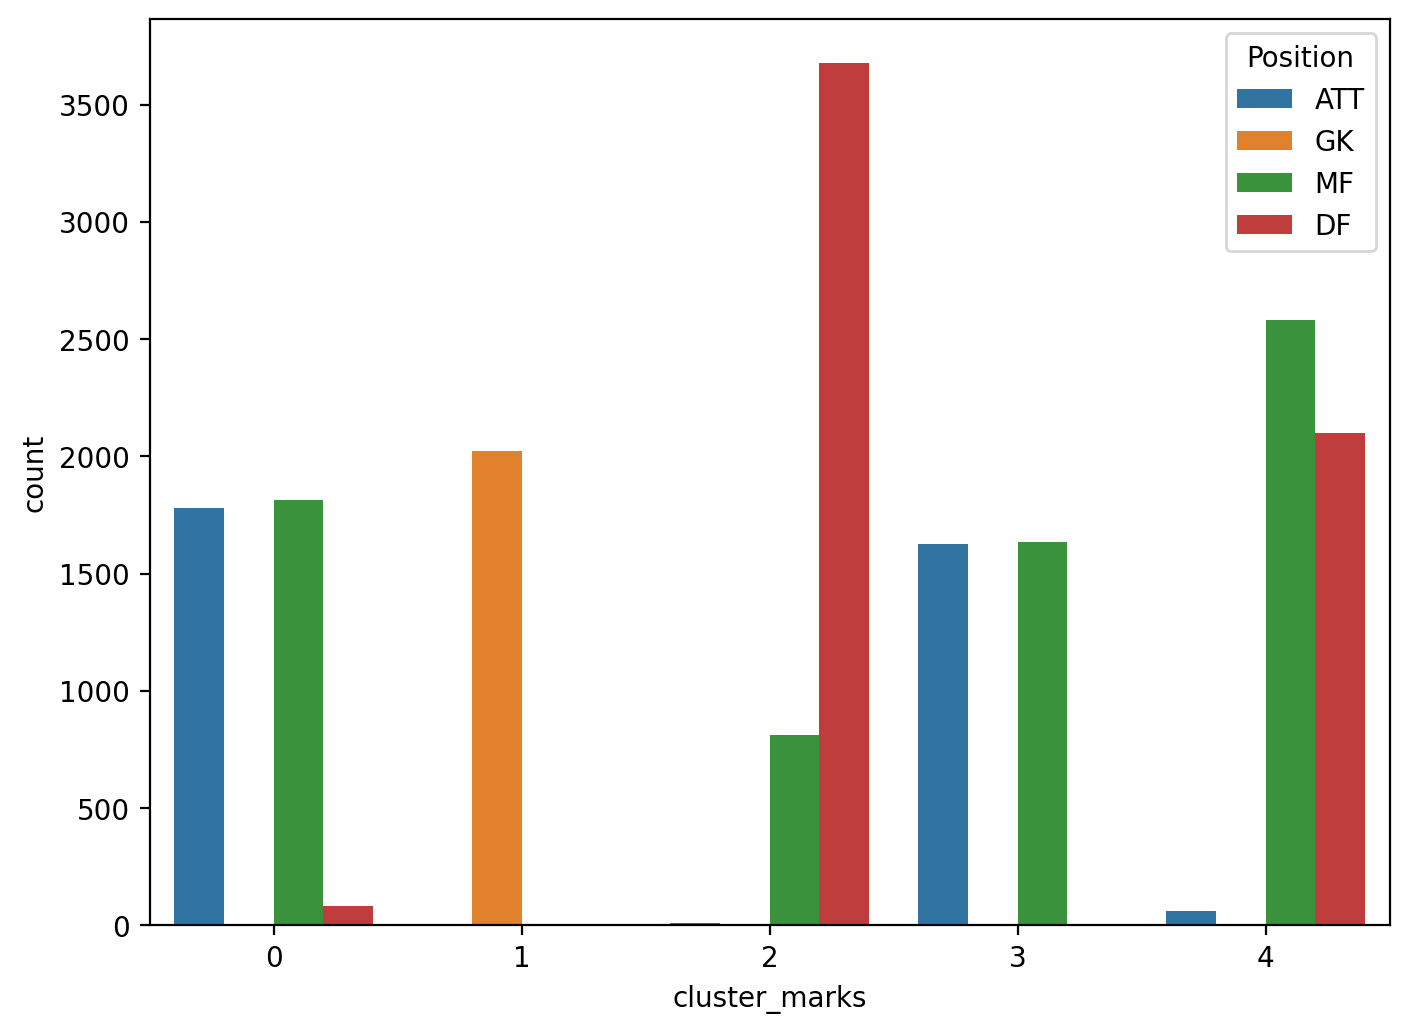

In [531]:
temp1(df)

In [532]:
temp(df, 'GKPositioning')

GK, srednja vrednost GKPositioning:  0.6971618809821057
GK, medijan vrednost GKPositioning:  0.696629213483146

NAPAD:
RF, srednja vrednost GKPositioning:  0.10603932584269662
RF, medijan vrednost GKPositioning:  0.10112359550561797

CF, srednja vrednost GKPositioning:  0.10081992104464015
CF, medijan vrednost GKPositioning:  0.10112359550561797

LF, srednja vrednost GKPositioning:  0.12059925093632959
LF, medijan vrednost GKPositioning:  0.1348314606741573

RS, srednja vrednost GKPositioning:  0.10820833563956385
RS, medijan vrednost GKPositioning:  0.10112359550561797

ST, srednja vrednost GKPositioning:  0.10849232535109597
ST, medijan vrednost GKPositioning:  0.11235955056179775

LS, srednja vrednost GKPositioning:  0.10427183412039298
LS, medijan vrednost GKPositioning:  0.10112359550561797

LW, srednja vrednost GKPositioning:  0.10478044177062137
LW, medijan vrednost GKPositioning:  0.10112359550561797

RW, srednja vrednost GKPositioning:  0.10464621925296082
RW, medijan vrednost

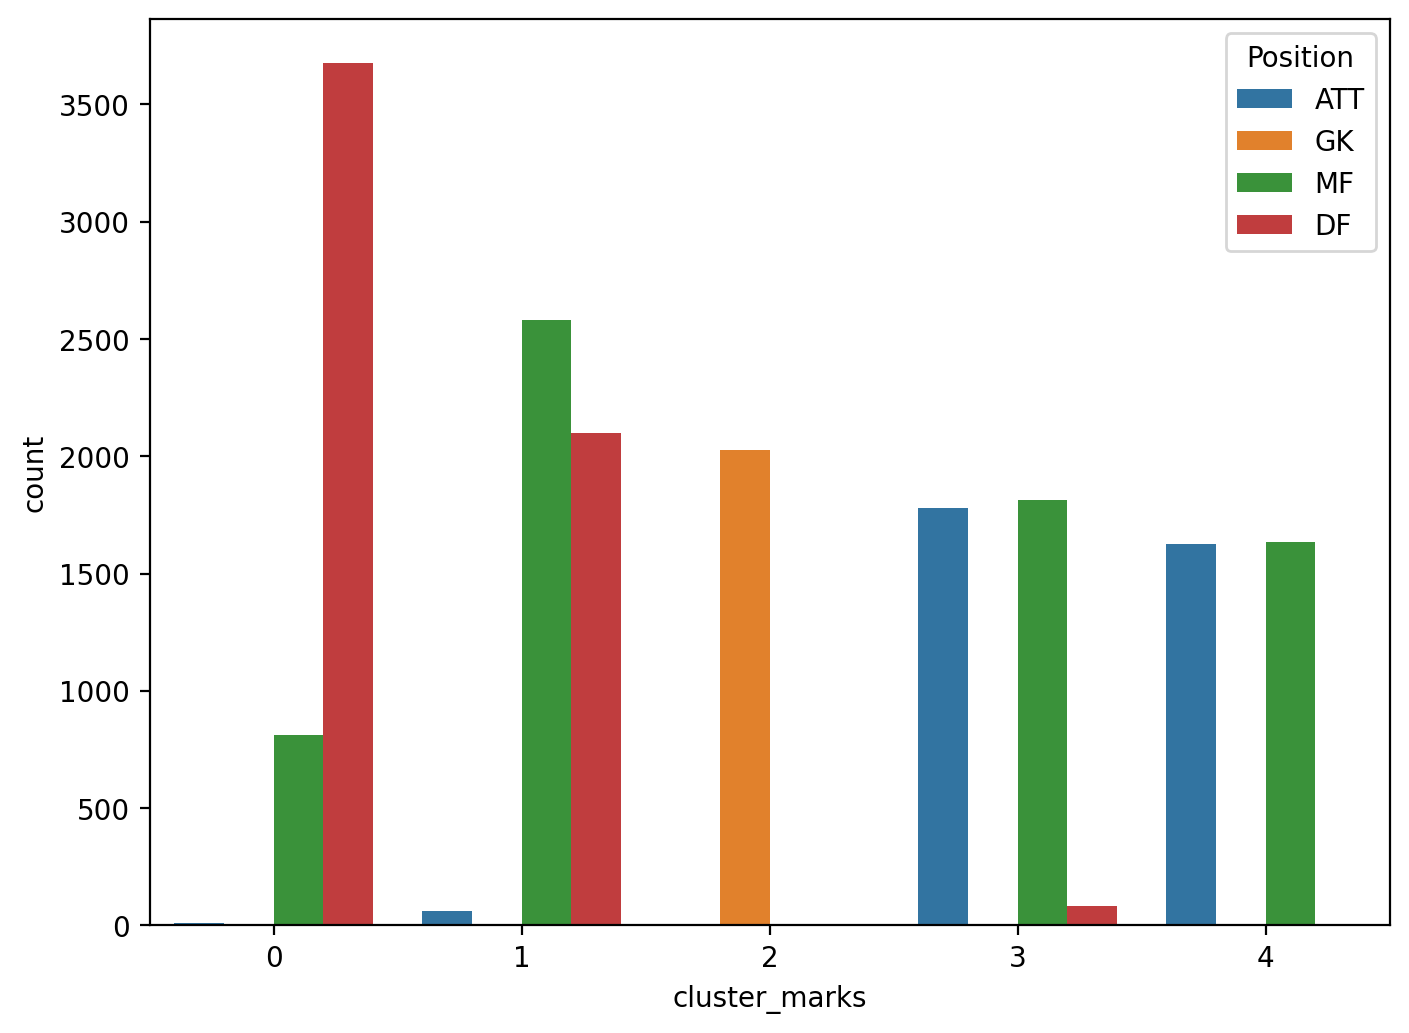

In [533]:
temp1(df)

In [534]:
temp(df, 'GKReflexes')

GK, srednja vrednost GKReflexes:  0.7000185848931368
GK, medijan vrednost GKReflexes:  0.6989247311827957

NAPAD:
RF, srednja vrednost GKReflexes:  0.09610215053763442
RF, medijan vrednost GKReflexes:  0.0913978494623656

CF, srednja vrednost GKReflexes:  0.09968032548677712
CF, medijan vrednost GKReflexes:  0.10215053763440861

LF, srednja vrednost GKReflexes:  0.10537634408602149
LF, medijan vrednost GKReflexes:  0.11827956989247311

RS, srednja vrednost GKReflexes:  0.102971555696806
RS, medijan vrednost GKReflexes:  0.09677419354838711

ST, srednja vrednost GKReflexes:  0.1036532043391993
ST, medijan vrednost GKReflexes:  0.10752688172043011

LS, srednja vrednost GKReflexes:  0.1032154173809153
LS, medijan vrednost GKReflexes:  0.09677419354838711

LW, srednja vrednost GKReflexes:  0.10128975813507184
LW, medijan vrednost GKReflexes:  0.09677419354838711

RW, srednja vrednost GKReflexes:  0.09959314152862539
RW, medijan vrednost GKReflexes:  0.09677419354838711

VEZNI RED:
RDM, sre

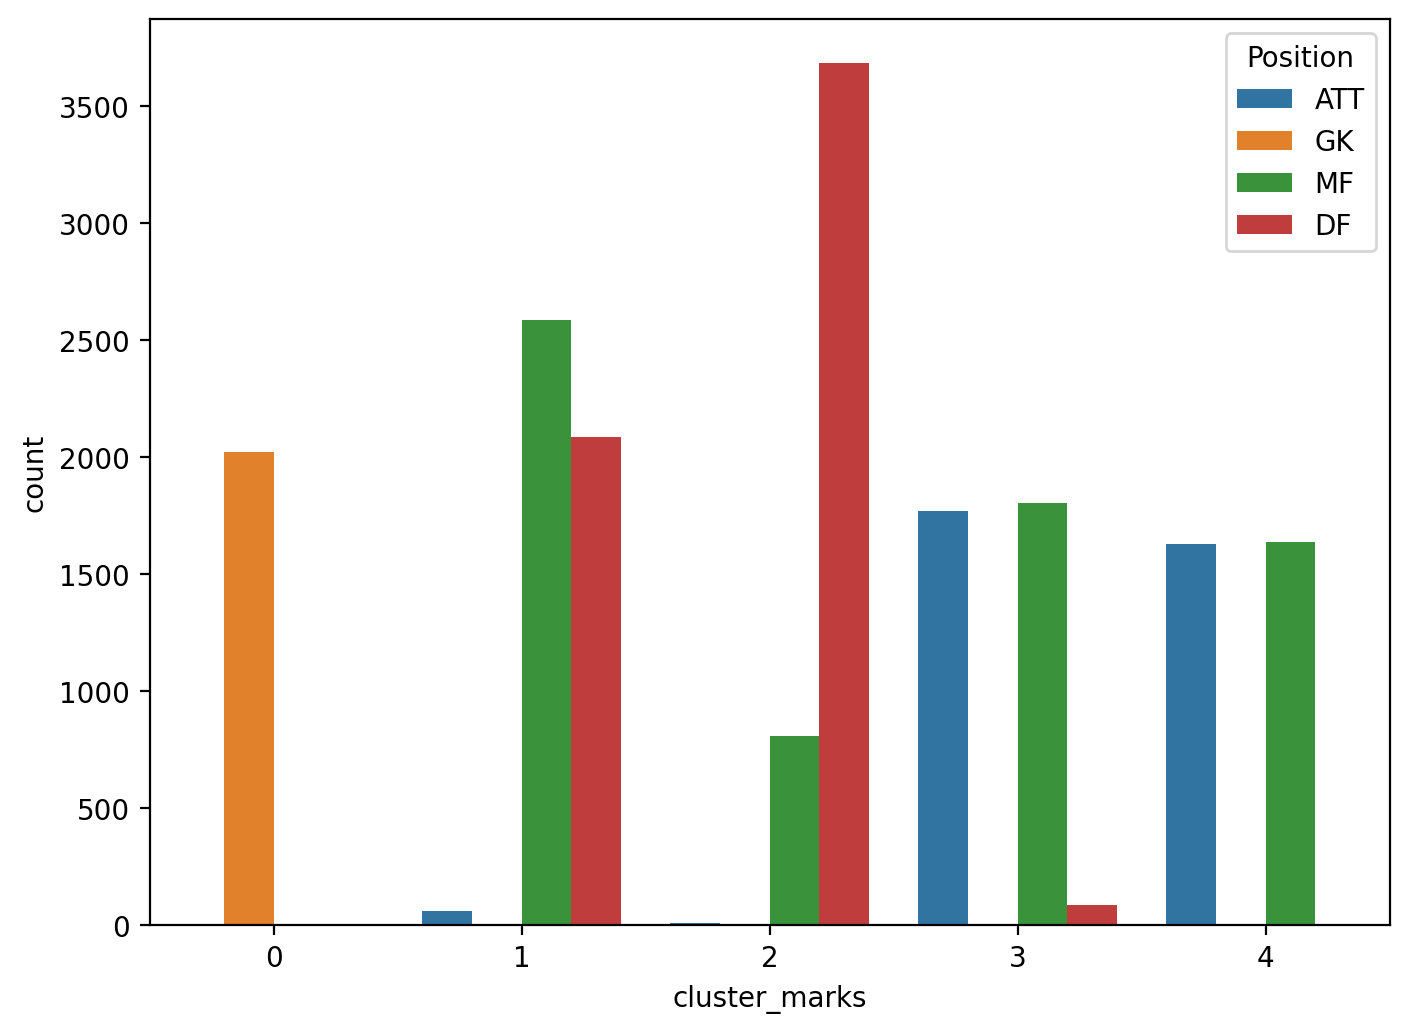

In [535]:
temp1(df)

In [536]:
kmeans = KMeans(n_clusters=5)
list_of_variables_to_drop = ['GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
kmeans.fit(df[numeric].drop(columns=list_of_variables_to_drop, axis=1))

KMeans(n_clusters=5)

In [537]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4735, (26.00648102378206 %)

NAPAD: 62 (1.3093980992608236 %)
Broj igraca na poziciji RF: 1, (0.021119324181626188 %)
Broj igraca na poziciji LF: 1, (0.021119324181626188 %)
Broj igraca na poziciji RW: 18, (0.3801478352692714 %)
Broj igraca na poziciji LW: 22, (0.46462513199577615 %)
Broj igraca na poziciji ST: 17, (0.3590285110876452 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 3, (0.06335797254487857 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 2586 (54.61457233368532 %)
Broj igraca na poziciji RDM: 190, (4.0126715945089755 %)
Broj igraca na poziciji CDM: 560, (11.826821541710665 %)
Broj igraca na poziciji LDM: 183, (3.8648363252375924 %)
Broj igraca na poziciji RM: 153, (3.2312565997888063 %)
Broj igraca na poziciji RCM: 287, (6.061246040126716 %)
Broj igraca na poziciji CM: 661, (13.959873284054911 %)
Broj igraca na poziciji LCM: 264, (5.575501583949313 %)
Broj igraca na poziciji LM: 157, (3.315733896515311 %)
Broj igraca 

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

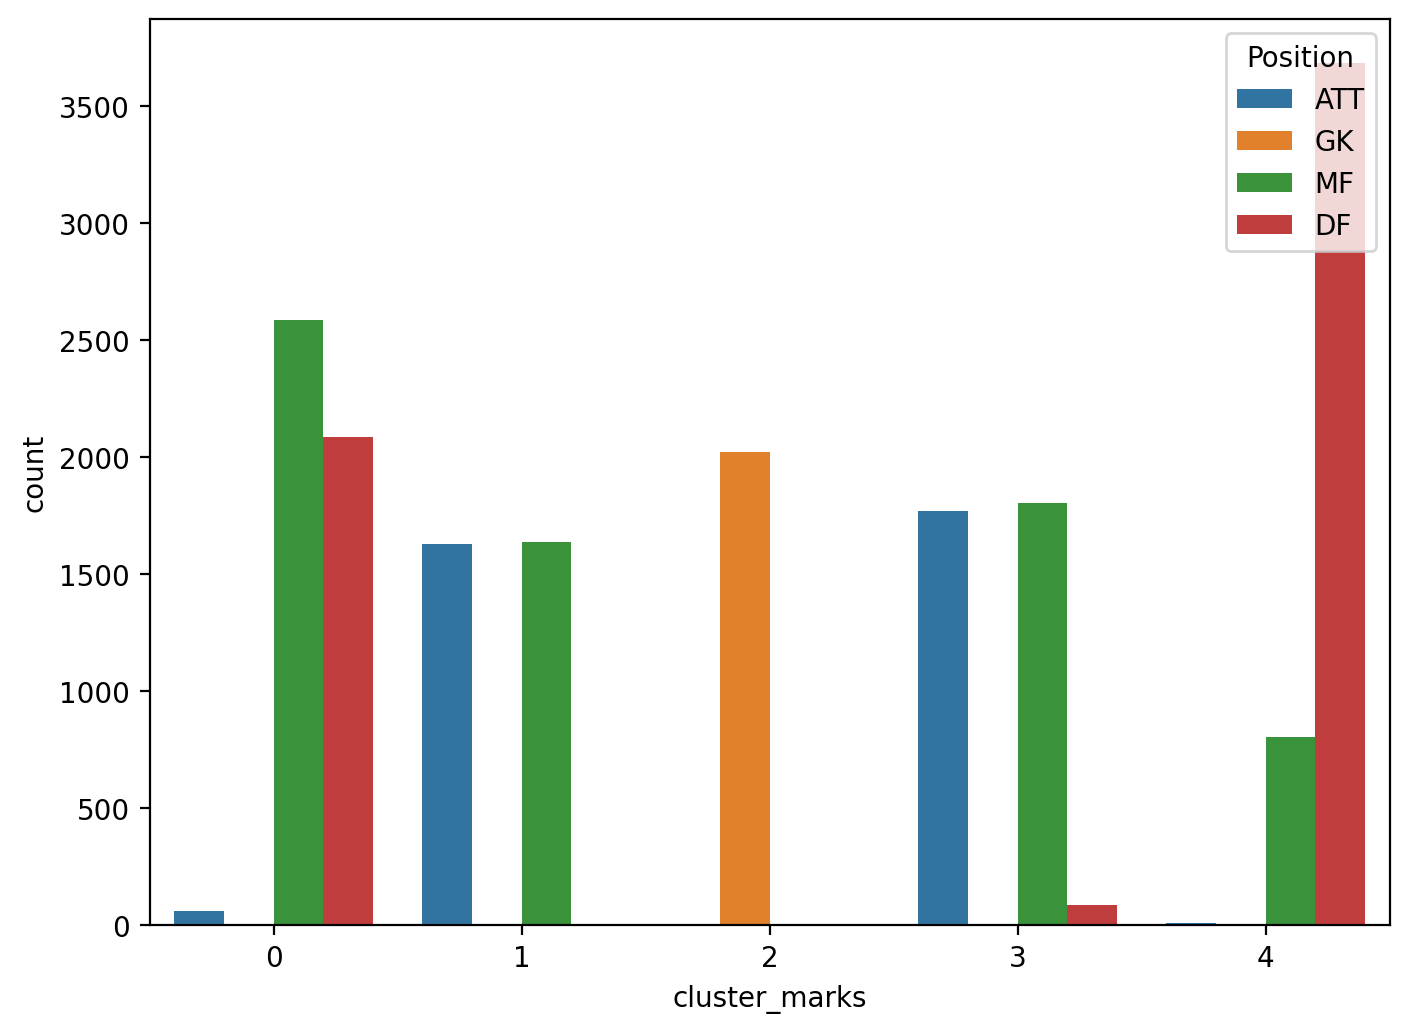

In [538]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [539]:
df[numeric].columns

Index(['Unnamed: 0', 'ID', 'Age', 'Overall', 'Potential', 'Special',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Jersey Number',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')

In [ ]:
# Ne cini golmana ni inferiornim ni superiornim

In [564]:
temp(df, 'ID')

GK, srednja vrednost ID:  0.8428954563231378
GK, medijan vrednost ID:  0.8780230653192973

NAPAD:
RF, srednja vrednost ID:  0.8107264075197482
RF, medijan vrednost ID:  0.8448078701075408

CF, srednja vrednost ID:  0.9057686094392715
CF, medijan vrednost ID:  0.9431598838623866

LF, srednja vrednost ID:  0.7855985034035673
LF, medijan vrednost ID:  0.8285915881332013

RS, srednja vrednost ID:  0.8305791986722016
RS, medijan vrednost ID:  0.846129827577817

ST, srednja vrednost ID:  0.8781983927171214
ST, medijan vrednost ID:  0.9123676014987591

LS, srednja vrednost ID:  0.8322495679866024
LS, medijan vrednost ID:  0.8585262201748551

LW, srednja vrednost ID:  0.9035597190024569
LW, medijan vrednost ID:  0.9290684660427243

RW, srednja vrednost ID:  0.8954275089025538
RW, medijan vrednost ID:  0.9206602488199704

VEZNI RED:
RDM, srednja vrednost ID:  0.8391599716353395
RDM, medijan vrednost ID:  0.860462522911226

CDM, srednja vrednost ID:  0.8682852638169382
CDM, medijan vrednost ID: 

In [551]:
temp(df, 'Age')

GK, srednja vrednost Age:  0.3463260962111537
GK, medijan vrednost Age:  0.31034482758620685

NAPAD:
RF, srednja vrednost Age:  0.40086206896551724
RF, medijan vrednost Age:  0.3793103448275862

CF, srednja vrednost Age:  0.2590866728797763
CF, medijan vrednost Age:  0.24137931034482762

LF, srednja vrednost Age:  0.37011494252873567
LF, medijan vrednost Age:  0.3793103448275862

RS, srednja vrednost Age:  0.368269067436725
RS, medijan vrednost Age:  0.3448275862068966

ST, srednja vrednost Age:  0.2994481511504646
ST, medijan vrednost Age:  0.27586206896551724

LS, srednja vrednost Age:  0.3726470098284191
LS, medijan vrednost Age:  0.3793103448275862

LW, srednja vrednost Age:  0.2555887410625396
LW, medijan vrednost Age:  0.24137931034482762

RW, srednja vrednost Age:  0.261789375582479
RW, medijan vrednost Age:  0.24137931034482762

VEZNI RED:
RDM, srednja vrednost Age:  0.3794493882091212
RDM, medijan vrednost Age:  0.3793103448275862

CDM, srednja vrednost Age:  0.318456278190018

In [553]:
# temp1(df)

In [554]:
temp(df, 'Overall')

GK, srednja vrednost Overall:  0.38733783383942977
GK, medijan vrednost Overall:  0.375

NAPAD:
RF, srednja vrednost Overall:  0.5677083333333334
RF, medijan vrednost Overall:  0.5208333333333334

CF, srednja vrednost Overall:  0.4130067567567567
CF, medijan vrednost Overall:  0.40625

LF, srednja vrednost Overall:  0.5805555555555556
LF, medijan vrednost Overall:  0.5208333333333333

RS, srednja vrednost Overall:  0.4900451559934318
RS, medijan vrednost Overall:  0.47916666666666674

ST, srednja vrednost Overall:  0.40479015973477994
ST, medijan vrednost Overall:  0.39583333333333326

LS, srednja vrednost Overall:  0.5013083735909823
LS, medijan vrednost Overall:  0.5

LW, srednja vrednost Overall:  0.42951662292213466
LW, medijan vrednost Overall:  0.41666666666666674

RW, srednja vrednost Overall:  0.43603603603603597
RW, medijan vrednost Overall:  0.4375

VEZNI RED:
RDM, srednja vrednost Overall:  0.49487567204301075
RDM, medijan vrednost Overall:  0.5

CDM, srednja vrednost Overal

In [555]:
temp(df, 'Potential')

GK, srednja vrednost Potential:  0.46380877331231946
GK, medijan vrednost Potential:  0.44680851063829796

NAPAD:
RF, srednja vrednost Potential:  0.583776595744681
RF, medijan vrednost Potential:  0.574468085106383

CF, srednja vrednost Potential:  0.5264519838987926
CF, medijan vrednost Potential:  0.5319148936170213

LF, srednja vrednost Potential:  0.6085106382978723
LF, medijan vrednost Potential:  0.5957446808510638

RS, srednja vrednost Potential:  0.5191279740069175
RS, medijan vrednost Potential:  0.5106382978723405

ST, srednja vrednost Potential:  0.4889865722750183
ST, medijan vrednost Potential:  0.4893617021276597

LS, srednja vrednost Potential:  0.5278034741494502
LS, medijan vrednost Potential:  0.5106382978723405

LW, srednja vrednost Potential:  0.5345395655330318
LW, medijan vrednost Potential:  0.5319148936170213

RW, srednja vrednost Potential:  0.5389304197814836
RW, medijan vrednost Potential:  0.5425531914893618

VEZNI RED:
RDM, srednja vrednost Potential:  0.5

In [556]:
temp(df, 'Special') # Cini golmana inferiornim!

GK, srednja vrednost Special:  0.19517333639108667
GK, medijan vrednost Special:  0.20371517027863778

NAPAD:
RF, srednja vrednost Special:  0.6937693498452012
RF, medijan vrednost Special:  0.6705882352941177

CF, srednja vrednost Special:  0.5785038908877919
CF, medijan vrednost Special:  0.5668730650154798

LF, srednja vrednost Special:  0.706295149638803
LF, medijan vrednost Special:  0.6575851393188854

RS, srednja vrednost Special:  0.6080983391541734
RS, medijan vrednost Special:  0.6167182662538699

ST, srednja vrednost Special:  0.5383259899562757
ST, medijan vrednost Special:  0.5380804953560372

LS, srednja vrednost Special:  0.6118394878927925
LS, medijan vrednost Special:  0.6068111455108358

LW, srednja vrednost Special:  0.5875852205780778
LW, medijan vrednost Special:  0.5894736842105264

RW, srednja vrednost Special:  0.5885967701447578
RW, medijan vrednost Special:  0.5873065015479876

VEZNI RED:
RDM, srednja vrednost Special:  0.6737191650853889
RDM, medijan vrednost

In [557]:
temp(df, 'International Reputation')

GK, srednja vrednost International Reputation:  0.023950617283950617
GK, medijan vrednost International Reputation:  0.0

NAPAD:
RF, srednja vrednost International Reputation:  0.140625
RF, medijan vrednost International Reputation:  0.0

CF, srednja vrednost International Reputation:  0.0472972972972973
CF, medijan vrednost International Reputation:  0.0

LF, srednja vrednost International Reputation:  0.16666666666666666
LF, medijan vrednost International Reputation:  0.0

RS, srednja vrednost International Reputation:  0.05295566502463054
RS, medijan vrednost International Reputation:  0.0

ST, srednja vrednost International Reputation:  0.029321277181162543
ST, medijan vrednost International Reputation:  0.0

LS, srednja vrednost International Reputation:  0.05555555555555555
LS, medijan vrednost International Reputation:  0.0

LW, srednja vrednost International Reputation:  0.026246719160104987
LW, medijan vrednost International Reputation:  0.0

RW, srednja vrednost International

In [558]:
temp(df, 'Weak Foot')

GK, srednja vrednost Weak Foot:  0.37246913580246915
GK, medijan vrednost Weak Foot:  0.5

NAPAD:
RF, srednja vrednost Weak Foot:  0.609375
RF, medijan vrednost Weak Foot:  0.5

CF, srednja vrednost Weak Foot:  0.5608108108108109
CF, medijan vrednost Weak Foot:  0.5

LF, srednja vrednost Weak Foot:  0.65
LF, medijan vrednost Weak Foot:  0.75

RS, srednja vrednost Weak Foot:  0.5529556650246306
RS, medijan vrednost Weak Foot:  0.5

ST, srednja vrednost Weak Foot:  0.5165540625320221
ST, medijan vrednost Weak Foot:  0.5

LS, srednja vrednost Weak Foot:  0.5628019323671497
LS, medijan vrednost Weak Foot:  0.5

LW, srednja vrednost Weak Foot:  0.5439632545931758
LW, medijan vrednost Weak Foot:  0.5

RW, srednja vrednost Weak Foot:  0.5452702702702703
RW, medijan vrednost Weak Foot:  0.5

VEZNI RED:
RDM, srednja vrednost Weak Foot:  0.5181451612903226
RDM, medijan vrednost Weak Foot:  0.5

CDM, srednja vrednost Weak Foot:  0.4923523206751055
CDM, medijan vrednost Weak Foot:  0.5

LDM, sredn

In [559]:
temp(df, 'Jersey Number')

GK, srednja vrednost Jersey Number:  0.19914840010078103
GK, medijan vrednost Jersey Number:  0.2040816326530612

NAPAD:
RF, srednja vrednost Jersey Number:  0.13137755102040816
RF, medijan vrednost Jersey Number:  0.09693877551020408

CF, srednja vrednost Jersey Number:  0.21704357418643128
CF, medijan vrednost Jersey Number:  0.17857142857142855

LF, srednja vrednost Jersey Number:  0.16122448979591833
LF, medijan vrednost Jersey Number:  0.1020408163265306

RS, srednja vrednost Jersey Number:  0.1709560671559264
RS, medijan vrednost Jersey Number:  0.1020408163265306

ST, srednja vrednost Jersey Number:  0.2192621219434087
ST, medijan vrednost Jersey Number:  0.18367346938775508

LS, srednja vrednost Jersey Number:  0.1815537809326629
LS, medijan vrednost Jersey Number:  0.12244897959183672

LW, srednja vrednost Jersey Number:  0.21822272215973001
LW, medijan vrednost Jersey Number:  0.173469387755102

RW, srednja vrednost Jersey Number:  0.22233866519580806
RW, medijan vrednost Jer

In [560]:
temp(df, 'Jumping')

GK, srednja vrednost Jumping:  0.5337283950617285
GK, medijan vrednost Jumping:  0.55

NAPAD:
RF, srednja vrednost Jumping:  0.58984375
RF, medijan vrednost Jumping:  0.6062500000000001

CF, srednja vrednost Jumping:  0.6173986486486487
CF, medijan vrednost Jumping:  0.625

LF, srednja vrednost Jumping:  0.7033333333333334
LF, medijan vrednost Jumping:  0.75

RS, srednja vrednost Jumping:  0.6859605911330049
RS, medijan vrednost Jumping:  0.7000000000000001

ST, srednja vrednost Jumping:  0.6620608767371043
ST, medijan vrednost Jumping:  0.6625000000000001

LS, srednja vrednost Jumping:  0.6783816425120773
LS, medijan vrednost Jumping:  0.6875

LW, srednja vrednost Jumping:  0.5576771653543308
LW, medijan vrednost Jumping:  0.5625

RW, srednja vrednost Jumping:  0.5588175675675676
RW, medijan vrednost Jumping:  0.5687500000000001

VEZNI RED:
RDM, srednja vrednost Jumping:  0.6641633064516128
RDM, medijan vrednost Jumping:  0.6625000000000001

CDM, srednja vrednost Jumping:  0.641046940

In [561]:
temp(df, 'Strength')

GK, srednja vrednost Strength:  0.545037037037037
GK, medijan vrednost Strength:  0.5625

NAPAD:
RF, srednja vrednost Strength:  0.5796875
RF, medijan vrednost Strength:  0.55625

CF, srednja vrednost Strength:  0.5045608108108108
CF, medijan vrednost Strength:  0.525

LF, srednja vrednost Strength:  0.5675000000000001
LF, medijan vrednost Strength:  0.5875

RS, srednja vrednost Strength:  0.6884236453201971
RS, medijan vrednost Strength:  0.7000000000000001

ST, srednja vrednost Strength:  0.6484627847697957
ST, medijan vrednost Strength:  0.6625

LS, srednja vrednost Strength:  0.685990338164251
LS, medijan vrednost Strength:  0.6875

LW, srednja vrednost Strength:  0.49534120734908144
LW, medijan vrednost Strength:  0.5125000000000001

RW, srednja vrednost Strength:  0.4849662162162162
RW, medijan vrednost Strength:  0.5125000000000001

VEZNI RED:
RDM, srednja vrednost Strength:  0.6695060483870968
RDM, medijan vrednost Strength:  0.6875

CDM, srednja vrednost Strength:  0.641930379

In [562]:
temp(df, 'Composure') # Cini golmana inferiornim!

GK, srednja vrednost Composure:  0.45292977565379006
GK, medijan vrednost Composure:  0.4623655913978495

NAPAD:
RF, srednja vrednost Composure:  0.7204301075268817
RF, medijan vrednost Composure:  0.7043010752688172

CF, srednja vrednost Composure:  0.6232199941877362
CF, medijan vrednost Composure:  0.6021505376344087

LF, srednja vrednost Composure:  0.7218637992831543
LF, medijan vrednost Composure:  0.6774193548387097

RS, srednja vrednost Composure:  0.6594628952804706
RS, medijan vrednost Composure:  0.6666666666666667

ST, srednja vrednost Composure:  0.6112072815532126
ST, medijan vrednost Composure:  0.6021505376344087

LS, srednja vrednost Composure:  0.6702508960573479
LS, medijan vrednost Composure:  0.6774193548387097

LW, srednja vrednost Composure:  0.6220190218158216
LW, medijan vrednost Composure:  0.6236559139784947

RW, srednja vrednost Composure:  0.6227840743969778
RW, medijan vrednost Composure:  0.6236559139784947

VEZNI RED:
RDM, srednja vrednost Composure:  0.

In [563]:
temp(df, 'Marking') # Cini golmana inferiornim

GK, srednja vrednost Marking:  0.13434269434269436
GK, medijan vrednost Marking:  0.1208791208791209

NAPAD:
RF, srednja vrednost Marking:  0.41689560439560447
RF, medijan vrednost Marking:  0.39560439560439564

CF, srednja vrednost Marking:  0.32551232551232556
CF, medijan vrednost Marking:  0.29670329670329676

LF, srednja vrednost Marking:  0.4051282051282052
LF, medijan vrednost Marking:  0.38461538461538464

RS, srednja vrednost Marking:  0.33291831321387977
RS, medijan vrednost Marking:  0.3186813186813187

ST, srednja vrednost Marking:  0.2897259599238712
ST, medijan vrednost Marking:  0.27472527472527475

LS, srednja vrednost Marking:  0.33227159314115845
LS, medijan vrednost Marking:  0.3186813186813187

LW, srednja vrednost Marking:  0.35906088661994173
LW, medijan vrednost Marking:  0.34065934065934067

RW, srednja vrednost Marking:  0.3594891594891595
RW, medijan vrednost Marking:  0.34065934065934067

VEZNI RED:
RDM, srednja vrednost Marking:  0.6770205600850763
RDM, medij

# Zadrzati kolone koje golmane ne cine ni inferiornim ni superiornim

In [905]:


keep_columns = ['ID', 'Age', 'Overall', 'Potential', 
                'International Reputation', 'Weak Foot',
                'Jersey Number', 'Jumping', 'Strength']

kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [906]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 1508, (8.28252869775361 %)

NAPAD: 327 (21.684350132625994 %)
Broj igraca na poziciji RF: 4, (0.2652519893899204 %)
Broj igraca na poziciji LF: 5, (0.33156498673740054 %)
Broj igraca na poziciji RW: 37, (2.453580901856764 %)
Broj igraca na poziciji LW: 26, (1.7241379310344827 %)
Broj igraca na poziciji ST: 184, (12.20159151193634 %)
Broj igraca na poziciji CF: 10, (0.6631299734748011 %)
Broj igraca na poziciji RS: 31, (2.0557029177718835 %)
Broj igraca na poziciji LS: 30, (1.989389920424403 %)

VEZNI RED: 603 (39.9867374005305 %)
Broj igraca na poziciji RDM: 24, (1.5915119363395225 %)
Broj igraca na poziciji CDM: 91, (6.0344827586206895 %)
Broj igraca na poziciji LDM: 21, (1.3925729442970822 %)
Broj igraca na poziciji RM: 82, (5.437665782493369 %)
Broj igraca na poziciji RCM: 58, (3.8461538461538463 %)
Broj igraca na poziciji CM: 87, (5.769230769230769 %)
Broj igraca na poziciji LCM: 56, (3.7135278514588856 %)
Broj igraca na poziciji LM: 83, (5.503978779840849

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

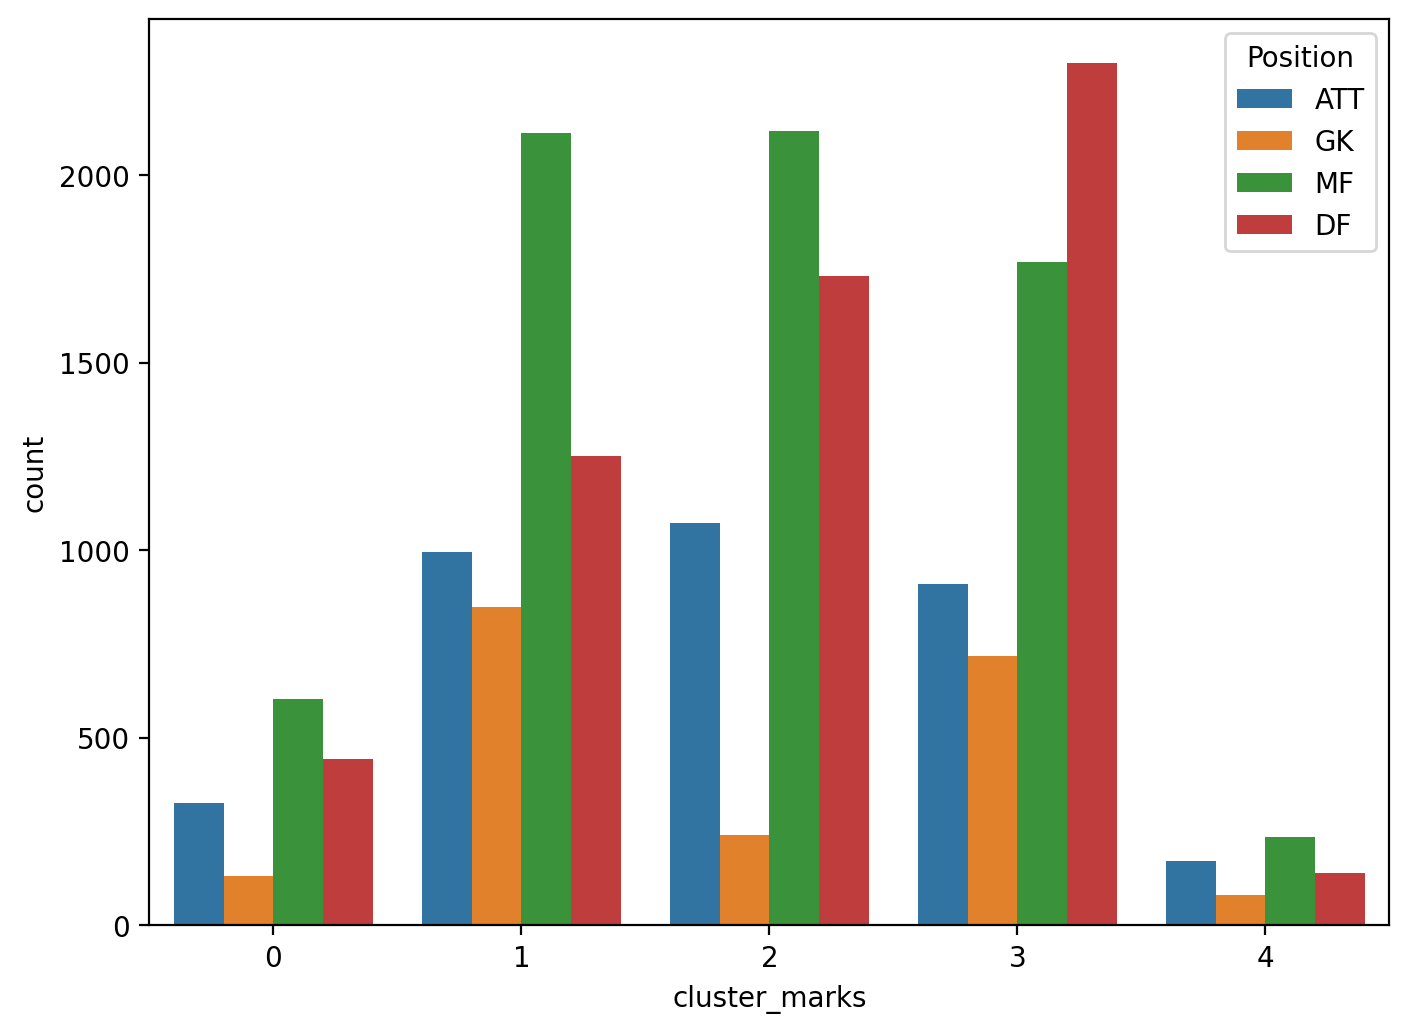

In [907]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [908]:
# Dodavanje parametara koji golmane cine inferiornim

keep_columns += ['Acceleration']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [909]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4593, (25.226561212720384 %)

NAPAD: 571 (12.431961680818638 %)
Broj igraca na poziciji RF: 1, (0.021772262138036142 %)
Broj igraca na poziciji LF: 1, (0.021772262138036142 %)
Broj igraca na poziciji RW: 14, (0.30481166993250597 %)
Broj igraca na poziciji LW: 18, (0.3919007184846506 %)
Broj igraca na poziciji ST: 450, (9.797517962116265 %)
Broj igraca na poziciji CF: 7, (0.15240583496625298 %)
Broj igraca na poziciji RS: 41, (0.8926627476594818 %)
Broj igraca na poziciji LS: 39, (0.8491182233834096 %)

VEZNI RED: 1137 (24.755062050947092 %)
Broj igraca na poziciji RDM: 84, (1.8288700195950358 %)
Broj igraca na poziciji CDM: 279, (6.074461136512084 %)
Broj igraca na poziciji LDM: 86, (1.8724145438711082 %)
Broj igraca na poziciji RM: 83, (1.8070977574569997 %)
Broj igraca na poziciji RCM: 98, (2.133681689527542 %)
Broj igraca na poziciji CM: 232, (5.051164816024385 %)
Broj igraca na poziciji LCM: 89, (1.9377313302852168 %)
Broj igraca na poziciji LM: 67, (1.458

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

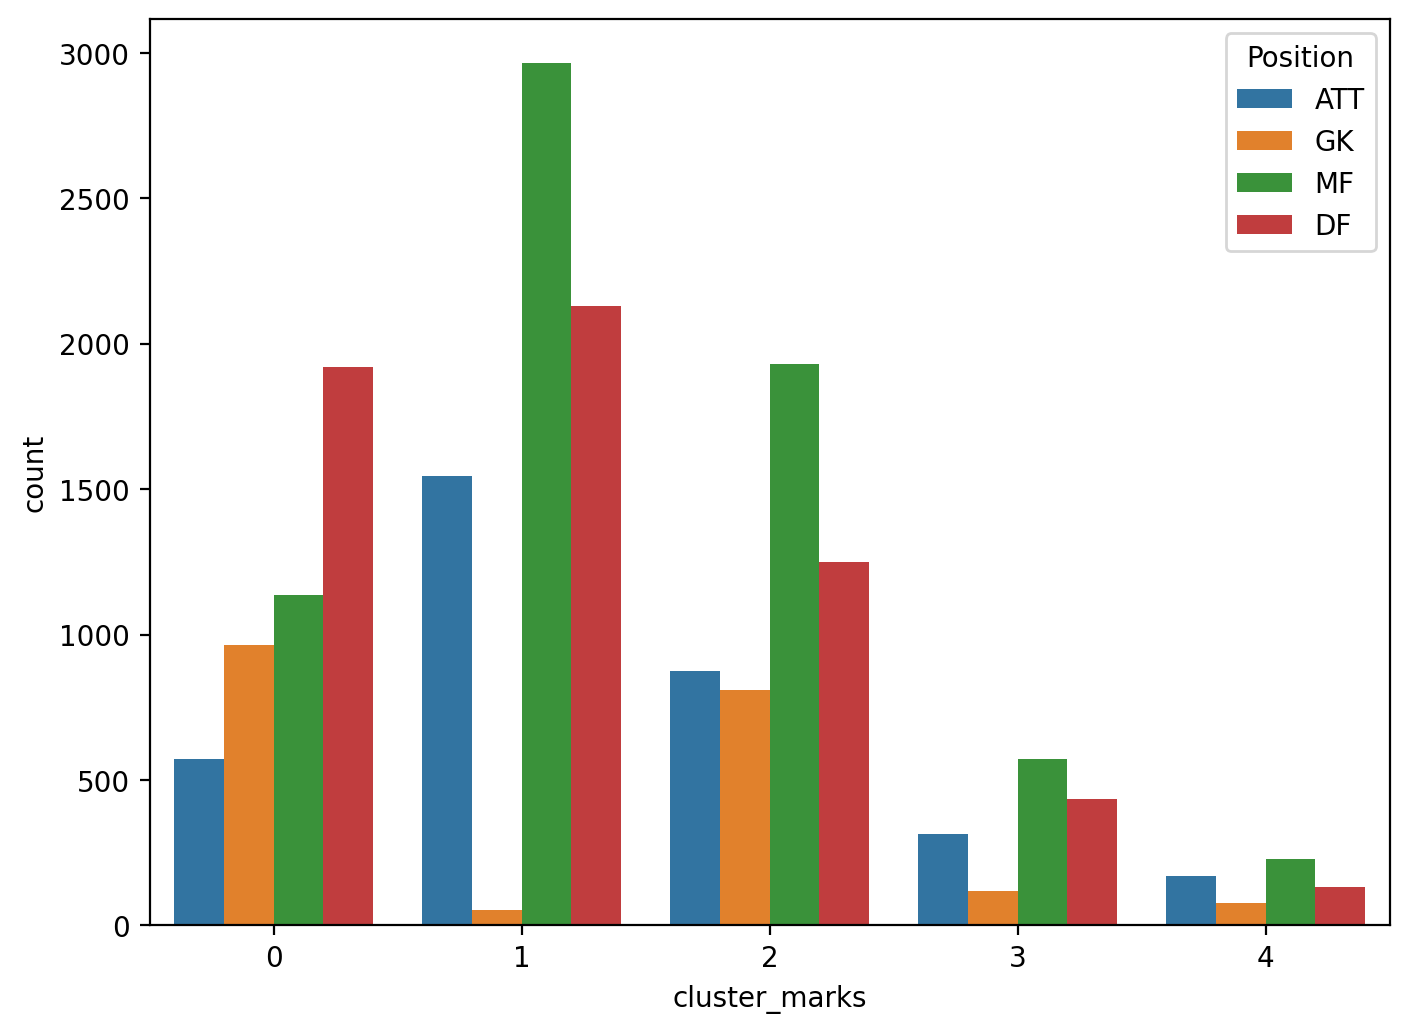

In [910]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [911]:
keep_columns += ['Dribbling']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [912]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4335, (23.809523809523807 %)

NAPAD: 1027 (23.690888119953865 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 117, (2.698961937716263 %)
Broj igraca na poziciji LW: 125, (2.883506343713956 %)
Broj igraca na poziciji ST: 721, (16.6320645905421 %)
Broj igraca na poziciji CF: 28, (0.6459054209919263 %)
Broj igraca na poziciji RS: 15, (0.34602076124567477 %)
Broj igraca na poziciji LS: 21, (0.4844290657439446 %)

VEZNI RED: 2014 (46.45905420991926 %)
Broj igraca na poziciji RDM: 20, (0.461361014994233 %)
Broj igraca na poziciji CDM: 263, (6.066897347174164 %)
Broj igraca na poziciji LDM: 36, (0.8304498269896194 %)
Broj igraca na poziciji RM: 336, (7.750865051903114 %)
Broj igraca na poziciji RCM: 50, (1.1534025374855825 %)
Broj igraca na poziciji CM: 638, (14.717416378316031 %)
Broj igraca na poziciji LCM: 48, (1.107266435986159 %)
Broj igraca na poziciji LM: 319, (7.3587081891580155 %)
Broj igraca na po

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

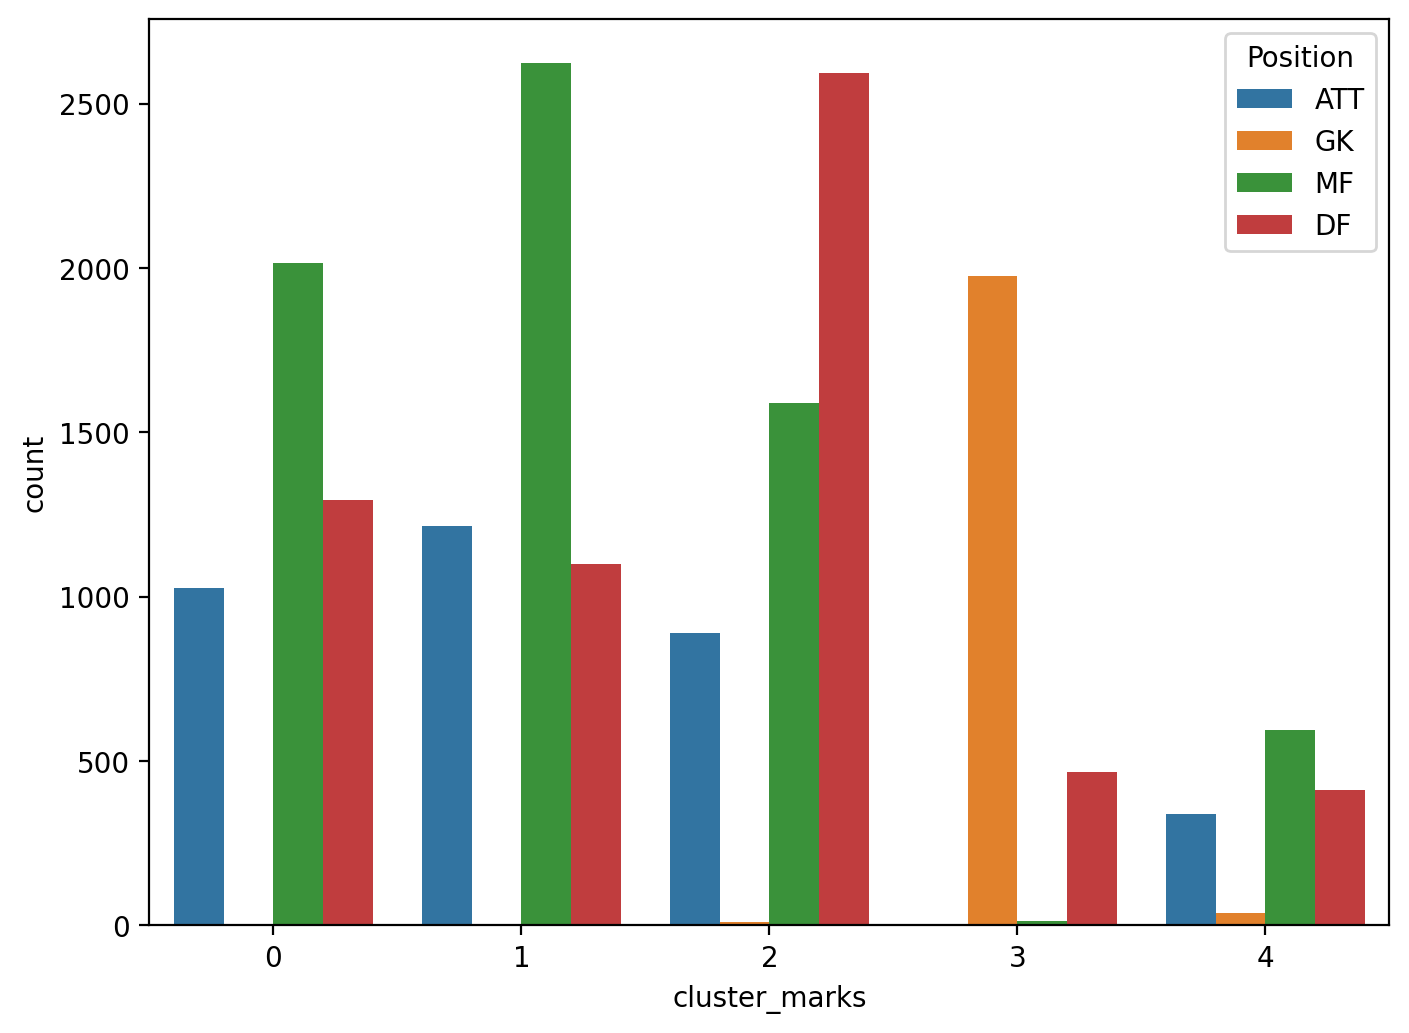

In [913]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [914]:
keep_columns += ['SprintSpeed']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [915]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4263, (23.414071510957324 %)

NAPAD: 946 (22.190945343654704 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 106, (2.4865118461177573 %)
Broj igraca na poziciji LW: 106, (2.4865118461177573 %)
Broj igraca na poziciji ST: 679, (15.92775041050903 %)
Broj igraca na poziciji CF: 24, (0.5629838142153413 %)
Broj igraca na poziciji RS: 15, (0.3518648838845883 %)
Broj igraca na poziciji LS: 16, (0.37532254281022753 %)

VEZNI RED: 1999 (46.8918601923528 %)
Broj igraca na poziciji RDM: 23, (0.539526155289702 %)
Broj igraca na poziciji CDM: 270, (6.33356790992259 %)
Broj igraca na poziciji LDM: 40, (0.9383063570255689 %)
Broj igraca na poziciji RM: 305, (7.154585972319963 %)
Broj igraca na poziciji RCM: 48, (1.1259676284306825 %)
Broj igraca na poziciji CM: 660, (15.482054890921887 %)
Broj igraca na poziciji LCM: 47, (1.1025099695050433 %)
Broj igraca na poziciji LM: 301, (7.060755336617405 %)
Broj igraca na po

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

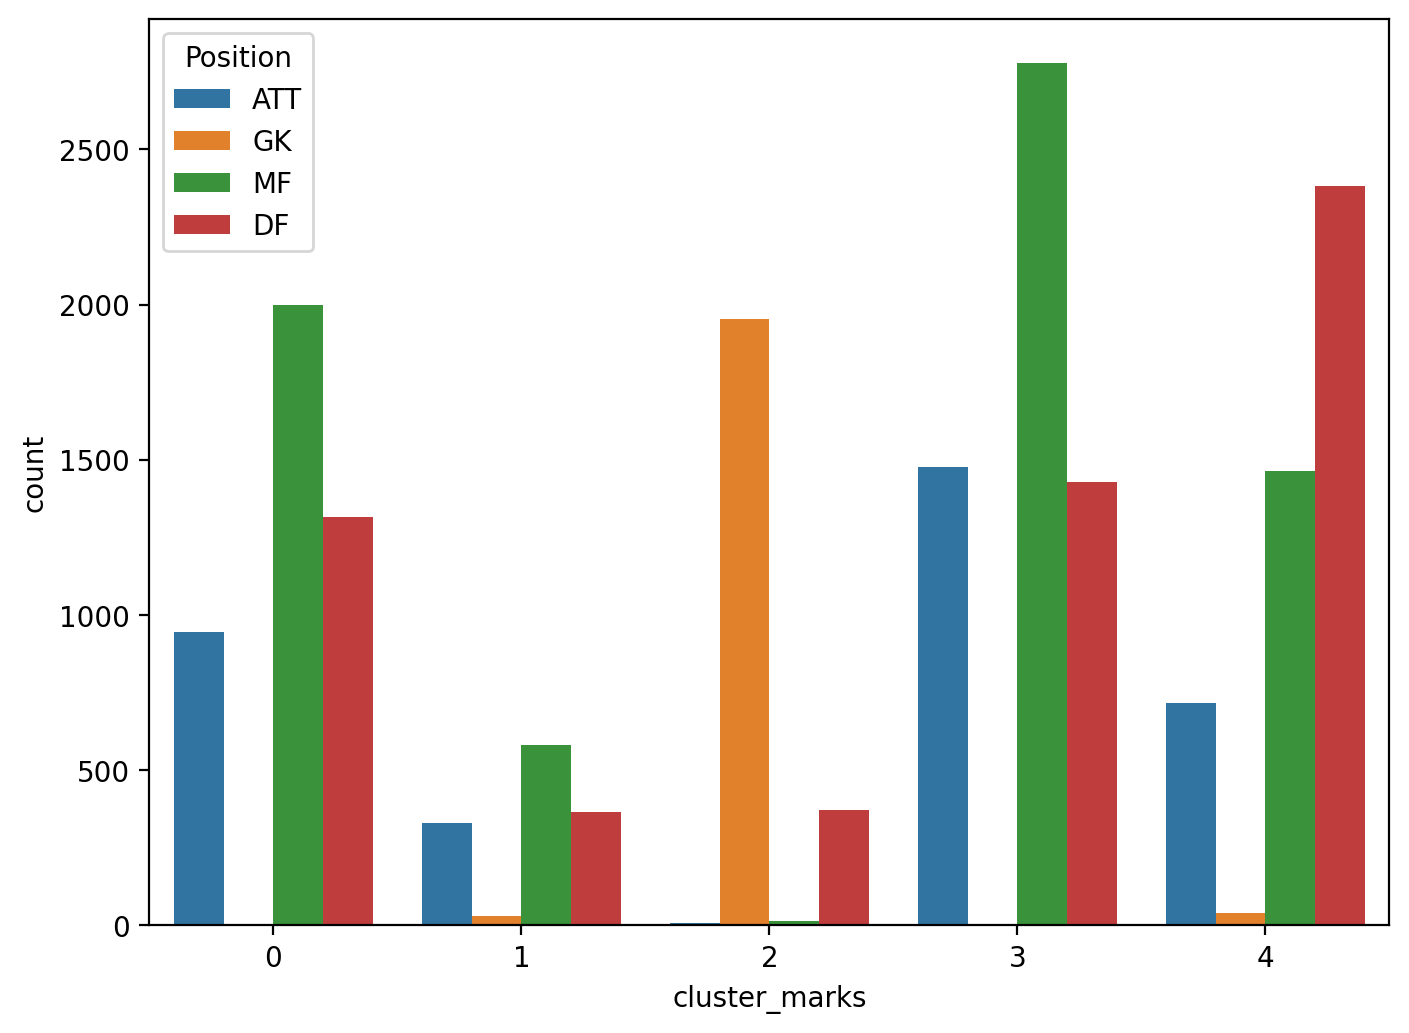

In [916]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [917]:
keep_columns += ['Agility']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [918]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4608, (25.308947108255065 %)

NAPAD: 748 (16.23263888888889 %)
Broj igraca na poziciji RF: 2, (0.043402777777777776 %)
Broj igraca na poziciji LF: 1, (0.021701388888888888 %)
Broj igraca na poziciji RW: 10, (0.2170138888888889 %)
Broj igraca na poziciji LW: 13, (0.2821180555555555 %)
Broj igraca na poziciji ST: 607, (13.172743055555555 %)
Broj igraca na poziciji CF: 6, (0.13020833333333331 %)
Broj igraca na poziciji RS: 51, (1.1067708333333335 %)
Broj igraca na poziciji LS: 58, (1.2586805555555556 %)

VEZNI RED: 1442 (31.29340277777778 %)
Broj igraca na poziciji RDM: 131, (2.842881944444444 %)
Broj igraca na poziciji CDM: 402, (8.723958333333332 %)
Broj igraca na poziciji LDM: 115, (2.4956597222222223 %)
Broj igraca na poziciji RM: 82, (1.7795138888888888 %)
Broj igraca na poziciji RCM: 138, (2.994791666666667 %)
Broj igraca na poziciji CM: 293, (6.358506944444445 %)
Broj igraca na poziciji LCM: 119, (2.5824652777777777 %)
Broj igraca na poziciji LM: 58, (1.25

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

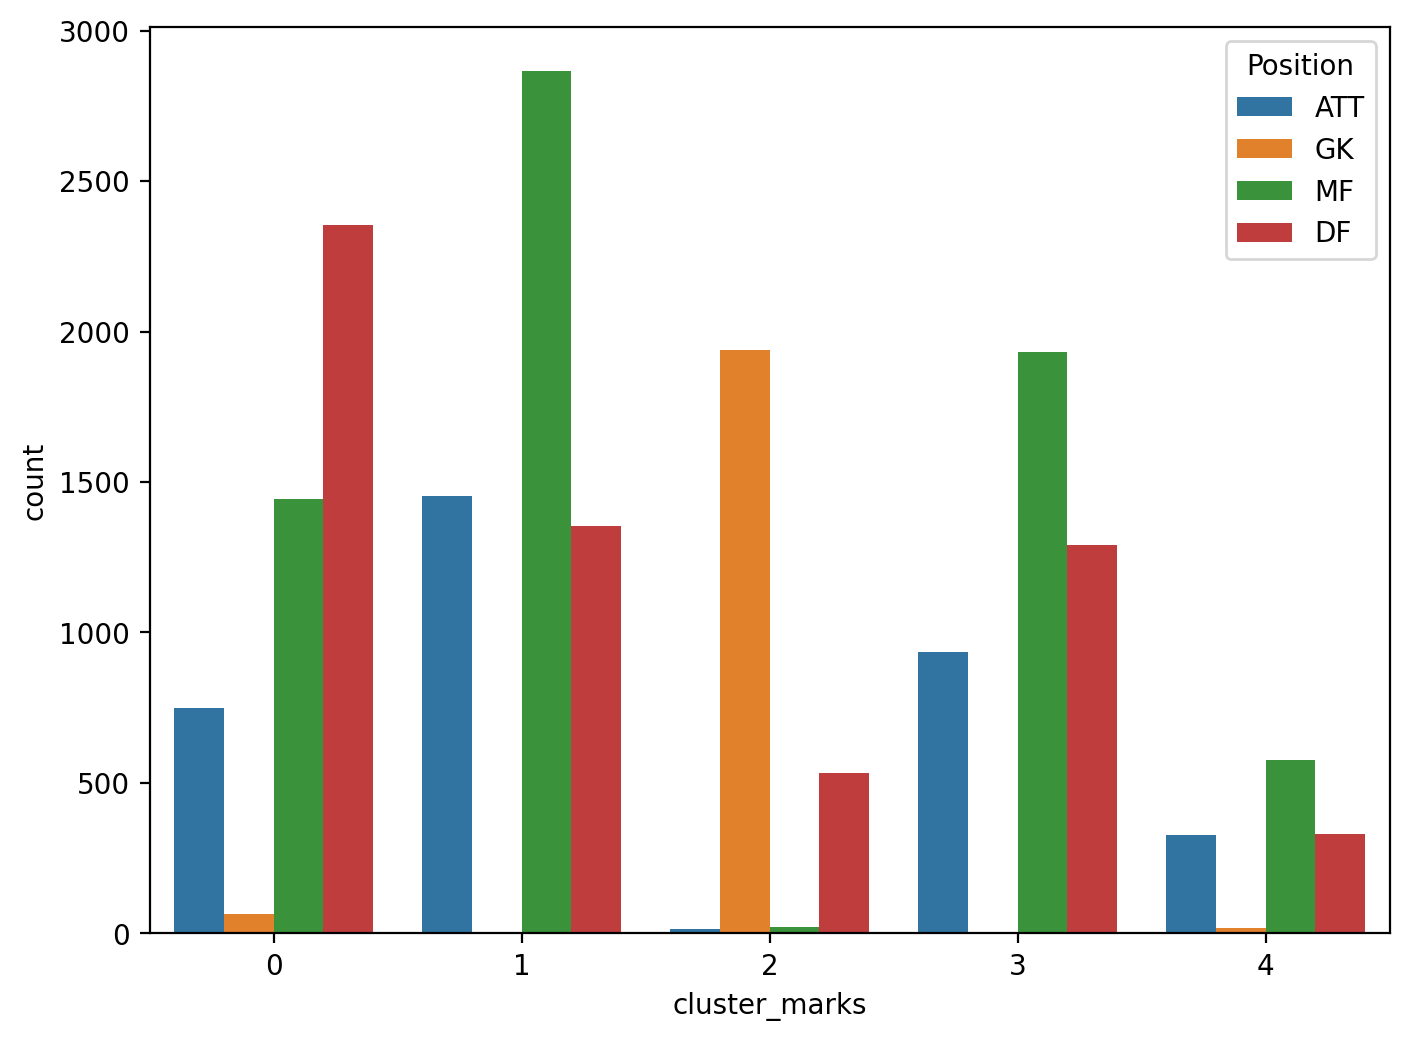

In [919]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [922]:
keep_columns += ['Skill Moves']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [923]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))


Broj igraca u klasteru 0: 5755, (31.608721920140603 %)

NAPAD: 1480 (25.716768027801912 %)
Broj igraca na poziciji RF: 10, (0.1737619461337967 %)
Broj igraca na poziciji LF: 9, (0.15638575152041703 %)
Broj igraca na poziciji RW: 234, (4.0660295395308435 %)
Broj igraca na poziciji LW: 253, (4.396177237185057 %)
Broj igraca na poziciji ST: 739, (12.841007819287576 %)
Broj igraca na poziciji CF: 38, (0.6602953953084275 %)
Broj igraca na poziciji RS: 99, (1.7202432667245873 %)
Broj igraca na poziciji LS: 98, (1.7028670721112076 %)

VEZNI RED: 3104 (53.9357080799305 %)
Broj igraca na poziciji RDM: 78, (1.3553431798436144 %)
Broj igraca na poziciji CDM: 192, (3.336229365768897 %)
Broj igraca na poziciji LDM: 75, (1.3032145960034751 %)
Broj igraca na poziciji RM: 720, (12.510860121633364 %)
Broj igraca na poziciji RCM: 173, (3.006081668114683 %)
Broj igraca na poziciji CM: 433, (7.523892267593397 %)
Broj igraca na poziciji LCM: 186, (3.2319721980886187 %)
Broj igraca na poziciji LM: 693, (12.

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

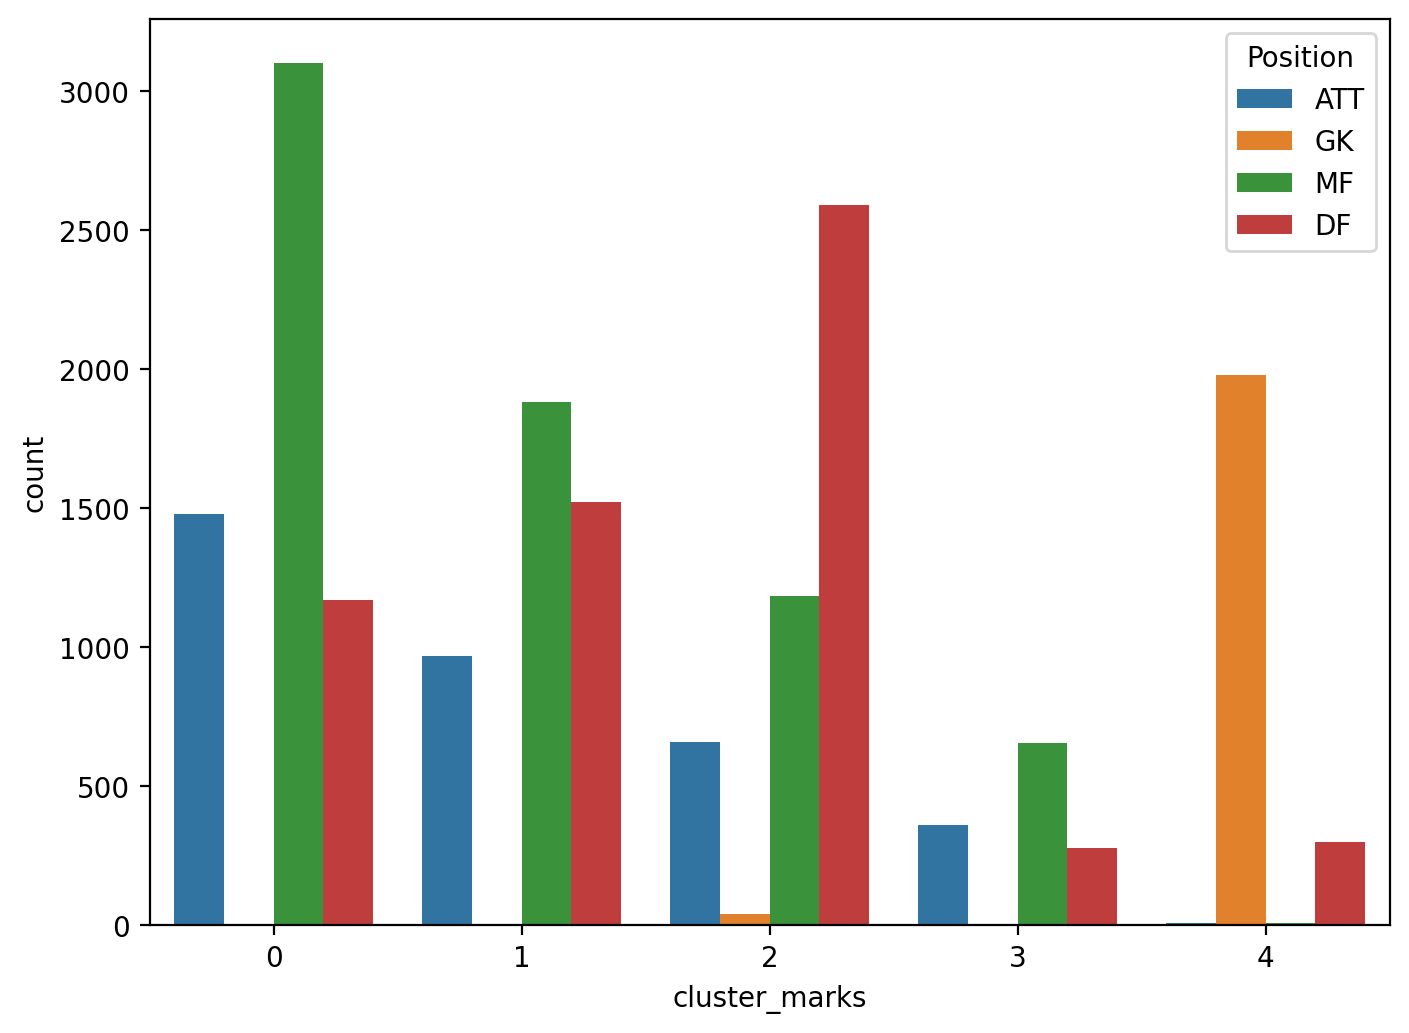

In [924]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [925]:
keep_columns += ['FKAccuracy']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [926]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4022, (22.090404789366726 %)

NAPAD: 894 (22.22774738935853 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 72, (1.790154152163103 %)
Broj igraca na poziciji LW: 63, (1.566384883142715 %)
Broj igraca na poziciji ST: 712, (17.702635504724018 %)
Broj igraca na poziciji CF: 15, (0.37294878170064644 %)
Broj igraca na poziciji RS: 13, (0.32322227747389354 %)
Broj igraca na poziciji LS: 19, (0.4724017901541522 %)

VEZNI RED: 1595 (39.65688712083541 %)
Broj igraca na poziciji RDM: 20, (0.49726504226752855 %)
Broj igraca na poziciji CDM: 291, (7.235206364992541 %)
Broj igraca na poziciji LDM: 33, (0.8204873197414222 %)
Broj igraca na poziciji RM: 207, (5.146693187468921 %)
Broj igraca na poziciji RCM: 37, (0.9199403281949279 %)
Broj igraca na poziciji CM: 572, (14.221780208851317 %)
Broj igraca na poziciji LCM: 46, (1.1437095972153157 %)
Broj igraca na poziciji LM: 201, (4.997513674788663 %)
Broj igraca na p

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

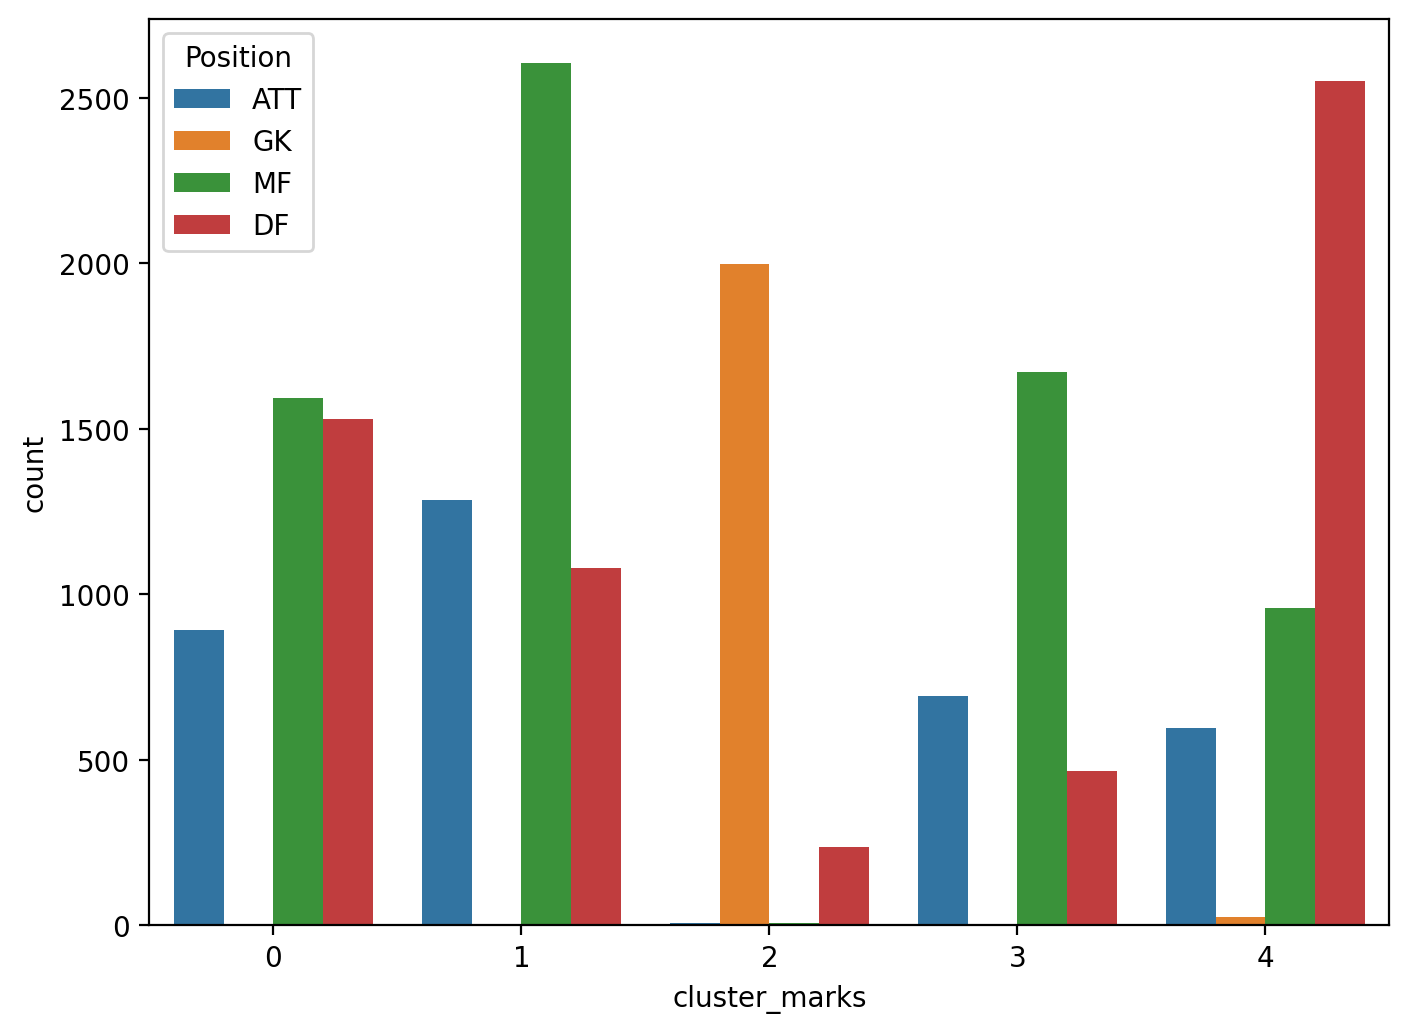

In [927]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [928]:
keep_columns += ['LongPassing']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [929]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3071, (16.86713901246773 %)

NAPAD: 633 (20.612178443503744 %)
Broj igraca na poziciji RF: 8, (0.2605014653207424 %)
Broj igraca na poziciji LF: 10, (0.32562683165092804 %)
Broj igraca na poziciji RW: 86, (2.800390752197981 %)
Broj igraca na poziciji LW: 76, (2.474763920547053 %)
Broj igraca na poziciji ST: 319, (10.387495929664604 %)
Broj igraca na poziciji CF: 20, (0.6512536633018561 %)
Broj igraca na poziciji RS: 52, (1.6932595245848256 %)
Broj igraca na poziciji LS: 62, (2.0188863562357535 %)

VEZNI RED: 1905 (62.0319114295018 %)
Broj igraca na poziciji RDM: 82, (2.6701400195376097 %)
Broj igraca na poziciji CDM: 180, (5.861282969716704 %)
Broj igraca na poziciji LDM: 81, (2.637577336372517 %)
Broj igraca na poziciji RM: 262, (8.531422989254315 %)
Broj igraca na poziciji RCM: 165, (5.372842722240312 %)
Broj igraca na poziciji CM: 312, (10.159557147508954 %)
Broj igraca na poziciji LCM: 174, (5.665906870726148 %)
Broj igraca na poziciji LM: 280, (9.11755128

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

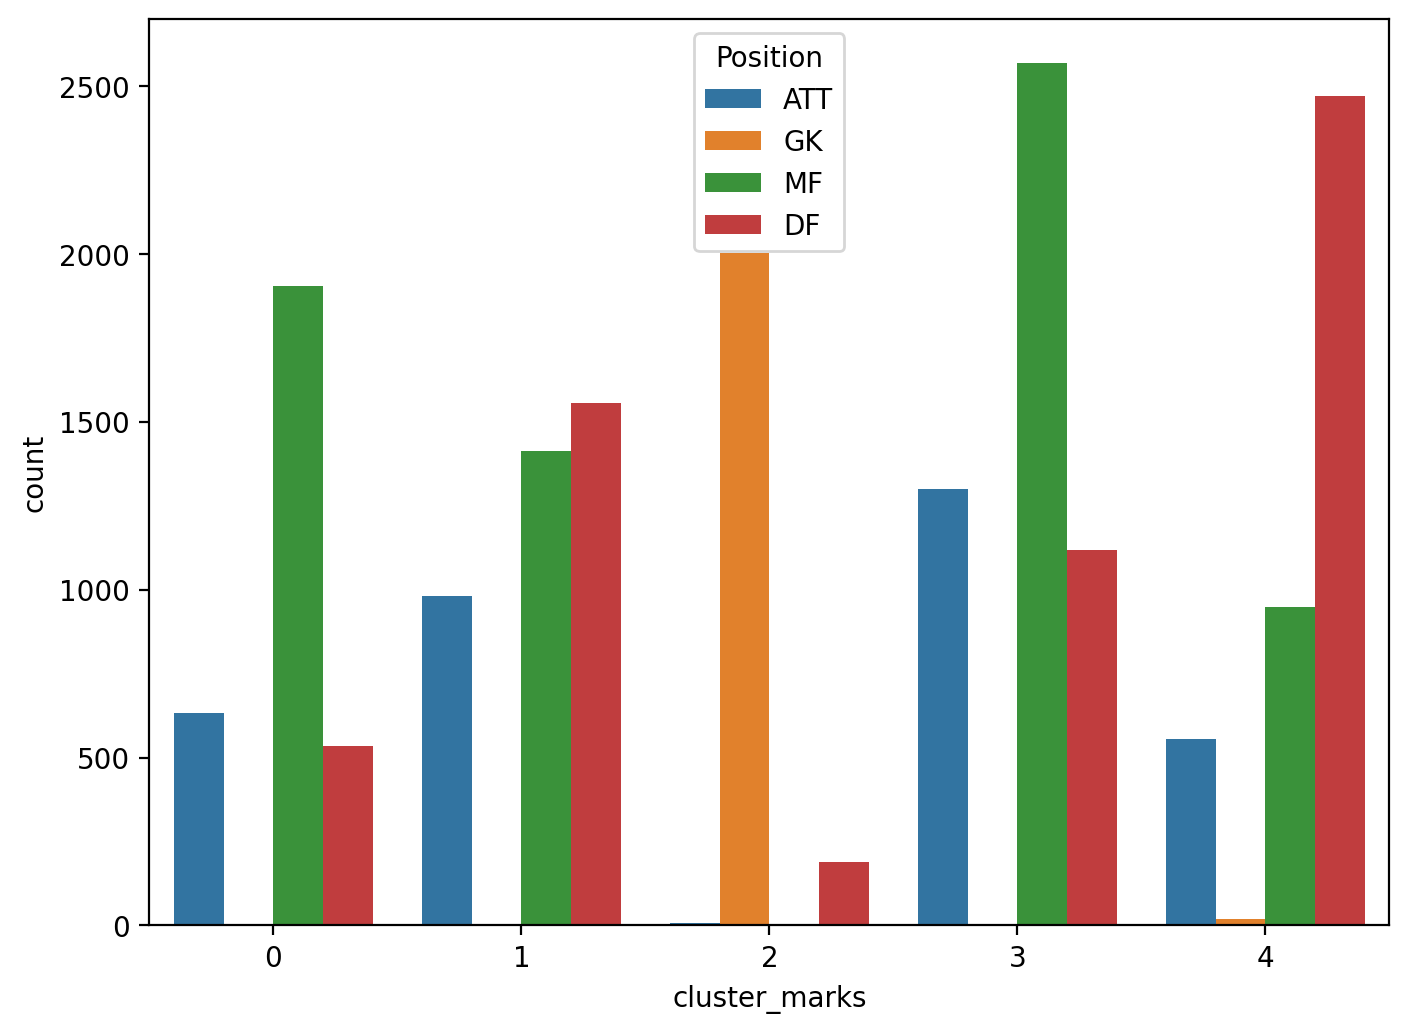

In [930]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [931]:
keep_columns += ['Crossing']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [932]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4876, (26.780908441808094 %)

NAPAD: 1301 (26.681706316652992 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 140, (2.871205906480722 %)
Broj igraca na poziciji LW: 147, (3.014766201804758 %)
Broj igraca na poziciji ST: 895, (18.3552091878589 %)
Broj igraca na poziciji CF: 36, (0.7383100902378998 %)
Broj igraca na poziciji RS: 45, (0.9228876127973749 %)
Broj igraca na poziciji LS: 38, (0.7793273174733388 %)

VEZNI RED: 2278 (46.71862182116489 %)
Broj igraca na poziciji RDM: 27, (0.5537325676784249 %)
Broj igraca na poziciji CDM: 302, (6.193601312551271 %)
Broj igraca na poziciji LDM: 39, (0.7998359310910582 %)
Broj igraca na poziciji RM: 406, (8.326497128794093 %)
Broj igraca na poziciji RCM: 58, (1.1894995898277276 %)
Broj igraca na poziciji CM: 663, (13.59721082854799 %)
Broj igraca na poziciji LCM: 56, (1.1484823625922889 %)
Broj igraca na poziciji LM: 389, (7.977850697292863 %)
Broj igraca na poz

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

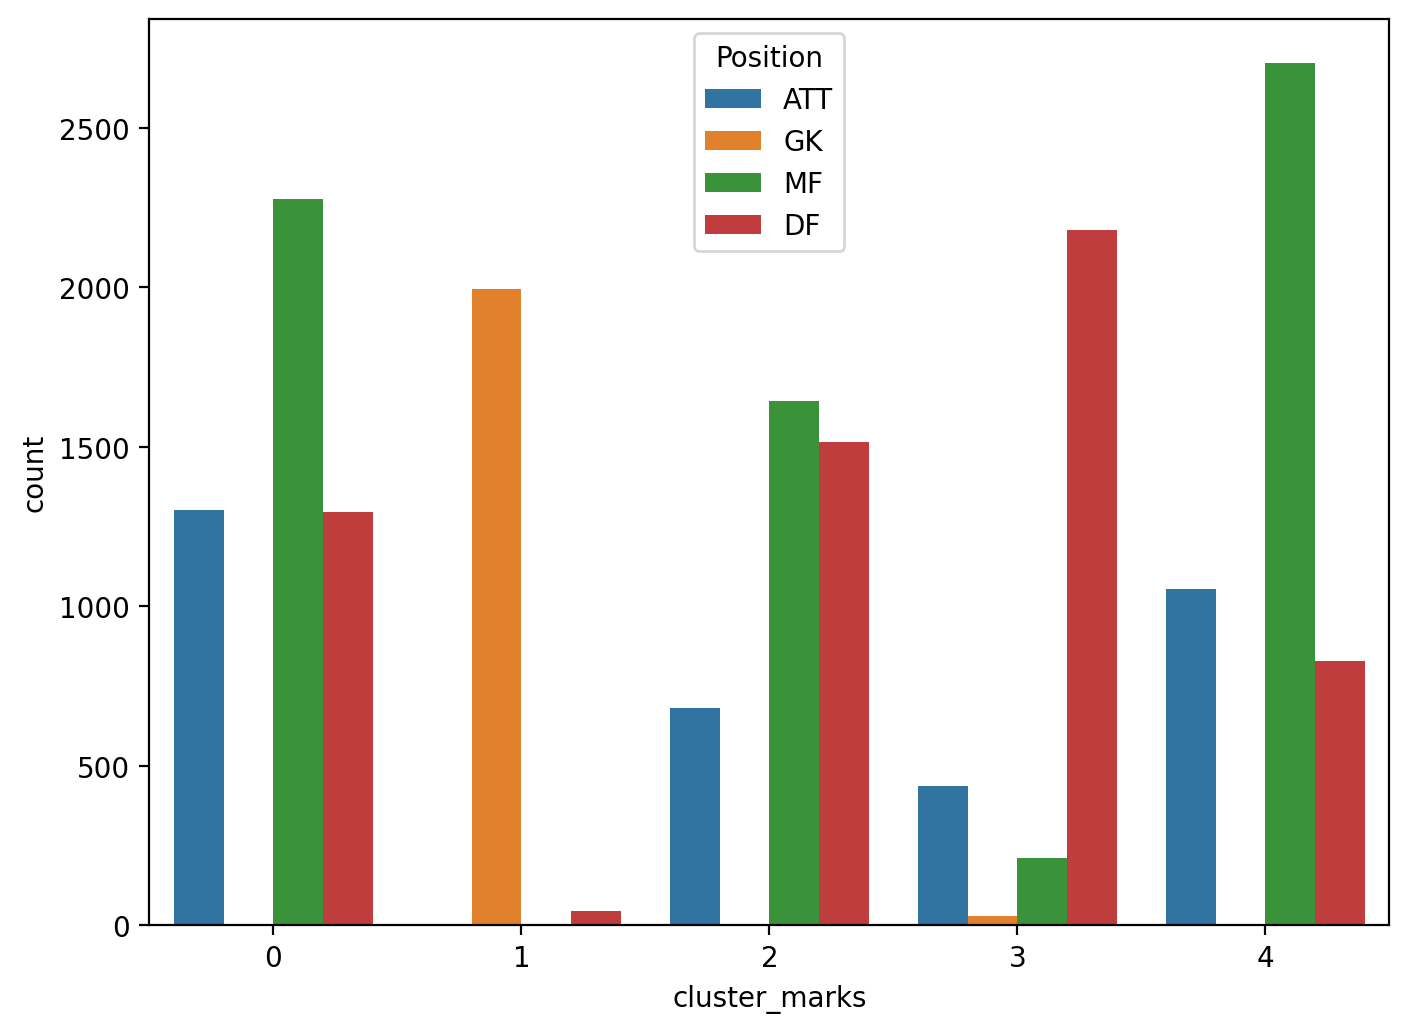

In [933]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [934]:
keep_columns += ['Finishing']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [935]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4607, (25.30345471521942 %)

NAPAD: 1217 (26.416322986759276 %)
Broj igraca na poziciji RF: 13, (0.28217929238115913 %)
Broj igraca na poziciji LF: 13, (0.28217929238115913 %)
Broj igraca na poziciji RW: 220, (4.77534187106577 %)
Broj igraca na poziciji LW: 224, (4.862166268721511 %)
Broj igraca na poziciji ST: 526, (11.417408291729975 %)
Broj igraca na poziciji CF: 35, (0.759713479487736 %)
Broj igraca na poziciji RS: 94, (2.0403733449099195 %)
Broj igraca na poziciji LS: 92, (1.996961146082049 %)

VEZNI RED: 2706 (58.73670501410897 %)
Broj igraca na poziciji RDM: 67, (1.4543086607336662 %)
Broj igraca na poziciji CDM: 119, (2.5830258302583027 %)
Broj igraca na poziciji LDM: 63, (1.367484263077925 %)
Broj igraca na poziciji RM: 610, (13.240720642500541 %)
Broj igraca na poziciji RCM: 156, (3.386151508573909 %)
Broj igraca na poziciji CM: 349, (7.575428695463425 %)
Broj igraca na poziciji LCM: 179, (3.8853917950944212 %)
Broj igraca na poziciji LM: 623, (13.52

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

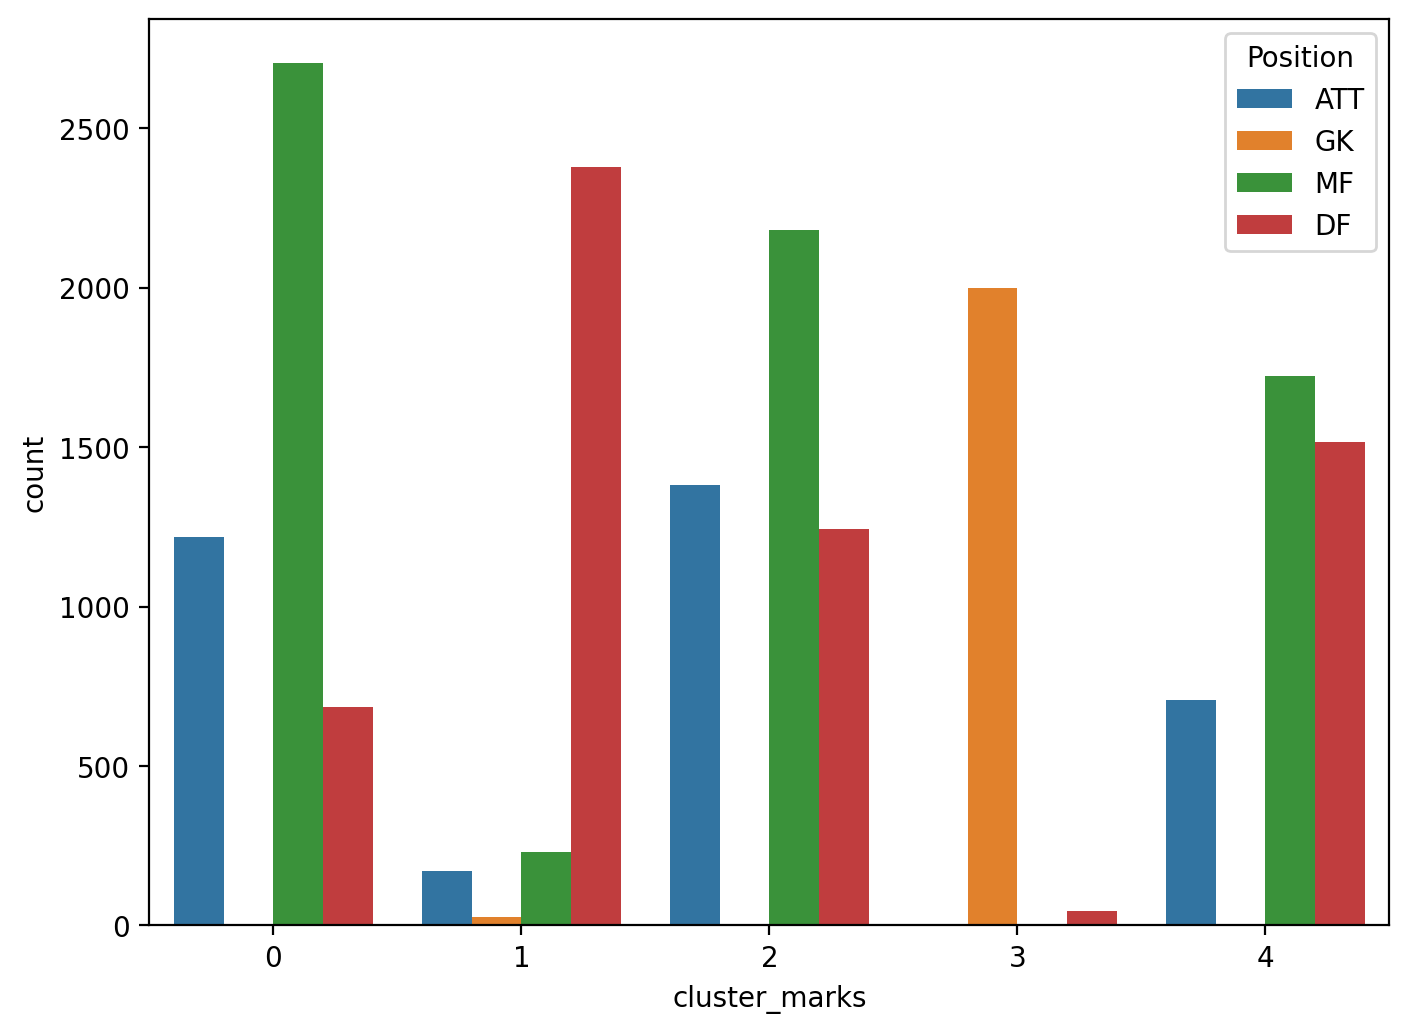

In [936]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [937]:
keep_columns += ['HeadingAccuracy']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [938]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4826, (26.506288790025813 %)

NAPAD: 1287 (26.668048072938248 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 1, (0.020721094073767096 %)
Broj igraca na poziciji RW: 135, (2.797347699958558 %)
Broj igraca na poziciji LW: 137, (2.838789888106092 %)
Broj igraca na poziciji ST: 907, (18.794032324906755 %)
Broj igraca na poziciji CF: 33, (0.6837961044343142 %)
Broj igraca na poziciji RS: 34, (0.7045171985080813 %)
Broj igraca na poziciji LS: 40, (0.8288437629506838 %)

VEZNI RED: 2284 (47.32697886448404 %)
Broj igraca na poziciji RDM: 30, (0.6216328222130129 %)
Broj igraca na poziciji CDM: 301, (6.237049316203896 %)
Broj igraca na poziciji LDM: 39, (0.8081226688769167 %)
Broj igraca na poziciji RM: 401, (8.309158723580605 %)
Broj igraca na poziciji RCM: 61, (1.263986738499793 %)
Broj igraca na poziciji CM: 678, (14.04890178201409 %)
Broj igraca na poziciji LCM: 58, (1.2018234562784915 %)
Broj igraca na poziciji LM: 381, (7.894736842105263 %)


<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

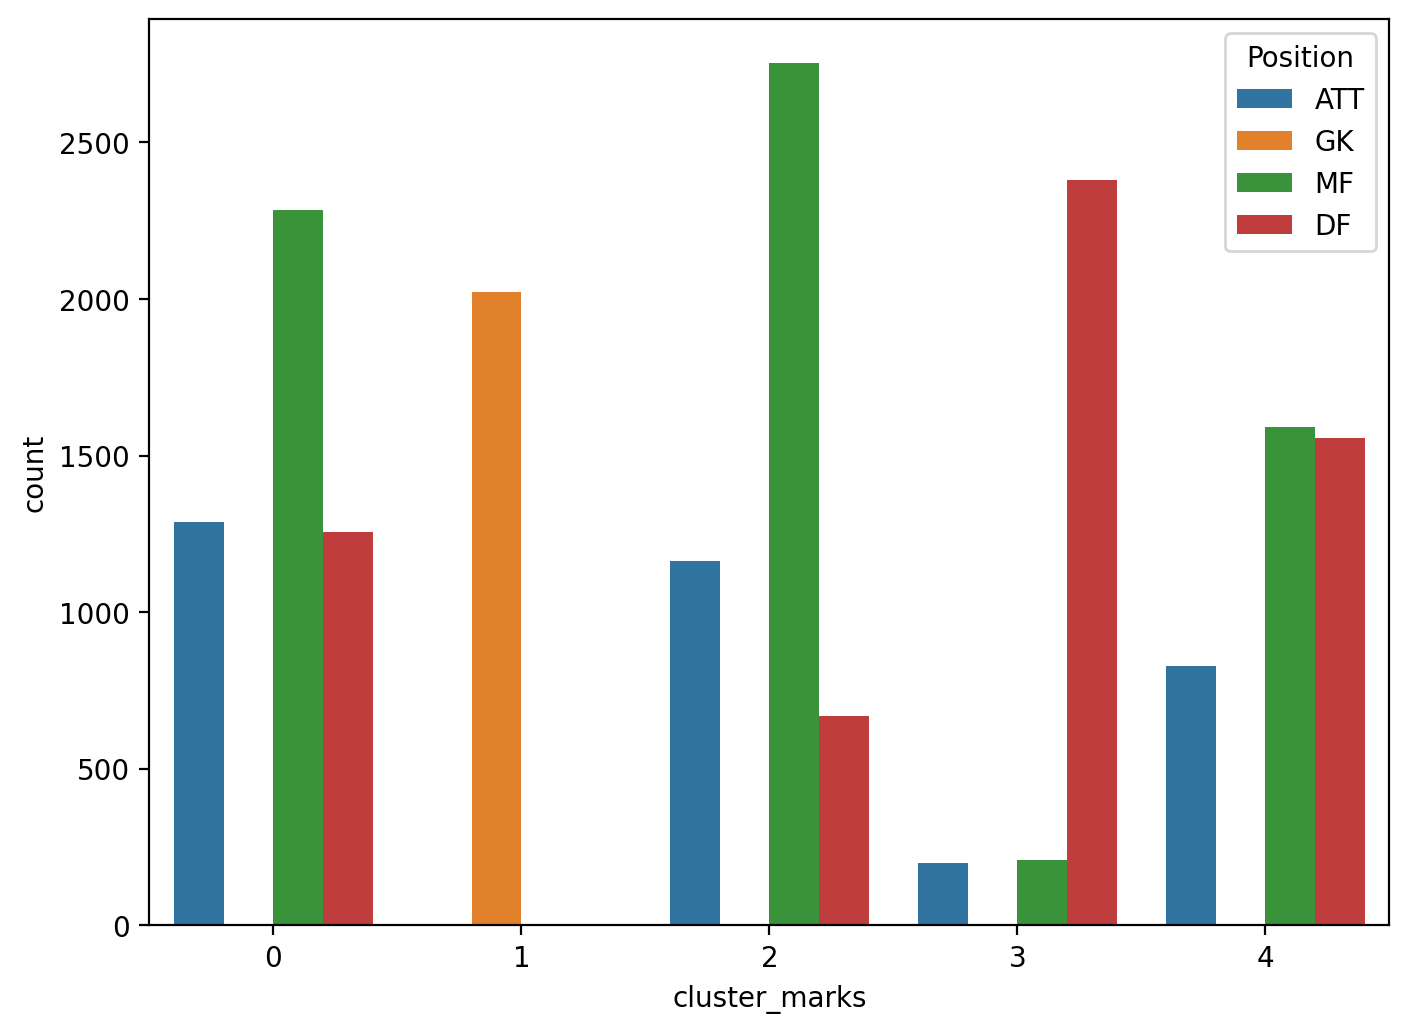

In [939]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [940]:
keep_columns += ['Reactions']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [941]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 2743, (15.065634096775964 %)

NAPAD: 200 (7.291286912139992 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 1, (0.03645643456069996 %)
Broj igraca na poziciji LW: 1, (0.03645643456069996 %)
Broj igraca na poziciji ST: 175, (6.379876048122493 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 11, (0.40102078016769954 %)
Broj igraca na poziciji LS: 12, (0.43747721472839957 %)

VEZNI RED: 207 (7.546481954064893 %)
Broj igraca na poziciji RDM: 18, (0.6562158220925993 %)
Broj igraca na poziciji CDM: 120, (4.374772147283996 %)
Broj igraca na poziciji LDM: 15, (0.5468465184104995 %)
Broj igraca na poziciji RM: 3, (0.10936930368209989 %)
Broj igraca na poziciji RCM: 12, (0.43747721472839957 %)
Broj igraca na poziciji CM: 26, (0.9478672985781991 %)
Broj igraca na poziciji LCM: 10, (0.36456434560699963 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igr

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

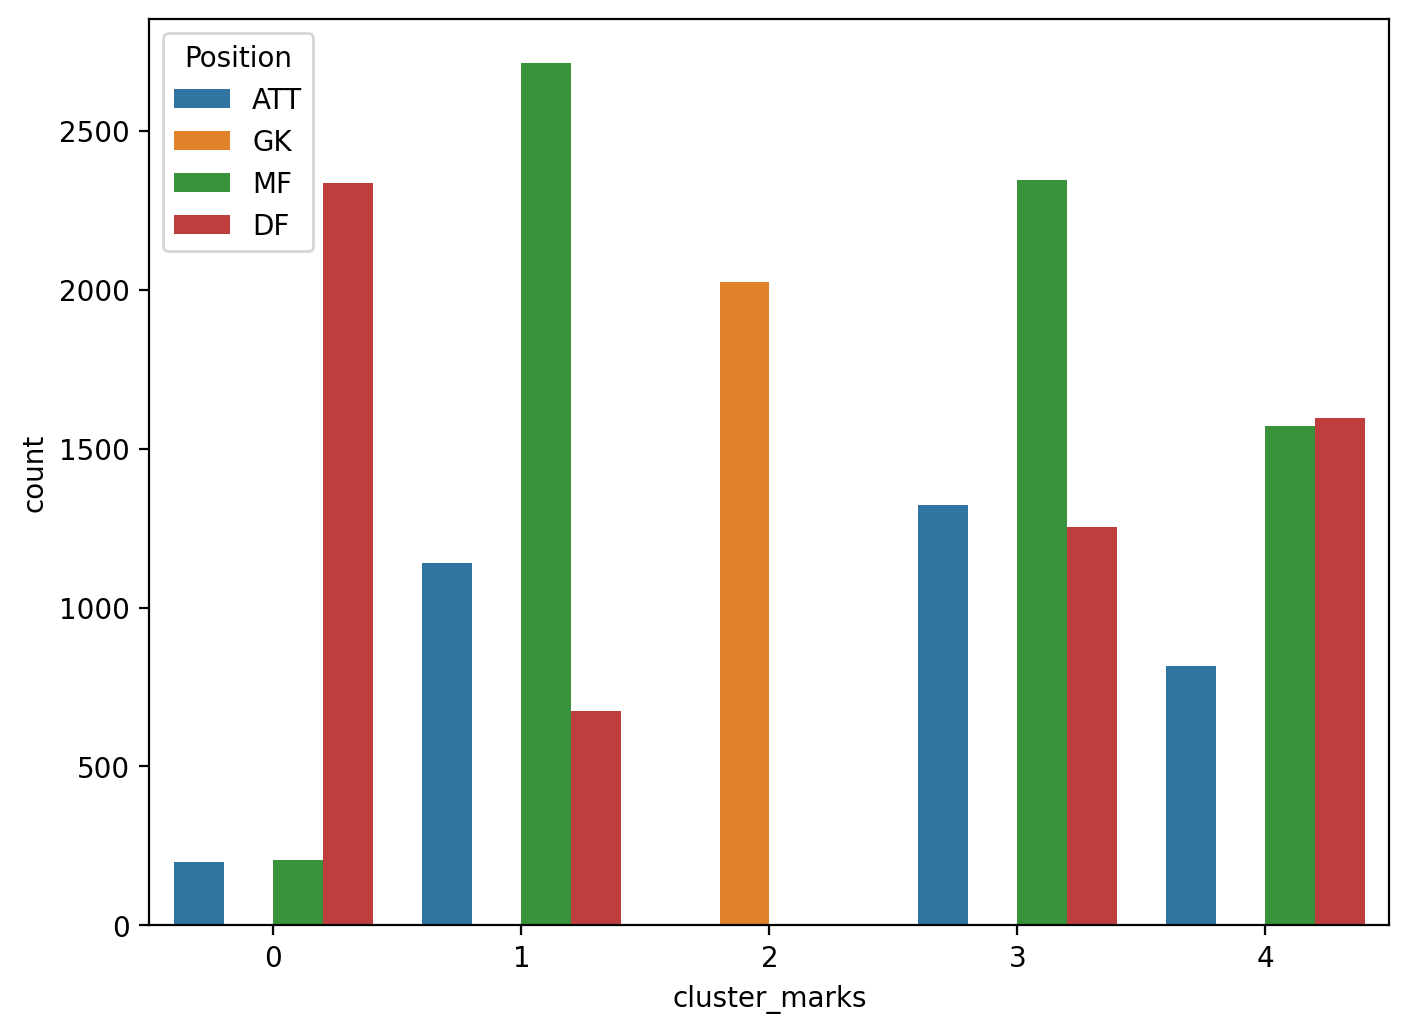

In [942]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [943]:
keep_columns += ['LongShots']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [944]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3837, (21.074312077772287 %)

NAPAD: 870 (22.673964034401877 %)
Broj igraca na poziciji RF: 2, (0.05212405525149857 %)
Broj igraca na poziciji LF: 1, (0.026062027625749284 %)
Broj igraca na poziciji RW: 17, (0.4430544696377378 %)
Broj igraca na poziciji LW: 20, (0.5212405525149857 %)
Broj igraca na poziciji ST: 676, (17.617930675006516 %)
Broj igraca na poziciji CF: 6, (0.1563721657544957 %)
Broj igraca na poziciji RS: 75, (1.9546520719311962 %)
Broj igraca na poziciji LS: 73, (1.9025280166796978 %)

VEZNI RED: 1460 (38.05056033359395 %)
Broj igraca na poziciji RDM: 133, (3.466249674224655 %)
Broj igraca na poziciji CDM: 395, (10.294500912170967 %)
Broj igraca na poziciji LDM: 114, (2.9710711493354185 %)
Broj igraca na poziciji RM: 89, (2.319520458691686 %)
Broj igraca na poziciji RCM: 140, (3.6486838676048996 %)
Broj igraca na poziciji CM: 304, (7.922856398227782 %)
Broj igraca na poziciji LCM: 125, (3.2577534532186605 %)
Broj igraca na poziciji LM: 73, (1.90

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

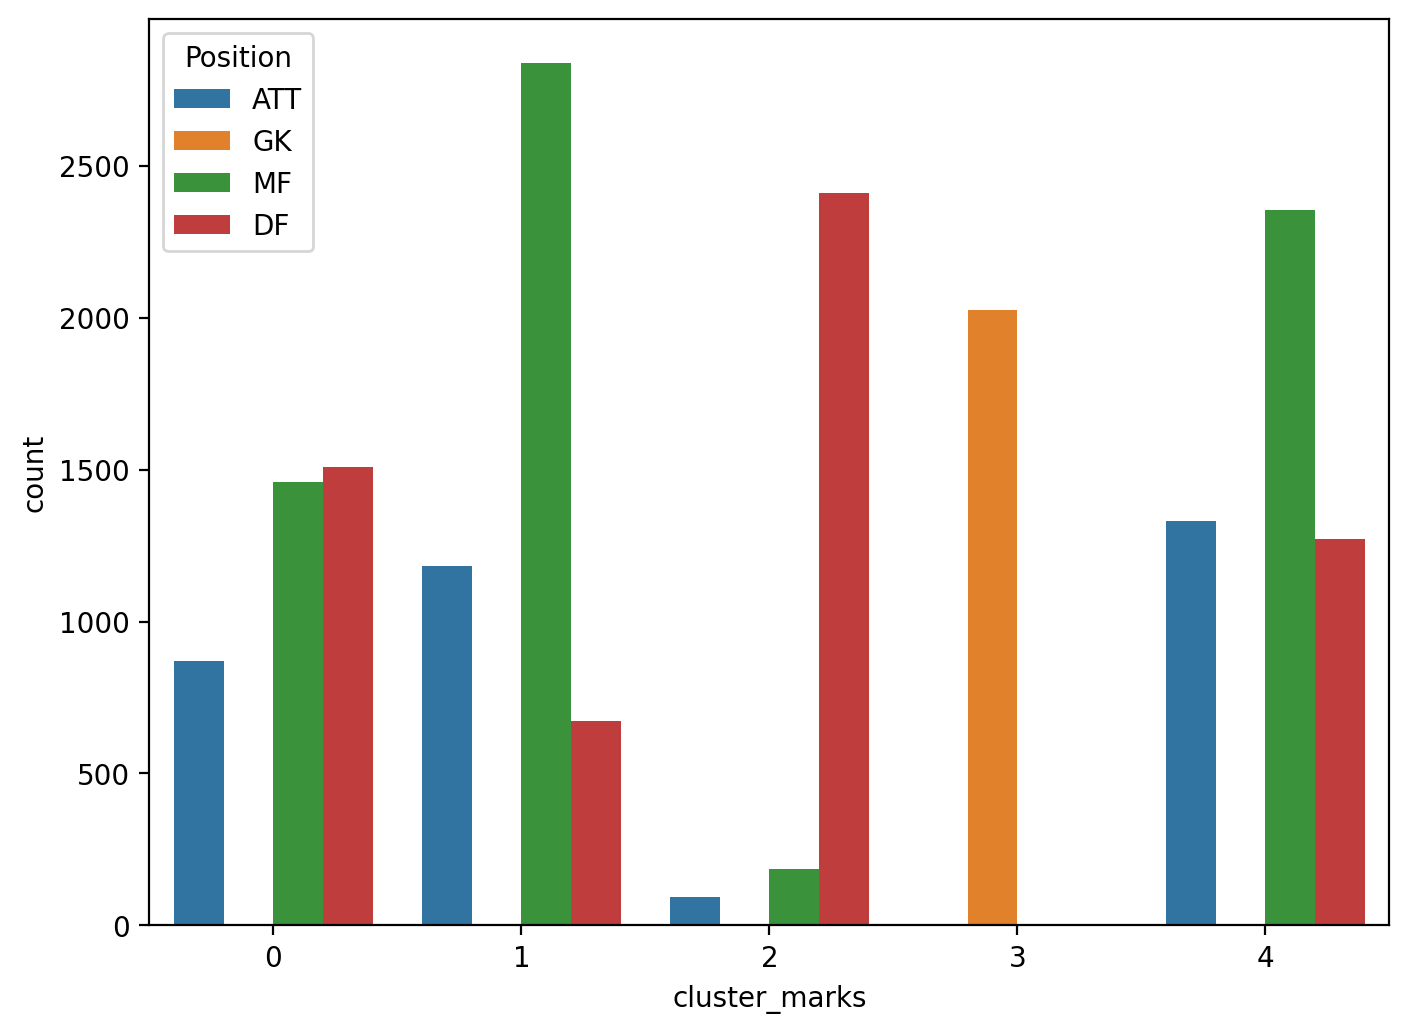

In [945]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [946]:
keep_columns += ['BallControl']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [947]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4689, (25.753830944142365 %)

NAPAD: 1179 (25.143953934740882 %)
Broj igraca na poziciji RF: 14, (0.2985711239070164 %)
Broj igraca na poziciji LF: 12, (0.2559181062060141 %)
Broj igraca na poziciji RW: 204, (4.350607805502239 %)
Broj igraca na poziciji LW: 212, (4.521219876306248 %)
Broj igraca na poziciji ST: 525, (11.196417146513117 %)
Broj igraca na poziciji CF: 34, (0.7251013009170398 %)
Broj igraca na poziciji RS: 87, (1.8554062699936023 %)
Broj igraca na poziciji LS: 91, (1.9407123053956068 %)

VEZNI RED: 2839 (60.545958626572826 %)
Broj igraca na poziciji RDM: 75, (1.599488163787588 %)
Broj igraca na poziciji CDM: 152, (3.2416293452761784 %)
Broj igraca na poziciji LDM: 77, (1.6421411814885902 %)
Broj igraca na poziciji RM: 589, (12.561313712945191 %)
Broj igraca na poziciji RCM: 183, (3.9027511196417146 %)
Broj igraca na poziciji CM: 398, (8.487950522499467 %)
Broj igraca na poziciji LCM: 200, (4.265301770100235 %)
Broj igraca na poziciji LM: 605, (12

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

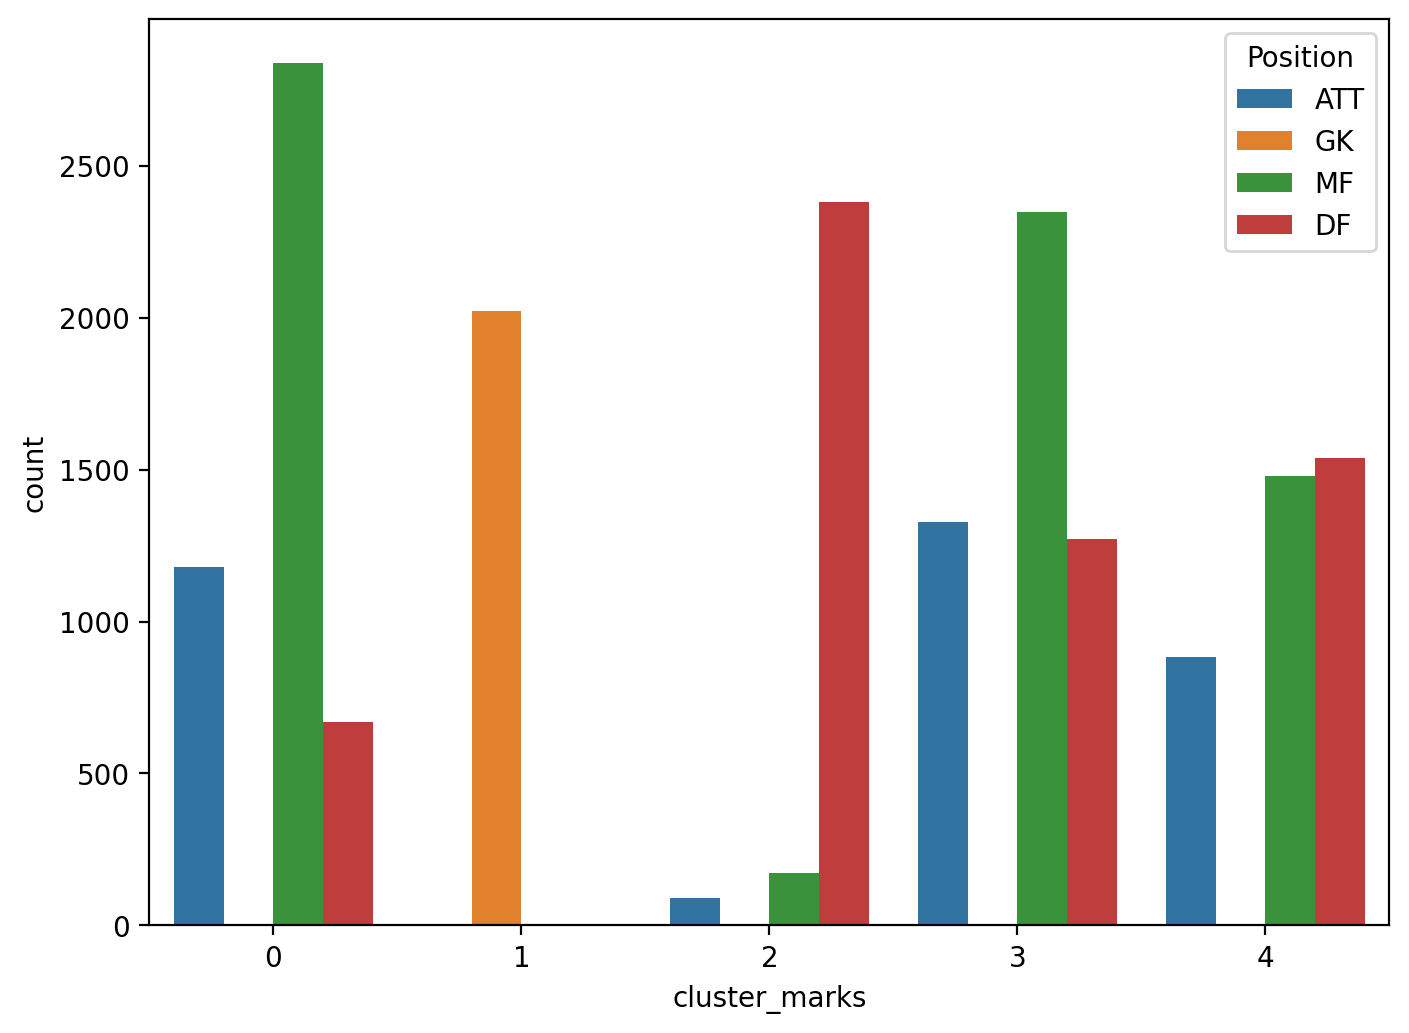

In [948]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [949]:
keep_columns += ['ShotPower']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [950]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 2748, (15.093096061954192 %)

NAPAD: 82 (2.9839883551673942 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 1, (0.0363901018922853 %)
Broj igraca na poziciji ST: 79, (2.8748180494905387 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 2, (0.0727802037845706 %)

VEZNI RED: 199 (7.241630276564774 %)
Broj igraca na poziciji RDM: 12, (0.43668122270742354 %)
Broj igraca na poziciji CDM: 117, (4.25764192139738 %)
Broj igraca na poziciji LDM: 14, (0.5094614264919942 %)
Broj igraca na poziciji RM: 4, (0.1455604075691412 %)
Broj igraca na poziciji RCM: 8, (0.2911208151382824 %)
Broj igraca na poziciji CM: 32, (1.1644832605531297 %)
Broj igraca na poziciji LCM: 8, (0.2911208151382824 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 4, (0.14556040756914

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

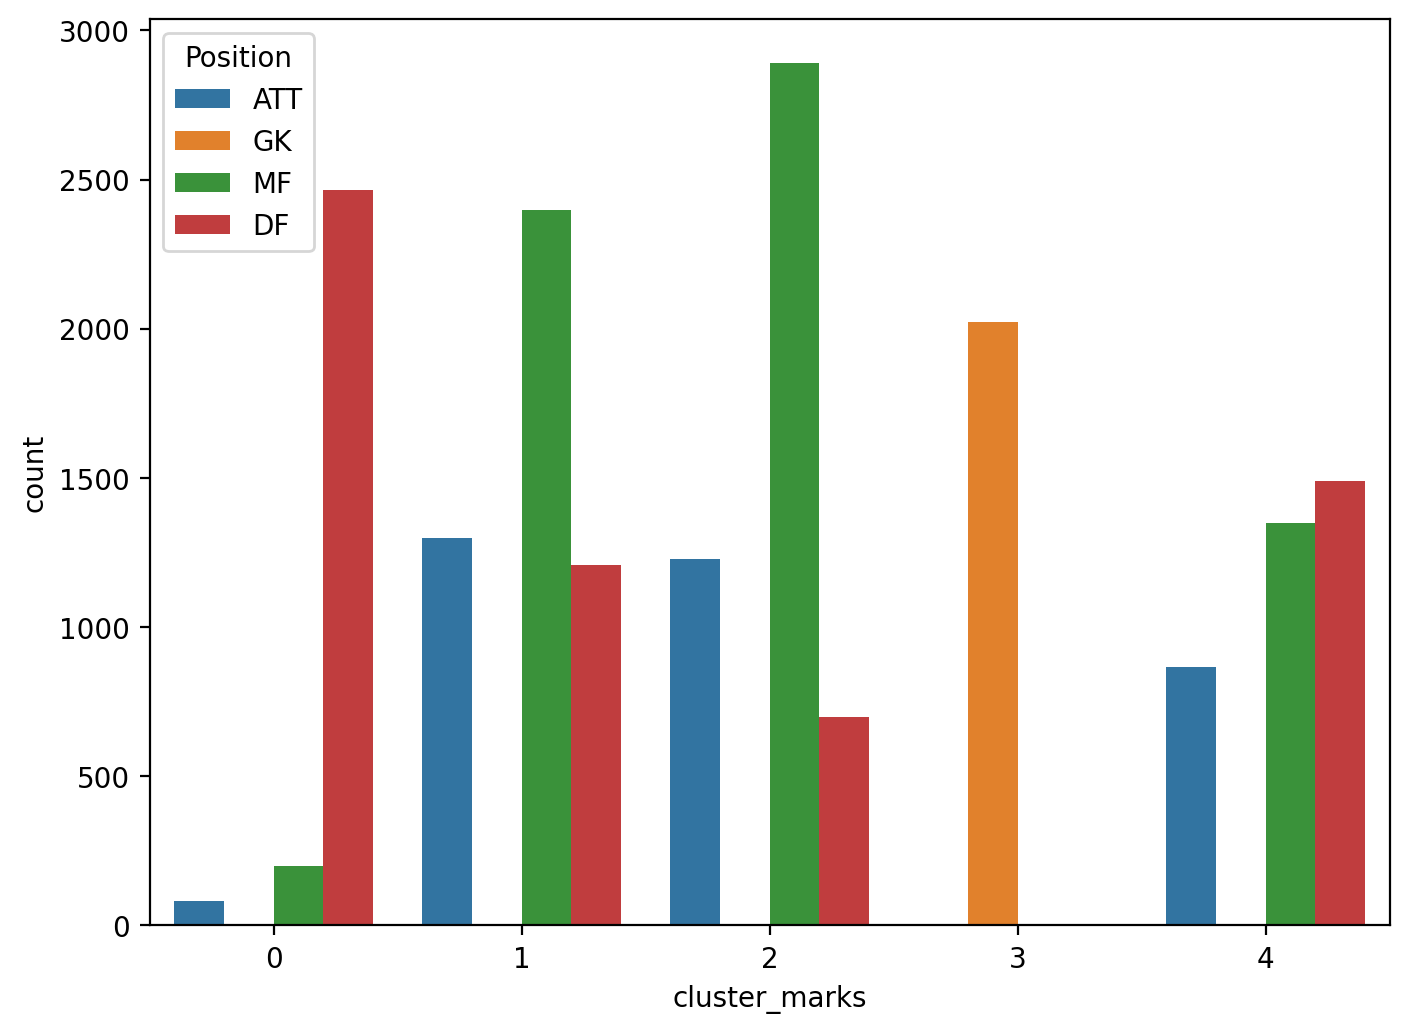

In [951]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [952]:
keep_columns += ['Interceptions']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [953]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4356, (23.92486406327237 %)

NAPAD: 2012 (46.18916437098255 %)
Broj igraca na poziciji RF: 2, (0.04591368227731864 %)
Broj igraca na poziciji LF: 2, (0.04591368227731864 %)
Broj igraca na poziciji RW: 186, (4.2699724517906334 %)
Broj igraca na poziciji LW: 204, (4.683195592286501 %)
Broj igraca na poziciji ST: 1400, (32.13957759412305 %)
Broj igraca na poziciji CF: 42, (0.9641873278236914 %)
Broj igraca na poziciji RS: 87, (1.997245179063361 %)
Broj igraca na poziciji LS: 89, (2.0431588613406793 %)

VEZNI RED: 2078 (47.70431588613407 %)
Broj igraca na poziciji RDM: 13, (0.29843893480257117 %)
Broj igraca na poziciji CDM: 64, (1.4692378328741964 %)
Broj igraca na poziciji LDM: 15, (0.34435261707988984 %)
Broj igraca na poziciji RM: 519, (11.914600550964186 %)
Broj igraca na poziciji RCM: 36, (0.8264462809917356 %)
Broj igraca na poziciji CM: 456, (10.46831955922865 %)
Broj igraca na poziciji LCM: 42, (0.9641873278236914 %)
Broj igraca na poziciji LM: 510, (11.7

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

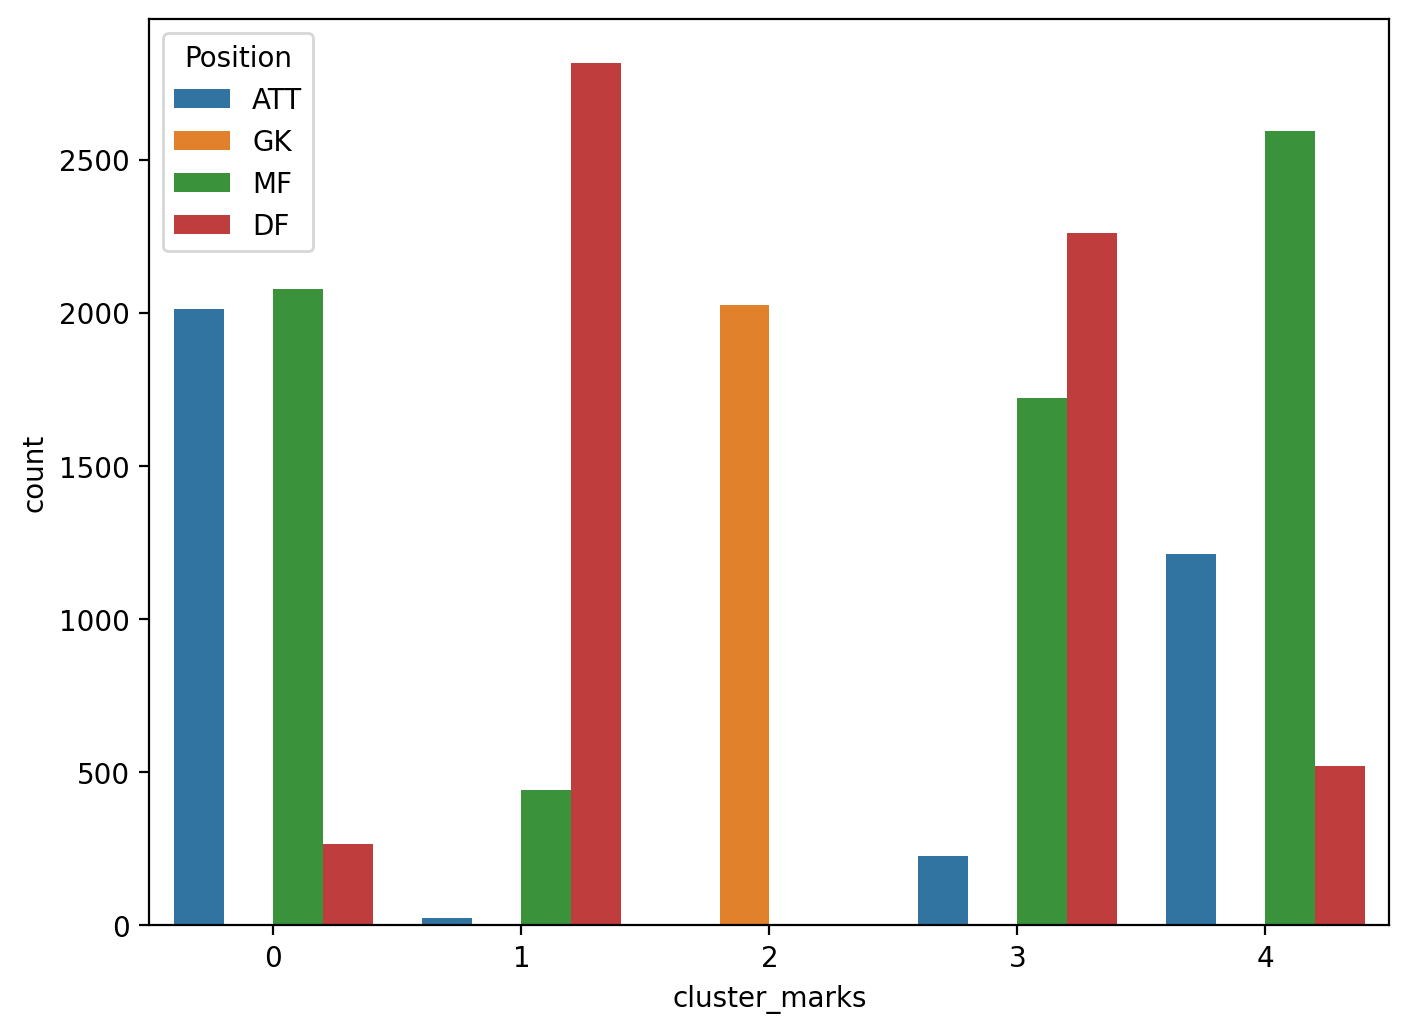

In [954]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [955]:
keep_columns += ['Volleys']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [956]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3605, (19.8000768935025 %)

NAPAD: 17 (0.47156726768377255 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 1, (0.027739251040221912 %)
Broj igraca na poziciji ST: 16, (0.4438280166435506 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 521 (14.452149791955618 %)
Broj igraca na poziciji RDM: 20, (0.5547850208044383 %)
Broj igraca na poziciji CDM: 248, (6.879334257975035 %)
Broj igraca na poziciji LDM: 21, (0.5825242718446602 %)
Broj igraca na poziciji RM: 16, (0.4438280166435506 %)
Broj igraca na poziciji RCM: 14, (0.3883495145631068 %)
Broj igraca na poziciji CM: 164, (4.549237170596394 %)
Broj igraca na poziciji LCM: 16, (0.4438280166435506 %)
Broj igraca na poziciji LM: 11, (0.3051317614424411 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 11, (0.3051317

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

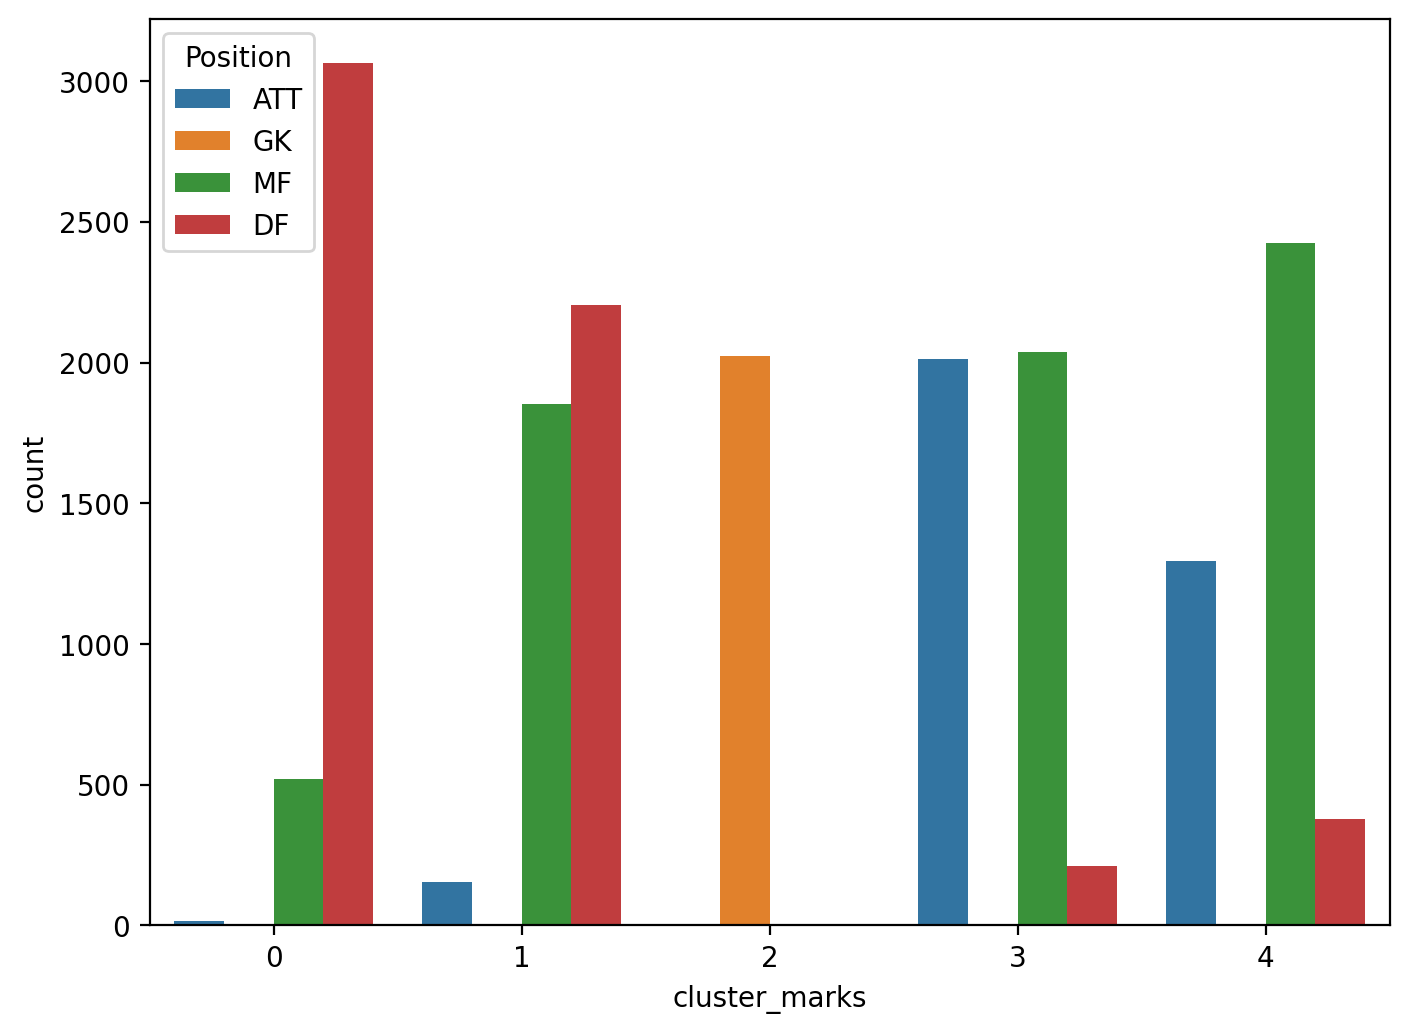

In [957]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [961]:
keep_columns += ['StandingTackle']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [962]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4598, (25.25402317789861 %)

NAPAD: 12 (0.26098303610265333 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 1, (0.02174858634188778 %)
Broj igraca na poziciji ST: 11, (0.23923444976076555 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 801 (17.42061765985211 %)
Broj igraca na poziciji RDM: 40, (0.8699434536755112 %)
Broj igraca na poziciji CDM: 363, (7.894736842105263 %)
Broj igraca na poziciji LDM: 42, (0.9134406263592866 %)
Broj igraca na poziciji RM: 22, (0.4784688995215311 %)
Broj igraca na poziciji RCM: 30, (0.6524575902566333 %)
Broj igraca na poziciji CM: 233, (5.067420617659852 %)
Broj igraca na poziciji LCM: 35, (0.7612005219660721 %)
Broj igraca na poziciji LM: 26, (0.5654632448890822 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 10, (0.2174858

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

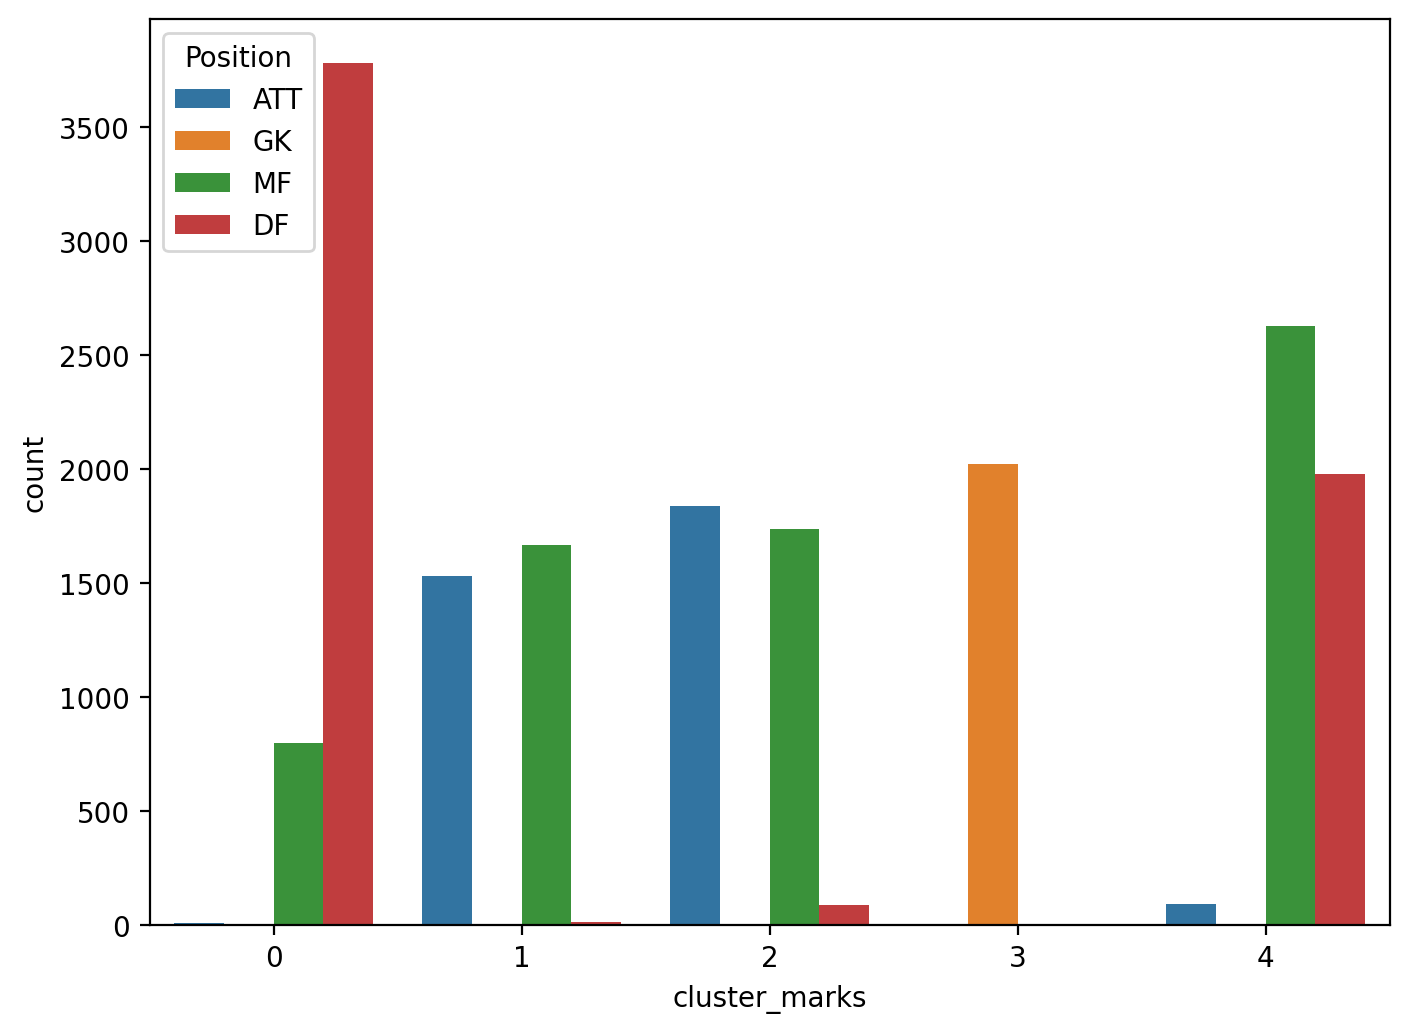

In [963]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [964]:
keep_columns += ['SlidingTackle']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [965]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3390, (18.619212390838687 %)

NAPAD: 1814 (53.510324483775804 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 1, (0.029498525073746312 %)
Broj igraca na poziciji RW: 168, (4.95575221238938 %)
Broj igraca na poziciji LW: 169, (4.985250737463127 %)
Broj igraca na poziciji ST: 1298, (38.28908554572271 %)
Broj igraca na poziciji CF: 39, (1.1504424778761062 %)
Broj igraca na poziciji RS: 71, (2.094395280235988 %)
Broj igraca na poziciji LS: 68, (2.005899705014749 %)

VEZNI RED: 1546 (45.6047197640118 %)
Broj igraca na poziciji RDM: 7, (0.20648967551622419 %)
Broj igraca na poziciji CDM: 5, (0.14749262536873156 %)
Broj igraca na poziciji LDM: 5, (0.14749262536873156 %)
Broj igraca na poziciji RM: 436, (12.861356932153392 %)
Broj igraca na poziciji RCM: 17, (0.5014749262536873 %)
Broj igraca na poziciji CM: 280, (8.259587020648967 %)
Broj igraca na poziciji LCM: 24, (0.7079646017699115 %)
Broj igraca na poziciji LM: 407, (12.00589970501475 %)
Br

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

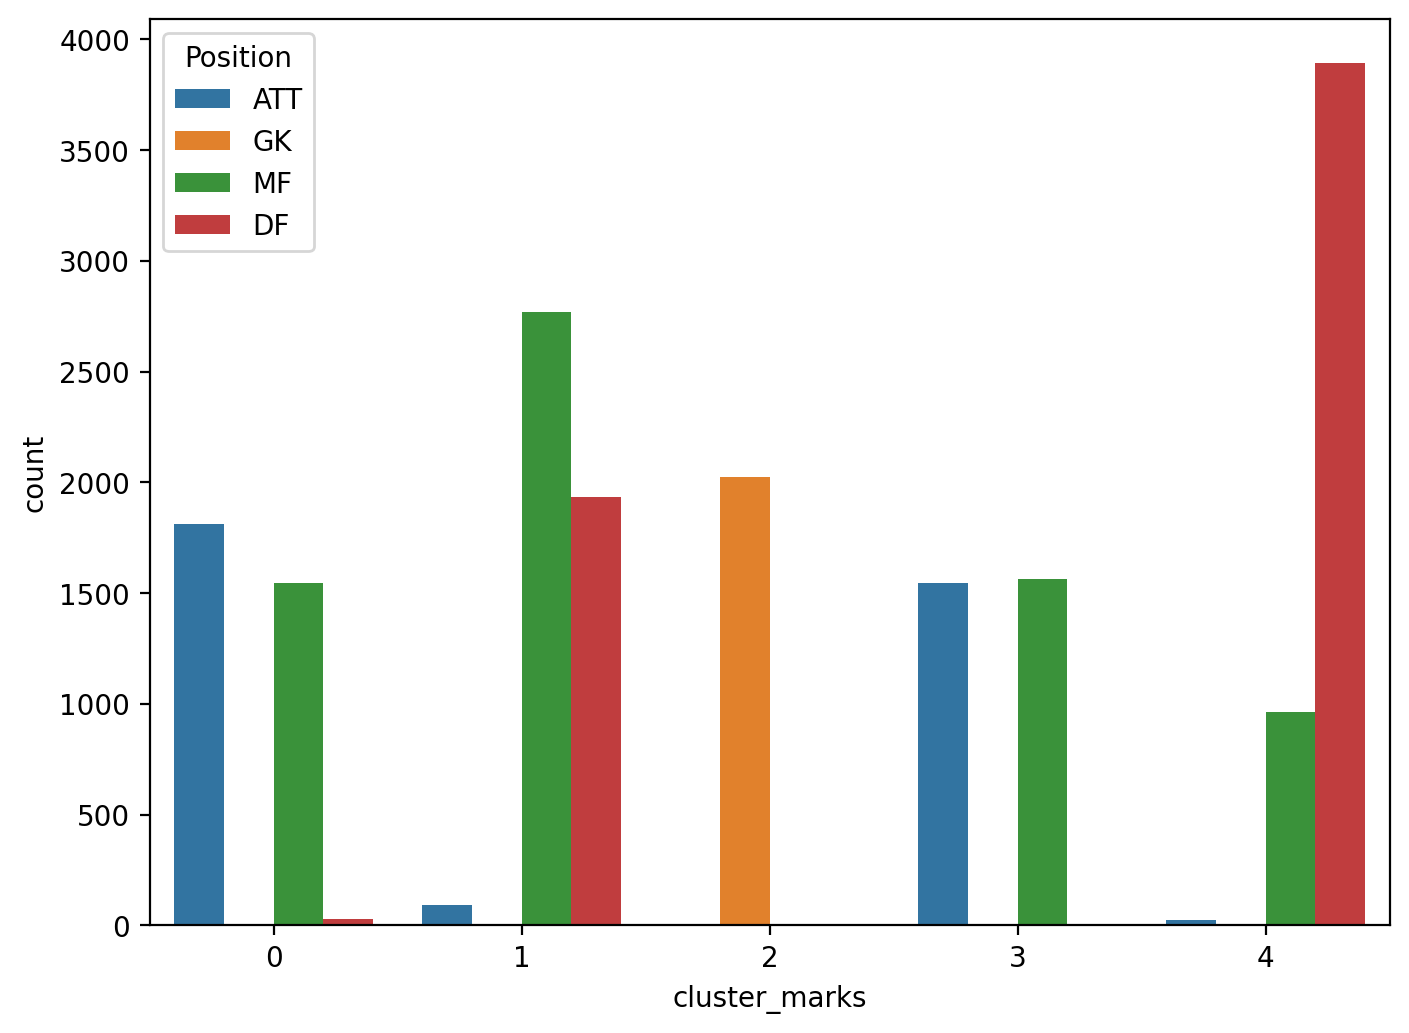

In [966]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [967]:
keep_columns += ['Balance']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [968]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3072, (16.872631405503377 %)

NAPAD: 1510 (49.15364583333333 %)
Broj igraca na poziciji RF: 15, (0.48828125 %)
Broj igraca na poziciji LF: 13, (0.4231770833333333 %)
Broj igraca na poziciji RW: 177, (5.76171875 %)
Broj igraca na poziciji LW: 182, (5.924479166666666 %)
Broj igraca na poziciji ST: 831, (27.05078125 %)
Broj igraca na poziciji CF: 34, (1.1067708333333335 %)
Broj igraca na poziciji RS: 122, (3.9713541666666665 %)
Broj igraca na poziciji LS: 136, (4.427083333333334 %)

VEZNI RED: 1558 (50.716145833333336 %)
Broj igraca na poziciji RDM: 8, (0.26041666666666663 %)
Broj igraca na poziciji CDM: 1, (0.03255208333333333 %)
Broj igraca na poziciji LDM: 11, (0.35807291666666663 %)
Broj igraca na poziciji RM: 467, (15.201822916666666 %)
Broj igraca na poziciji RCM: 41, (1.3346354166666665 %)
Broj igraca na poziciji CM: 59, (1.9205729166666667 %)
Broj igraca na poziciji LCM: 62, (2.018229166666667 %)
Broj igraca na poziciji LM: 472, (15.364583333333334 %)
Bro

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

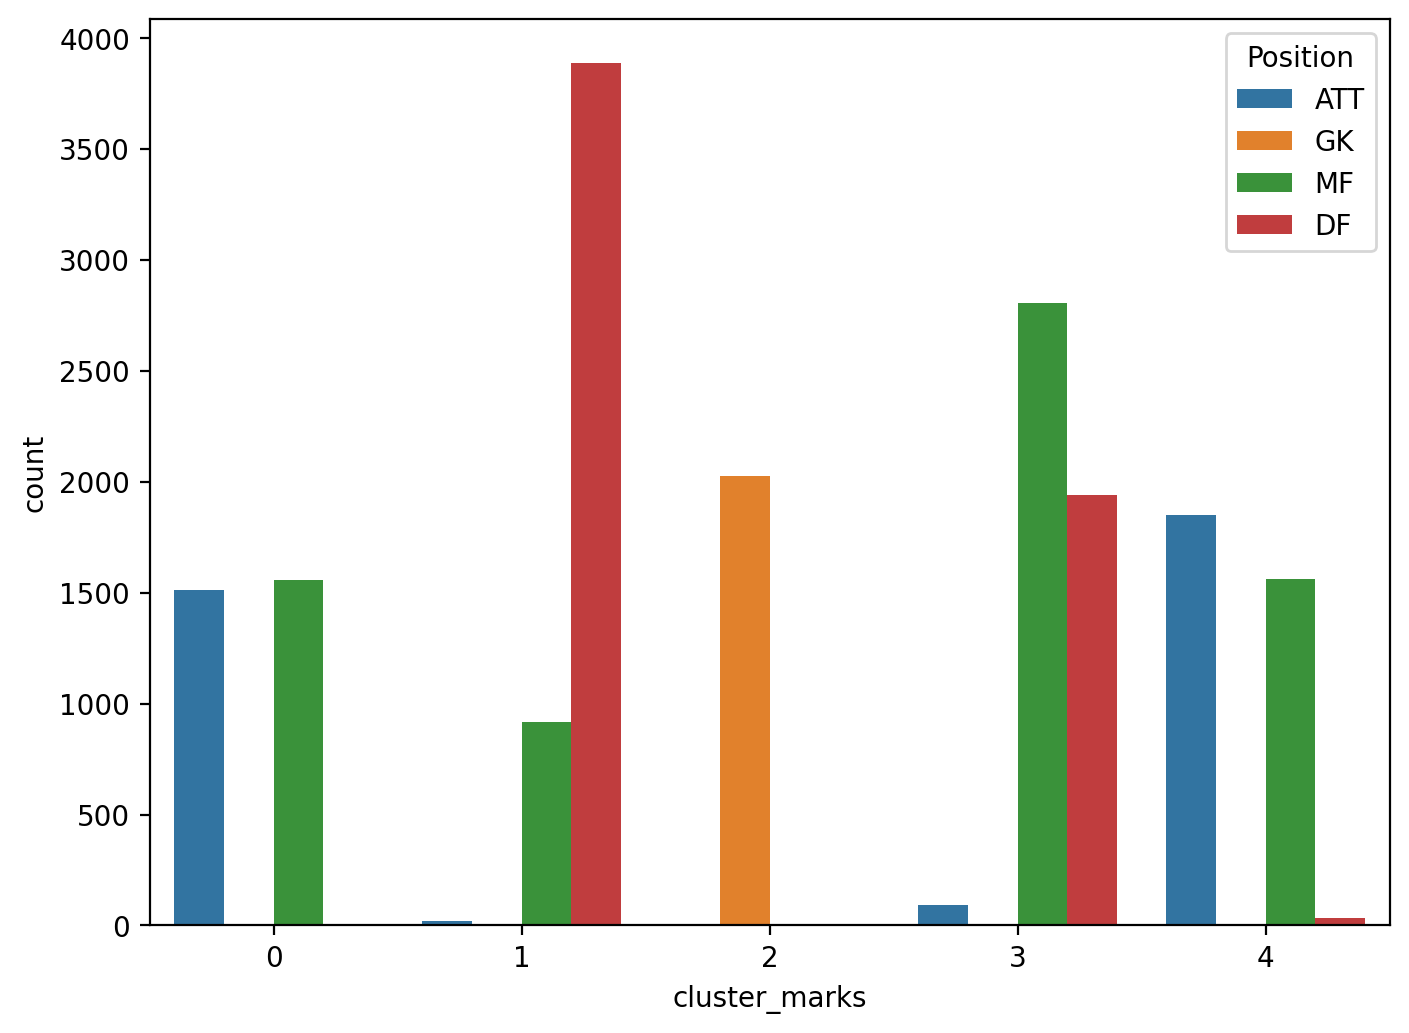

In [969]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [970]:
keep_columns += ['Curve']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [971]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3522, (19.344208271543913 %)

NAPAD: 1942 (55.13912549687677 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 2, (0.05678591709256105 %)
Broj igraca na poziciji RW: 167, (4.741624077228847 %)
Broj igraca na poziciji LW: 172, (4.88358886996025 %)
Broj igraca na poziciji ST: 1405, (39.89210675752413 %)
Broj igraca na poziciji CF: 41, (1.1641113003975014 %)
Broj igraca na poziciji RS: 77, (2.1862578080636004 %)
Broj igraca na poziciji LS: 78, (2.2146507666098807 %)

VEZNI RED: 1546 (43.89551391254969 %)
Broj igraca na poziciji RDM: 7, (0.19875070982396364 %)
Broj igraca na poziciji CDM: 7, (0.19875070982396364 %)
Broj igraca na poziciji LDM: 5, (0.1419647927314026 %)
Broj igraca na poziciji RM: 442, (12.549687677455989 %)
Broj igraca na poziciji RCM: 18, (0.5110732538330494 %)
Broj igraca na poziciji CM: 274, (7.779670641680863 %)
Broj igraca na poziciji LCM: 22, (0.6246450880181714 %)
Broj igraca na poziciji LM: 418, (11.868256672345257 %)
B

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

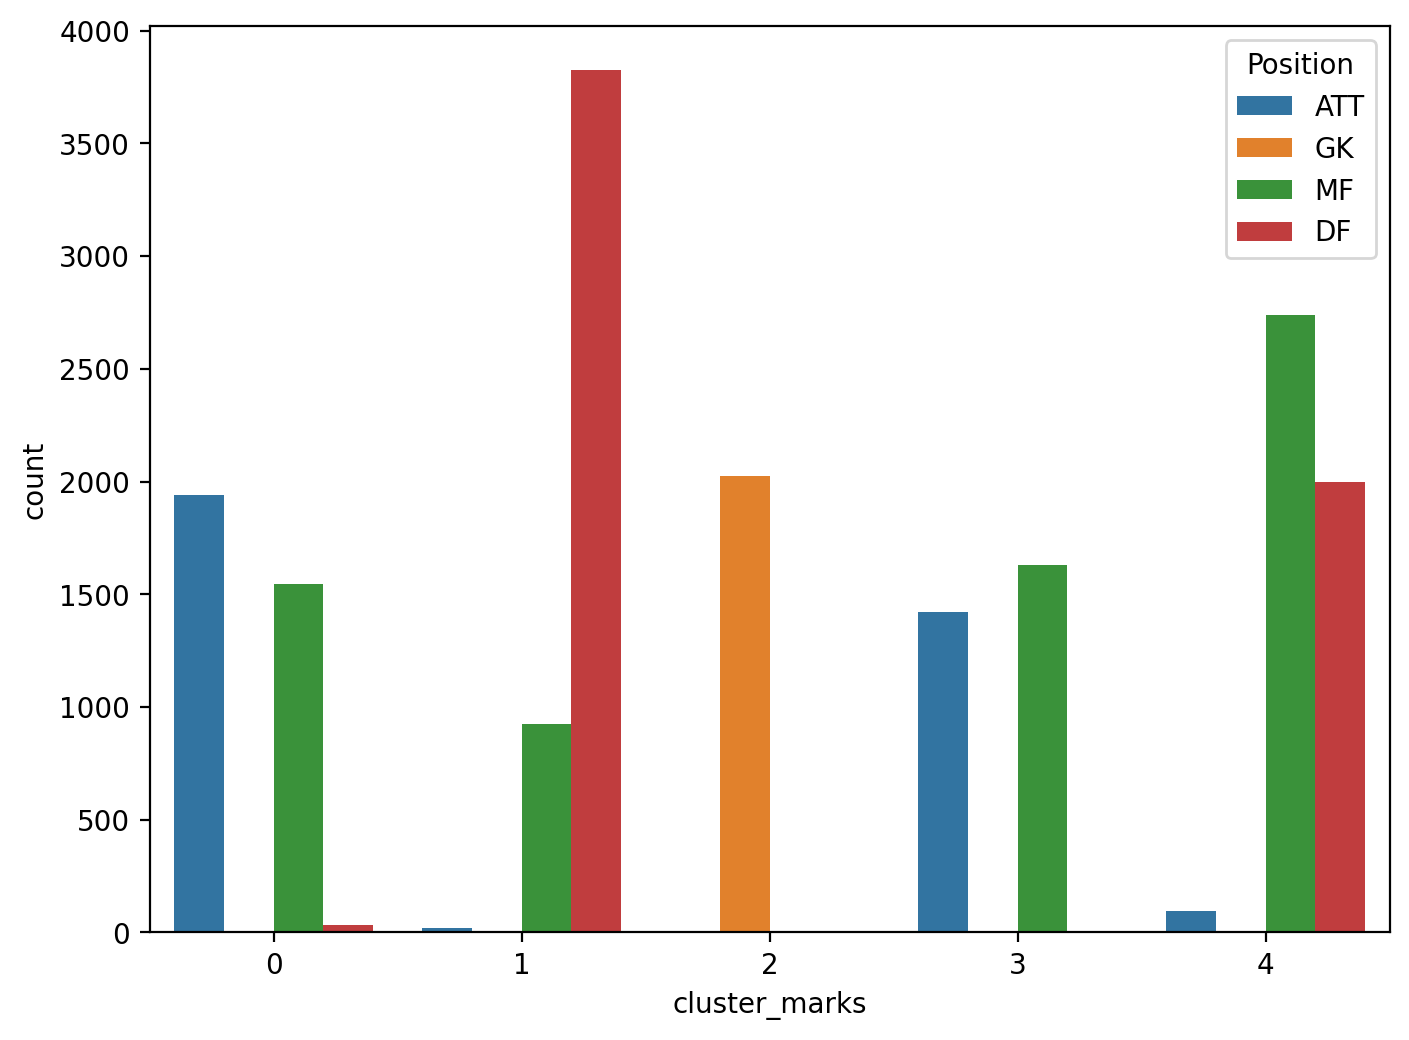

In [972]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [973]:
keep_columns += ['Stamina']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [974]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4827, (26.511781183061462 %)

NAPAD: 89 (1.8437953180029003 %)
Broj igraca na poziciji RF: 1, (0.020716801325875285 %)
Broj igraca na poziciji LF: 1, (0.020716801325875285 %)
Broj igraca na poziciji RW: 26, (0.5386368344727575 %)
Broj igraca na poziciji LW: 28, (0.580070437124508 %)
Broj igraca na poziciji ST: 25, (0.5179200331468822 %)
Broj igraca na poziciji CF: 1, (0.020716801325875285 %)
Broj igraca na poziciji RS: 4, (0.08286720530350114 %)
Broj igraca na poziciji LS: 3, (0.06215040397762585 %)

VEZNI RED: 2736 (56.68116842759478 %)
Broj igraca na poziciji RDM: 185, (3.8326082452869272 %)
Broj igraca na poziciji CDM: 541, (11.20778951729853 %)
Broj igraca na poziciji LDM: 177, (3.6668738346799254 %)
Broj igraca na poziciji RM: 183, (3.791174642635177 %)
Broj igraca na poziciji RCM: 291, (6.028589185829708 %)
Broj igraca na poziciji CM: 743, (15.392583385125336 %)
Broj igraca na poziciji LCM: 267, (5.531385954008701 %)
Broj igraca na poziciji LM: 178, (3.6

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

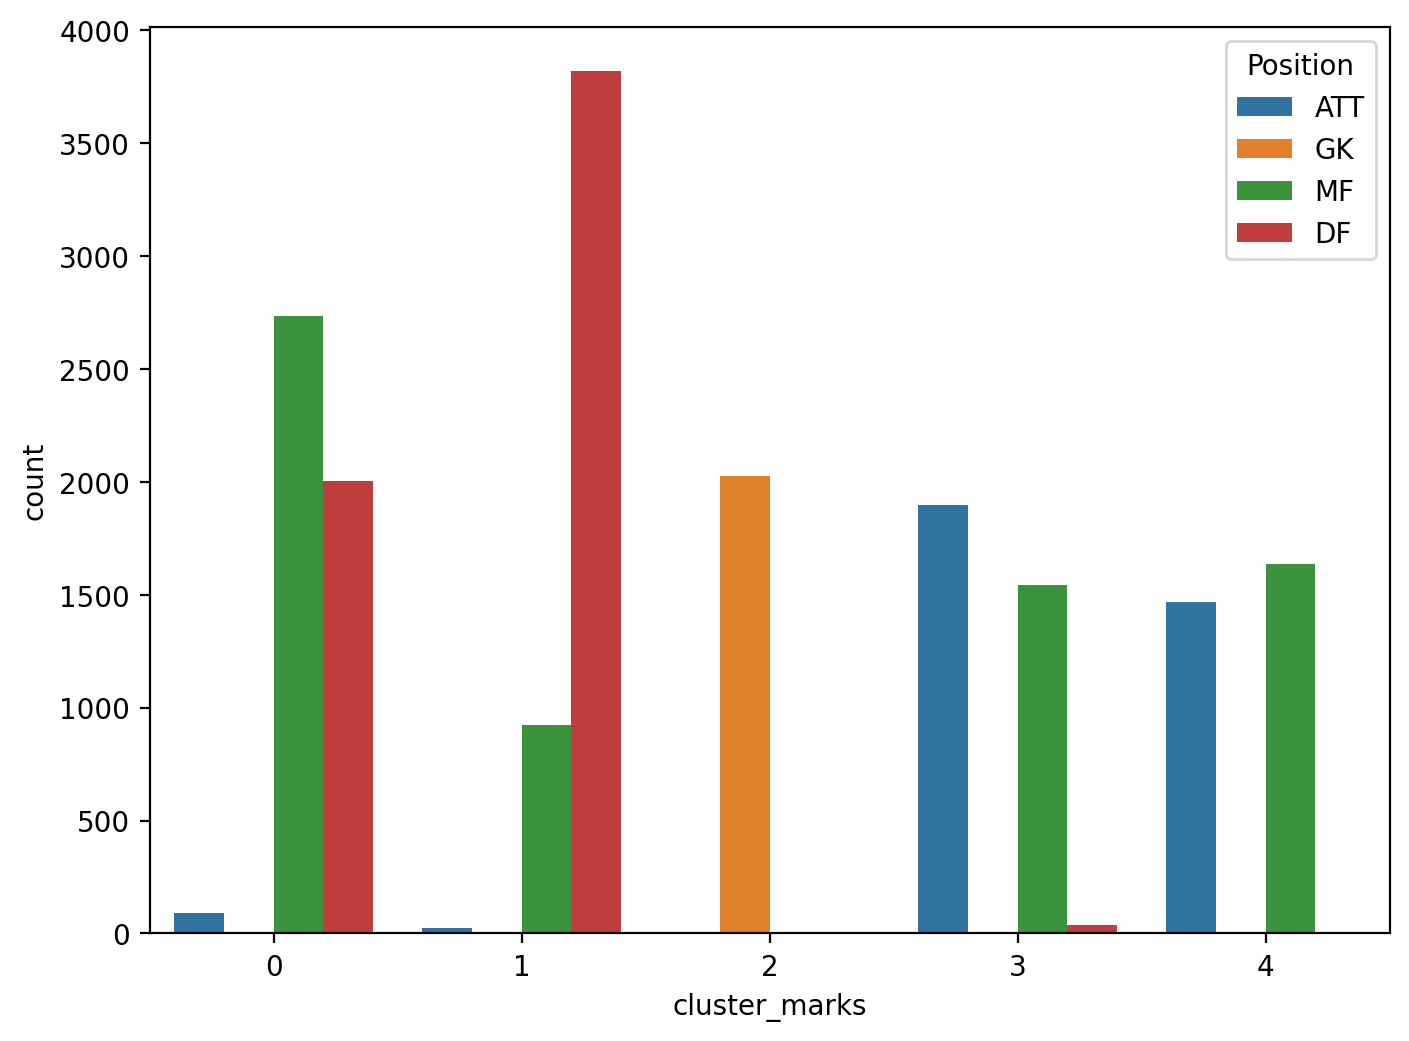

In [975]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [976]:
keep_columns += ['Aggression']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [977]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3142, (17.257098917998572 %)

NAPAD: 1495 (47.58115849777212 %)
Broj igraca na poziciji RF: 15, (0.47740292807129214 %)
Broj igraca na poziciji LF: 13, (0.4137492043284532 %)
Broj igraca na poziciji RW: 177, (5.633354551241248 %)
Broj igraca na poziciji LW: 179, (5.6970082749840865 %)
Broj igraca na poziciji ST: 824, (26.225334182049647 %)
Broj igraca na poziciji CF: 35, (1.1139401654996817 %)
Broj igraca na poziciji RS: 120, (3.819223424570337 %)
Broj igraca na poziciji LS: 132, (4.201145767027372 %)

VEZNI RED: 1642 (52.259707192870785 %)
Broj igraca na poziciji RDM: 9, (0.2864417568427753 %)
Broj igraca na poziciji CDM: 2, (0.06365372374283895 %)
Broj igraca na poziciji LDM: 13, (0.4137492043284532 %)
Broj igraca na poziciji RM: 478, (15.213239974538512 %)
Broj igraca na poziciji RCM: 48, (1.5276893698281349 %)
Broj igraca na poziciji CM: 78, (2.4824952259707196 %)
Broj igraca na poziciji LCM: 68, (2.1642266072565244 %)
Broj igraca na poziciji LM: 474, (15.

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

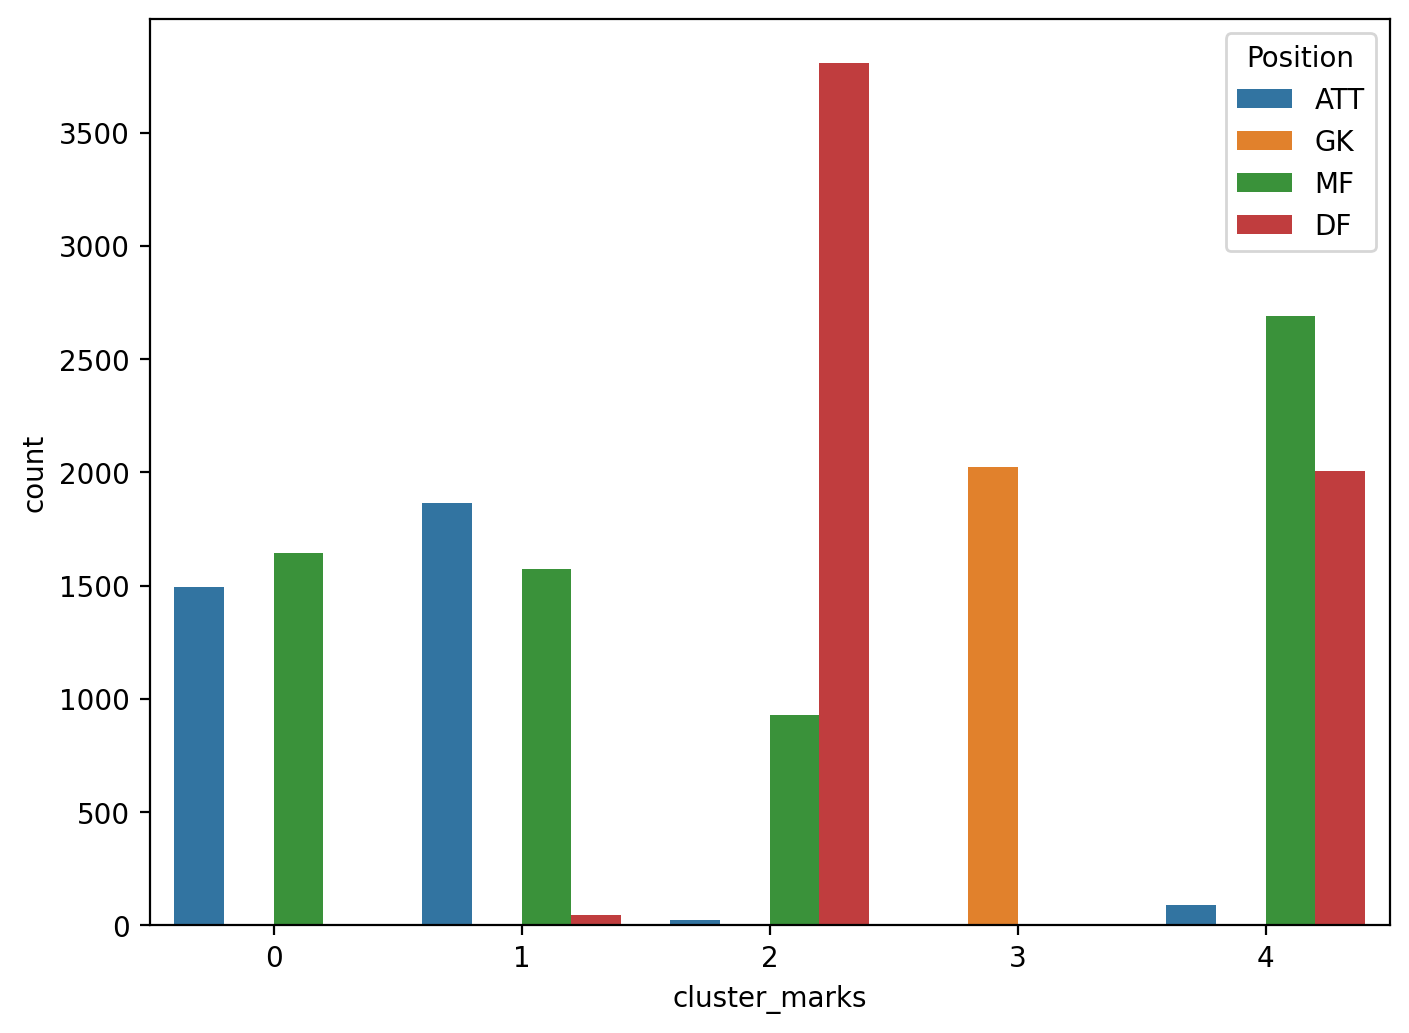

In [978]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [979]:
keep_columns += ['Positioning']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [980]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3180, (17.465809853353107 %)

NAPAD: 1550 (48.742138364779876 %)
Broj igraca na poziciji RF: 15, (0.4716981132075472 %)
Broj igraca na poziciji LF: 13, (0.4088050314465409 %)
Broj igraca na poziciji RW: 176, (5.534591194968554 %)
Broj igraca na poziciji LW: 183, (5.754716981132075 %)
Broj igraca na poziciji ST: 869, (27.32704402515723 %)
Broj igraca na poziciji CF: 36, (1.1320754716981132 %)
Broj igraca na poziciji RS: 123, (3.8679245283018866 %)
Broj igraca na poziciji LS: 135, (4.245283018867925 %)

VEZNI RED: 1625 (51.100628930817614 %)
Broj igraca na poziciji RDM: 10, (0.3144654088050315 %)
Broj igraca na poziciji CDM: 3, (0.09433962264150944 %)
Broj igraca na poziciji LDM: 12, (0.37735849056603776 %)
Broj igraca na poziciji RM: 472, (14.842767295597485 %)
Broj igraca na poziciji RCM: 48, (1.509433962264151 %)
Broj igraca na poziciji CM: 72, (2.2641509433962264 %)
Broj igraca na poziciji LCM: 67, (2.1069182389937104 %)
Broj igraca na poziciji LM: 473, (14.

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

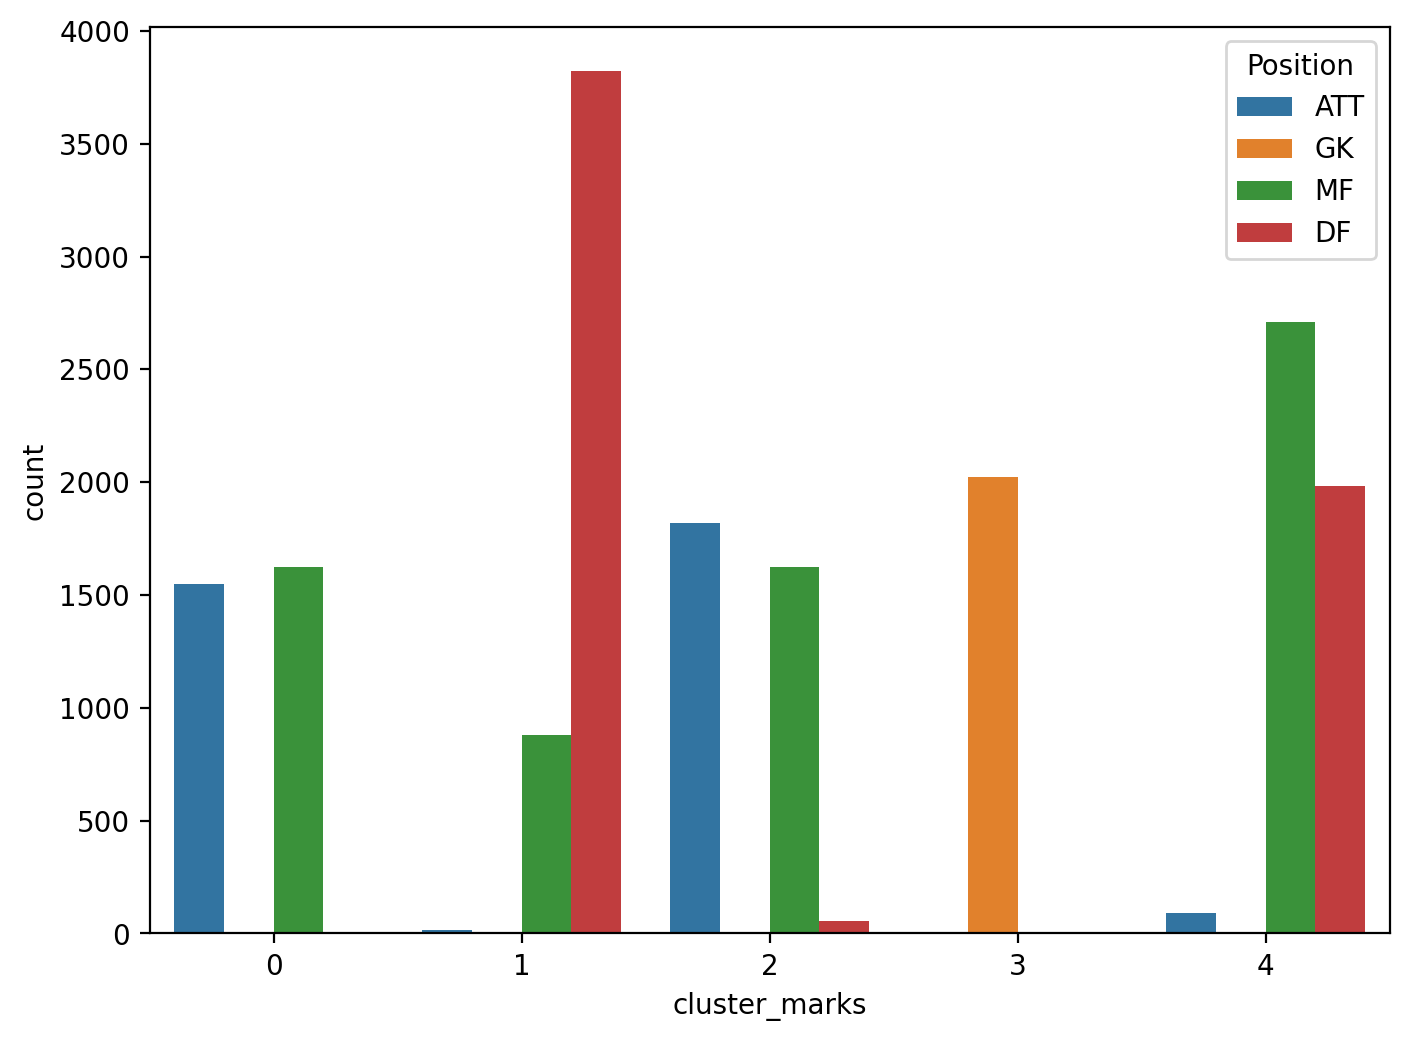

In [981]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [982]:
keep_columns += ['Vision']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [983]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3625, (19.90992475421541 %)

NAPAD: 1938 (53.46206896551724 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 1, (0.027586206896551724 %)
Broj igraca na poziciji RW: 173, (4.772413793103449 %)
Broj igraca na poziciji LW: 182, (5.020689655172414 %)
Broj igraca na poziciji ST: 1392, (38.4 %)
Broj igraca na poziciji CF: 38, (1.0482758620689656 %)
Broj igraca na poziciji RS: 75, (2.0689655172413794 %)
Broj igraca na poziciji LS: 77, (2.1241379310344826 %)

VEZNI RED: 1639 (45.213793103448275 %)
Broj igraca na poziciji RDM: 8, (0.2206896551724138 %)
Broj igraca na poziciji CDM: 10, (0.27586206896551724 %)
Broj igraca na poziciji LDM: 7, (0.19310344827586207 %)
Broj igraca na poziciji RM: 457, (12.606896551724137 %)
Broj igraca na poziciji RCM: 18, (0.4965517241379311 %)
Broj igraca na poziciji CM: 306, (8.441379310344828 %)
Broj igraca na poziciji LCM: 31, (0.8551724137931035 %)
Broj igraca na poziciji LM: 435, (12.0 %)
Broj igraca na poziciji R

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

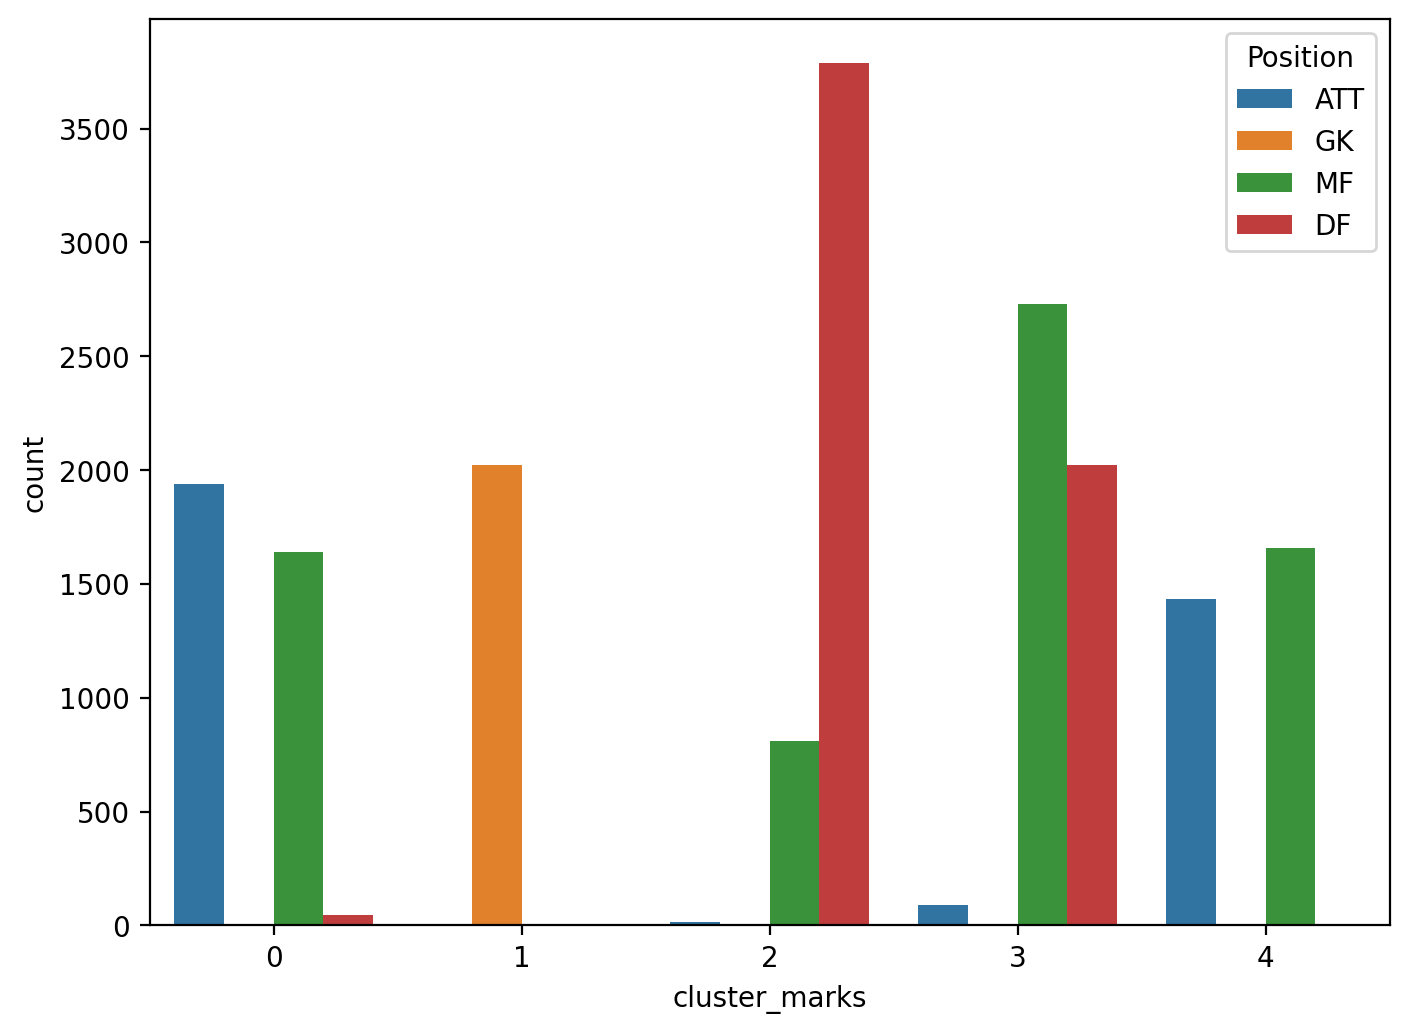

In [984]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [985]:
keep_columns += ['Penalties']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [986]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4663, (25.61102872521558 %)

NAPAD: 14 (0.30023589963542785 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 1, (0.02144542140253056 %)
Broj igraca na poziciji ST: 11, (0.23589963542783618 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 2, (0.04289084280506112 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 833 (17.864036028307957 %)
Broj igraca na poziciji RDM: 39, (0.8363714346986918 %)
Broj igraca na poziciji CDM: 360, (7.720351704911002 %)
Broj igraca na poziciji LDM: 36, (0.7720351704911002 %)
Broj igraca na poziciji RM: 25, (0.5361355350632641 %)
Broj igraca na poziciji RCM: 33, (0.7076989062835085 %)
Broj igraca na poziciji CM: 273, (5.854600042890843 %)
Broj igraca na poziciji LCM: 31, (0.6648080634784473 %)
Broj igraca na poziciji LM: 28, (0.6004717992708557 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CA

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

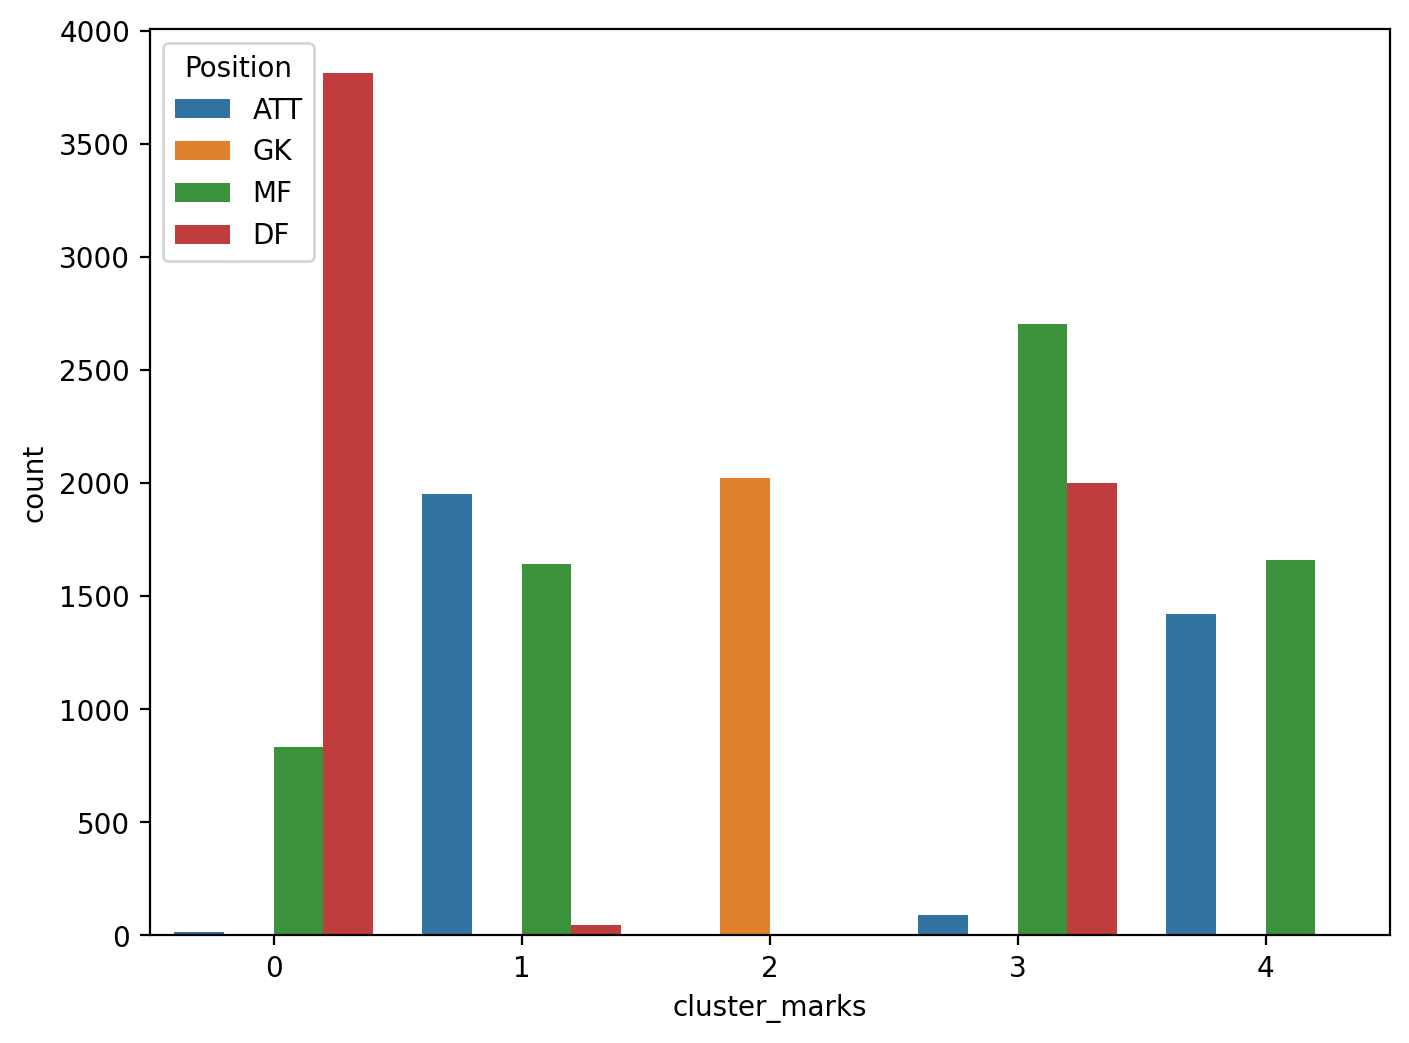

In [987]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

# DODAVANJE PARAMETARA KOJI GOLMANE CINE SUPERIORNIJIM

In [988]:
keep_columns += ['GKDiving']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [989]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3086, (16.949524908002417 %)

NAPAD: 1422 (46.079066753078415 %)
Broj igraca na poziciji RF: 14, (0.45366169799092676 %)
Broj igraca na poziciji LF: 14, (0.45366169799092676 %)
Broj igraca na poziciji RW: 166, (5.379131561892417 %)
Broj igraca na poziciji LW: 169, (5.4763447828904726 %)
Broj igraca na poziciji ST: 778, (25.210628645495785 %)
Broj igraca na poziciji CF: 33, (1.069345430978613 %)
Broj igraca na poziciji RS: 122, (3.9533376539209333 %)
Broj igraca na poziciji LS: 126, (4.08295528191834 %)

VEZNI RED: 1657 (53.694102397926116 %)
Broj igraca na poziciji RDM: 12, (0.38885288399222295 %)
Broj igraca na poziciji CDM: 4, (0.12961762799740764 %)
Broj igraca na poziciji LDM: 14, (0.45366169799092676 %)
Broj igraca na poziciji RM: 454, (14.711600777705769 %)
Broj igraca na poziciji RCM: 61, (1.9766688269604666 %)
Broj igraca na poziciji CM: 98, (3.175631885936488 %)
Broj igraca na poziciji LCM: 78, (2.5275437459494494 %)
Broj igraca na poziciji LM: 458, (

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

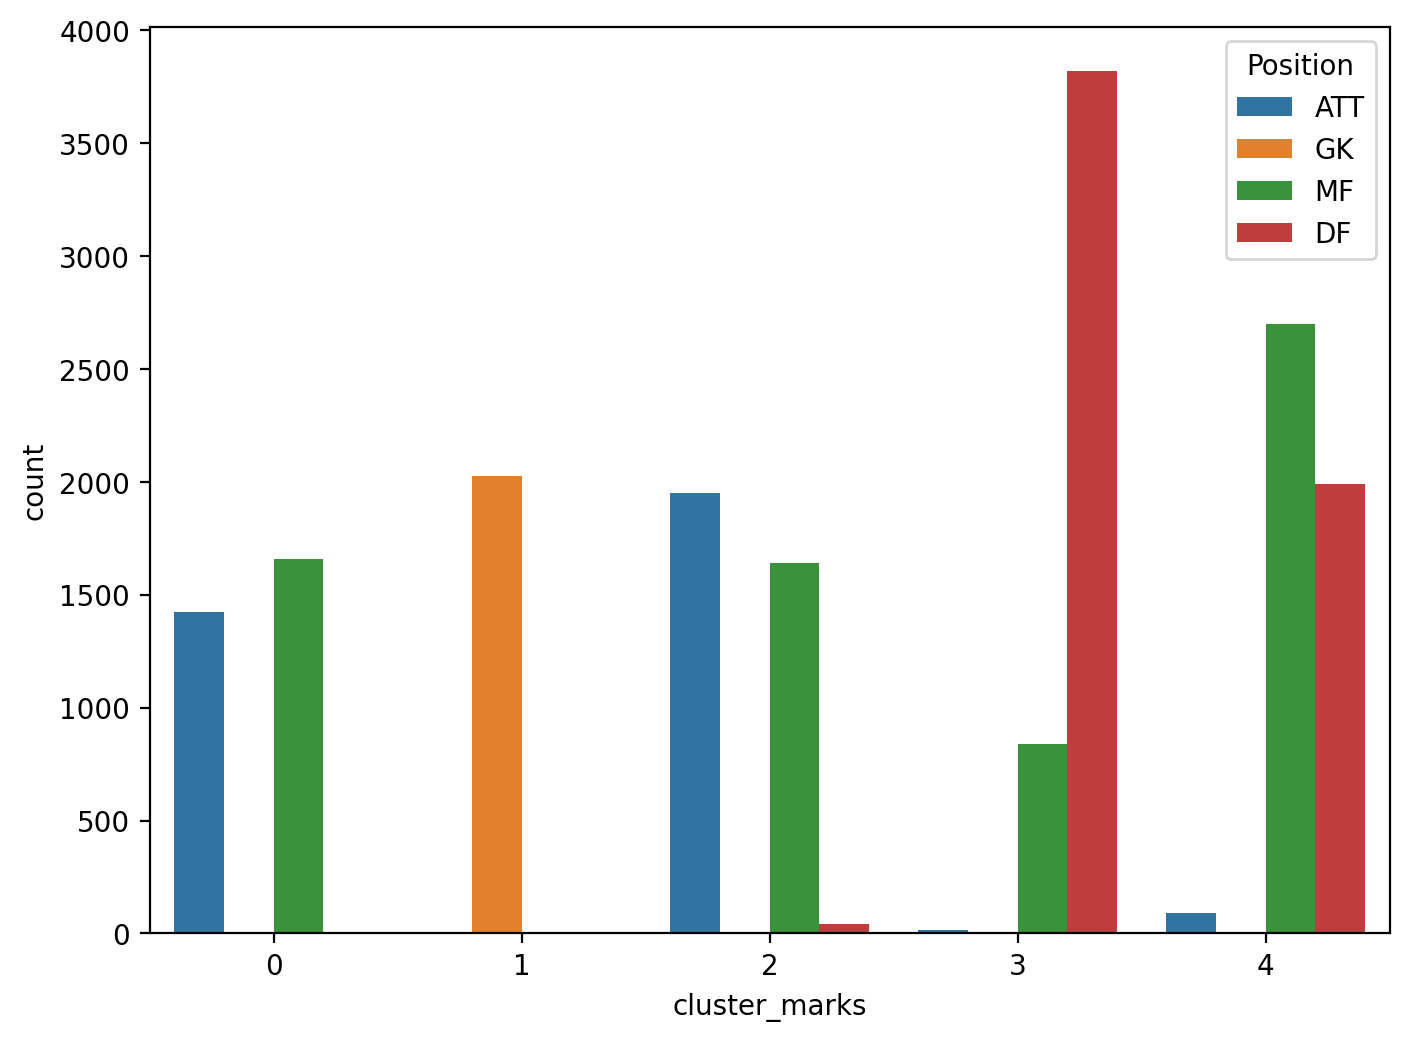

In [990]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [991]:
keep_columns += ['GKHandling']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [992]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3636, (19.970341077607515 %)

NAPAD: 1948 (53.575357535753575 %)
Broj igraca na poziciji RF: 1, (0.0275027502750275 %)
Broj igraca na poziciji LF: 1, (0.0275027502750275 %)
Broj igraca na poziciji RW: 177, (4.867986798679868 %)
Broj igraca na poziciji LW: 183, (5.033003300330033 %)
Broj igraca na poziciji ST: 1395, (38.366336633663366 %)
Broj igraca na poziciji CF: 40, (1.1001100110011002 %)
Broj igraca na poziciji RS: 74, (2.035203520352035 %)
Broj igraca na poziciji LS: 77, (2.1177117711771176 %)

VEZNI RED: 1644 (45.21452145214521 %)
Broj igraca na poziciji RDM: 8, (0.22002200220022 %)
Broj igraca na poziciji CDM: 11, (0.3025302530253025 %)
Broj igraca na poziciji LDM: 7, (0.1925192519251925 %)
Broj igraca na poziciji RM: 464, (12.761276127612762 %)
Broj igraca na poziciji RCM: 19, (0.5225522552255226 %)
Broj igraca na poziciji CM: 294, (8.085808580858085 %)
Broj igraca na poziciji LCM: 28, (0.77007700770077 %)
Broj igraca na poziciji LM: 441, (12.128712871

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

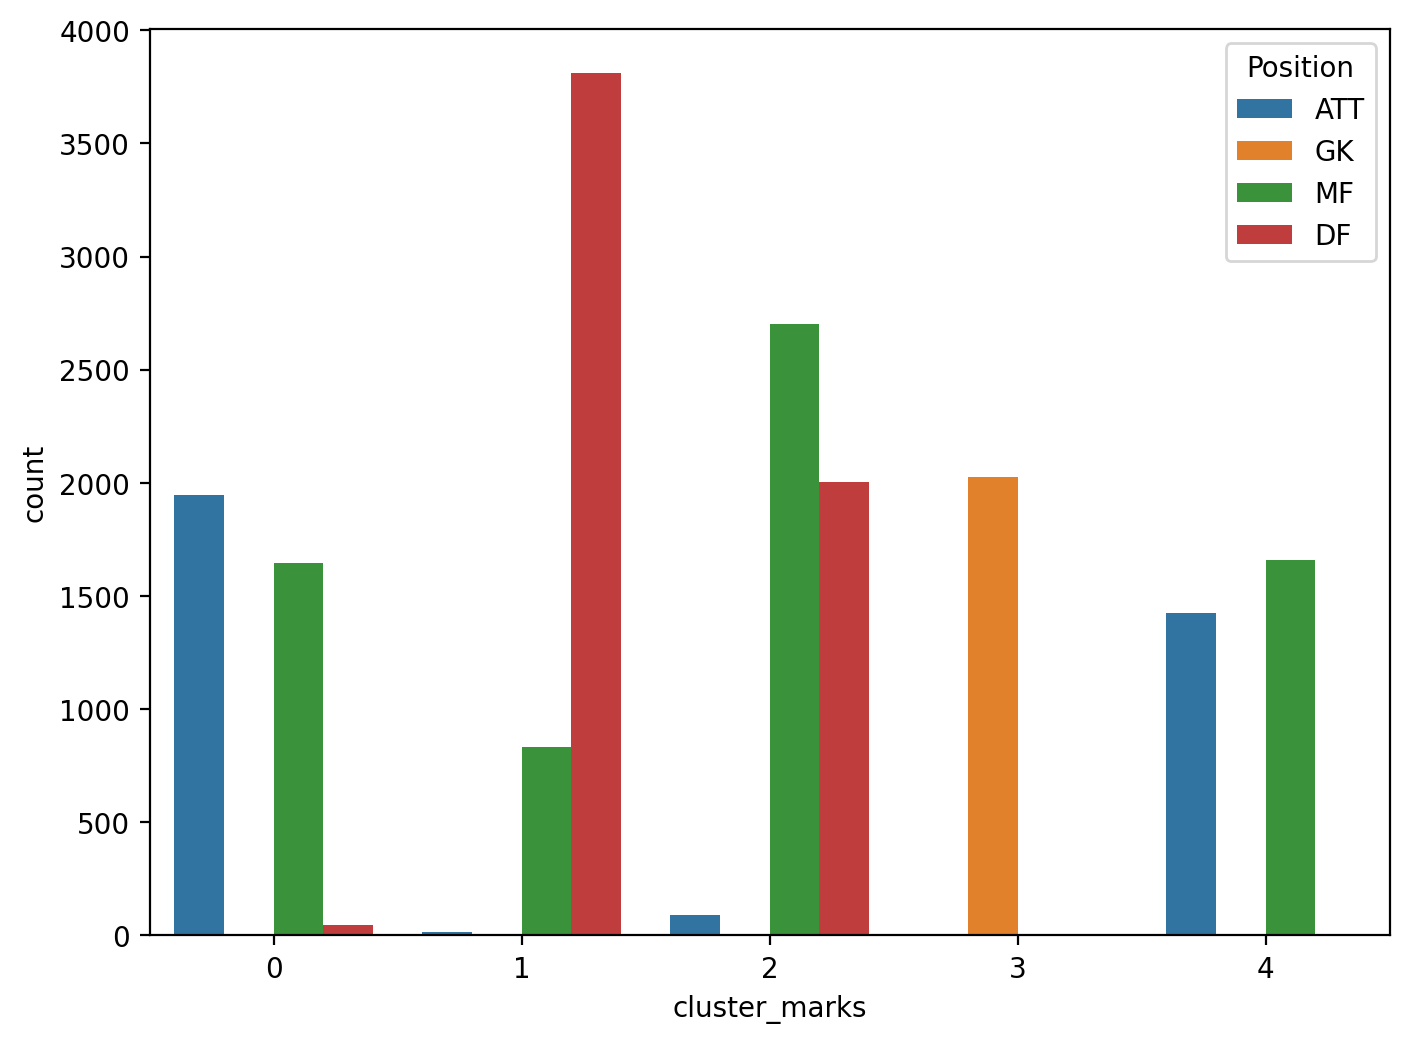

In [993]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [994]:
keep_columns += ['GKKicking']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [995]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3085, (16.94403251496677 %)

NAPAD: 1420 (46.029173419773095 %)
Broj igraca na poziciji RF: 14, (0.45380875202593196 %)
Broj igraca na poziciji LF: 14, (0.45380875202593196 %)
Broj igraca na poziciji RW: 166, (5.380875202593193 %)
Broj igraca na poziciji LW: 168, (5.445705024311183 %)
Broj igraca na poziciji ST: 777, (25.18638573743922 %)
Broj igraca na poziciji CF: 33, (1.0696920583468394 %)
Broj igraca na poziciji RS: 122, (3.9546191247974067 %)
Broj igraca na poziciji LS: 126, (4.084278768233387 %)

VEZNI RED: 1658 (53.74392220421393 %)
Broj igraca na poziciji RDM: 12, (0.3889789303079416 %)
Broj igraca na poziciji CDM: 4, (0.12965964343598055 %)
Broj igraca na poziciji LDM: 15, (0.48622366288492713 %)
Broj igraca na poziciji RM: 454, (14.716369529983792 %)
Broj igraca na poziciji RCM: 61, (1.9773095623987034 %)
Broj igraca na poziciji CM: 99, (3.2090761750405186 %)
Broj igraca na poziciji LCM: 78, (2.528363047001621 %)
Broj igraca na poziciji LM: 457, (14.

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

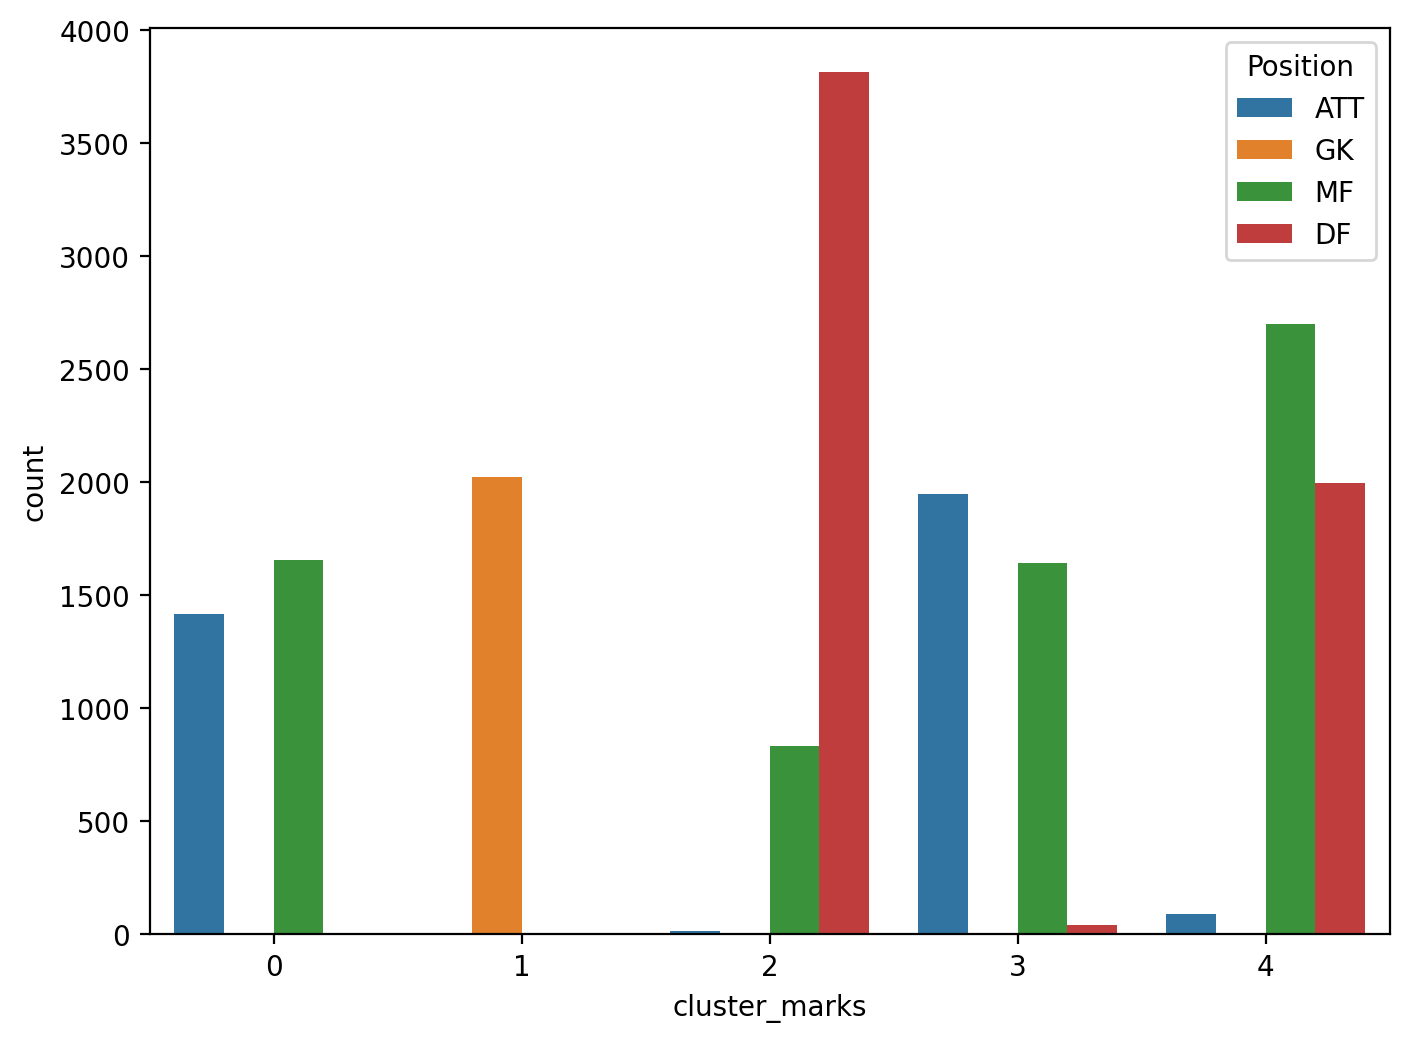

In [996]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [997]:
keep_columns += ['GKPositioning']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [998]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3091, (16.976986873180643 %)

NAPAD: 1422 (46.004529278550635 %)
Broj igraca na poziciji RF: 14, (0.4529278550630864 %)
Broj igraca na poziciji LF: 14, (0.4529278550630864 %)
Broj igraca na poziciji RW: 166, (5.37043028146231 %)
Broj igraca na poziciji LW: 169, (5.4674862504043995 %)
Broj igraca na poziciji ST: 778, (25.16984794564866 %)
Broj igraca na poziciji CF: 33, (1.0676156583629894 %)
Broj igraca na poziciji RS: 122, (3.946942736978324 %)
Broj igraca na poziciji LS: 126, (4.076350695567777 %)

VEZNI RED: 1662 (53.769006793917825 %)
Broj igraca na poziciji RDM: 12, (0.38822387576835976 %)
Broj igraca na poziciji CDM: 4, (0.12940795858945325 %)
Broj igraca na poziciji LDM: 15, (0.48527984471044966 %)
Broj igraca na poziciji RM: 454, (14.687803299902944 %)
Broj igraca na poziciji RCM: 61, (1.973471368489162 %)
Broj igraca na poziciji CM: 102, (3.299902944031058 %)
Broj igraca na poziciji LCM: 78, (2.5234551924943385 %)
Broj igraca na poziciji LM: 458, (14.

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

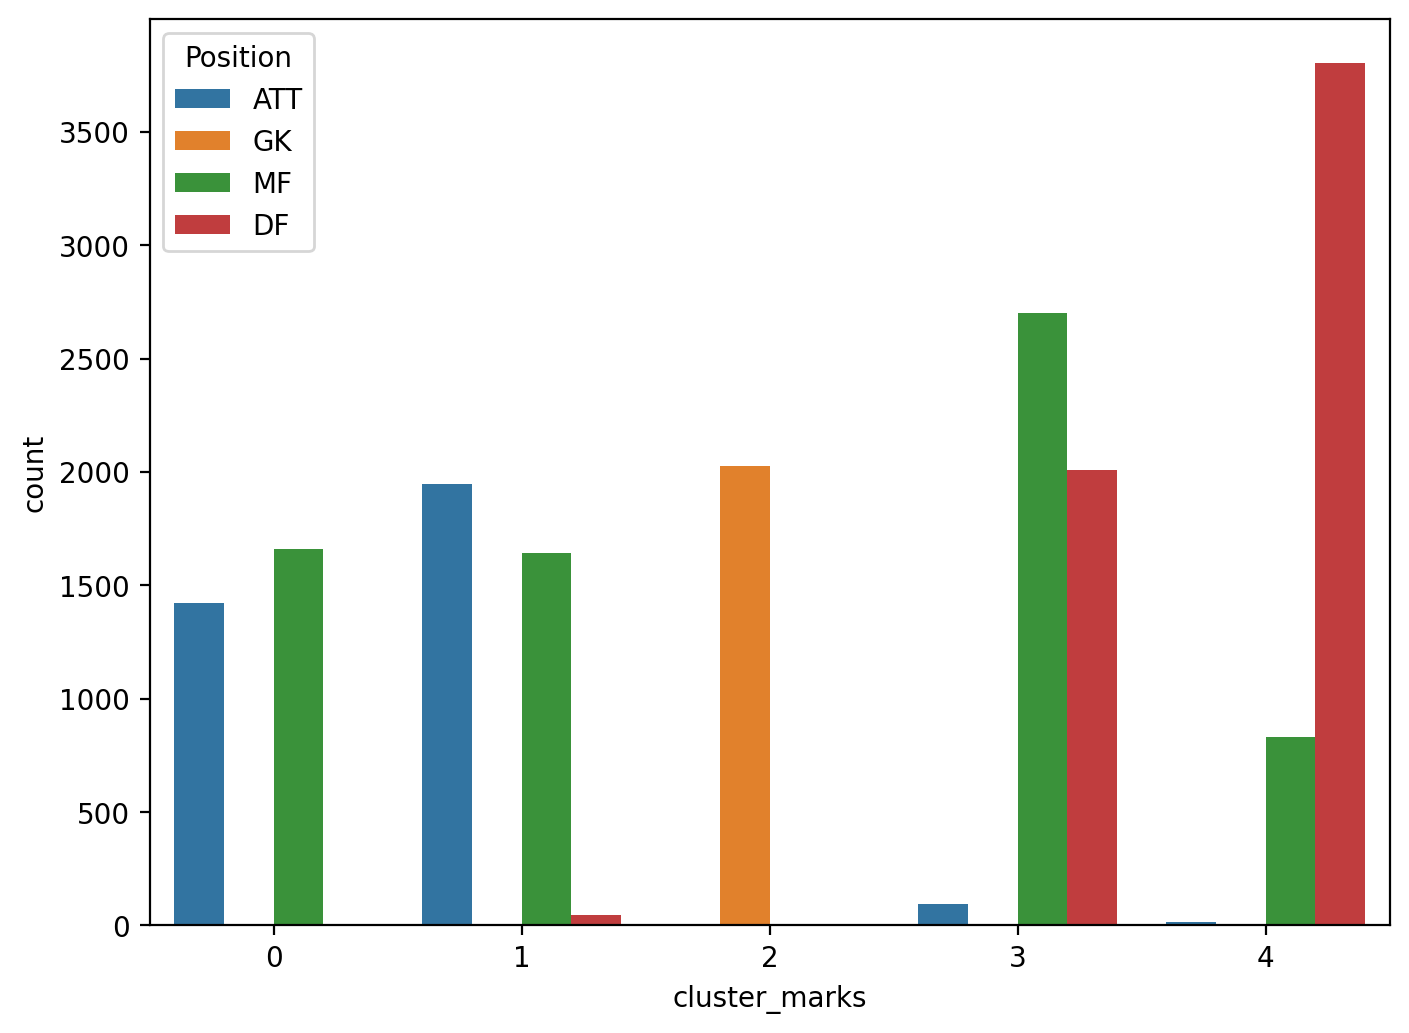

In [999]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1000]:
keep_columns += ['GKReflexes']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1001]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 2026, (11.127588290218048 %)

NAPAD: 1 (0.04935834155972359 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 1, (0.04935834155972359 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 0 (0.0 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 0 (0.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji R

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

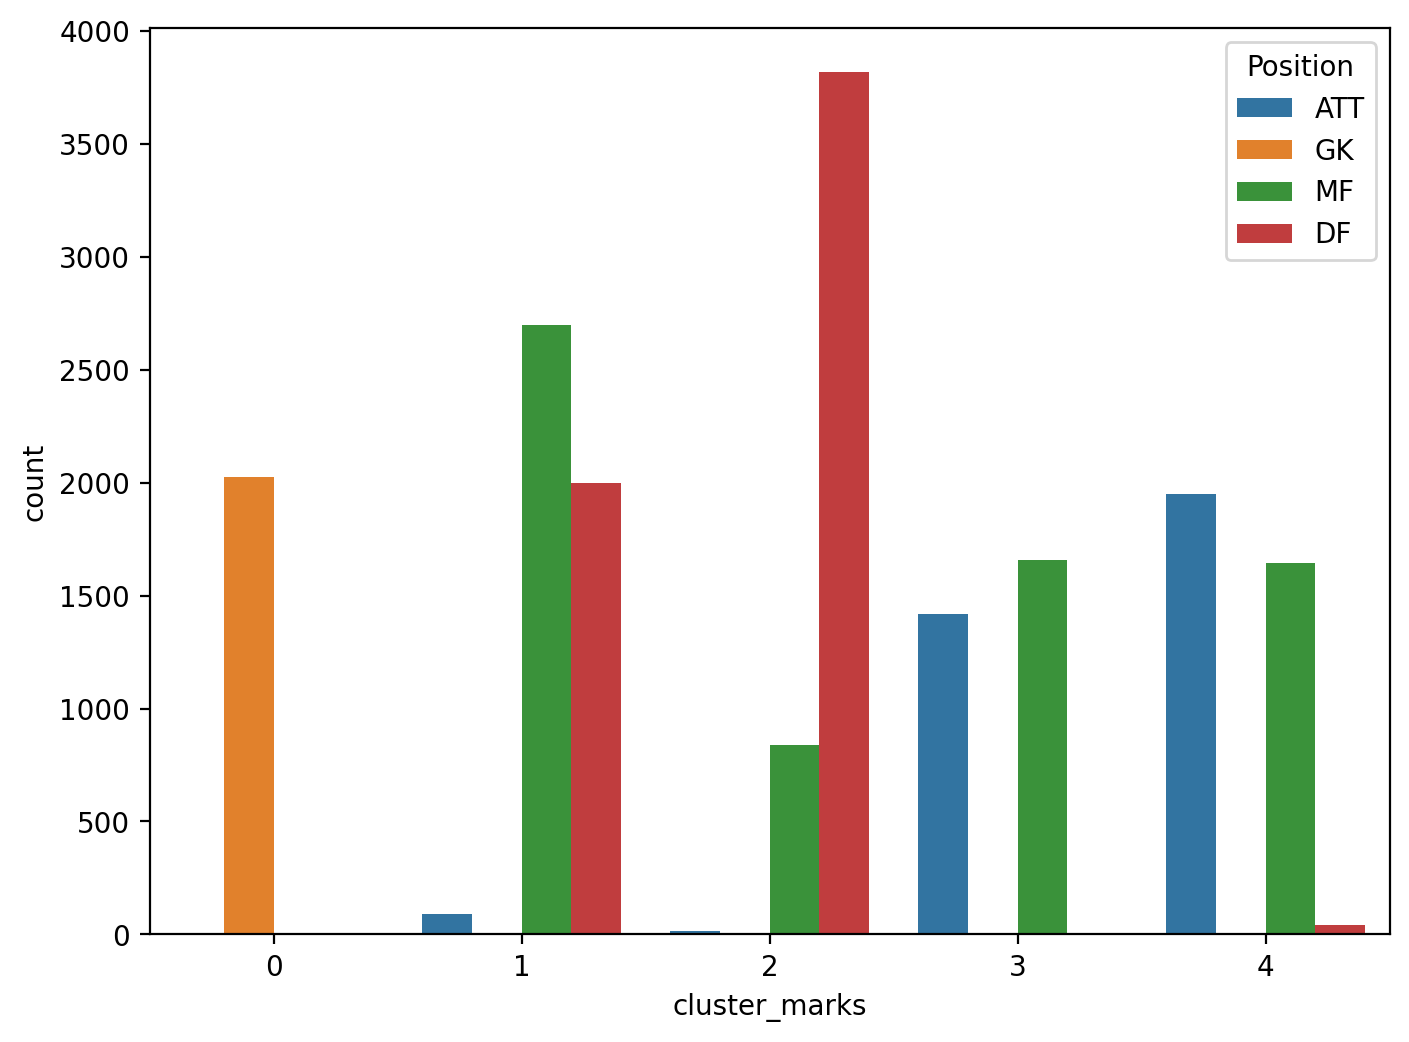

In [1002]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1004]:
df[numeric].columns.values

array(['Unnamed: 0', 'ID', 'Age', 'Overall', 'Potential', 'Special',
       'International Reputation', 'Weak Foot', 'Skill Moves',
       'Jersey Number', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed',
       'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping',
       'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions',
       'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking',
       'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes'], dtype=object)

# ODAVDE

In [1097]:
# temp(df, 'ID')

In [1023]:
# temp(df, 'Age')

In [1022]:
# temp(df, 'Overall')

In [1021]:
# temp(df, 'Potential')

In [1020]:
# temp(df, 'Special')

In [1019]:
# temp(df, 'International Reputation')

In [1018]:
# temp(df, 'Weak Foot')

In [1017]:
# temp(df, 'Skill Moves')

In [1016]:
# temp(df, 'Jersey Number')

In [1015]:
# temp(df, 'Crossing')

In [1026]:
# temp(df, 'Finishing')

In [1028]:
# temp(df, 'HeadingAccuracy')

In [1030]:
# temp(df, 'ShortPassing')

In [1032]:
# temp(df, 'Volleys')

In [1034]:
# temp(df, 'Dribbling')

In [1036]:
# temp(df, 'Curve')

In [1038]:
# temp(df, 'FKAccuracy')

In [1040]:
# temp(df, 'LongPassing')

In [1042]:
# temp(df, 'BallControl')

In [1044]:
# temp(df, 'Acceleration')

In [1046]:
# temp(df, 'SprintSpeed')

In [1048]:
# temp(df, 'Agility')

In [1050]:
# temp(df, 'Reactions')

In [1052]:
# temp(df, 'Balance')

In [1054]:
# temp(df, 'ShotPower')

In [1056]:
# temp(df, 'Jumping')

In [1058]:
# temp(df, 'Stamina')

In [1060]:
# temp(df, 'Strength')

In [1062]:
# temp(df, 'LongShots')

In [1064]:
# temp(df, 'Aggression')

In [1066]:
# temp(df, 'Interceptions')

In [1068]:
# temp(df, 'Positioning')

In [1070]:
# temp(df, 'Vision')

In [1072]:
# temp(df, 'Penalties')

In [1074]:
# temp(df, 'Composure')

In [1076]:
# temp(df, 'Marking')

In [1078]:
# temp(df, 'StandingTackle')

In [1080]:
# temp(df, 'SlidingTackle')

In [1082]:
# temp(df, 'GKDiving')

In [1084]:
# temp(df, 'GKHandling')

In [1086]:
# temp(df, 'GKKicking')

In [1088]:
# temp(df, 'GKPositioning')

In [1090]:
# temp(df, 'GKReflexes')

# Neutralne kolone

In [1231]:
keep_columns = ['ID']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1232]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 7934, (43.57664634481244 %)

NAPAD: 1631 (20.557096042349382 %)
Broj igraca na poziciji RF: 2, (0.025207965717166627 %)
Broj igraca na poziciji LF: 3, (0.03781194857574994 %)
Broj igraca na poziciji RW: 196, (2.4703806402823294 %)
Broj igraca na poziciji LW: 211, (2.659440383161079 %)
Broj igraca na poziciji ST: 1076, (13.561885555835643 %)
Broj igraca na poziciji CF: 43, (0.5419712629190825 %)
Broj igraca na poziciji RS: 49, (0.6175951600705823 %)
Broj igraca na poziciji LS: 51, (0.6428031257877489 %)

VEZNI RED: 3038 (38.290899924376106 %)
Broj igraca na poziciji RDM: 66, (0.8318628686664987 %)
Broj igraca na poziciji CDM: 430, (5.419712629190824 %)
Broj igraca na poziciji LDM: 81, (1.0209226115452483 %)
Broj igraca na poziciji RM: 503, (6.3398033778674066 %)
Broj igraca na poziciji RCM: 117, (1.4746659944542475 %)
Broj igraca na poziciji CM: 761, (9.5916309553819 %)
Broj igraca na poziciji LCM: 103, (1.2982102344340811 %)
Broj igraca na poziciji LM: 479, (6

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

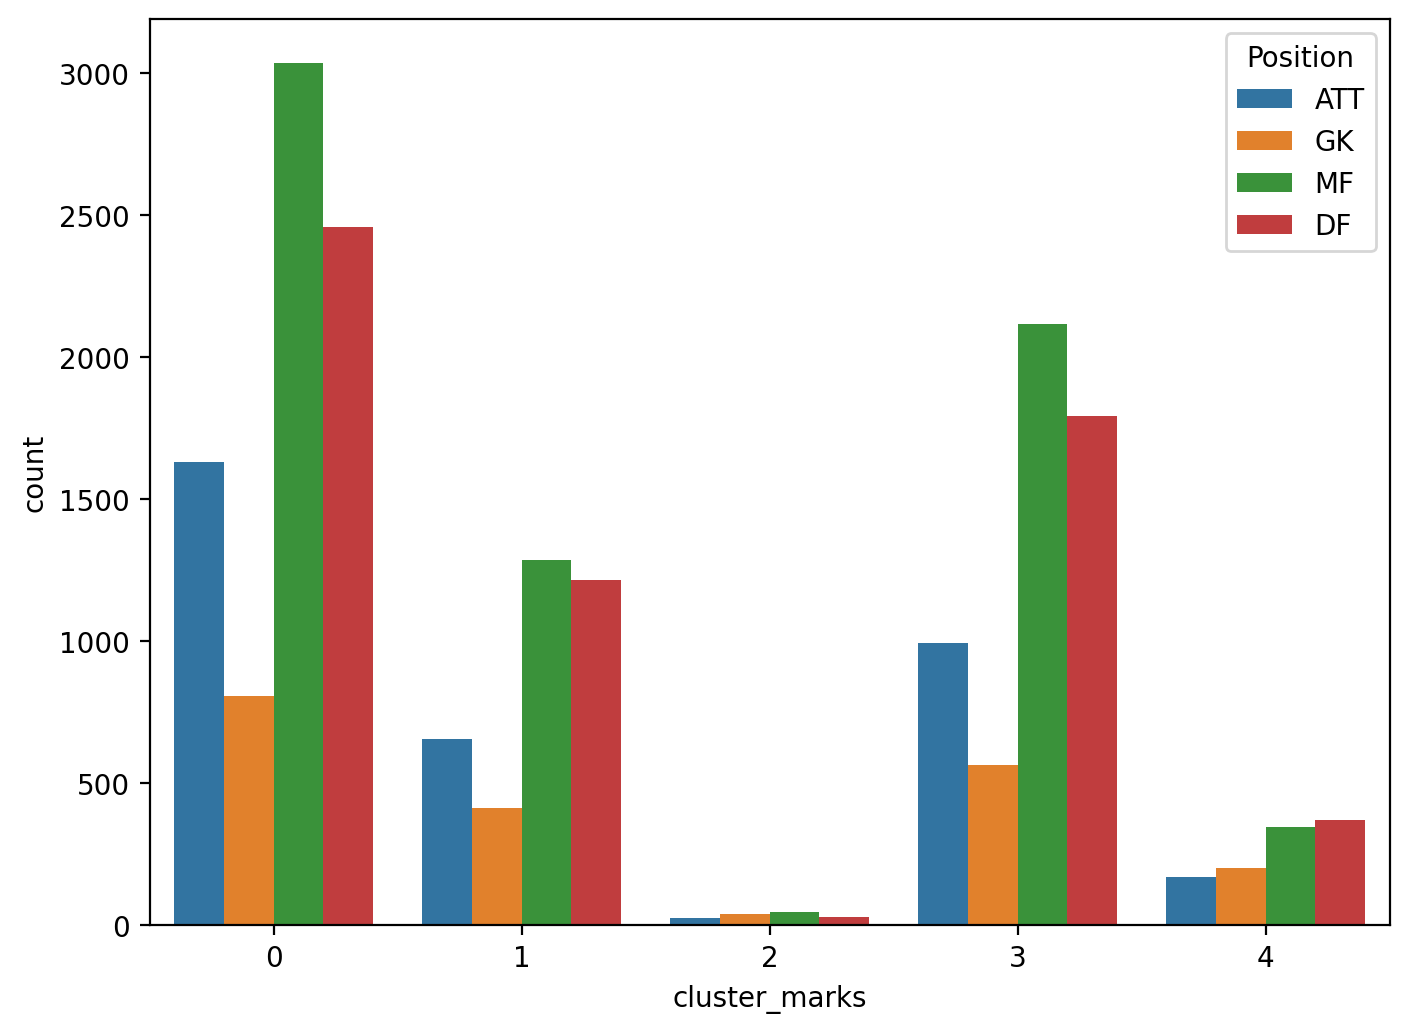

In [1233]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1175]:
keep_columns = ['Age']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1176]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3327, (18.273191629593015 %)

NAPAD: 739 (22.212203186053504 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 1, (0.030057108506161705 %)
Broj igraca na poziciji RW: 85, (2.554854223023745 %)
Broj igraca na poziciji LW: 99, (2.9756537421100093 %)
Broj igraca na poziciji ST: 508, (15.269011121130147 %)
Broj igraca na poziciji CF: 24, (0.7213706041478809 %)
Broj igraca na poziciji RS: 10, (0.30057108506161706 %)
Broj igraca na poziciji LS: 12, (0.36068530207394045 %)

VEZNI RED: 1352 (40.63721070033063 %)
Broj igraca na poziciji RDM: 11, (0.3306281935677788 %)
Broj igraca na poziciji CDM: 174, (5.229936880072137 %)
Broj igraca na poziciji LDM: 17, (0.510970844604749 %)
Broj igraca na poziciji RM: 197, (5.921250375713856 %)
Broj igraca na poziciji RCM: 34, (1.021941689209498 %)
Broj igraca na poziciji CM: 445, (13.37541328524196 %)
Broj igraca na poziciji LCM: 37, (1.1121130147279832 %)
Broj igraca na poziciji LM: 199, (5.98136459272618 %)
Br

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

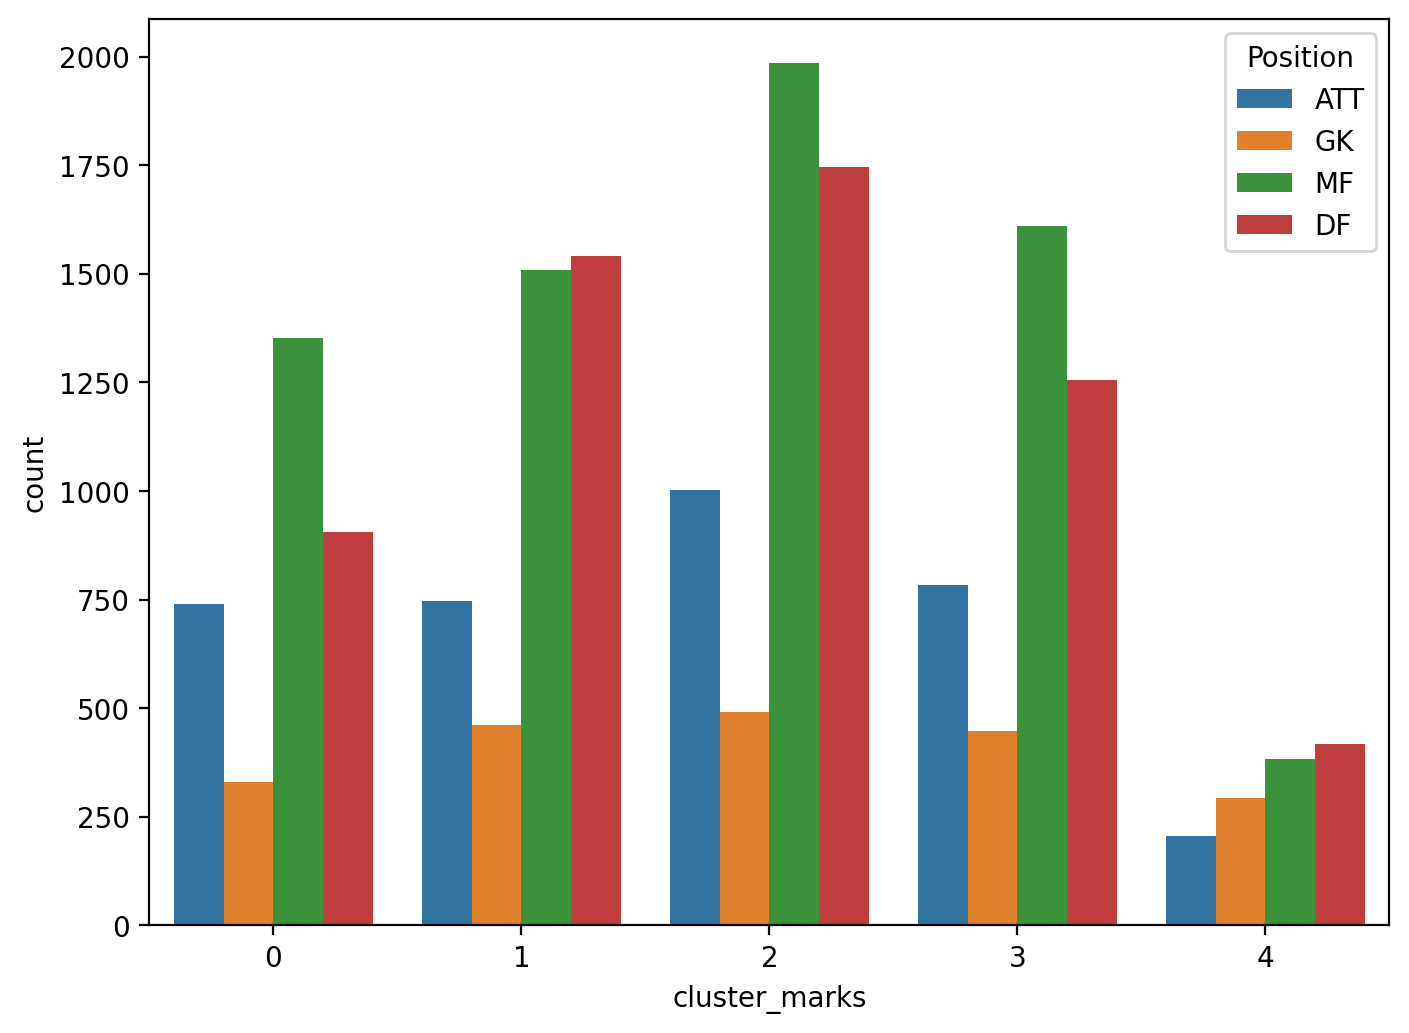

In [1177]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1178]:
keep_columns = ['Overall']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1179]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4440, (24.3862250782666 %)

NAPAD: 835 (18.806306306306304 %)
Broj igraca na poziciji RF: 5, (0.11261261261261261 %)
Broj igraca na poziciji LF: 5, (0.11261261261261261 %)
Broj igraca na poziciji RW: 92, (2.0720720720720722 %)
Broj igraca na poziciji LW: 87, (1.9594594594594597 %)
Broj igraca na poziciji ST: 491, (11.058558558558557 %)
Broj igraca na poziciji CF: 18, (0.40540540540540543 %)
Broj igraca na poziciji RS: 67, (1.5090090090090091 %)
Broj igraca na poziciji LS: 70, (1.5765765765765765 %)

VEZNI RED: 1793 (40.38288288288288 %)
Broj igraca na poziciji RDM: 110, (2.4774774774774775 %)
Broj igraca na poziciji CDM: 223, (5.0225225225225225 %)
Broj igraca na poziciji LDM: 101, (2.274774774774775 %)
Broj igraca na poziciji RM: 293, (6.599099099099099 %)
Broj igraca na poziciji RCM: 132, (2.9729729729729732 %)
Broj igraca na poziciji CM: 229, (5.157657657657658 %)
Broj igraca na poziciji LCM: 139, (3.1306306306306304 %)
Broj igraca na poziciji LM: 280, (6.3

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

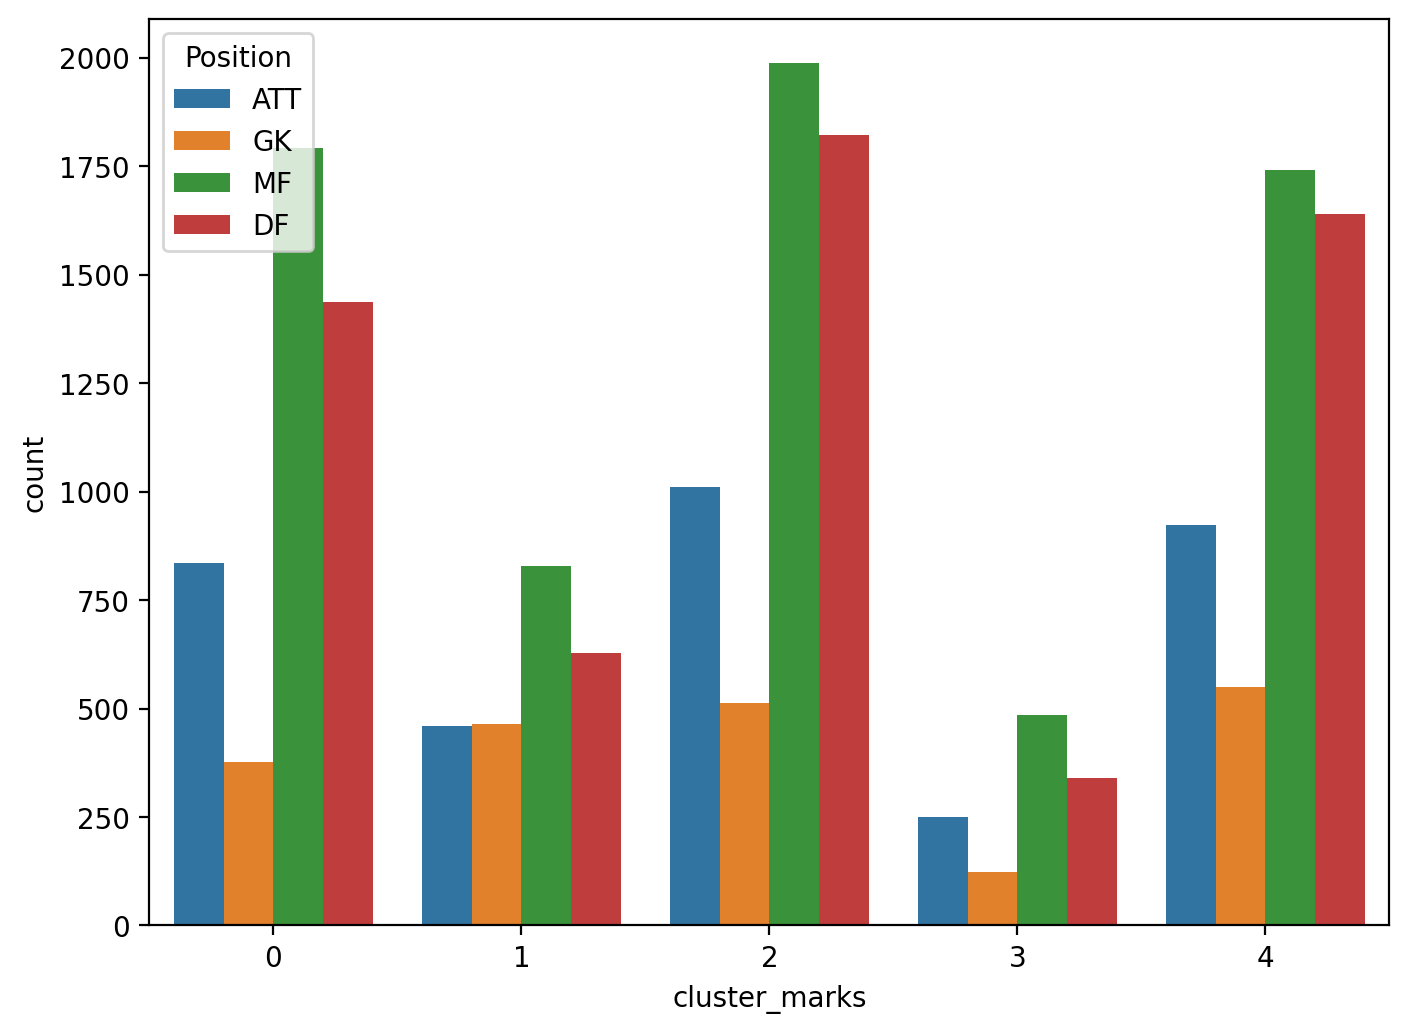

In [1180]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1181]:
keep_columns = ['Potential']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1182]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 5501, (30.213654089086617 %)

NAPAD: 1029 (18.70568987456826 %)
Broj igraca na poziciji RF: 5, (0.09089256498818396 %)
Broj igraca na poziciji LF: 1, (0.018178512997636793 %)
Broj igraca na poziciji RW: 89, (1.6178876567896745 %)
Broj igraca na poziciji LW: 104, (1.8905653517542265 %)
Broj igraca na poziciji ST: 691, (12.561352481367024 %)
Broj igraca na poziciji CF: 17, (0.3090347209598255 %)
Broj igraca na poziciji RS: 62, (1.127067805853481 %)
Broj igraca na poziciji LS: 60, (1.0907107798582076 %)

VEZNI RED: 1917 (34.848209416469736 %)
Broj igraca na poziciji RDM: 69, (1.2543173968369388 %)
Broj igraca na poziciji CDM: 271, (4.926377022359571 %)
Broj igraca na poziciji LDM: 71, (1.2906744228322122 %)
Broj igraca na poziciji RM: 326, (5.926195237229594 %)
Broj igraca na poziciji RCM: 104, (1.8905653517542265 %)
Broj igraca na poziciji CM: 380, (6.907834939101981 %)
Broj igraca na poziciji LCM: 109, (1.9814579167424105 %)
Broj igraca na poziciji LM: 326, (5.

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

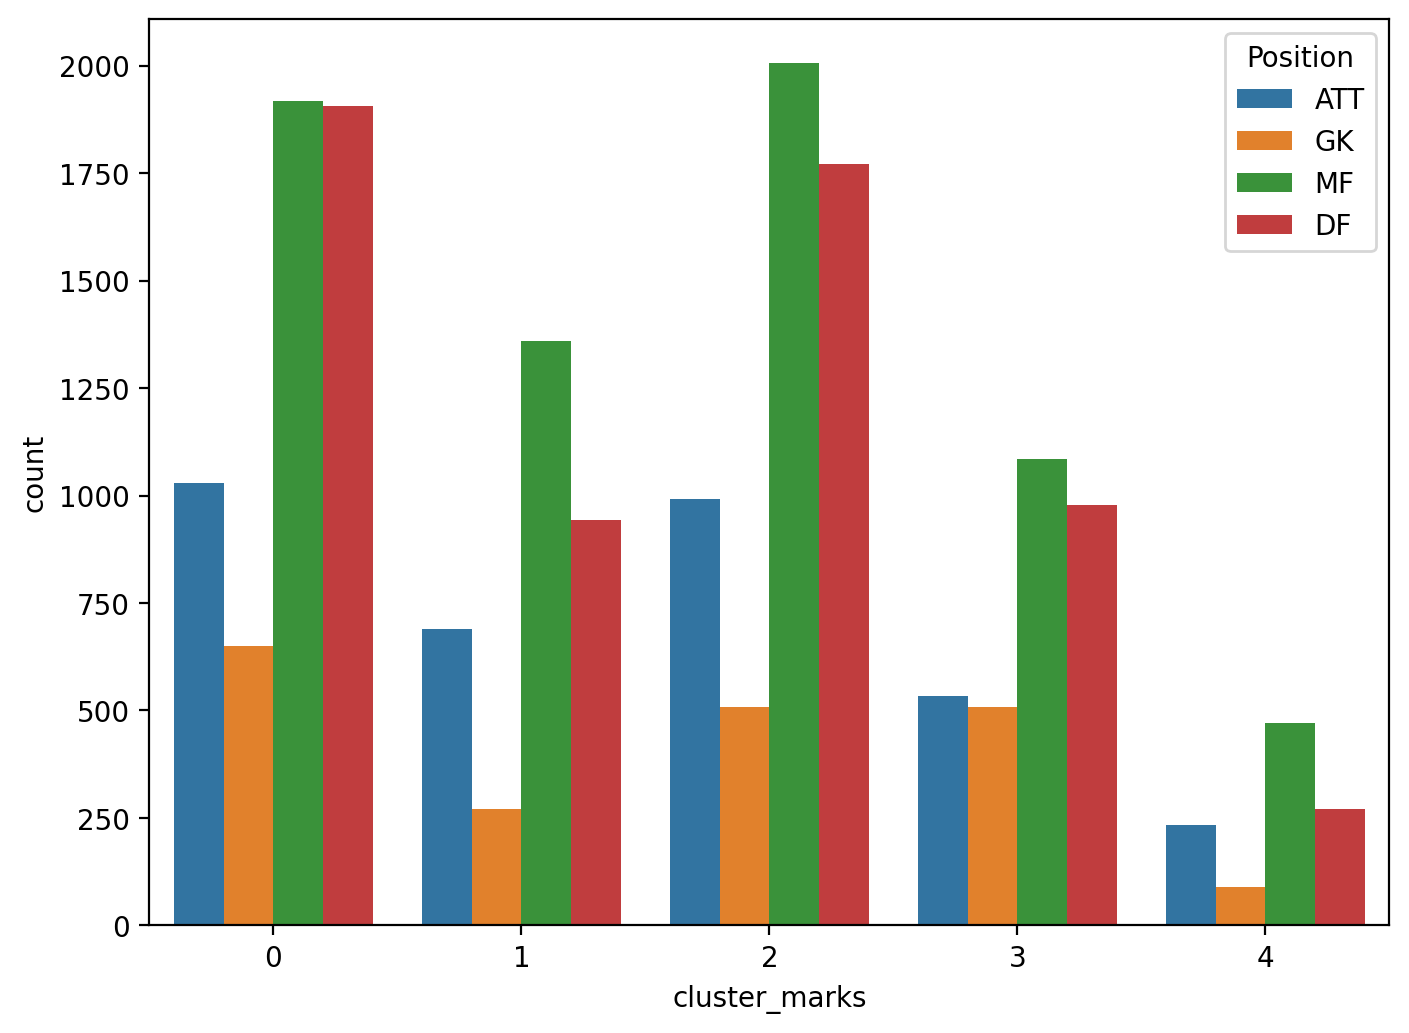

In [1183]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1184]:
keep_columns += ['International Reputation']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1185]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 7442, (40.87438897127478 %)

NAPAD: 1379 (18.529965063155064 %)
Broj igraca na poziciji RF: 5, (0.06718624025799516 %)
Broj igraca na poziciji LF: 3, (0.040311744154797095 %)
Broj igraca na poziciji RW: 125, (1.6796560064498791 %)
Broj igraca na poziciji LW: 158, (2.1230851921526472 %)
Broj igraca na poziciji ST: 902, (12.120397742542327 %)
Broj igraca na poziciji CF: 27, (0.36280569739317386 %)
Broj igraca na poziciji RS: 78, (1.0481053480247244 %)
Broj igraca na poziciji LS: 81, (1.0884170921795218 %)

VEZNI RED: 2698 (36.25369524321419 %)
Broj igraca na poziciji RDM: 109, (1.4646600376242946 %)
Broj igraca na poziciji CDM: 362, (4.864283794678849 %)
Broj igraca na poziciji LDM: 118, (1.585595270088686 %)
Broj igraca na poziciji RM: 424, (5.697393173877989 %)
Broj igraca na poziciji RCM: 151, (2.029024455791454 %)
Broj igraca na poziciji CM: 525, (7.054555227089492 %)
Broj igraca na poziciji LCM: 146, (1.9618382155334588 %)
Broj igraca na poziciji LM: 453, (

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

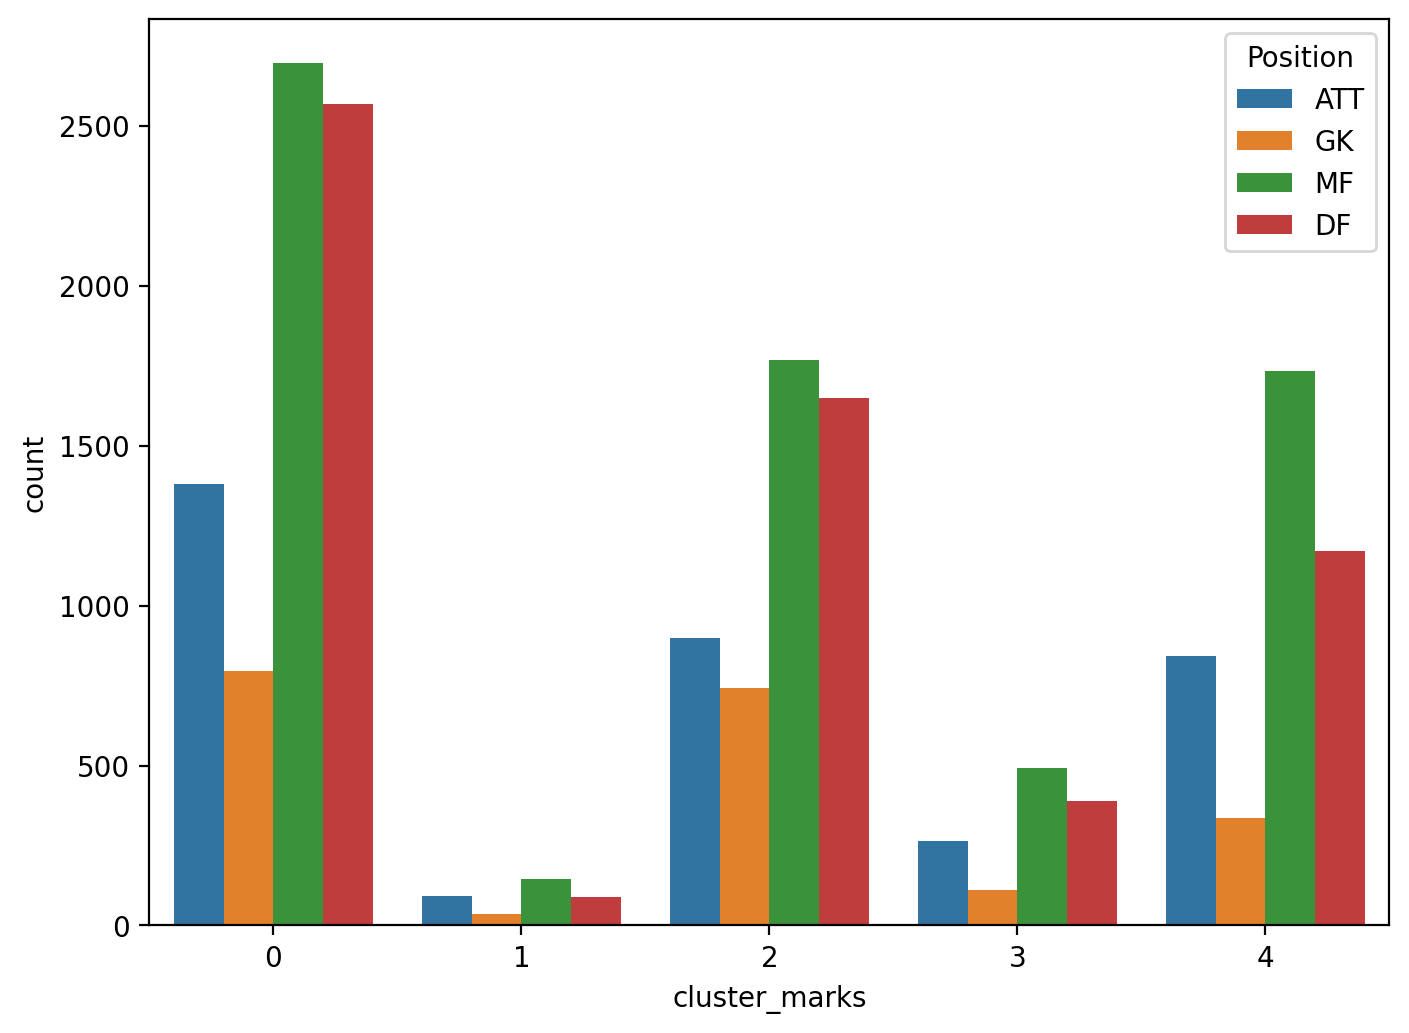

In [1186]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1187]:
keep_columns = ['Weak Foot']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1188]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 229, (1.2577580051628494 %)

NAPAD: 54 (23.580786026200872 %)
Broj igraca na poziciji RF: 1, (0.43668122270742354 %)
Broj igraca na poziciji LF: 1, (0.43668122270742354 %)
Broj igraca na poziciji RW: 10, (4.366812227074235 %)
Broj igraca na poziciji LW: 8, (3.4934497816593884 %)
Broj igraca na poziciji ST: 26, (11.353711790393014 %)
Broj igraca na poziciji CF: 2, (0.8733624454148471 %)
Broj igraca na poziciji RS: 1, (0.43668122270742354 %)
Broj igraca na poziciji LS: 5, (2.1834061135371177 %)

VEZNI RED: 122 (53.275109170305676 %)
Broj igraca na poziciji RDM: 3, (1.3100436681222707 %)
Broj igraca na poziciji CDM: 7, (3.056768558951965 %)
Broj igraca na poziciji LDM: 1, (0.43668122270742354 %)
Broj igraca na poziciji RM: 26, (11.353711790393014 %)
Broj igraca na poziciji RCM: 5, (2.1834061135371177 %)
Broj igraca na poziciji CM: 21, (9.170305676855897 %)
Broj igraca na poziciji LCM: 7, (3.056768558951965 %)
Broj igraca na poziciji LM: 25, (10.91703056768559 %)


<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

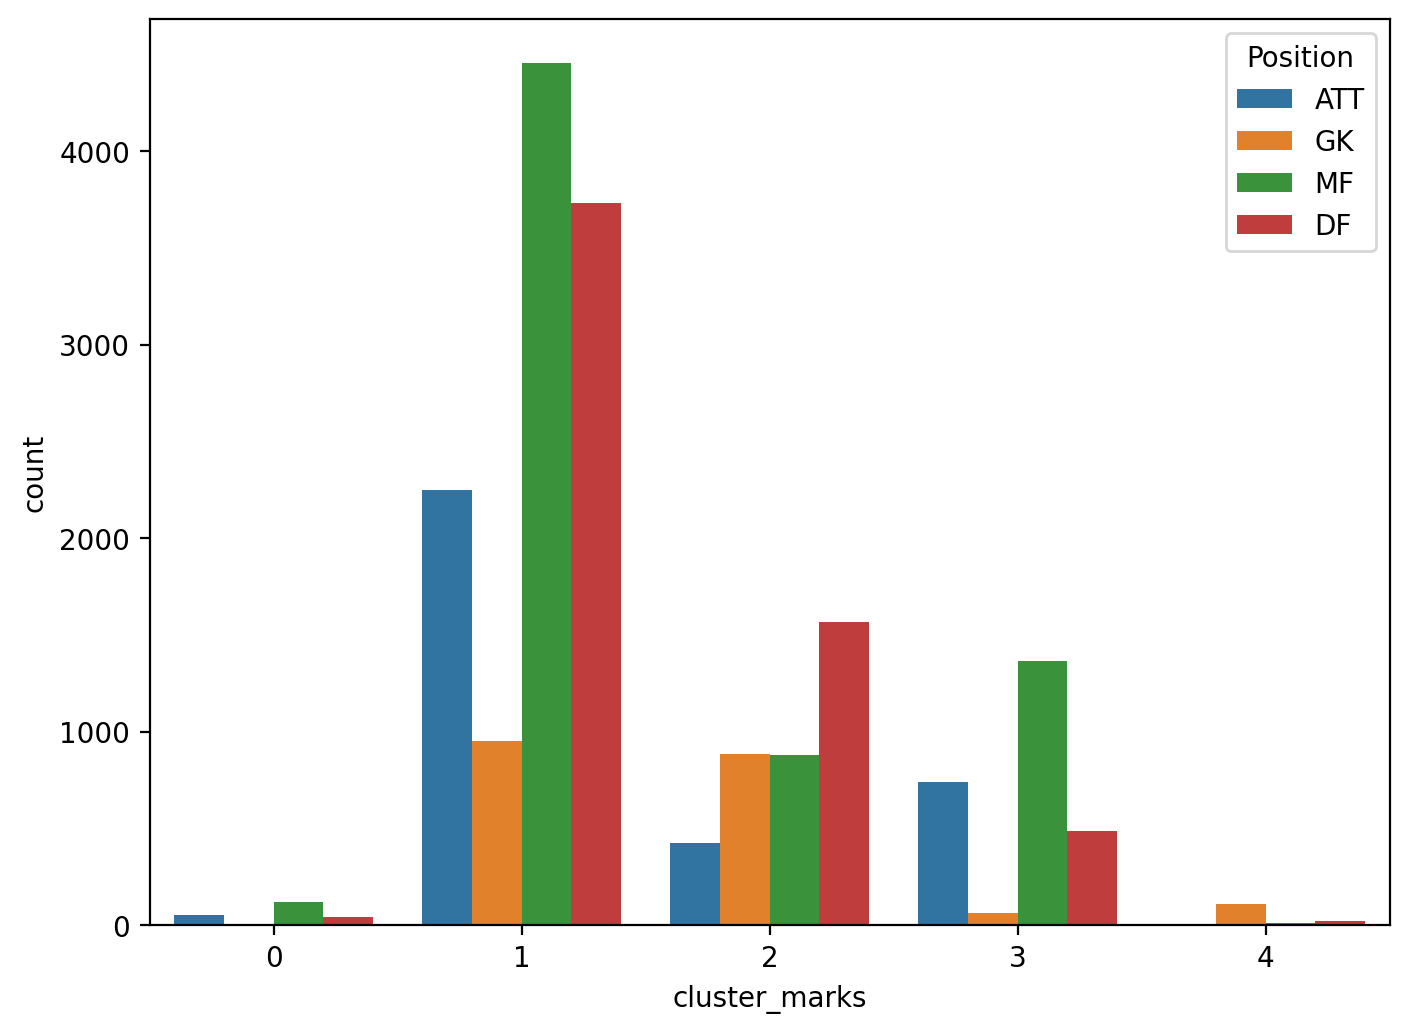

In [1189]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1190]:
keep_columns += ['Jersey Number']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1191]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 6080, (33.39374965672543 %)

NAPAD: 1074 (17.664473684210527 %)
Broj igraca na poziciji RF: 5, (0.08223684210526315 %)
Broj igraca na poziciji LF: 3, (0.049342105263157895 %)
Broj igraca na poziciji RW: 98, (1.611842105263158 %)
Broj igraca na poziciji LW: 109, (1.792763157894737 %)
Broj igraca na poziciji ST: 697, (11.463815789473685 %)
Broj igraca na poziciji CF: 21, (0.34539473684210525 %)
Broj igraca na poziciji RS: 76, (1.25 %)
Broj igraca na poziciji LS: 65, (1.069078947368421 %)

VEZNI RED: 2415 (39.72039473684211 %)
Broj igraca na poziciji RDM: 115, (1.8914473684210527 %)
Broj igraca na poziciji CDM: 375, (6.167763157894736 %)
Broj igraca na poziciji LDM: 122, (2.0065789473684212 %)
Broj igraca na poziciji RM: 364, (5.9868421052631575 %)
Broj igraca na poziciji RCM: 169, (2.7796052631578947 %)
Broj igraca na poziciji CM: 454, (7.467105263157895 %)
Broj igraca na poziciji LCM: 178, (2.9276315789473686 %)
Broj igraca na poziciji LM: 346, (5.6907894736842

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

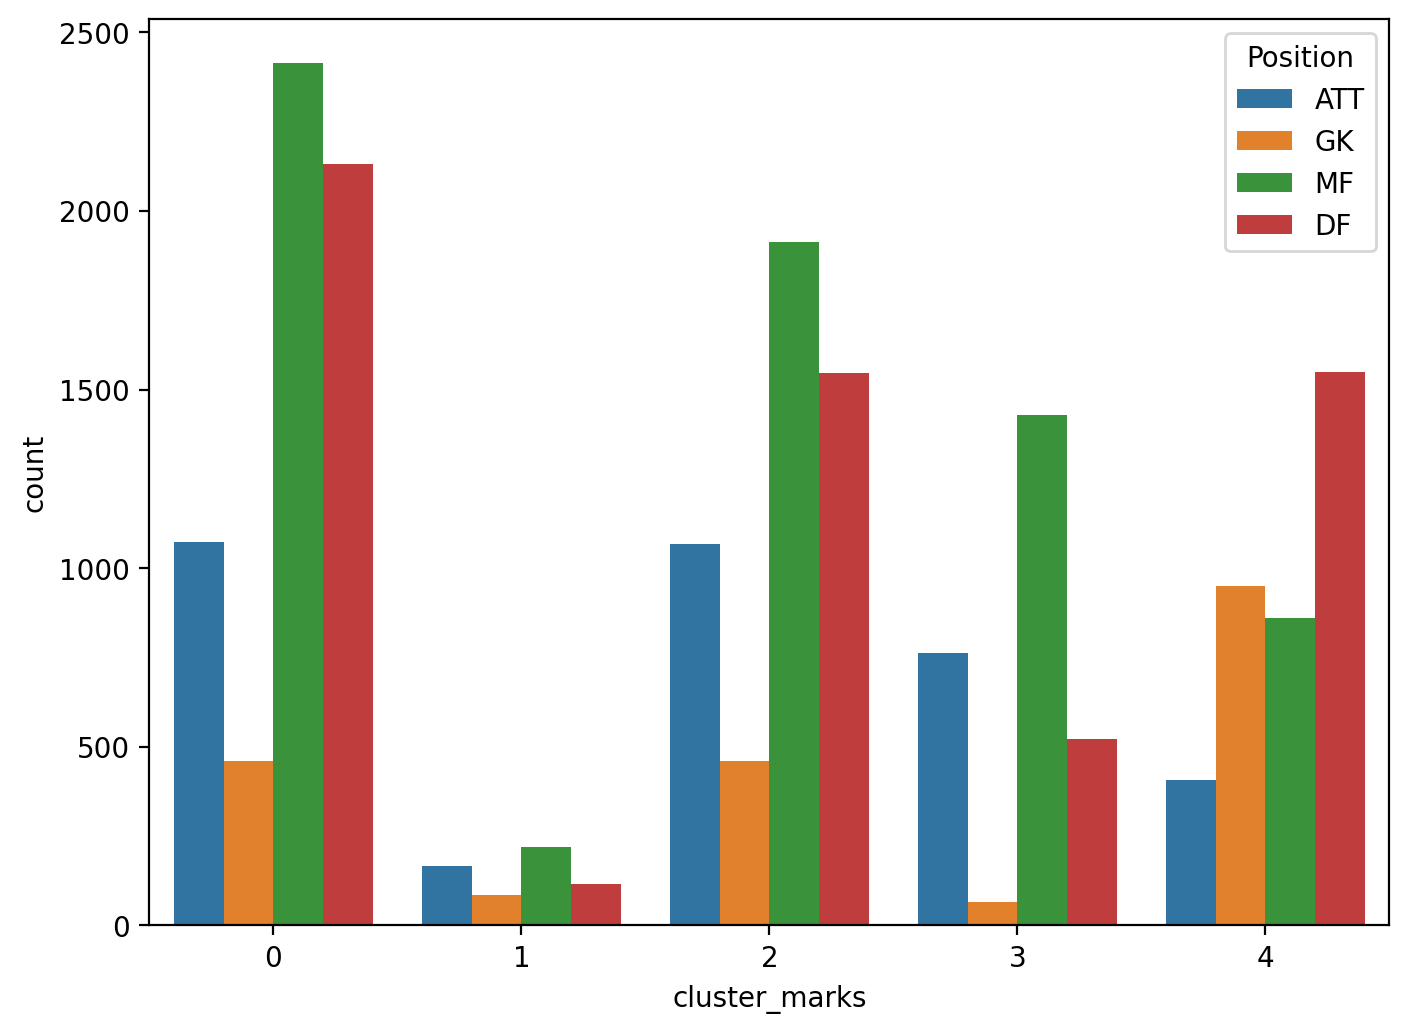

In [1192]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1193]:
keep_columns = ['Reactions']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1194]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4421, (24.281869610589336 %)

NAPAD: 841 (19.022845510065594 %)
Broj igraca na poziciji RF: 2, (0.045238633793259445 %)
Broj igraca na poziciji LF: 2, (0.045238633793259445 %)
Broj igraca na poziciji RW: 90, (2.035738520696675 %)
Broj igraca na poziciji LW: 95, (2.1488351051798236 %)
Broj igraca na poziciji ST: 569, (12.870391314182312 %)
Broj igraca na poziciji CF: 19, (0.4297670210359647 %)
Broj igraca na poziciji RS: 32, (0.7238181406921511 %)
Broj igraca na poziciji LS: 32, (0.7238181406921511 %)

VEZNI RED: 1531 (34.630174168740105 %)
Broj igraca na poziciji RDM: 27, (0.6107215562090025 %)
Broj igraca na poziciji CDM: 216, (4.88577244967202 %)
Broj igraca na poziciji LDM: 25, (0.565482922415743 %)
Broj igraca na poziciji RM: 288, (6.51436326622936 %)
Broj igraca na poziciji RCM: 41, (0.9273919927618186 %)
Broj igraca na poziciji CM: 376, (8.504863153132776 %)
Broj igraca na poziciji LCM: 60, (1.3571590137977834 %)
Broj igraca na poziciji LM: 252, (5.70006

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

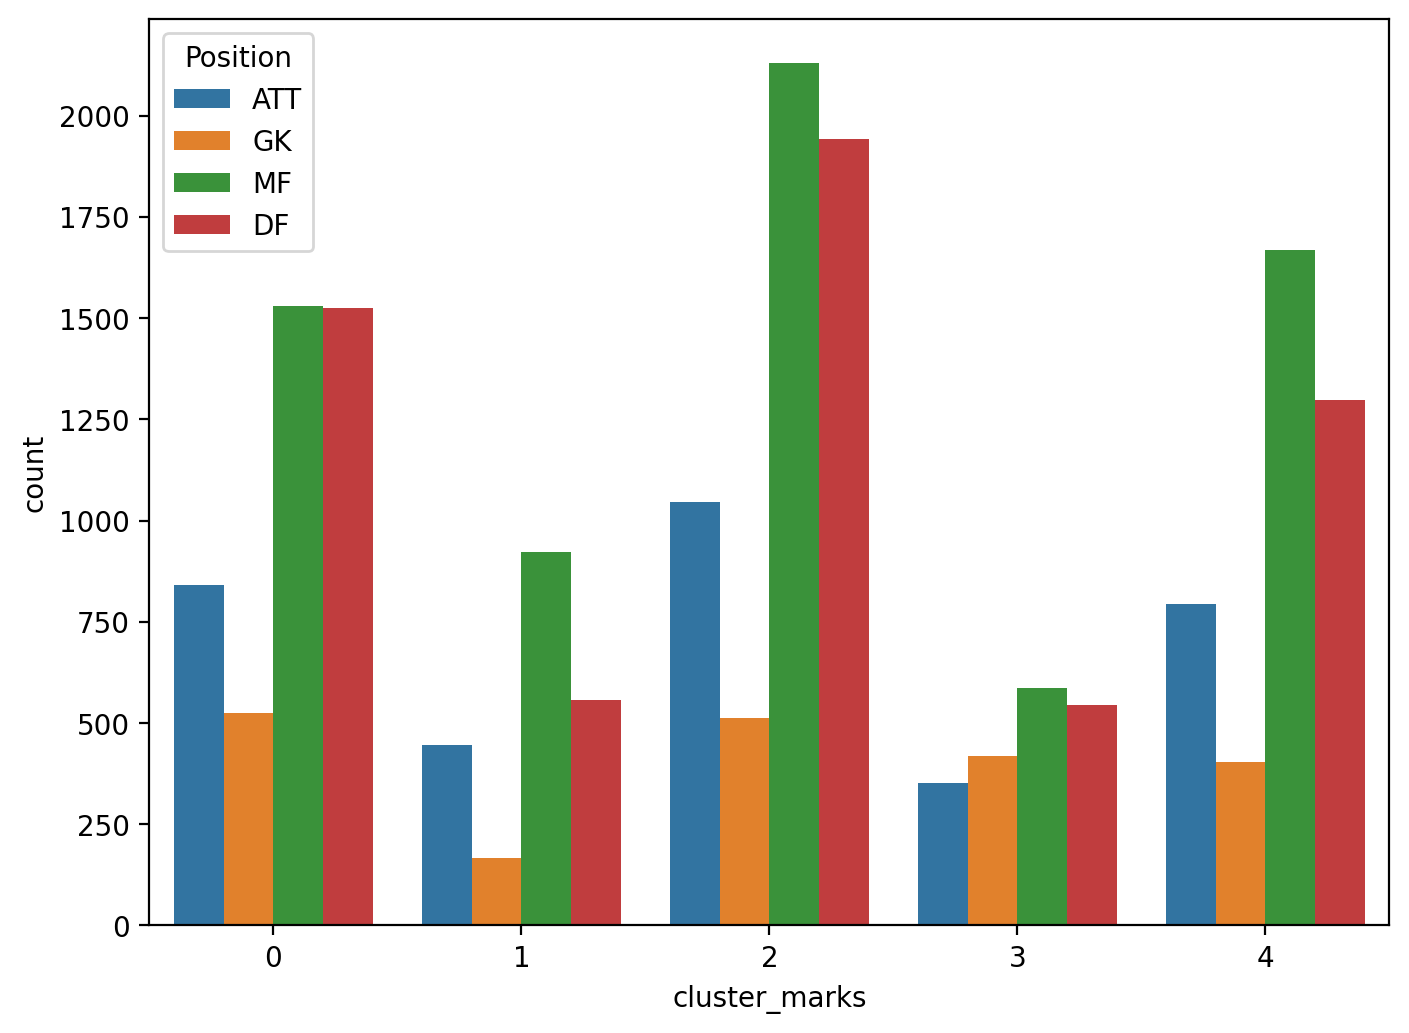

In [1195]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1196]:
keep_columns = ['Jumping']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1197]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 5364, (29.461196243203165 %)

NAPAD: 1040 (19.388516032811335 %)
Broj igraca na poziciji RF: 7, (0.13049962714392244 %)
Broj igraca na poziciji LF: 1, (0.018642803877703205 %)
Broj igraca na poziciji RW: 51, (0.9507829977628635 %)
Broj igraca na poziciji LW: 87, (1.6219239373601788 %)
Broj igraca na poziciji ST: 727, (13.553318419090232 %)
Broj igraca na poziciji CF: 21, (0.39149888143176736 %)
Broj igraca na poziciji RS: 78, (1.45413870246085 %)
Broj igraca na poziciji LS: 68, (1.267710663683818 %)

VEZNI RED: 1689 (31.487695749440714 %)
Broj igraca na poziciji RDM: 84, (1.5659955257270695 %)
Broj igraca na poziciji CDM: 302, (5.630126771066369 %)
Broj igraca na poziciji LDM: 73, (1.360924683072334 %)
Broj igraca na poziciji RM: 260, (4.847129008202834 %)
Broj igraca na poziciji RCM: 111, (2.069351230425056 %)
Broj igraca na poziciji CM: 296, (5.51826994780015 %)
Broj igraca na poziciji LCM: 113, (2.1066368381804623 %)
Broj igraca na poziciji LM: 265, (4.9403

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

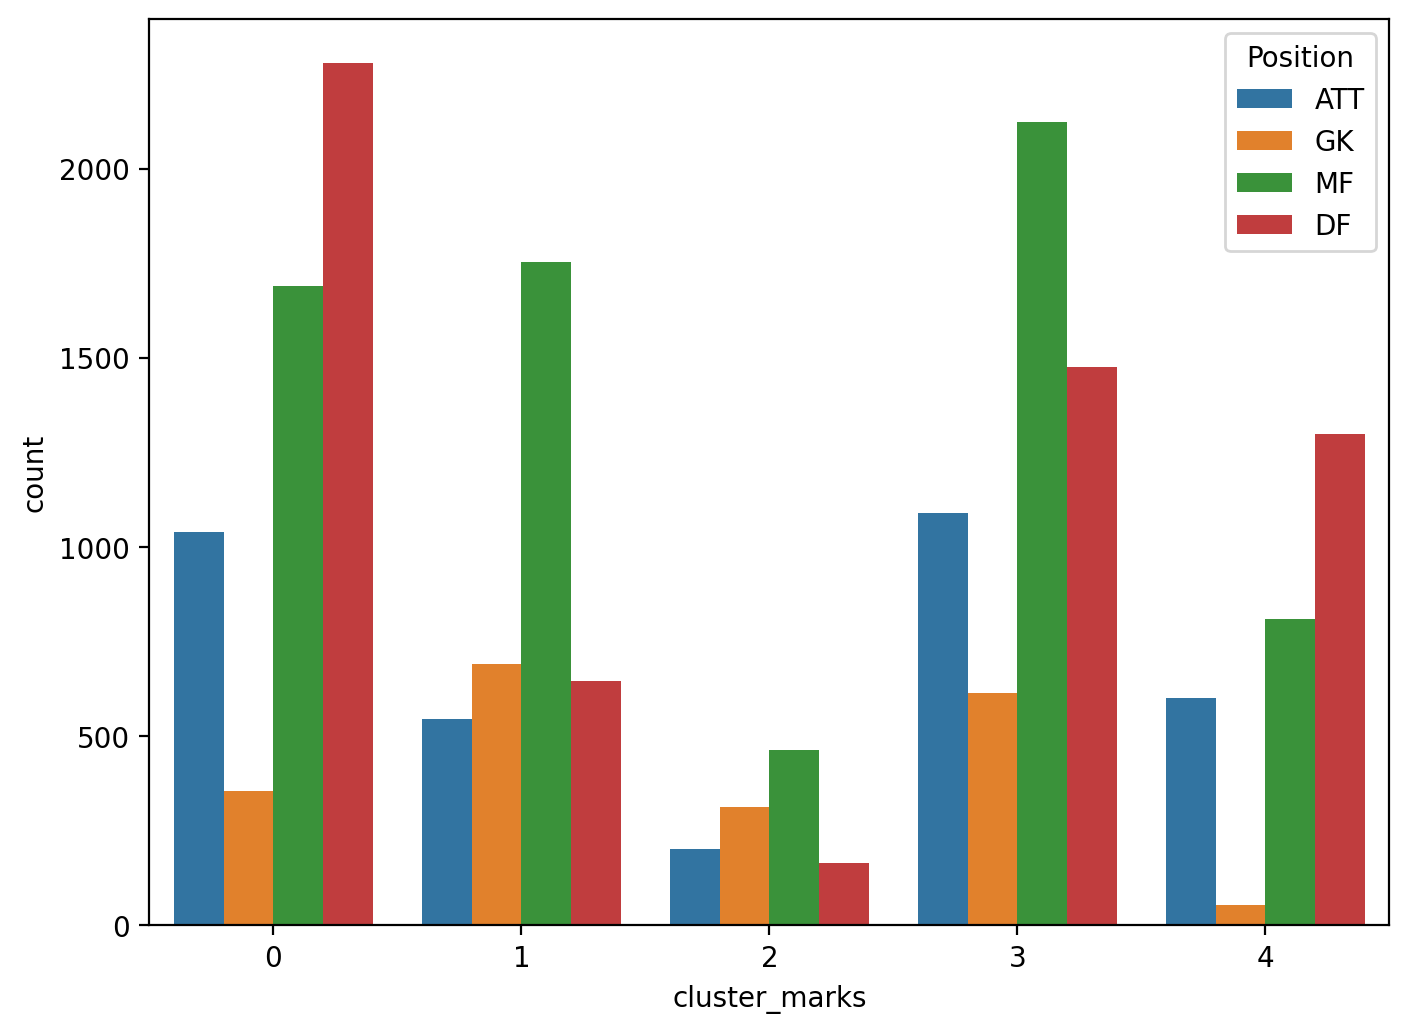

In [1198]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1200]:
keep_columns = ['Strength']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1201]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4782, (26.264623496457407 %)

NAPAD: 893 (18.674194897532416 %)
Broj igraca na poziciji RF: 2, (0.04182350480970305 %)
Broj igraca na poziciji LF: 1, (0.020911752404851526 %)
Broj igraca na poziciji RW: 46, (0.9619406106231703 %)
Broj igraca na poziciji LW: 47, (0.9828523630280217 %)
Broj igraca na poziciji ST: 668, (13.969050606440819 %)
Broj igraca na poziciji CF: 10, (0.20911752404851527 %)
Broj igraca na poziciji RS: 52, (1.0874111250522793 %)
Broj igraca na poziciji LS: 67, (1.4010874111250522 %)

VEZNI RED: 1473 (30.803011292346298 %)
Broj igraca na poziciji RDM: 104, (2.1748222501045587 %)
Broj igraca na poziciji CDM: 339, (7.089084065244668 %)
Broj igraca na poziciji LDM: 91, (1.902969468841489 %)
Broj igraca na poziciji RM: 157, (3.2831451275616894 %)
Broj igraca na poziciji RCM: 126, (2.6348808030112925 %)
Broj igraca na poziciji CM: 273, (5.708908406524467 %)
Broj igraca na poziciji LCM: 125, (2.613969050606441 %)
Broj igraca na poziciji LM: 138, (2

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

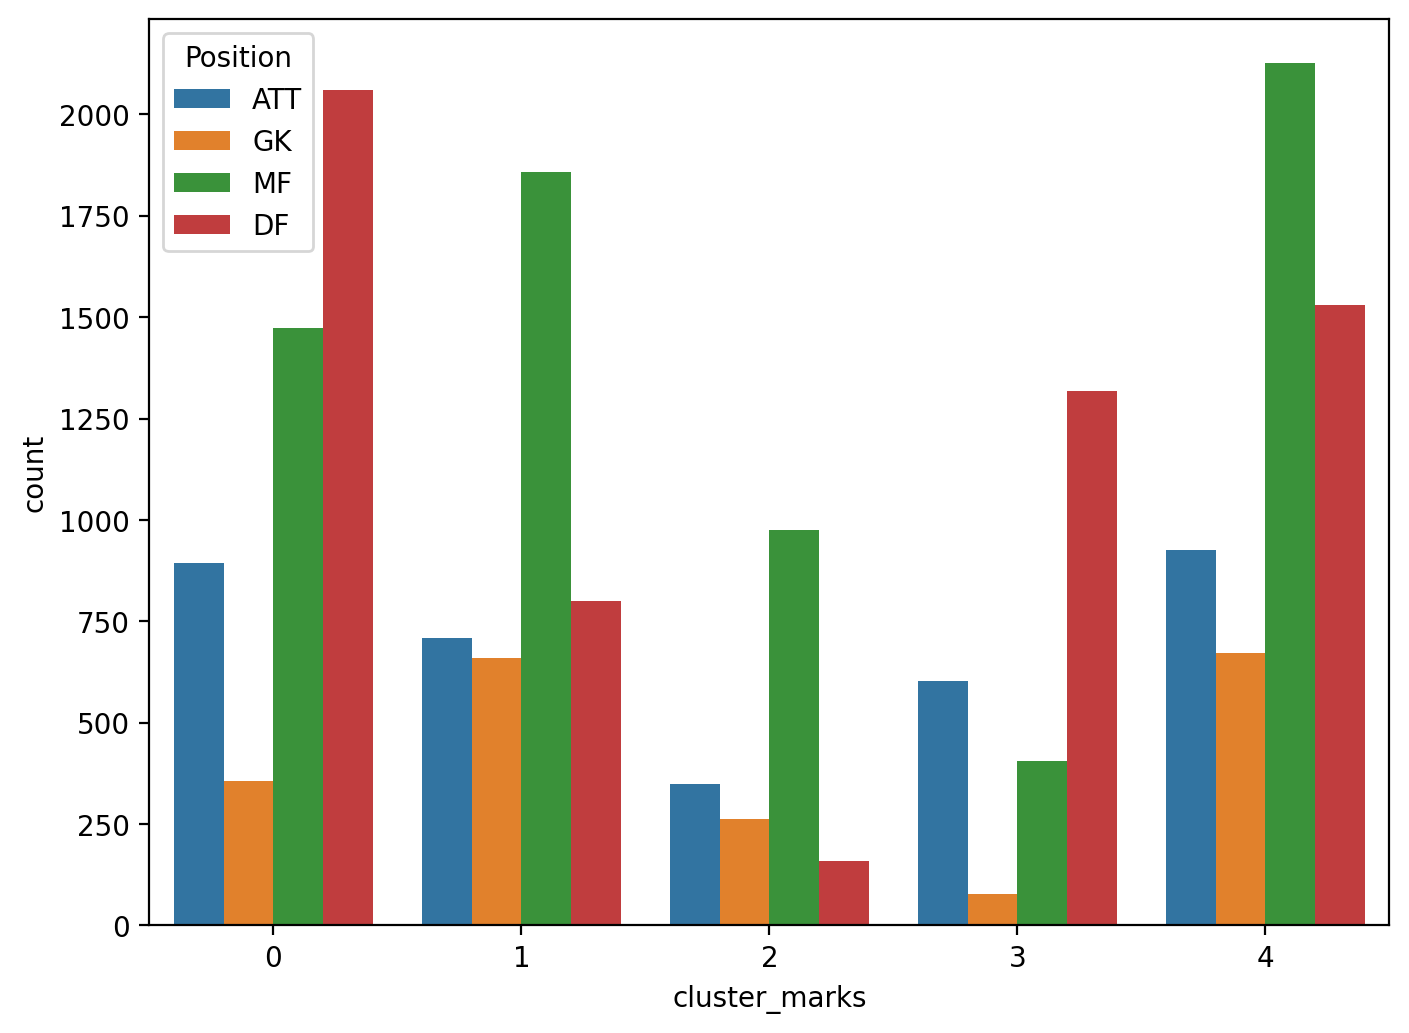

In [1202]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

## Da li ce se akumuliranjem neutralnih promenljivih poboljsati rezultat? 

In [1203]:
keep_columns = ['ID']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1204]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 7934, (43.57664634481244 %)

NAPAD: 1631 (20.557096042349382 %)
Broj igraca na poziciji RF: 2, (0.025207965717166627 %)
Broj igraca na poziciji LF: 3, (0.03781194857574994 %)
Broj igraca na poziciji RW: 196, (2.4703806402823294 %)
Broj igraca na poziciji LW: 211, (2.659440383161079 %)
Broj igraca na poziciji ST: 1076, (13.561885555835643 %)
Broj igraca na poziciji CF: 43, (0.5419712629190825 %)
Broj igraca na poziciji RS: 49, (0.6175951600705823 %)
Broj igraca na poziciji LS: 51, (0.6428031257877489 %)

VEZNI RED: 3038 (38.290899924376106 %)
Broj igraca na poziciji RDM: 66, (0.8318628686664987 %)
Broj igraca na poziciji CDM: 430, (5.419712629190824 %)
Broj igraca na poziciji LDM: 81, (1.0209226115452483 %)
Broj igraca na poziciji RM: 503, (6.3398033778674066 %)
Broj igraca na poziciji RCM: 117, (1.4746659944542475 %)
Broj igraca na poziciji CM: 761, (9.5916309553819 %)
Broj igraca na poziciji LCM: 103, (1.2982102344340811 %)
Broj igraca na poziciji LM: 479, (6

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

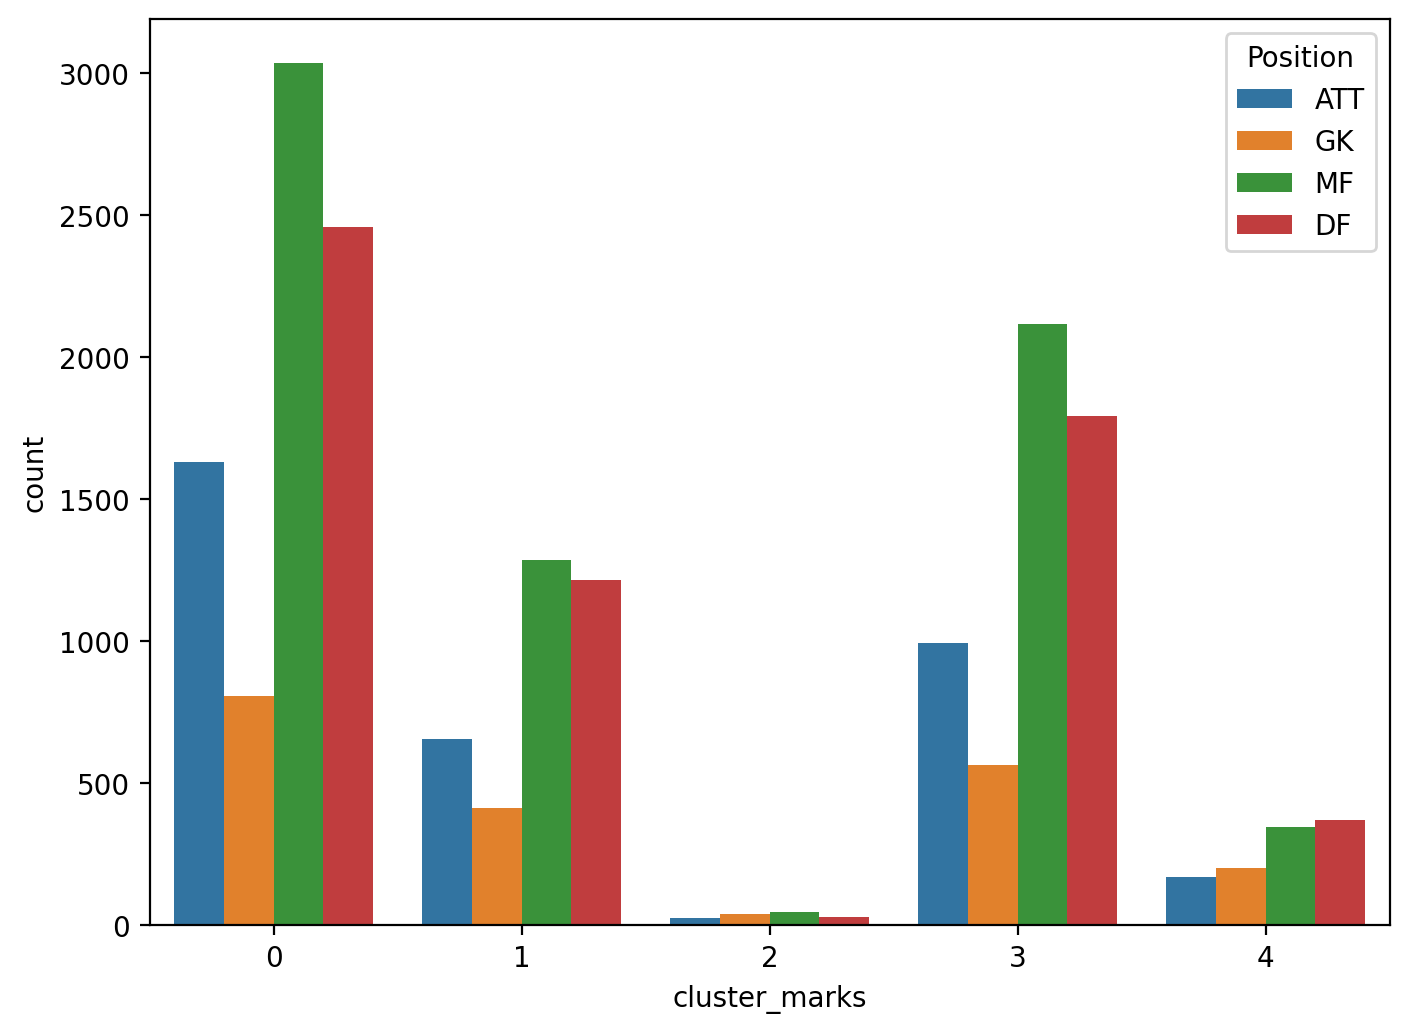

In [1205]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1206]:
keep_columns += ['Age']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1207]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 5679, (31.191300049431536 %)

NAPAD: 1072 (18.876562775136467 %)
Broj igraca na poziciji RF: 5, (0.08804366966015144 %)
Broj igraca na poziciji LF: 3, (0.05282620179609086 %)
Broj igraca na poziciji RW: 120, (2.1130480718436346 %)
Broj igraca na poziciji LW: 141, (2.4828314844162707 %)
Broj igraca na poziciji ST: 643, (11.322415918295475 %)
Broj igraca na poziciji CF: 21, (0.369783412572636 %)
Broj igraca na poziciji RS: 68, (1.1973939073780595 %)
Broj igraca na poziciji LS: 71, (1.2502201091741505 %)

VEZNI RED: 2200 (38.73921465046663 %)
Broj igraca na poziciji RDM: 90, (1.5847860538827259 %)
Broj igraca na poziciji CDM: 274, (4.824793097376299 %)
Broj igraca na poziciji LDM: 69, (1.2150026413100898 %)
Broj igraca na poziciji RM: 418, (7.36045078358866 %)
Broj igraca na poziciji RCM: 135, (2.3771790808240887 %)
Broj igraca na poziciji CM: 388, (6.832188765627752 %)
Broj igraca na poziciji LCM: 133, (2.3419616129600285 %)
Broj igraca na poziciji LM: 397, (6.9

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

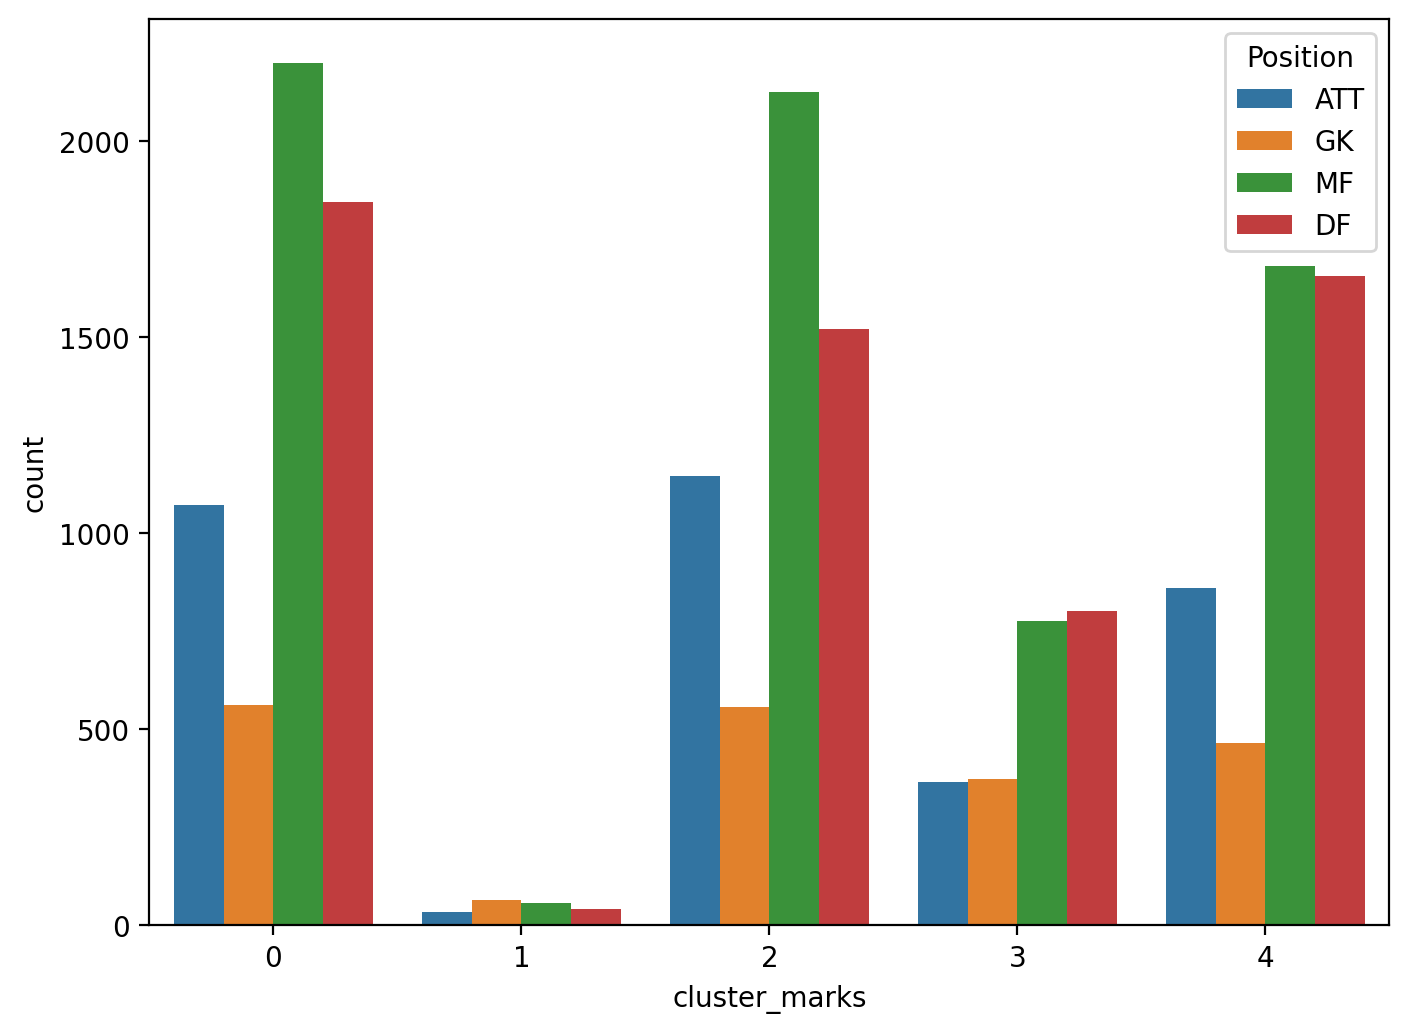

In [1208]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

# Inferiorne kolone

In [1154]:
keep_columns = ['Special']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1155]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 5425, (29.79623221837755 %)

NAPAD: 1116 (20.57142857142857 %)
Broj igraca na poziciji RF: 9, (0.16589861751152074 %)
Broj igraca na poziciji LF: 7, (0.12903225806451613 %)
Broj igraca na poziciji RW: 139, (2.5622119815668203 %)
Broj igraca na poziciji LW: 136, (2.506912442396313 %)
Broj igraca na poziciji ST: 636, (11.723502304147464 %)
Broj igraca na poziciji CF: 23, (0.423963133640553 %)
Broj igraca na poziciji RS: 88, (1.6221198156682028 %)
Broj igraca na poziciji LS: 78, (1.4377880184331797 %)

VEZNI RED: 2718 (50.10138248847926 %)
Broj igraca na poziciji RDM: 113, (2.0829493087557607 %)
Broj igraca na poziciji CDM: 390, (7.1889400921658995 %)
Broj igraca na poziciji LDM: 108, (1.9907834101382489 %)
Broj igraca na poziciji RM: 437, (8.055299539170507 %)
Broj igraca na poziciji RCM: 162, (2.9861751152073737 %)
Broj igraca na poziciji CM: 503, (9.27188940092166 %)
Broj igraca na poziciji LCM: 159, (2.930875576036866 %)
Broj igraca na poziciji LM: 437, (8.05

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

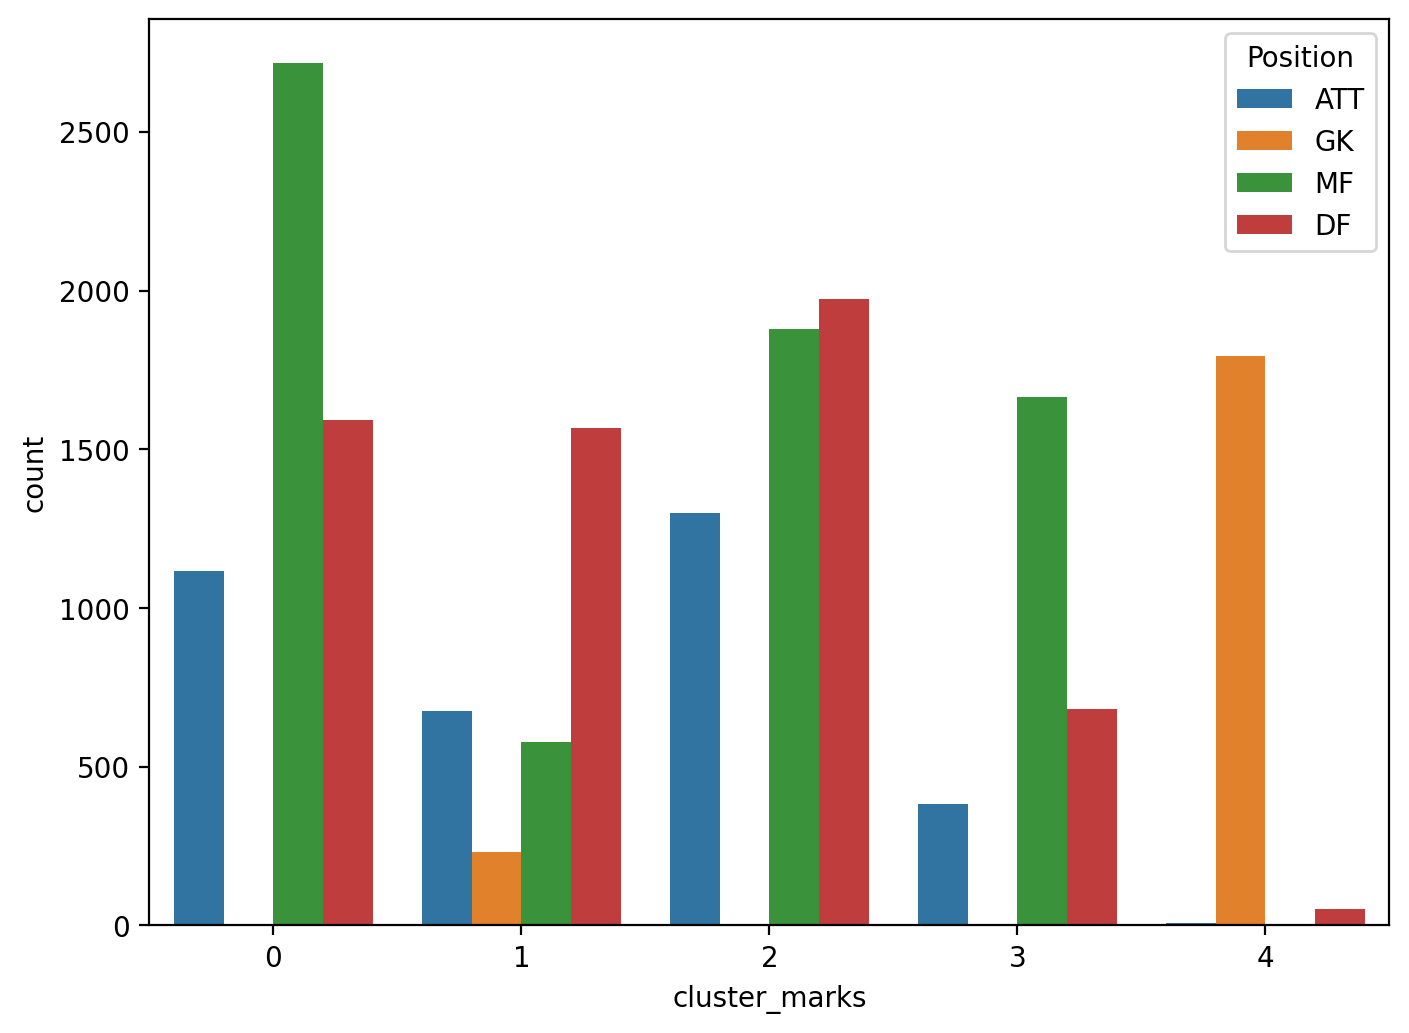

In [1156]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1157]:
keep_columns = ['Skill Moves']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1158]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 6600, (36.24979403526116 %)

NAPAD: 1751 (26.53030303030303 %)
Broj igraca na poziciji RF: 11, (0.16666666666666669 %)
Broj igraca na poziciji LF: 9, (0.13636363636363638 %)
Broj igraca na poziciji RW: 223, (3.378787878787879 %)
Broj igraca na poziciji LW: 232, (3.5151515151515147 %)
Broj igraca na poziciji ST: 997, (15.106060606060606 %)
Broj igraca na poziciji CF: 41, (0.6212121212121212 %)
Broj igraca na poziciji RS: 119, (1.8030303030303032 %)
Broj igraca na poziciji LS: 119, (1.8030303030303032 %)

VEZNI RED: 3703 (56.1060606060606 %)
Broj igraca na poziciji RDM: 121, (1.8333333333333333 %)
Broj igraca na poziciji CDM: 303, (4.590909090909091 %)
Broj igraca na poziciji LDM: 117, (1.7727272727272727 %)
Broj igraca na poziciji RM: 706, (10.696969696969697 %)
Broj igraca na poziciji RCM: 238, (3.6060606060606064 %)
Broj igraca na poziciji CM: 660, (10.0 %)
Broj igraca na poziciji LCM: 240, (3.6363636363636362 %)
Broj igraca na poziciji LM: 674, (10.212121212

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

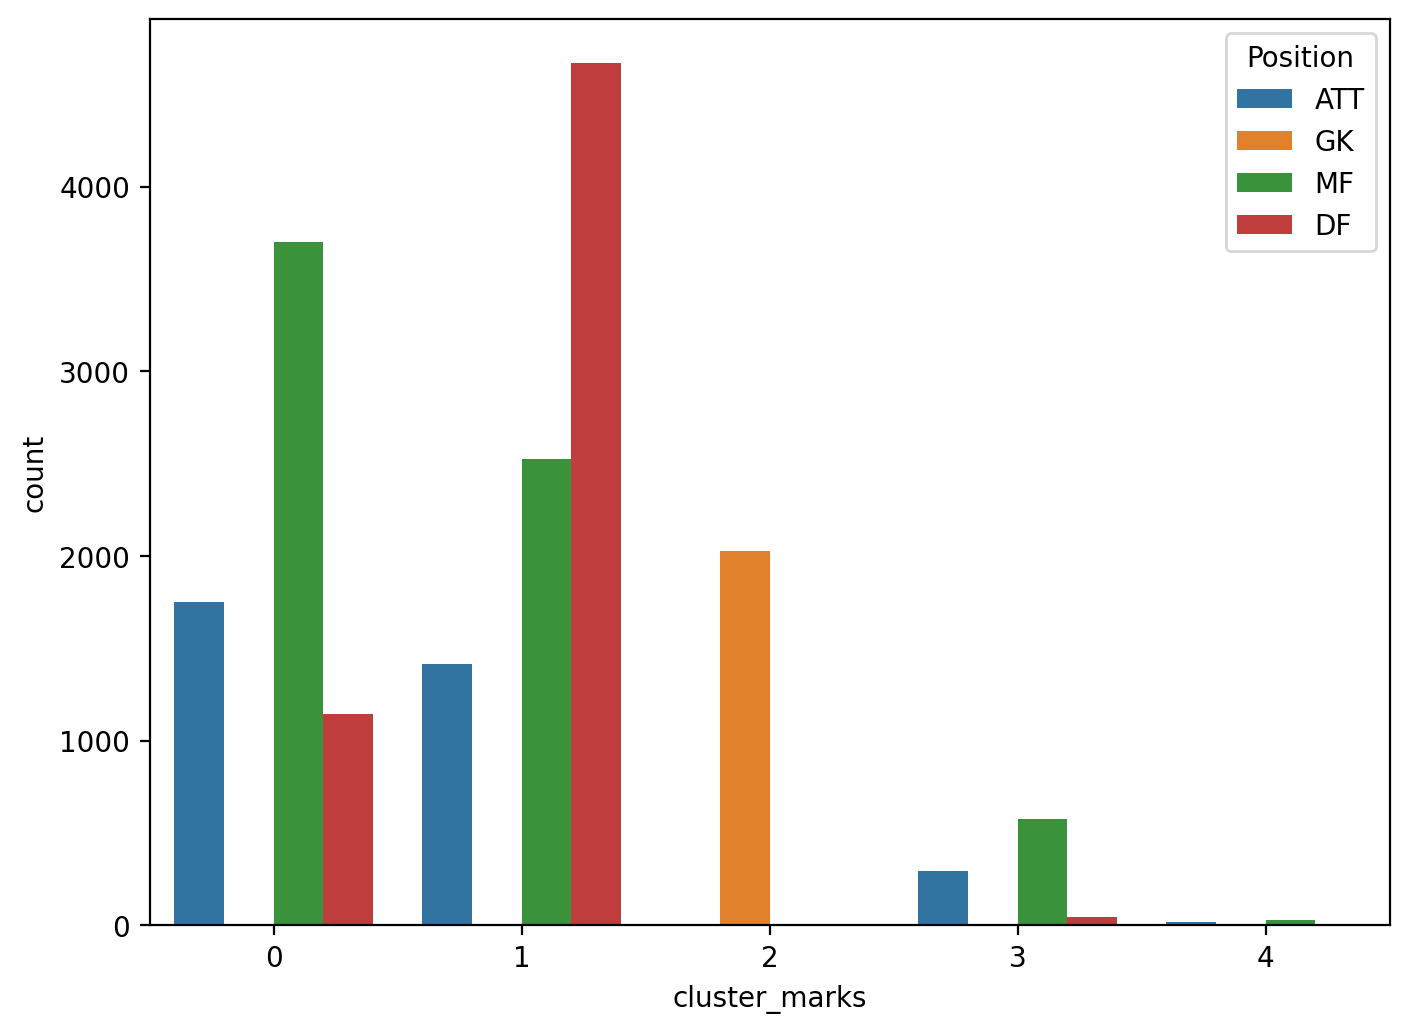

In [1159]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1160]:
keep_columns = ['Crossing']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1161]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 5648, (31.021035865326525 %)

NAPAD: 1073 (18.99787535410765 %)
Broj igraca na poziciji RF: 8, (0.141643059490085 %)
Broj igraca na poziciji LF: 7, (0.12393767705382436 %)
Broj igraca na poziciji RW: 180, (3.186968838526912 %)
Broj igraca na poziciji LW: 211, (3.7358356940509916 %)
Broj igraca na poziciji ST: 503, (8.905807365439093 %)
Broj igraca na poziciji CF: 27, (0.47804532577903686 %)
Broj igraca na poziciji RS: 67, (1.1862606232294617 %)
Broj igraca na poziciji LS: 70, (1.2393767705382437 %)

VEZNI RED: 2877 (50.93838526912181 %)
Broj igraca na poziciji RDM: 107, (1.894475920679887 %)
Broj igraca na poziciji CDM: 299, (5.293909348441926 %)
Broj igraca na poziciji LDM: 96, (1.69971671388102 %)
Broj igraca na poziciji RM: 551, (9.755665722379604 %)
Broj igraca na poziciji RCM: 192, (3.39943342776204 %)
Broj igraca na poziciji CM: 489, (8.657932011331445 %)
Broj igraca na poziciji LCM: 170, (3.009915014164306 %)
Broj igraca na poziciji LM: 556, (9.84419263

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

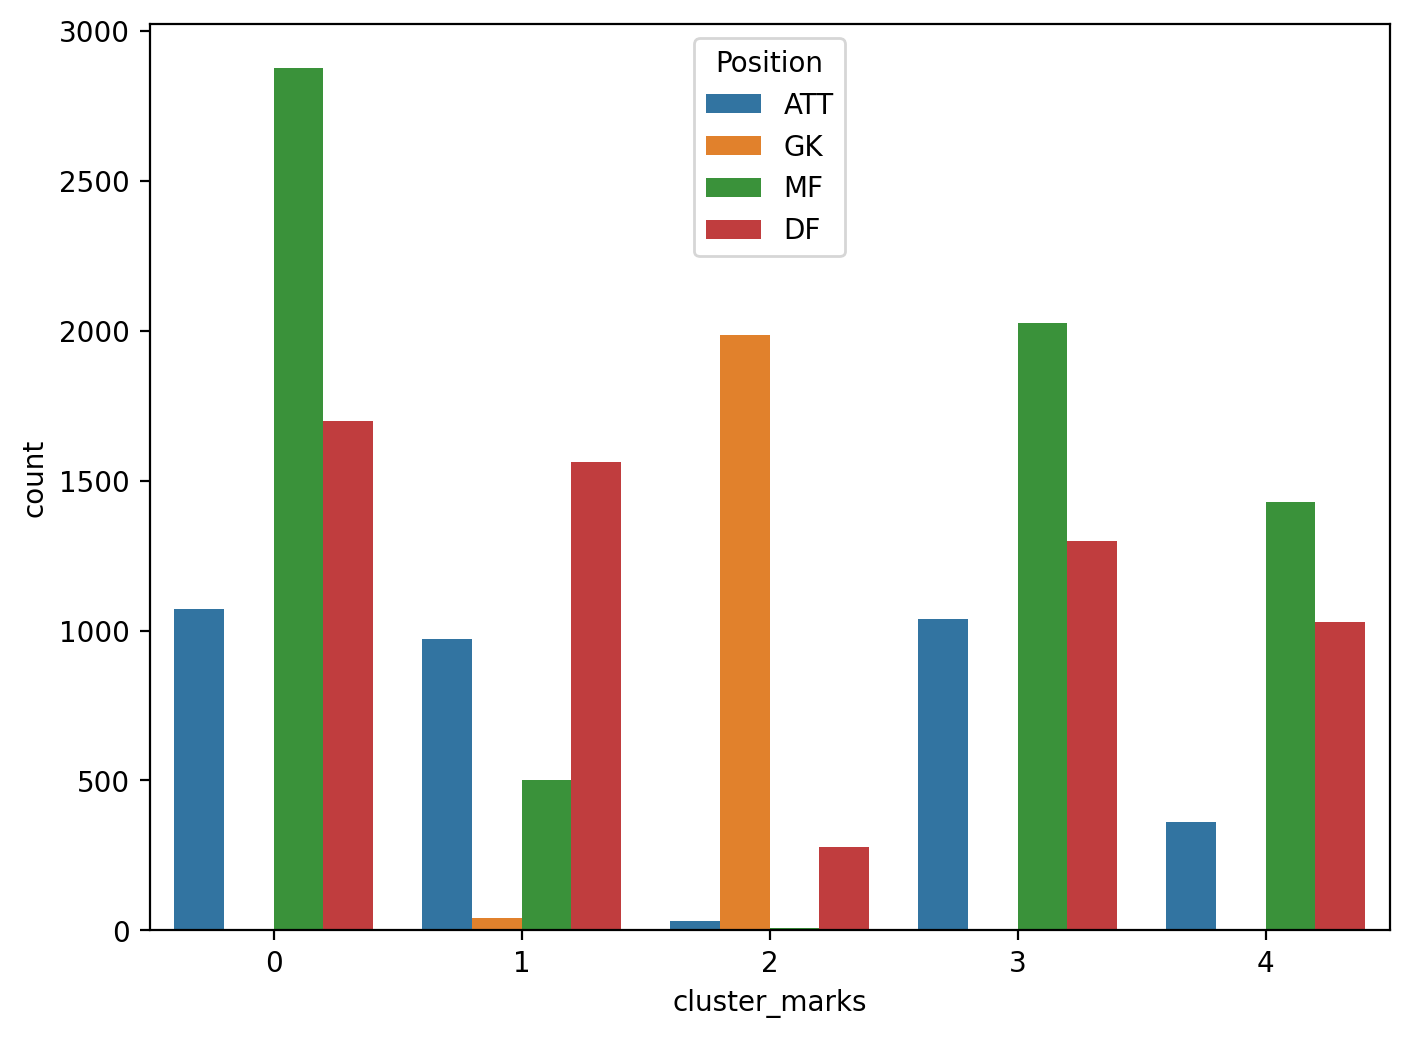

In [1162]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1163]:
keep_columns = ['Finishing']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1164]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3632, (19.94837150546493 %)

NAPAD: 7 (0.19273127753303965 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 3, (0.08259911894273128 %)
Broj igraca na poziciji ST: 4, (0.11013215859030838 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 631 (17.373348017621147 %)
Broj igraca na poziciji RDM: 27, (0.7433920704845814 %)
Broj igraca na poziciji CDM: 244, (6.71806167400881 %)
Broj igraca na poziciji LDM: 40, (1.1013215859030838 %)
Broj igraca na poziciji RM: 32, (0.881057268722467 %)
Broj igraca na poziciji RCM: 24, (0.6607929515418502 %)
Broj igraca na poziciji CM: 203, (5.5892070484581495 %)
Broj igraca na poziciji LCM: 21, (0.5781938325991189 %)
Broj igraca na poziciji LM: 23, (0.6332599118942731 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 17, (0.468061674

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

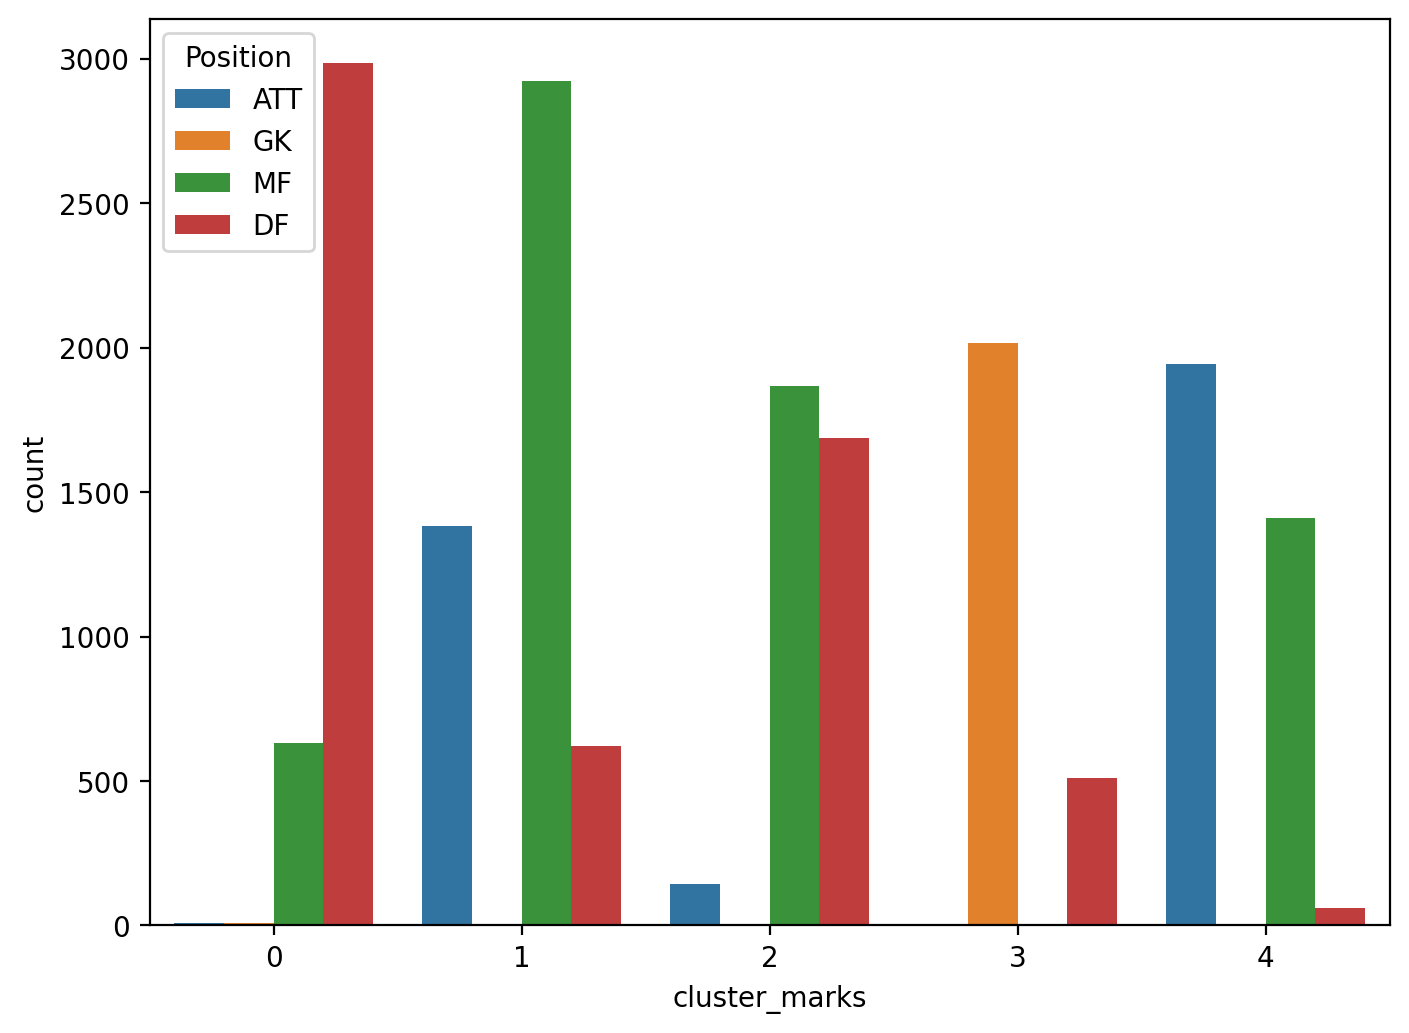

In [1165]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1166]:
keep_columns = ['HeadingAccuracy']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1167]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4646, (25.517658043609604 %)

NAPAD: 840 (18.080068876452863 %)
Broj igraca na poziciji RF: 3, (0.06457167455876023 %)
Broj igraca na poziciji LF: 2, (0.04304778303917348 %)
Broj igraca na poziciji RW: 118, (2.539819199311235 %)
Broj igraca na poziciji LW: 130, (2.798105897546276 %)
Broj igraca na poziciji ST: 487, (10.482135170038744 %)
Broj igraca na poziciji CF: 31, (0.667240637107189 %)
Broj igraca na poziciji RS: 34, (0.7318123116659492 %)
Broj igraca na poziciji LS: 35, (0.753336203185536 %)

VEZNI RED: 2439 (52.49677141627206 %)
Broj igraca na poziciji RDM: 61, (1.3129573826947911 %)
Broj igraca na poziciji CDM: 333, (7.167455876022384 %)
Broj igraca na poziciji LDM: 88, (1.8941024537236333 %)
Broj igraca na poziciji RM: 397, (8.544984933275936 %)
Broj igraca na poziciji RCM: 145, (3.1209642703400773 %)
Broj igraca na poziciji CM: 585, (12.591476538958243 %)
Broj igraca na poziciji LCM: 136, (2.9272492466637967 %)
Broj igraca na poziciji LM: 355, (7.640

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

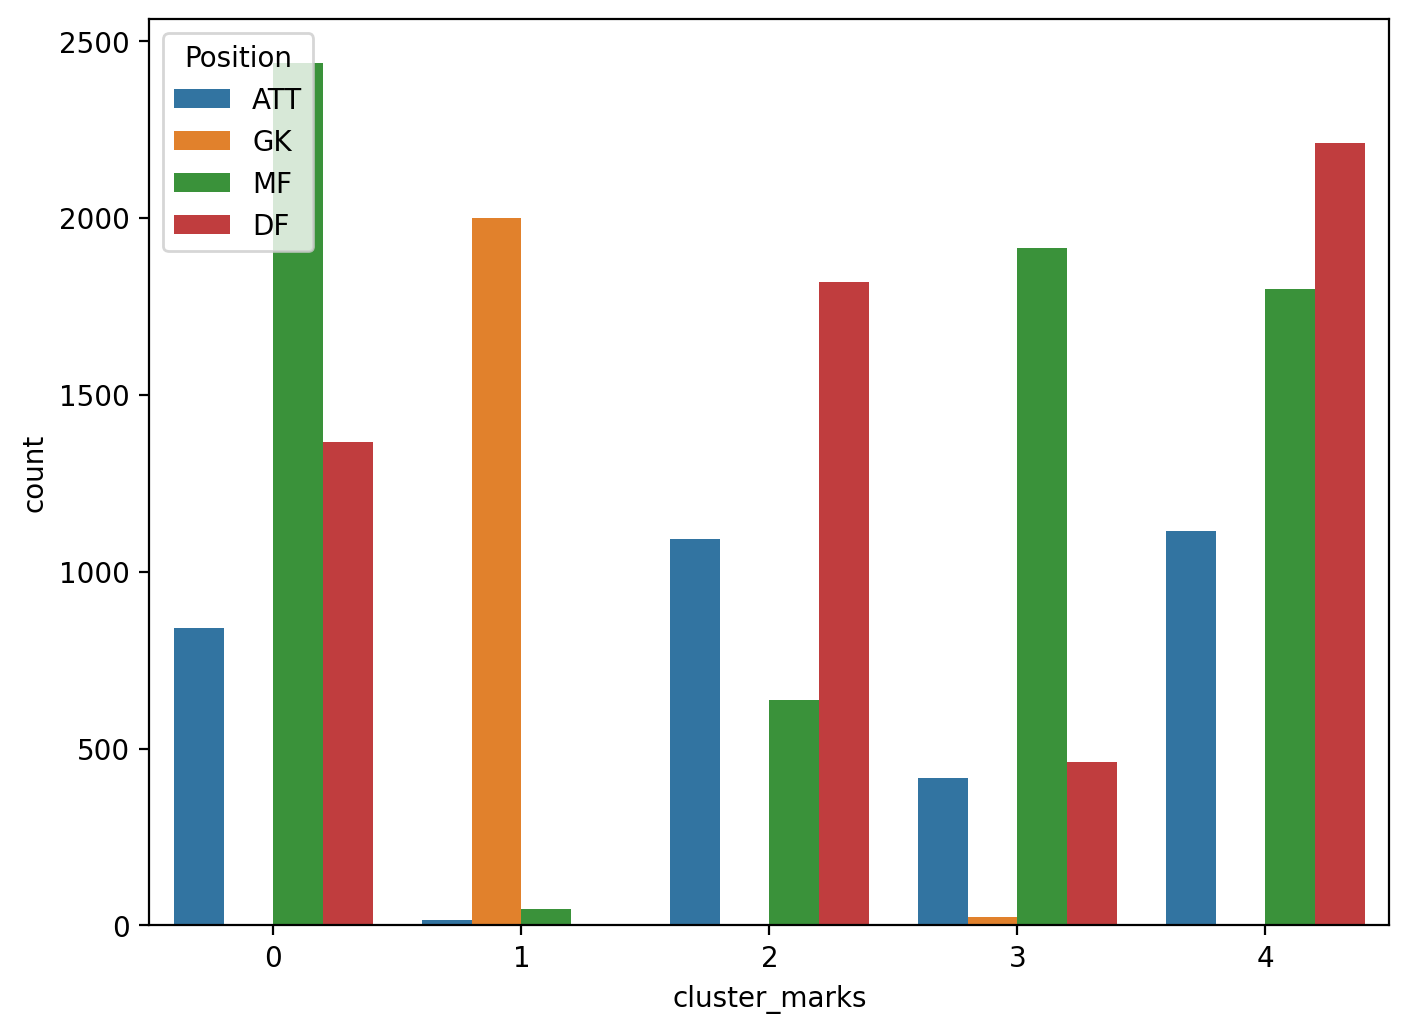

In [1168]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1169]:
keep_columns = ['ShortPassing']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1170]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 1967, (10.803537101114955 %)

NAPAD: 16 (0.813421453990849 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 15, (0.762582613116421 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 1, (0.05083884087442806 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 2 (0.10167768174885612 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 2, (0.10167768174885612 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 189 (9.608540925266903 %)
Broj igraca na poziciji RWB: 1, (0.0508388

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

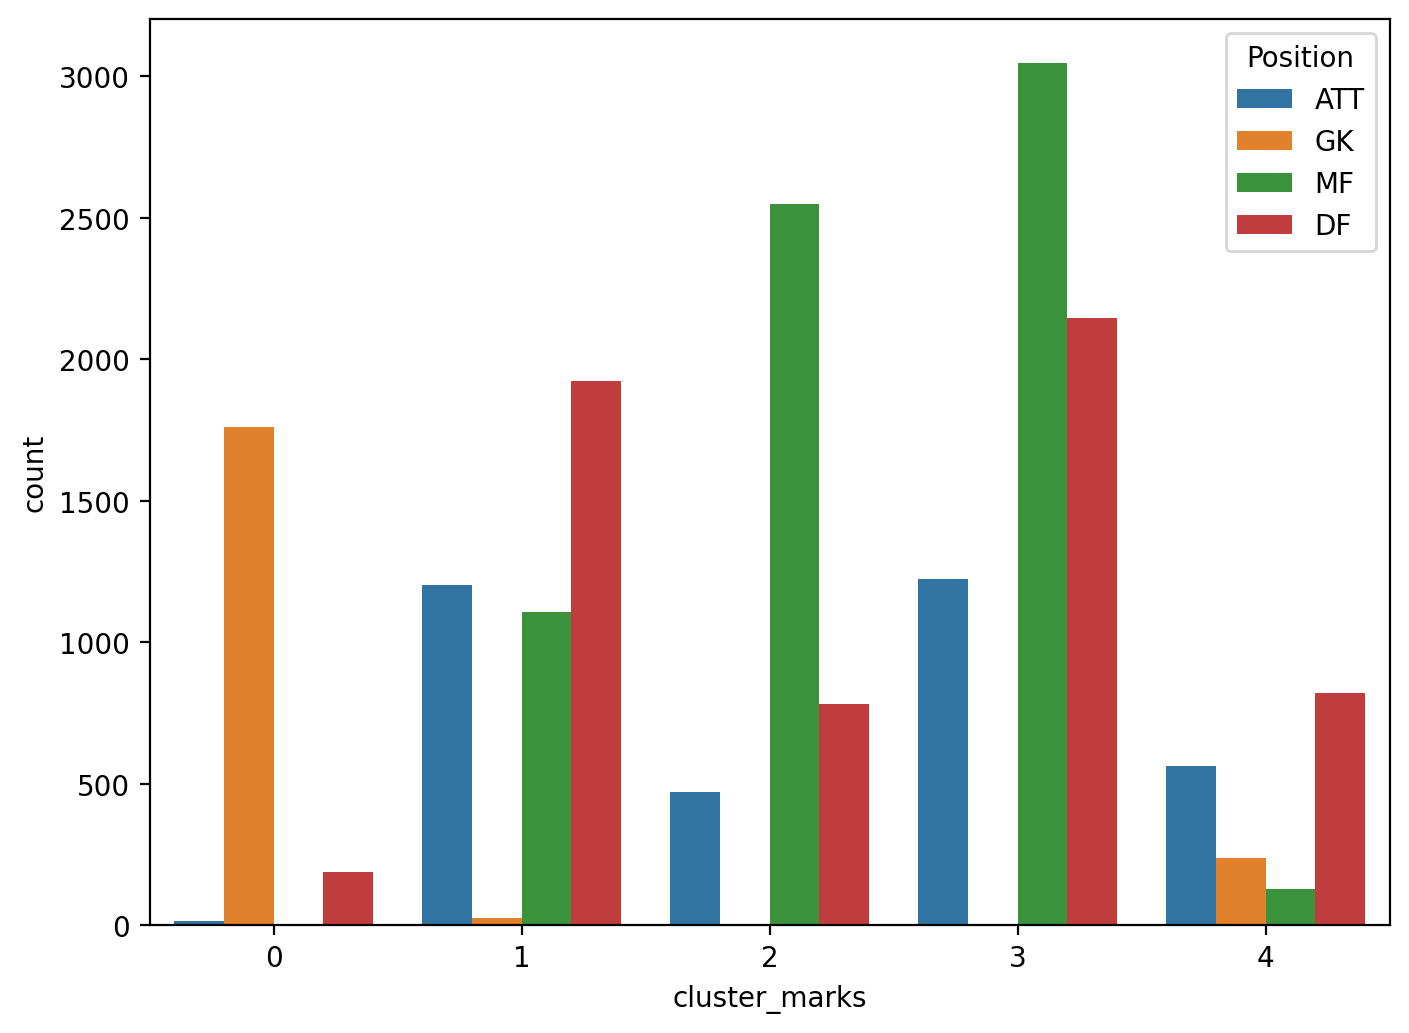

In [1171]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1172]:
keep_columns = ['Volleys']
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[keep_columns])

KMeans(n_clusters=5, random_state=0)

In [1173]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 2932, (16.10369638051299 %)

NAPAD: 1323 (45.122783083219645 %)
Broj igraca na poziciji RF: 9, (0.30695770804911326 %)
Broj igraca na poziciji LF: 8, (0.2728512960436562 %)
Broj igraca na poziciji RW: 103, (3.5129604365620737 %)
Broj igraca na poziciji LW: 109, (3.717598908594816 %)
Broj igraca na poziciji ST: 840, (28.6493860845839 %)
Broj igraca na poziciji CF: 27, (0.9208731241473397 %)
Broj igraca na poziciji RS: 112, (3.819918144611187 %)
Broj igraca na poziciji LS: 115, (3.922237380627558 %)

VEZNI RED: 1443 (49.21555252387449 %)
Broj igraca na poziciji RDM: 52, (1.7735334242837655 %)
Broj igraca na poziciji CDM: 68, (2.3192360163710775 %)
Broj igraca na poziciji LDM: 39, (1.330150068212824 %)
Broj igraca na poziciji RM: 260, (8.867667121418826 %)
Broj igraca na poziciji RCM: 102, (3.4788540245566164 %)
Broj igraca na poziciji CM: 199, (6.787175989085949 %)
Broj igraca na poziciji LCM: 101, (3.44474761255116 %)
Broj igraca na poziciji LM: 264, (9.0040927

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

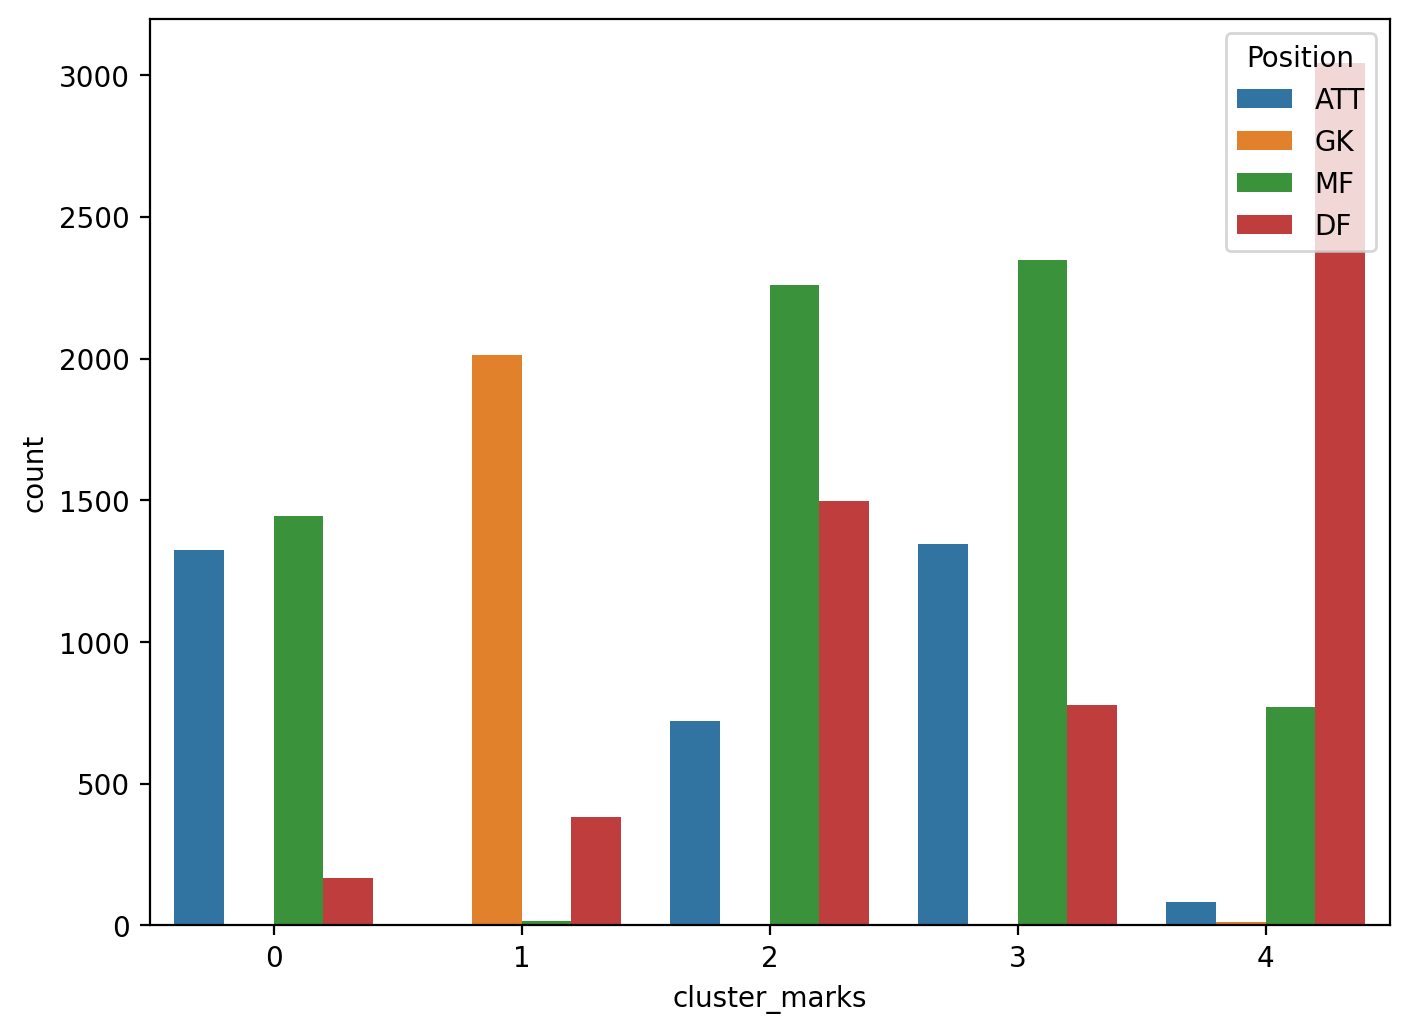

In [1174]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

# Novi pokusaj

In [1213]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric])

KMeans(n_clusters=5, random_state=0)

In [1214]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3673, (20.1735596199264 %)

NAPAD: 1778 (48.407296487884565 %)
Broj igraca na poziciji RF: 1, (0.027225701061802342 %)
Broj igraca na poziciji LF: 1, (0.027225701061802342 %)
Broj igraca na poziciji RW: 164, (4.465014974135584 %)
Broj igraca na poziciji LW: 170, (4.6283691805063985 %)
Broj igraca na poziciji ST: 1270, (34.57664034848897 %)
Broj igraca na poziciji CF: 37, (1.0073509392866866 %)
Broj igraca na poziciji RS: 69, (1.8785733732643615 %)
Broj igraca na poziciji LS: 66, (1.7968962700789546 %)

VEZNI RED: 1810 (49.278518921862236 %)
Broj igraca na poziciji RDM: 7, (0.19057990743261638 %)
Broj igraca na poziciji CDM: 23, (0.6261911244214539 %)
Broj igraca na poziciji LDM: 9, (0.2450313095562211 %)
Broj igraca na poziciji RM: 467, (12.714402395861693 %)
Broj igraca na poziciji RCM: 26, (0.707868227606861 %)
Broj igraca na poziciji CM: 426, (11.598148652327797 %)
Broj igraca na poziciji LCM: 35, (0.952899537163082 %)
Broj igraca na poziciji LM: 437, (11.8

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

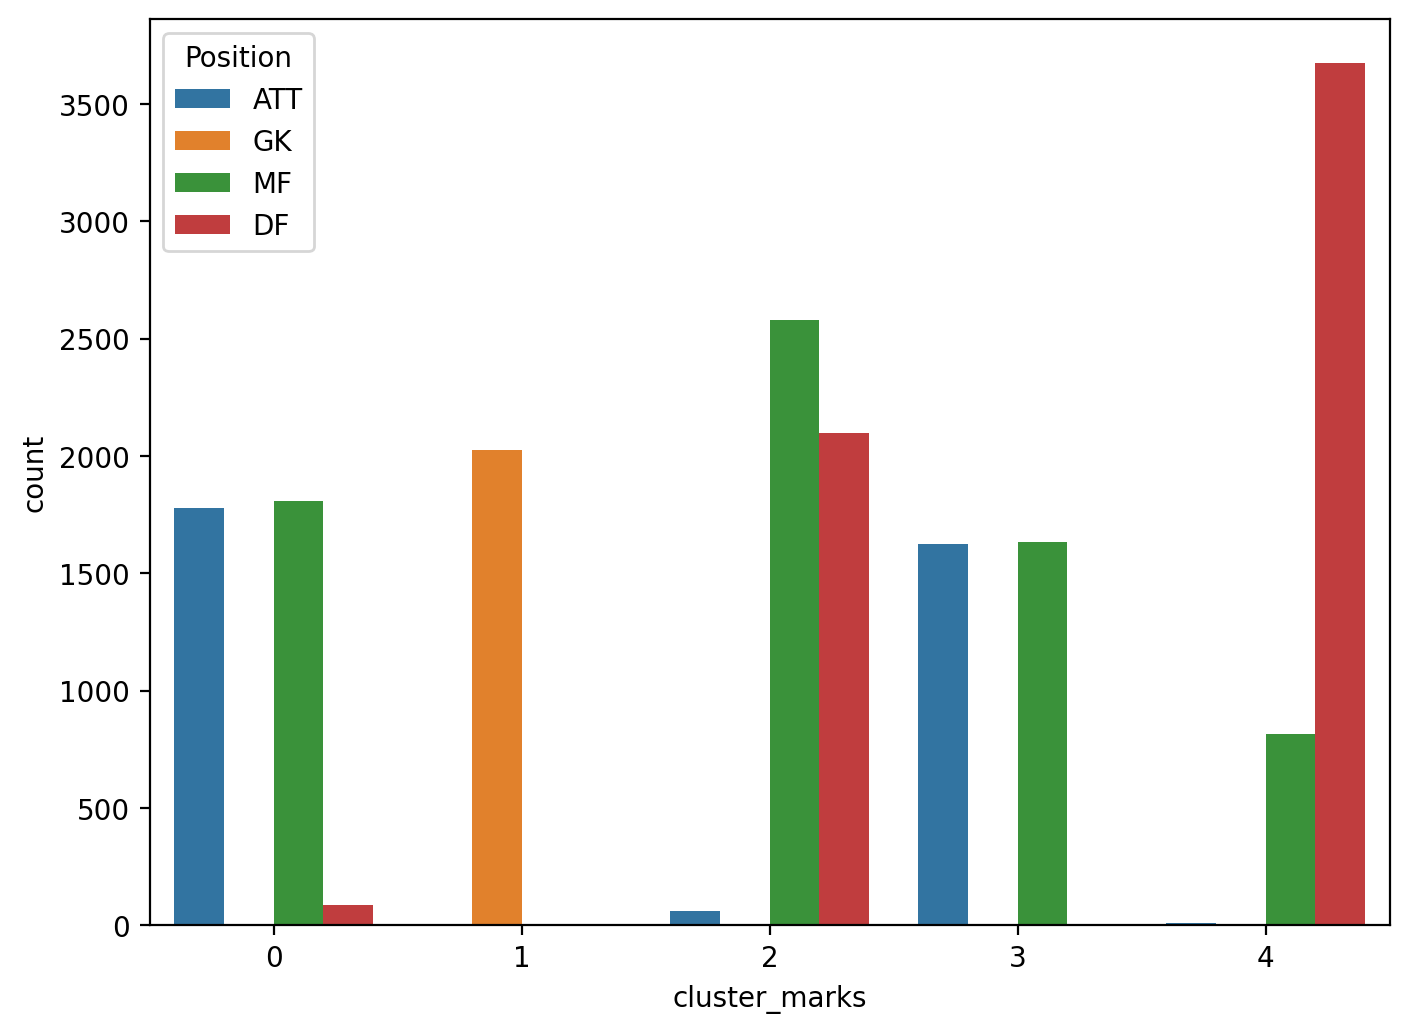

In [1215]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1216]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop('ID', axis=1))

KMeans(n_clusters=5, random_state=0)

In [1217]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4529, (24.875048058439063 %)

NAPAD: 11 (0.2428792227864871 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 11, (0.2428792227864871 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 800 (17.66394347538088 %)
Broj igraca na poziciji RDM: 42, (0.9273570324574961 %)
Broj igraca na poziciji CDM: 358, (7.904614705232943 %)
Broj igraca na poziciji LDM: 40, (0.8831971737690439 %)
Broj igraca na poziciji RM: 24, (0.5299183042614264 %)
Broj igraca na poziciji RCM: 38, (0.8390373150805918 %)
Broj igraca na poziciji CM: 234, (5.166703466548907 %)
Broj igraca na poziciji LCM: 35, (0.7727975270479135 %)
Broj igraca na poziciji LM: 20, (0.44159858688452197 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 9, (0.1987193640980349 %)
Broj

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

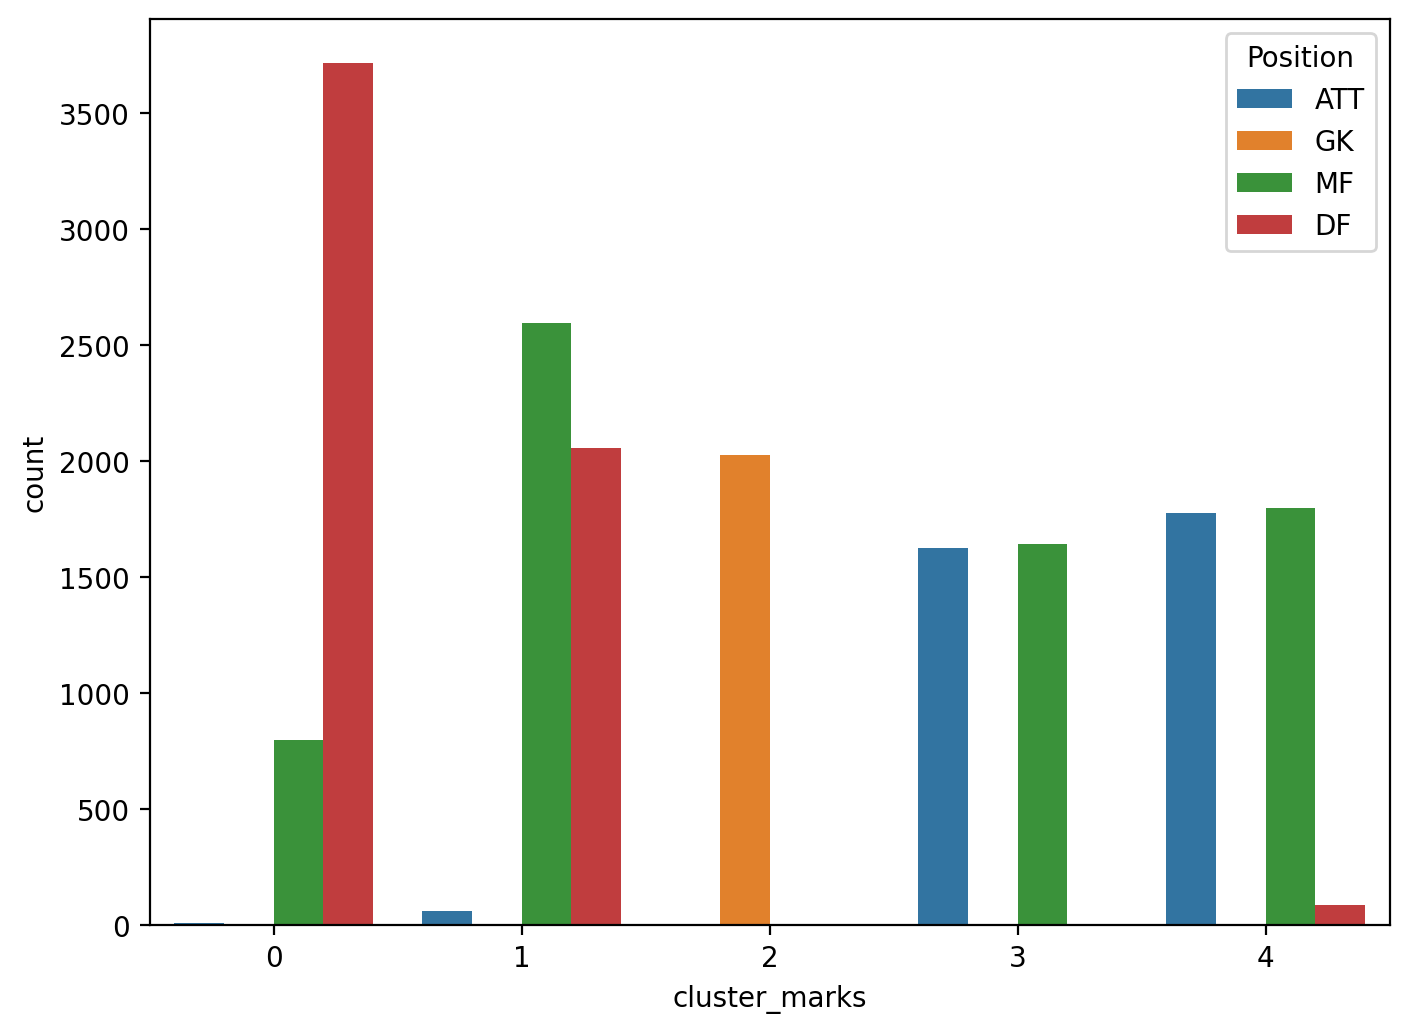

In [1218]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1219]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop('Age', axis=1))

KMeans(n_clusters=5, random_state=0)

In [1220]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3706, (20.354808590102706 %)

NAPAD: 1811 (48.8667026443605 %)
Broj igraca na poziciji RF: 1, (0.026983270372369132 %)
Broj igraca na poziciji LF: 1, (0.026983270372369132 %)
Broj igraca na poziciji RW: 165, (4.452239611440906 %)
Broj igraca na poziciji LW: 173, (4.6681057744198595 %)
Broj igraca na poziciji ST: 1296, (34.970318402590394 %)
Broj igraca na poziciji CF: 38, (1.0253642741500268 %)
Broj igraca na poziciji RS: 70, (1.8888289260658393 %)
Broj igraca na poziciji LS: 67, (1.8078791149487319 %)

VEZNI RED: 1810 (48.839719373988125 %)
Broj igraca na poziciji RDM: 9, (0.24284943335132217 %)
Broj igraca na poziciji CDM: 23, (0.62061521856449 %)
Broj igraca na poziciji LDM: 9, (0.24284943335132217 %)
Broj igraca na poziciji RM: 468, (12.628170534268754 %)
Broj igraca na poziciji RCM: 28, (0.7555315704263357 %)
Broj igraca na poziciji CM: 414, (11.17107393416082 %)
Broj igraca na poziciji LCM: 37, (0.9983810037776578 %)
Broj igraca na poziciji LM: 437, (11.

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

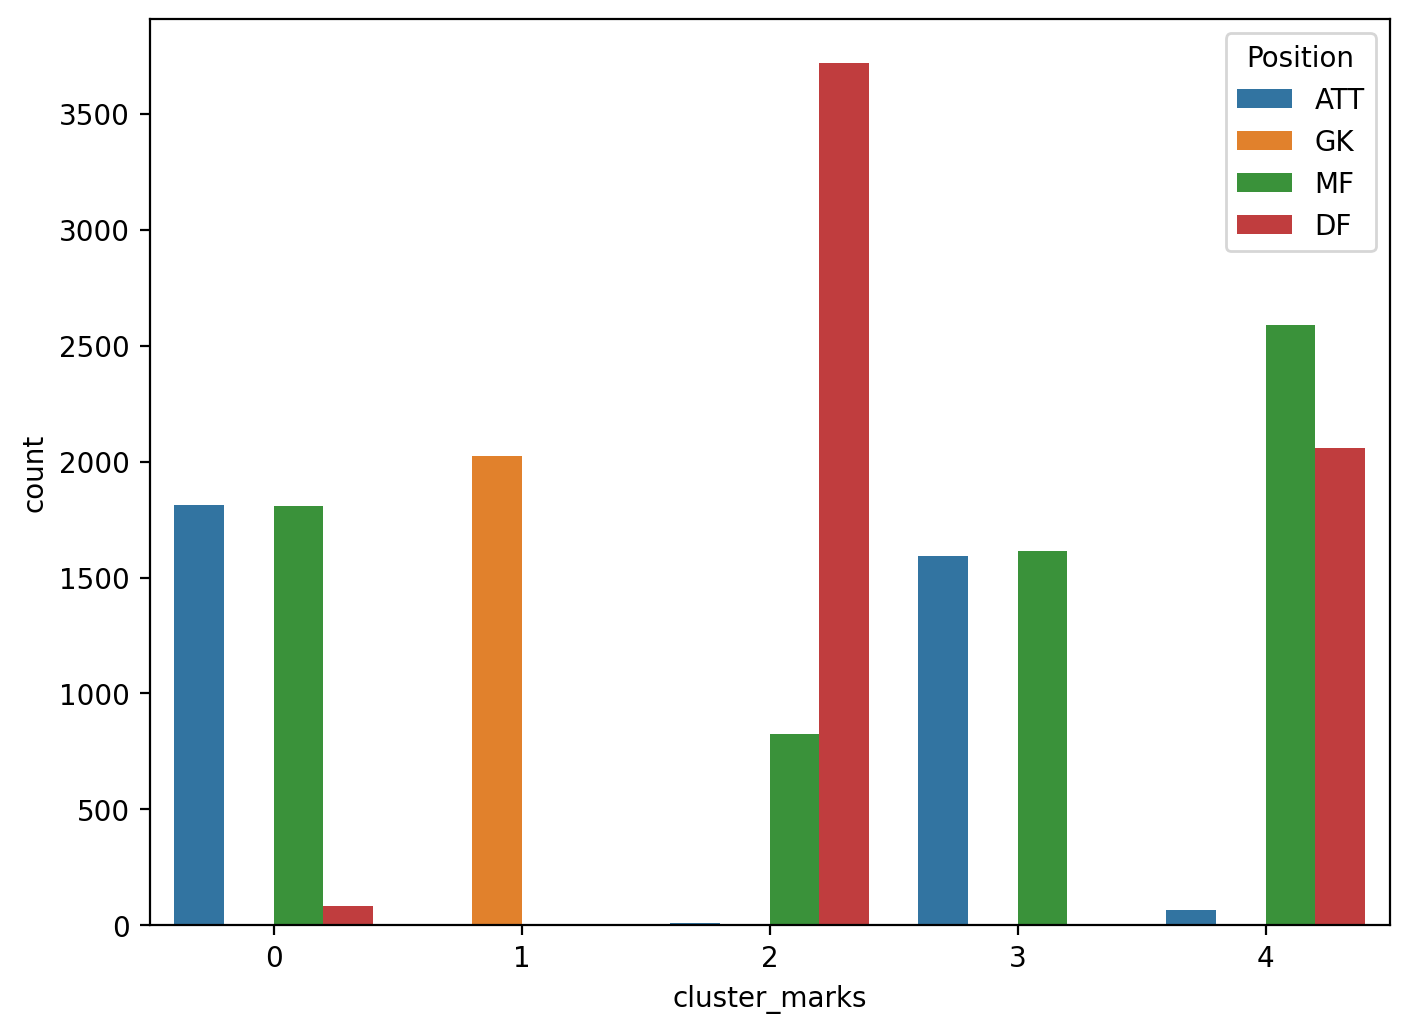

In [1221]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1228]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop('GKDiving', axis=1))

KMeans(n_clusters=5, random_state=0)

In [1229]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 3675, (20.18454440599769 %)

NAPAD: 1778 (48.38095238095238 %)
Broj igraca na poziciji RF: 1, (0.027210884353741496 %)
Broj igraca na poziciji LF: 1, (0.027210884353741496 %)
Broj igraca na poziciji RW: 164, (4.462585034013605 %)
Broj igraca na poziciji LW: 170, (4.625850340136054 %)
Broj igraca na poziciji ST: 1270, (34.5578231292517 %)
Broj igraca na poziciji CF: 37, (1.0068027210884354 %)
Broj igraca na poziciji RS: 69, (1.8775510204081631 %)
Broj igraca na poziciji LS: 66, (1.7959183673469388 %)

VEZNI RED: 1812 (49.306122448979586 %)
Broj igraca na poziciji RDM: 7, (0.19047619047619047 %)
Broj igraca na poziciji CDM: 24, (0.653061224489796 %)
Broj igraca na poziciji LDM: 9, (0.24489795918367346 %)
Broj igraca na poziciji RM: 467, (12.707482993197278 %)
Broj igraca na poziciji RCM: 26, (0.7074829931972789 %)
Broj igraca na poziciji CM: 427, (11.619047619047619 %)
Broj igraca na poziciji LCM: 35, (0.9523809523809524 %)
Broj igraca na poziciji LM: 437, (11.8

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

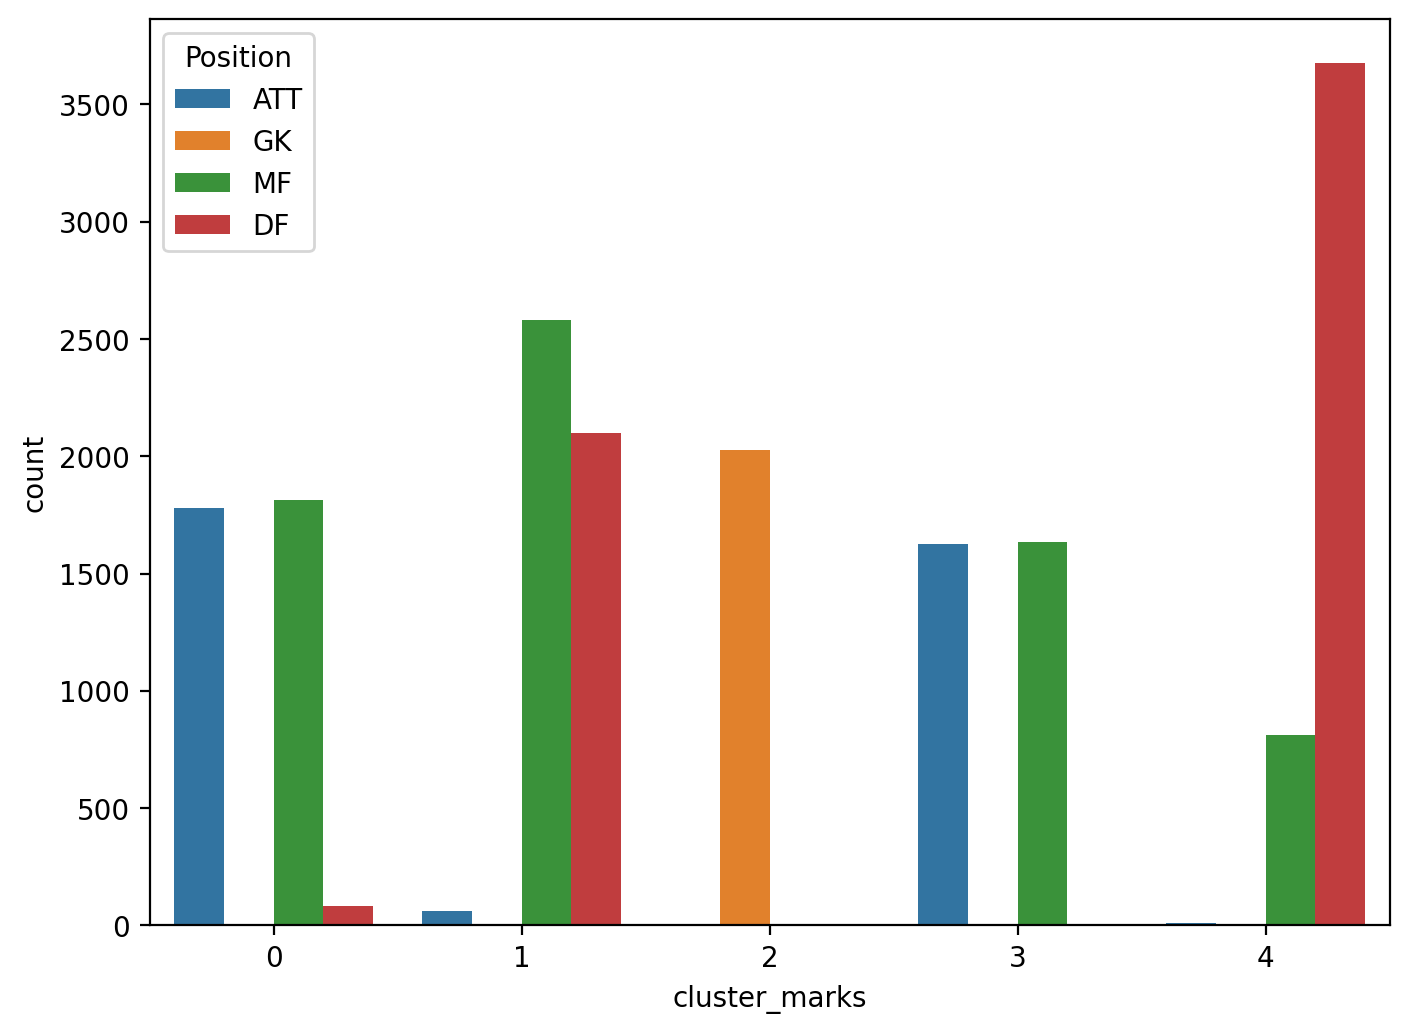

In [1230]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

In [1245]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=['Special', 'Skill Moves', 'Crossing', 'Finishing', 'HeadingAccuracy'], axis=1))

KMeans(n_clusters=5, random_state=0)

In [1246]:
df['cluster_marks'] = kmeans.labels_

df_cluster_0 = df.loc[df['cluster_marks'] == 0]
df_cluster_1 = df.loc[df['cluster_marks'] == 1]
df_cluster_2 = df.loc[df['cluster_marks'] == 2]
df_cluster_3 = df.loc[df['cluster_marks'] == 3]
df_cluster_4 = df.loc[df['cluster_marks'] == 4]

show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
show_position_percentige_per_cluster(df_cluster_4, 4, len(df))

Broj igraca u klasteru 0: 4785, (26.281100675564346 %)

NAPAD: 66 (1.3793103448275863 %)
Broj igraca na poziciji RF: 1, (0.02089864158829676 %)
Broj igraca na poziciji LF: 2, (0.04179728317659352 %)
Broj igraca na poziciji RW: 20, (0.41797283176593525 %)
Broj igraca na poziciji LW: 24, (0.5015673981191223 %)
Broj igraca na poziciji ST: 15, (0.3134796238244514 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 3, (0.06269592476489029 %)
Broj igraca na poziciji LS: 1, (0.02089864158829676 %)

VEZNI RED: 2602 (54.37826541274817 %)
Broj igraca na poziciji RDM: 193, (4.033437826541276 %)
Broj igraca na poziciji CDM: 567, (11.849529780564264 %)
Broj igraca na poziciji LDM: 180, (3.761755485893417 %)
Broj igraca na poziciji RM: 160, (3.343782654127482 %)
Broj igraca na poziciji RCM: 290, (6.0606060606060606 %)
Broj igraca na poziciji CM: 656, (13.709508881922675 %)
Broj igraca na poziciji LCM: 264, (5.517241379310345 %)
Broj igraca na poziciji LM: 158, (3.3019853709508884 %

<AxesSubplot:xlabel='cluster_marks', ylabel='count'>

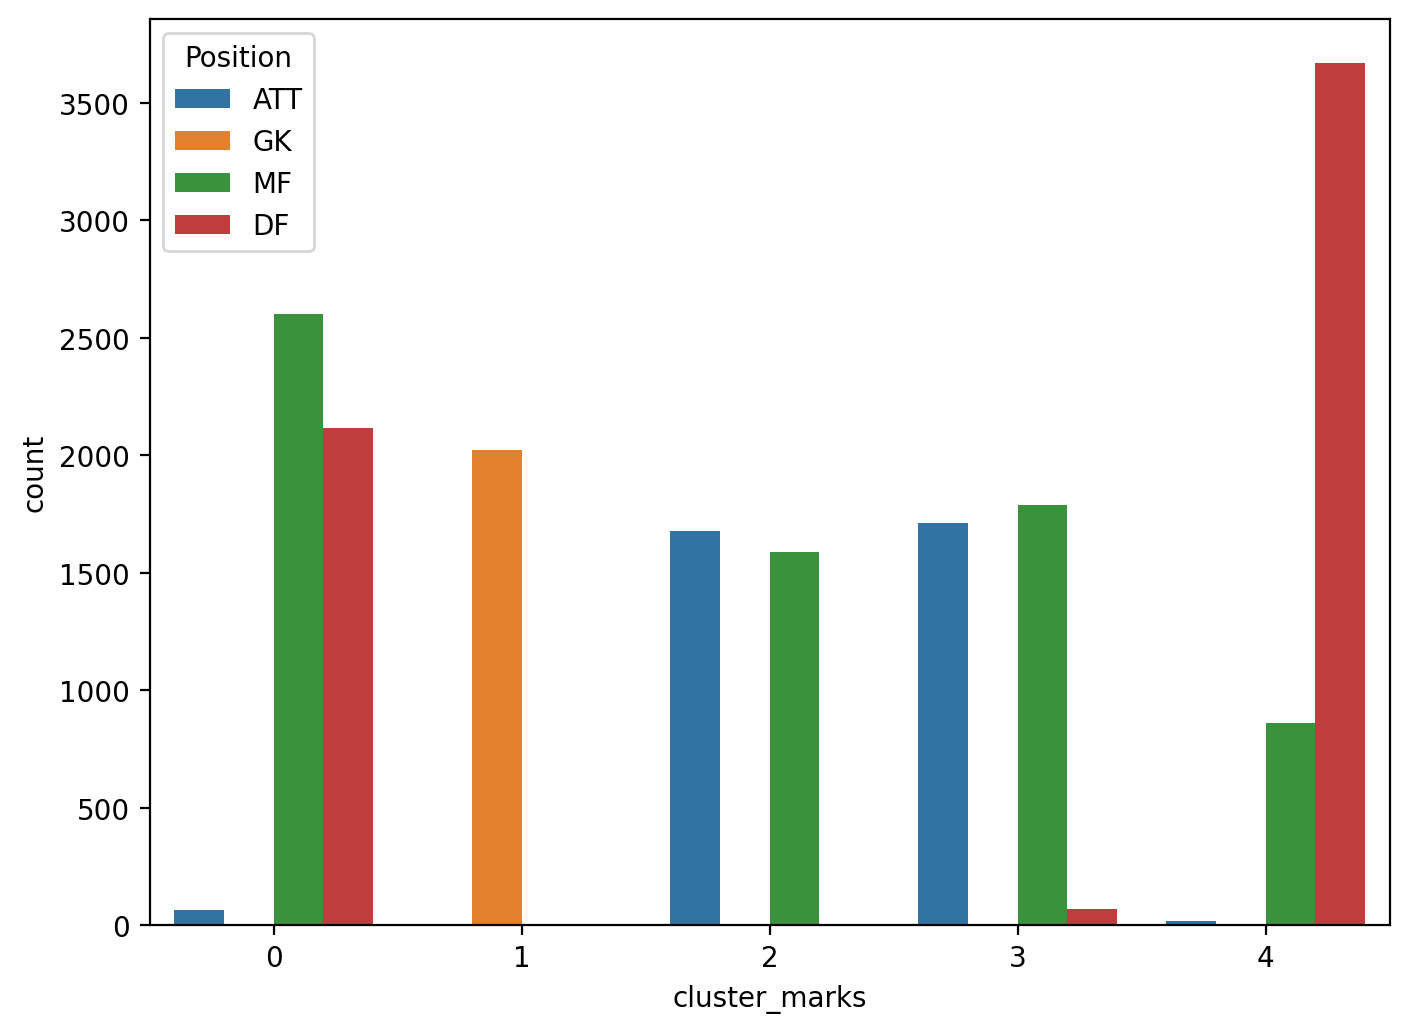

In [1247]:
df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
plt.figure(num=None, figsize=(8, 6), dpi=200)
sns.countplot(x='cluster_marks', hue='Position', data=df1)

# 5.2.2021.

In [20]:
df[numeric].columns.values

array(['Unnamed: 0', 'ID', 'Age', 'Overall', 'Potential', 'Special',
       'International Reputation', 'Weak Foot', 'Skill Moves',
       'Jersey Number', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed',
       'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping',
       'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions',
       'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking',
       'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes'], dtype=object)

In [103]:
columns_to_drop = ['Special', 'Skill Moves', 'Crossing', 'Finishing', 'HeadingAccuracy',
                   'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
                   'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed',
                   'Agility', 'Balance', 'ShotPower', 'Stamina', 'LongShots', 
                   'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
                   'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']

In [176]:
# Print percentige of five clusters

def print_percentige_of_five_clusters(df):
    
    df['cluster_marks'] = kmeans.labels_

    df_cluster_0 = df.loc[df['cluster_marks'] == 0]
    df_cluster_1 = df.loc[df['cluster_marks'] == 1]
    df_cluster_2 = df.loc[df['cluster_marks'] == 2]
    df_cluster_3 = df.loc[df['cluster_marks'] == 3]
    df_cluster_4 = df.loc[df['cluster_marks'] == 4]

    show_position_percentige_per_cluster(df_cluster_0, 0, len(df))
    show_position_percentige_per_cluster(df_cluster_1, 1, len(df))
    show_position_percentige_per_cluster(df_cluster_2, 2, len(df))
    show_position_percentige_per_cluster(df_cluster_3, 3, len(df))
    show_position_percentige_per_cluster(df_cluster_4, 4, len(df))
    

In [177]:
def draw(df):
    
    df1 = df.replace({'RF': 'ATT', 'LF': 'ATT', 'RW': 'ATT', 'LW': 'ATT', 'ST': 'ATT', 'CF': 'ATT', 'RS': 'ATT', 'LS': 'ATT',
            'RDM': 'MF', 'CDM': 'MF', 'LDM': 'MF', 'RM': 'MF', 'RCM': 'MF', 'CM': 'MF', 'LCM': 'MF', 'LM': 'MF', 'RAM': 'MF', 'CAM': 'MF', 'LAM': 'MF',
            'RWB': 'DF', 'RB': 'DF', 'RCB': 'DF', 'CB': 'DF', 'LCB': 'DF', 'LB': 'DF', 'LWB': 'DF'})
    
    plt.figure(num=None, figsize=(8, 6), dpi=200)
    sns.countplot(x='cluster_marks', hue='Position', data=df1)

# Uklanjanje svih kolona koje golmane cine inferiornijim od igraca

In [173]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [174]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 969, (5.322128851540616 %)

NAPAD: 0 (0.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 0, (0.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 0 (0.0 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 0 (0.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji RCB: 0, (0.0 %)
Broj igraca na pozi

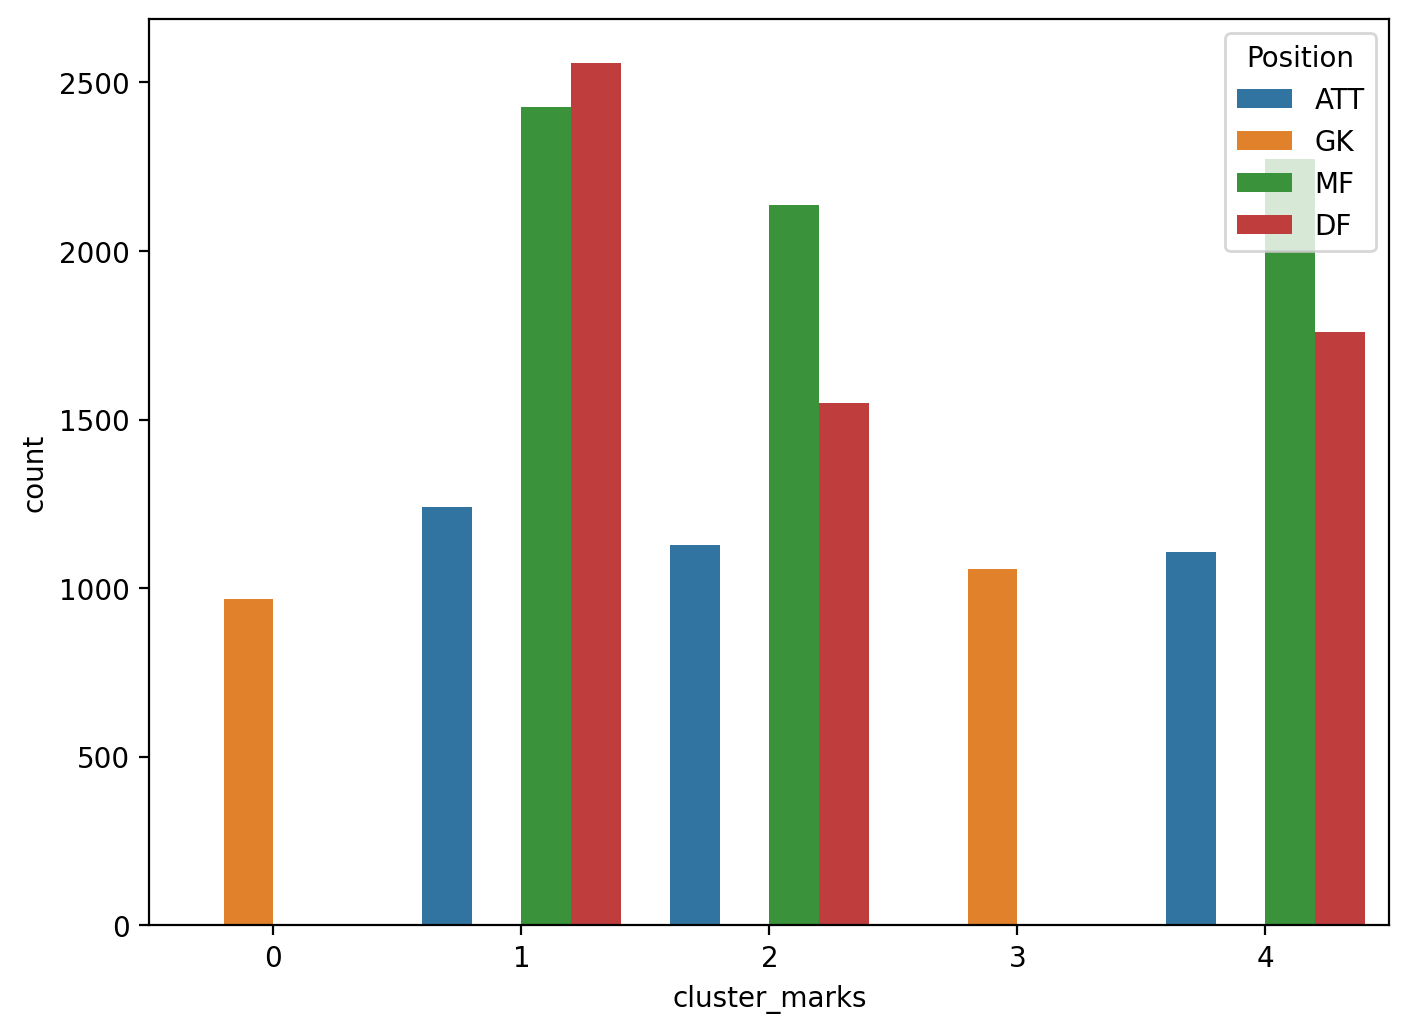

In [175]:
draw(df)

## Uklanjanje i zadrzavanje pojedinacnih kolona (koje golmane cine inferiornijim od igraca)

In [104]:
# Special zadrzano

if 'Special' in columns_to_drop:
    columns_to_drop.remove('Special')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [106]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 4842, (26.594167078596143 %)

NAPAD: 1140 (23.543990086741015 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 129, (2.664188351920694 %)
Broj igraca na poziciji LW: 136, (2.808756712102437 %)
Broj igraca na poziciji ST: 800, (16.52209830648492 %)
Broj igraca na poziciji CF: 32, (0.660883932259397 %)
Broj igraca na poziciji RS: 19, (0.39239983477901696 %)
Broj igraca na poziciji LS: 24, (0.49566294919454773 %)

VEZNI RED: 2088 (43.12267657992565 %)
Broj igraca na poziciji RDM: 22, (0.45435770342833537 %)
Broj igraca na poziciji CDM: 257, (5.307724080958281 %)
Broj igraca na poziciji LDM: 28, (0.5782734407269724 %)
Broj igraca na poziciji RM: 380, (7.847996695580339 %)
Broj igraca na poziciji RCM: 46, (0.950020652622883 %)
Broj igraca na poziciji CM: 636, (13.135068153655514 %)
Broj igraca na poziciji LCM: 47, (0.9706732755059893 %)
Broj igraca na poziciji LM: 351, (7.24907063197026 %)
Broj igraca na p

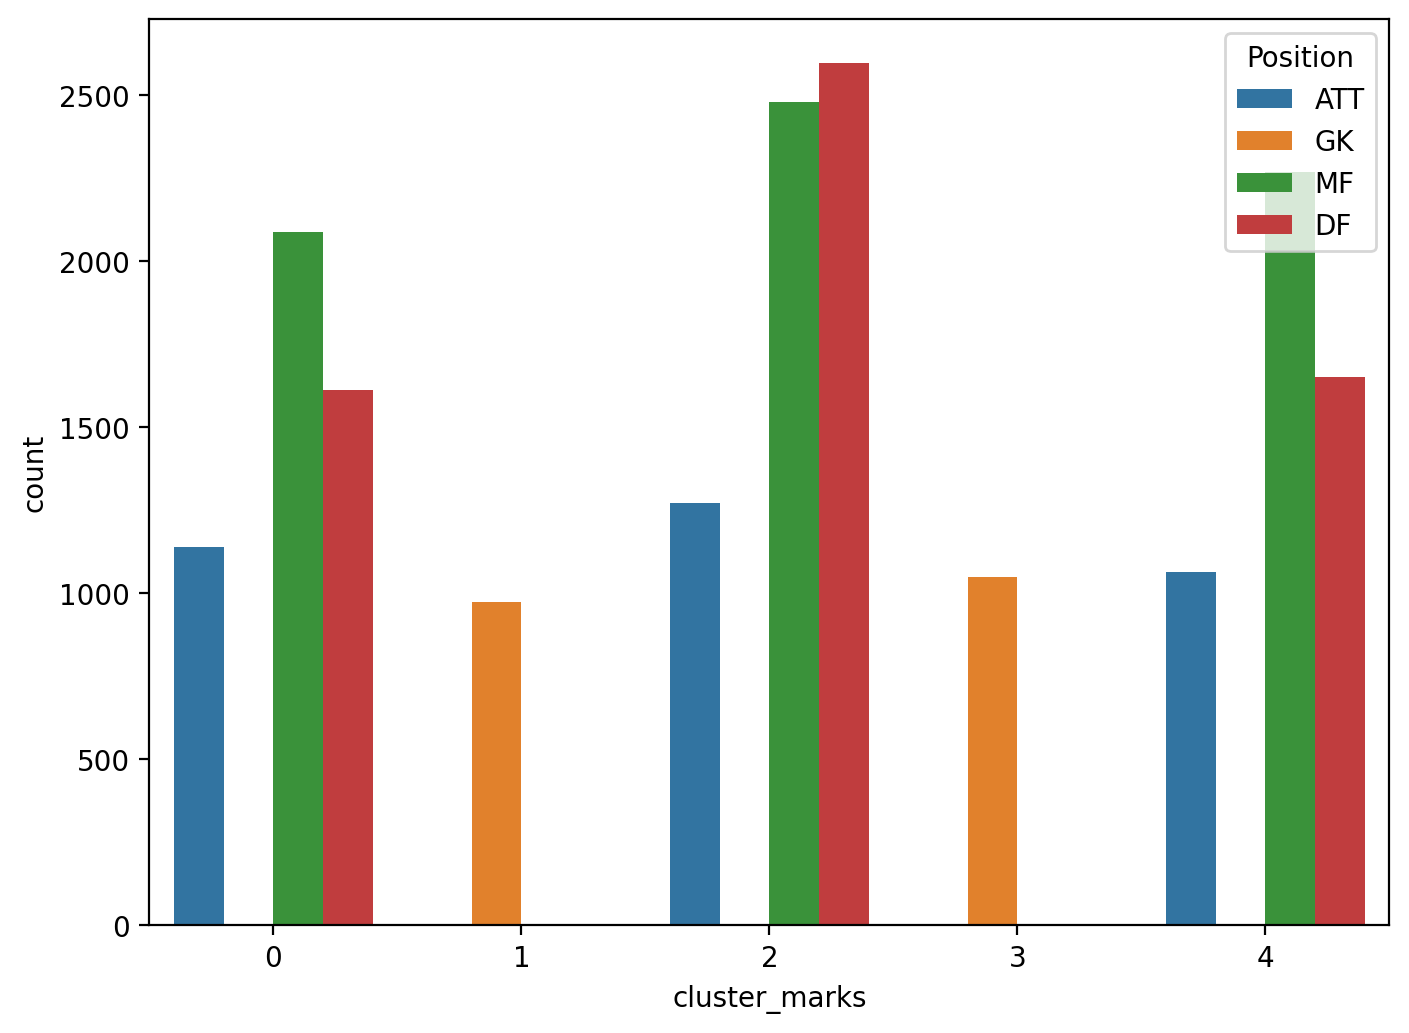

In [108]:
draw(df)

In [111]:
# Special uklonjeno

columns_to_drop.append('Special')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [113]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 969, (5.322128851540616 %)

NAPAD: 0 (0.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 0, (0.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 0 (0.0 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 0 (0.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji RCB: 0, (0.0 %)
Broj igraca na pozi

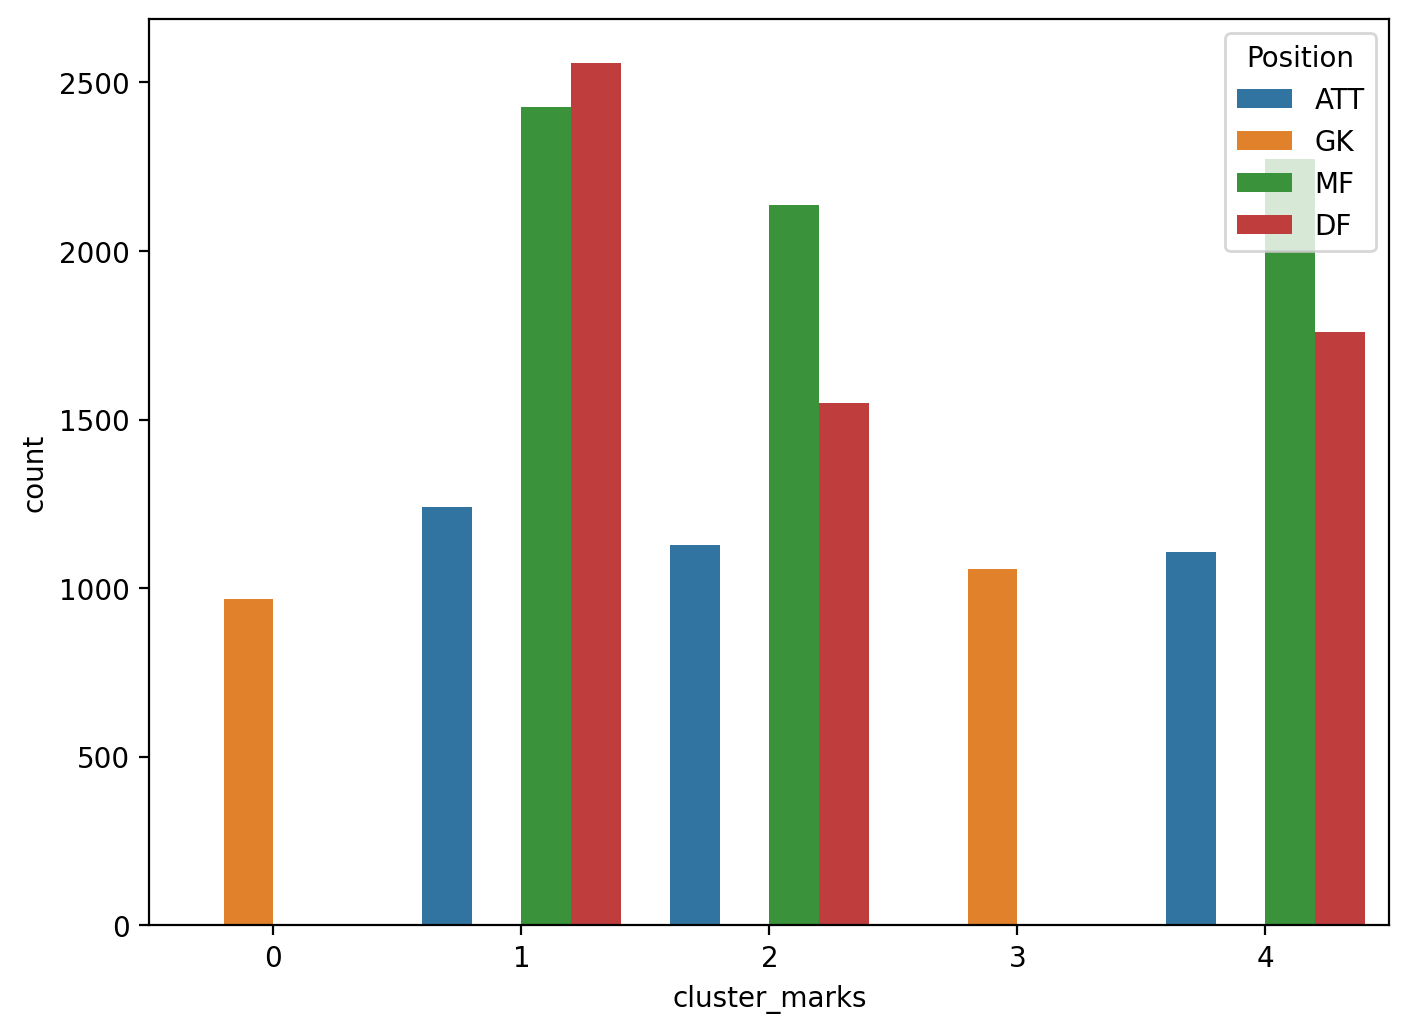

In [114]:
draw(df)

In [115]:
# Skill Moves zadrzano

if 'Skill Moves' in columns_to_drop:
    columns_to_drop.remove('Skill Moves')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [116]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 969, (5.322128851540616 %)

NAPAD: 0 (0.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 0, (0.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 0 (0.0 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 0 (0.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji RCB: 0, (0.0 %)
Broj igraca na pozi

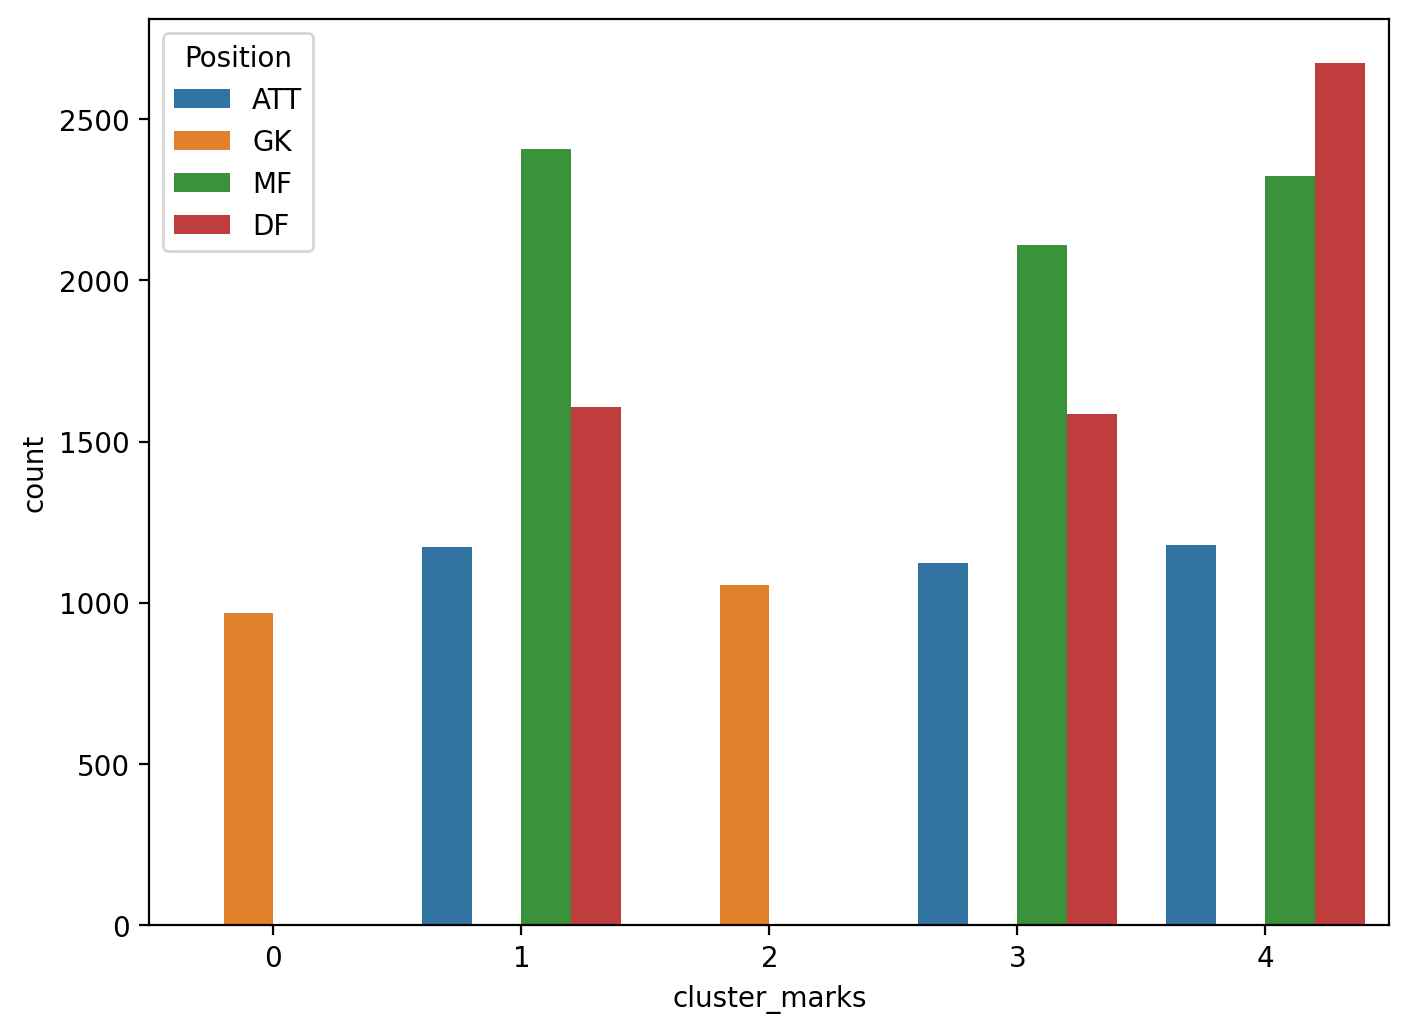

In [118]:
draw(df)

In [119]:
# Special uklonjeno

columns_to_drop.append('Skill Moves')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [120]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 969, (5.322128851540616 %)

NAPAD: 0 (0.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 0, (0.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 0 (0.0 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 0 (0.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji RCB: 0, (0.0 %)
Broj igraca na pozi

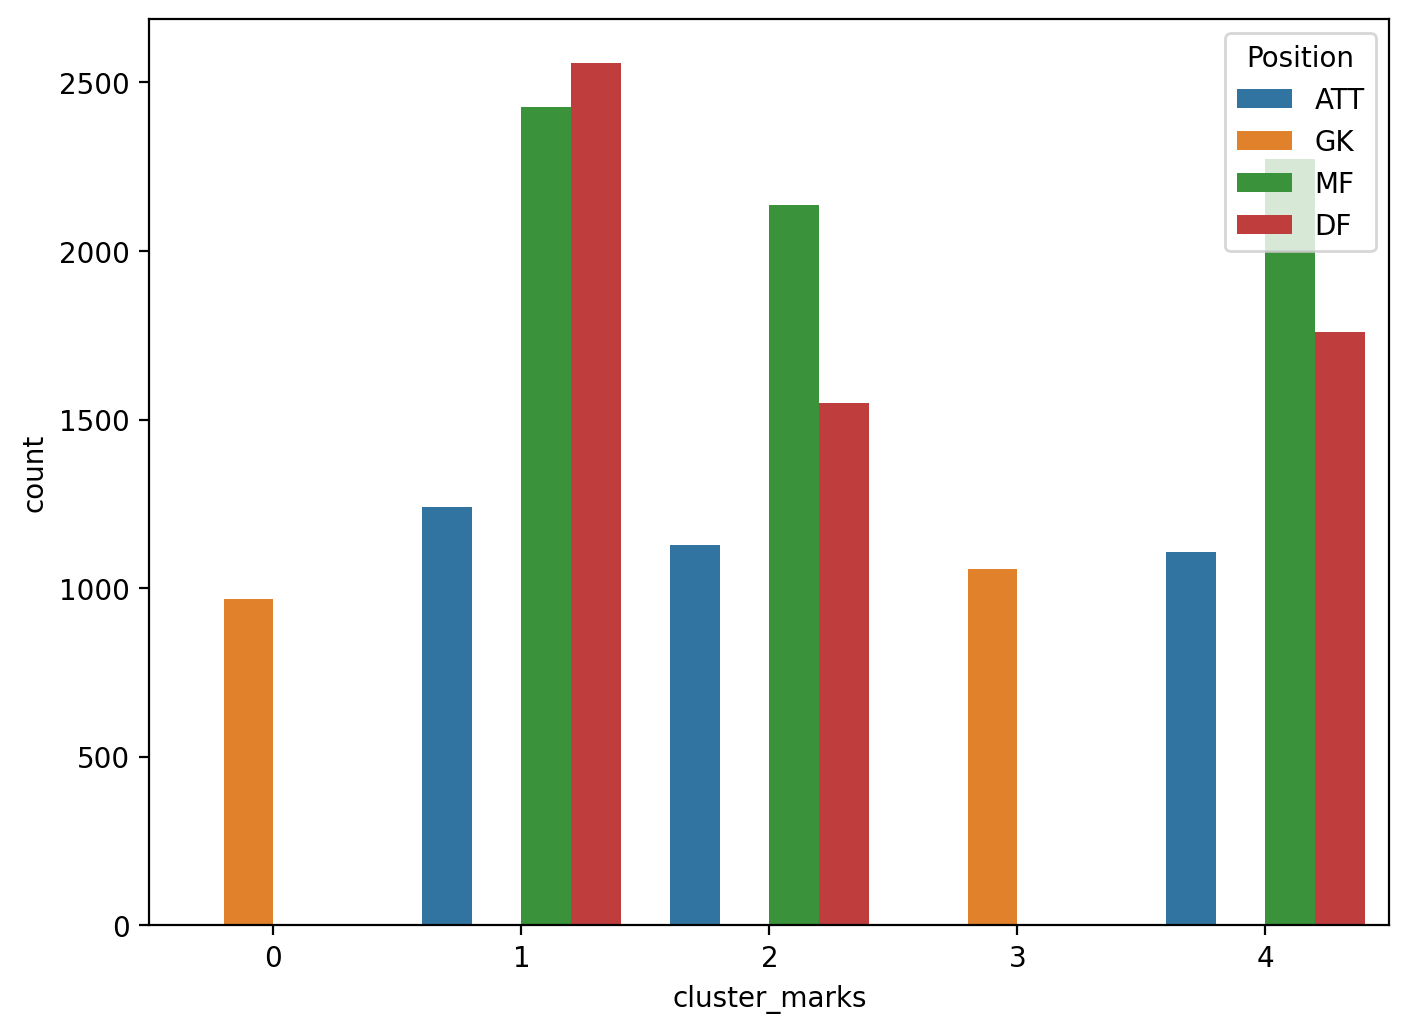

In [121]:
draw(df)

In [128]:
# Crossing zadrzano

# if 'Crossing' in columns_to_drop:
#     columns_to_drop.remove('Crossing')
    
# kmeans = KMeans(n_clusters=5, random_state=0)
# kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [129]:
# print_percentige_of_five_clusters(df)

In [130]:
# draw(df)

In [131]:
# Crossing uklonjeno

# columns_to_drop.append('Crossing')
# kmeans = KMeans(n_clusters=5, random_state=0)
# kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [132]:
# print_percentige_of_five_clusters(df)

In [133]:
# draw(df)

In [134]:
# Finishing zadrzano

if 'Finishing' in columns_to_drop:
    columns_to_drop.remove('Finishing')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [144]:
# print_percentige_of_five_clusters(df)

In [143]:
# draw(df)

In [140]:
# Finishing uklonjeno

# columns_to_drop.append('Finishing')
# kmeans = KMeans(n_clusters=5, random_state=0)
# kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [141]:
# print_percentige_of_five_clusters(df)

In [142]:
# draw(df)

In [145]:
# HeadingAccuracy zadrzano

if 'HeadingAccuracy' in columns_to_drop:
    columns_to_drop.remove('HeadingAccuracy')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [154]:
# print_percentige_of_five_clusters(df)

In [153]:
# draw(df)

In [148]:
# HeadingAccuracy uklonjeno

columns_to_drop.append('HeadingAccuracy')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [152]:
# print_percentige_of_five_clusters(df)

In [151]:
# draw(df)

In [ ]:
# ShortPassing zadrzano

if 'ShortPassing' in columns_to_drop:
    columns_to_drop.remove('ShortPassing')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# ShortPassing uklonjeno

columns_to_drop.append('ShortPassing')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Volleys zadrzano

if 'Volleys' in columns_to_drop:
    columns_to_drop.remove('Volleys')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Volleys uklonjeno

columns_to_drop.append('Volleys')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Dribbling zadrzano

if 'Dribbling' in columns_to_drop:
    columns_to_drop.remove('Dribbling')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Dribbling uklonjeno

columns_to_drop.append('Dribbling')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Curve zadrzano

if 'Curve' in columns_to_drop:
    columns_to_drop.remove('Curve')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Curve uklonjeno

columns_to_drop.append('Curve')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# FKAccuracy zadrzano

if 'FKAccuracy' in columns_to_drop:
    columns_to_drop.remove('FKAccuracy')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# FKAccuracy uklonjeno

columns_to_drop.append('FKAccuracy')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# LongPassing zadrzano

if 'LongPassing' in columns_to_drop:
    columns_to_drop.remove('LongPassing')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# LongPassing uklonjeno

columns_to_drop.append('LongPassing')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# BallControl zadrzano

if 'BallControl' in columns_to_drop:
    columns_to_drop.remove('BallControl')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# BallControl uklonjeno

columns_to_drop.append('BallControl')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Acceleration zadrzano

if 'Acceleration' in columns_to_drop:
    columns_to_drop.remove('Acceleration')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Acceleration uklonjeno

columns_to_drop.append('Acceleration')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# SprintSpeed zadrzano

if 'SprintSpeed' in columns_to_drop:
    columns_to_drop.remove('SprintSpeed')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# SprintSpeed uklonjeno

columns_to_drop.append('SprintSpeed')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Agility zadrzano

if 'Agility' in columns_to_drop:
    columns_to_drop.remove('Agility')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Agility uklonjeno

columns_to_drop.append('Agility')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Balance zadrzano

if 'Balance' in columns_to_drop:
    columns_to_drop.remove('Balance')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Balance uklonjeno

columns_to_drop.append('Balance')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# ShotPower zadrzano

if 'Balance' in columns_to_drop:
    columns_to_drop.remove('Balance')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# ShotPower uklonjeno

columns_to_drop.append('ShotPower')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Stamina zadrzano

if 'Stamina' in columns_to_drop:
    columns_to_drop.remove('Stamina')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Stamina uklonjeno

columns_to_drop.append('Stamina')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# LongShots zadrzano

if 'LongShots' in columns_to_drop:
    columns_to_drop.remove('LongShots')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# LongShots uklonjeno

columns_to_drop.append('LongShots')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Aggression zadrzano

if 'Aggression' in columns_to_drop:
    columns_to_drop.remove('Aggression')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Aggression uklonjeno

columns_to_drop.append('Aggression')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Interceptions zadrzano

if 'Interceptions' in columns_to_drop:
    columns_to_drop.remove('Interceptions')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Interceptions uklonjeno

columns_to_drop.append('Interceptions')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Positioning zadrzano

if 'Positioning' in columns_to_drop:
    columns_to_drop.remove('Positioning')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Positioning uklonjeno

columns_to_drop.append('Positioning')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Vision zadrzano

if 'Vision' in columns_to_drop:
    columns_to_drop.remove('Vision')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Vision uklonjeno

columns_to_drop.append('Vision')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Penalties zadrzano

if 'Penalties' in columns_to_drop:
    columns_to_drop.remove('Penalties')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Penalties uklonjeno

columns_to_drop.append('Penalties')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Composure zadrzano

if 'Composure' in columns_to_drop:
    columns_to_drop.remove('Composure')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [ ]:
# Composure uklonjeno

columns_to_drop.append('Composure')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

In [ ]:
print_percentige_of_five_clusters(df)

In [ ]:
draw(df)

In [167]:
# Marking zadrzano

if 'Marking' in columns_to_drop:
    columns_to_drop.remove('Marking')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [168]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 6306, (34.635030482781346 %)

NAPAD: 1221 (19.362511893434824 %)
Broj igraca na poziciji RF: 7, (0.11100539169045354 %)
Broj igraca na poziciji LF: 7, (0.11100539169045354 %)
Broj igraca na poziciji RW: 107, (1.6967967015540752 %)
Broj igraca na poziciji LW: 124, (1.9663812242308911 %)
Broj igraca na poziciji ST: 799, (12.67047256581034 %)
Broj igraca na poziciji CF: 14, (0.22201078338090707 %)
Broj igraca na poziciji RS: 82, (1.3003488740881701 %)
Broj igraca na poziciji LS: 81, (1.2844909609895336 %)

VEZNI RED: 2482 (39.35934031081509 %)
Broj igraca na poziciji RDM: 93, (1.4747859181731684 %)
Broj igraca na poziciji CDM: 402, (6.374881065651761 %)
Broj igraca na poziciji LDM: 97, (1.5382175705677132 %)
Broj igraca na poziciji RM: 398, (6.311449413257216 %)
Broj igraca na poziciji RCM: 164, (2.6006977481763403 %)
Broj igraca na poziciji CM: 446, (7.072629241991754 %)
Broj igraca na poziciji LCM: 161, (2.5531240088804315 %)
Broj igraca na poziciji LM: 392, (6

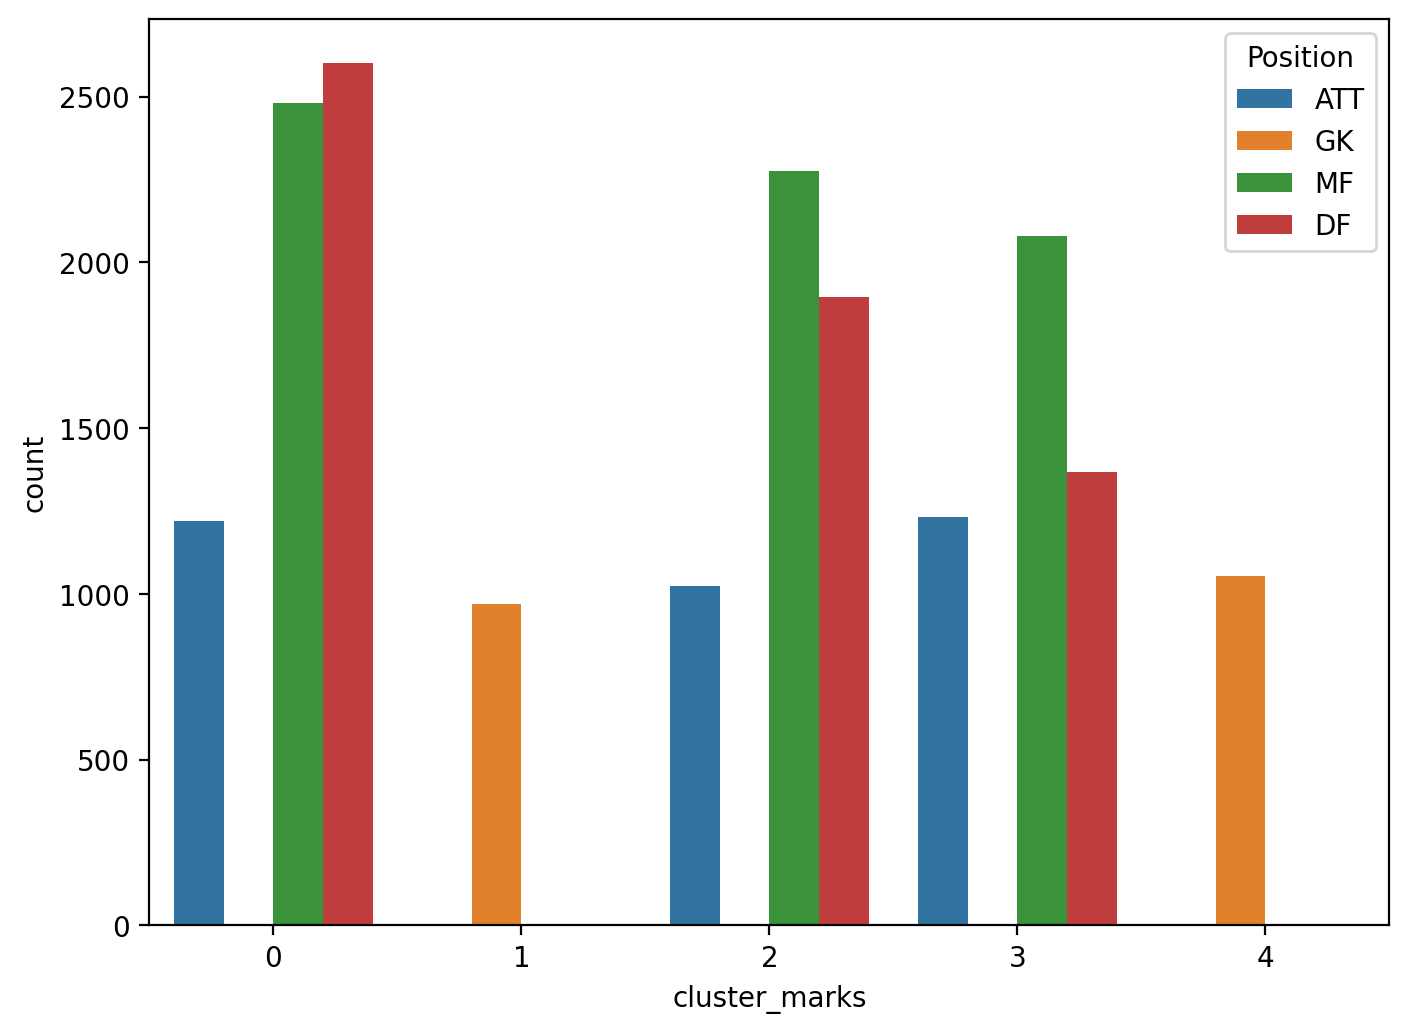

In [169]:
draw(df)

In [170]:
# Marking uklonjeno

columns_to_drop.append('Marking')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [171]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 969, (5.322128851540616 %)

NAPAD: 0 (0.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 0, (0.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 0 (0.0 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 0 (0.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji RCB: 0, (0.0 %)
Broj igraca na pozi

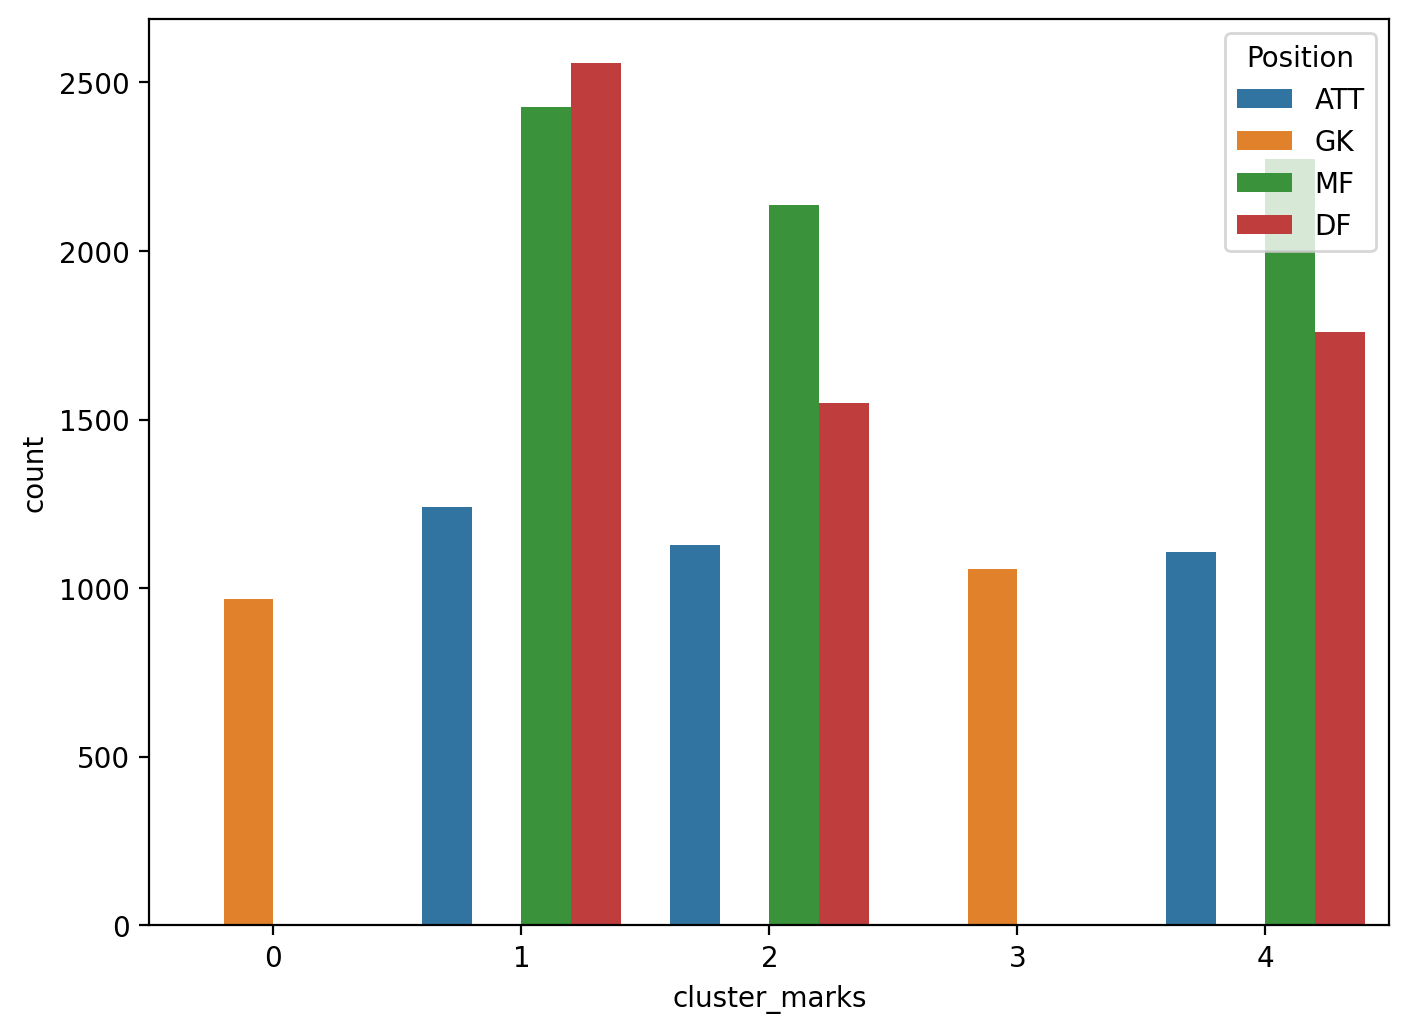

In [172]:
draw(df)

In [161]:
# StandingTackle zadrzano

if 'StandingTackle' in columns_to_drop:
    columns_to_drop.remove('StandingTackle')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [162]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 3158, (17.344977206568903 %)

NAPAD: 1730 (54.78150728309057 %)
Broj igraca na poziciji RF: 10, (0.31665611146295125 %)
Broj igraca na poziciji LF: 8, (0.253324889170361 %)
Broj igraca na poziciji RW: 186, (5.889803673210893 %)
Broj igraca na poziciji LW: 168, (5.319822672577581 %)
Broj igraca na poziciji ST: 1058, (33.50221659278024 %)
Broj igraca na poziciji CF: 29, (0.9183027232425586 %)
Broj igraca na poziciji RS: 131, (4.148195060164661 %)
Broj igraca na poziciji LS: 140, (4.433185560481317 %)

VEZNI RED: 1421 (44.99683343888537 %)
Broj igraca na poziciji RDM: 8, (0.253324889170361 %)
Broj igraca na poziciji CDM: 3, (0.09499683343888536 %)
Broj igraca na poziciji LDM: 6, (0.18999366687777072 %)
Broj igraca na poziciji RM: 417, (13.204559848005065 %)
Broj igraca na poziciji RCM: 28, (0.8866371120962635 %)
Broj igraca na poziciji CM: 64, (2.026599113362888 %)
Broj igraca na poziciji LCM: 43, (1.3616212792906903 %)
Broj igraca na poziciji LM: 457, (14.471184

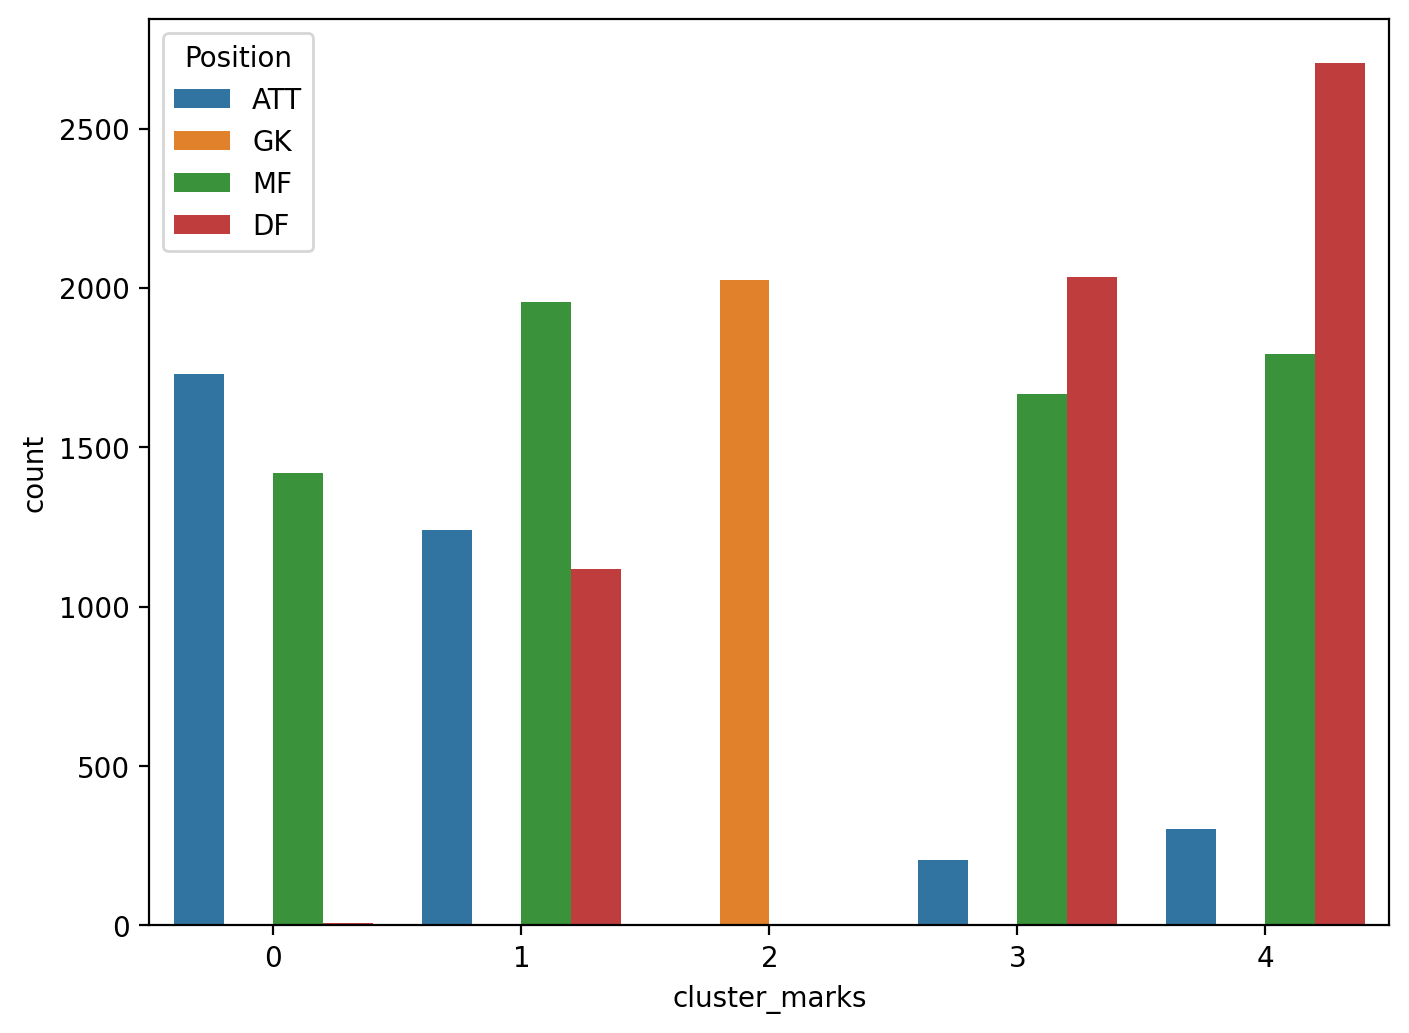

In [163]:
draw(df)

In [164]:
# StandingTackle uklonjeno

columns_to_drop.append('StandingTackle')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [165]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 969, (5.322128851540616 %)

NAPAD: 0 (0.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 0, (0.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 0 (0.0 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 0 (0.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji RCB: 0, (0.0 %)
Broj igraca na pozi

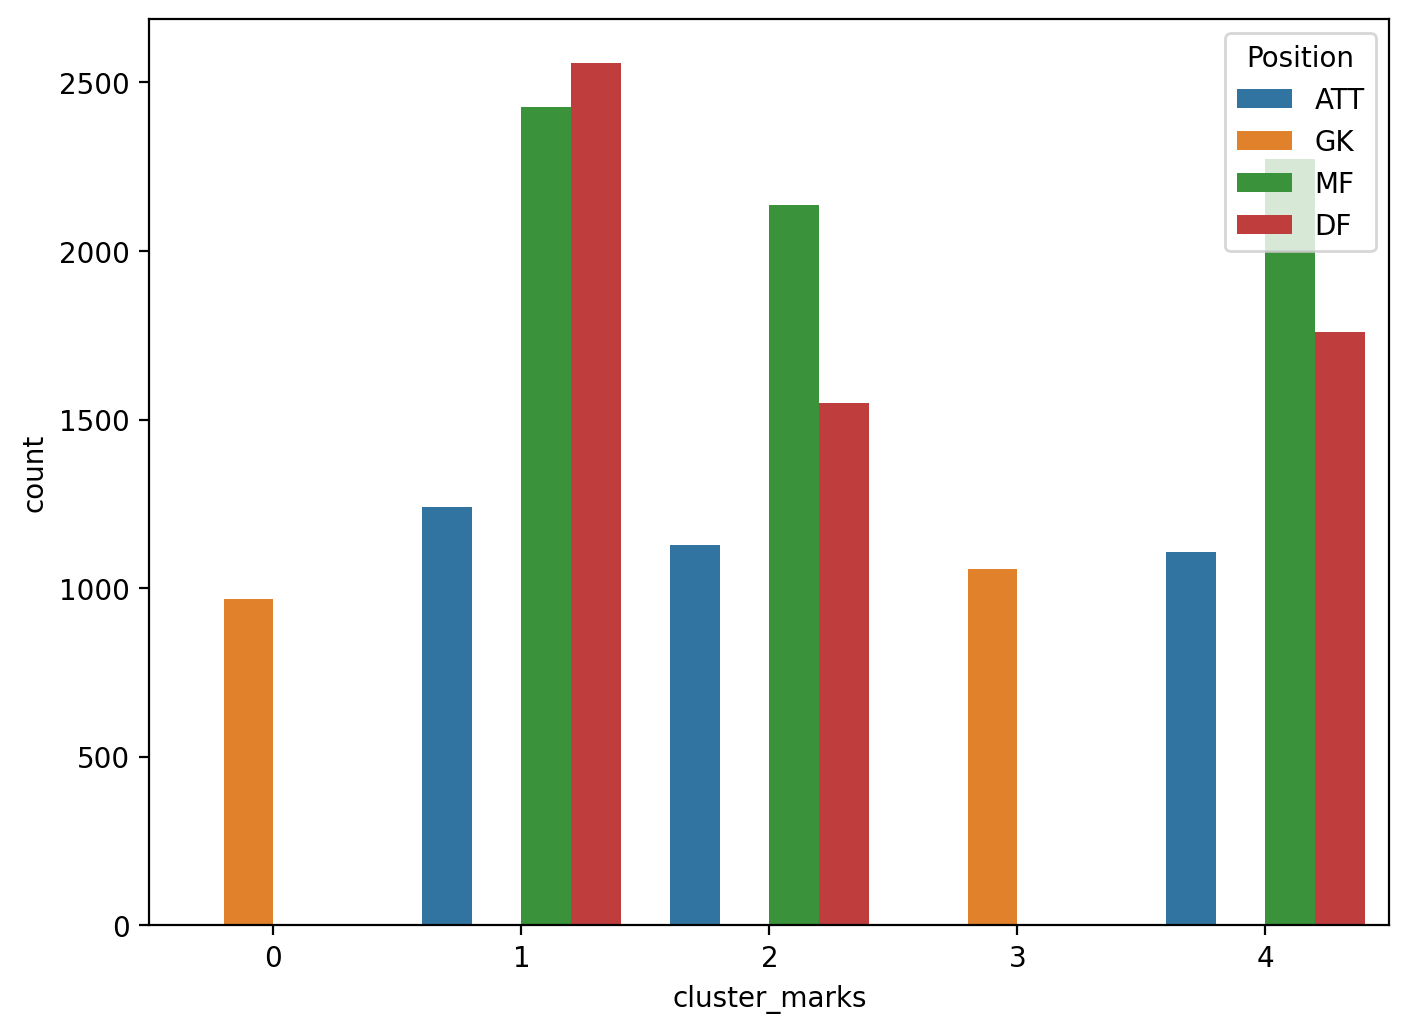

In [166]:
draw(df)

In [155]:
# SlidingTackle zadrzano

if 'SlidingTackle' in columns_to_drop:
    columns_to_drop.remove('SlidingTackle')
    
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [156]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 4706, (25.84720162574834 %)

NAPAD: 257 (5.461113472163196 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 2, (0.042498937526561836 %)
Broj igraca na poziciji RW: 26, (0.5524861878453038 %)
Broj igraca na poziciji LW: 36, (0.764980875478113 %)
Broj igraca na poziciji ST: 156, (3.314917127071823 %)
Broj igraca na poziciji CF: 3, (0.06374840628984275 %)
Broj igraca na poziciji RS: 17, (0.3612409689757756 %)
Broj igraca na poziciji LS: 17, (0.3612409689757756 %)

VEZNI RED: 1756 (37.31406714832129 %)
Broj igraca na poziciji RDM: 83, (1.7637059073523162 %)
Broj igraca na poziciji CDM: 413, (8.776030599235018 %)
Broj igraca na poziciji LDM: 88, (1.8699532511687207 %)
Broj igraca na poziciji RM: 167, (3.548661283467913 %)
Broj igraca na poziciji RCM: 147, (3.123671908202295 %)
Broj igraca na poziciji CM: 433, (9.201019974500637 %)
Broj igraca na poziciji LCM: 135, (2.868678283042924 %)
Broj igraca na poziciji LM: 160, (3.3999150021249465 %)
Bro

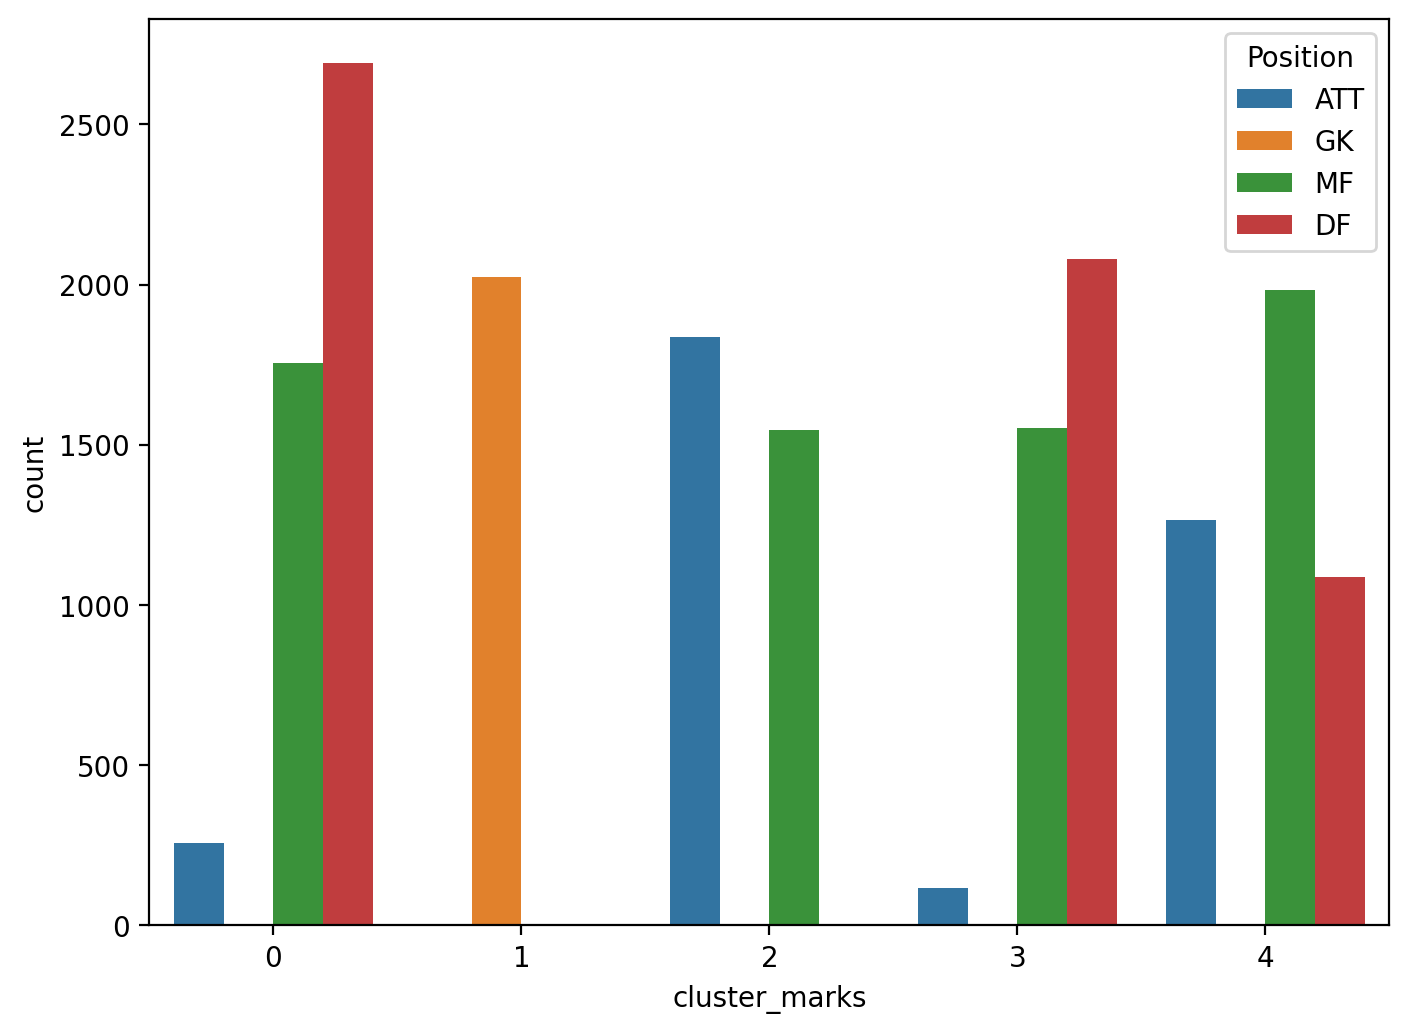

In [157]:
draw(df)

In [158]:
# SlidingTackle uklonjeno

columns_to_drop.append('SlidingTackle')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [159]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 969, (5.322128851540616 %)

NAPAD: 0 (0.0 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 0, (0.0 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 0 (0.0 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 0 (0.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji RCB: 0, (0.0 %)
Broj igraca na pozi

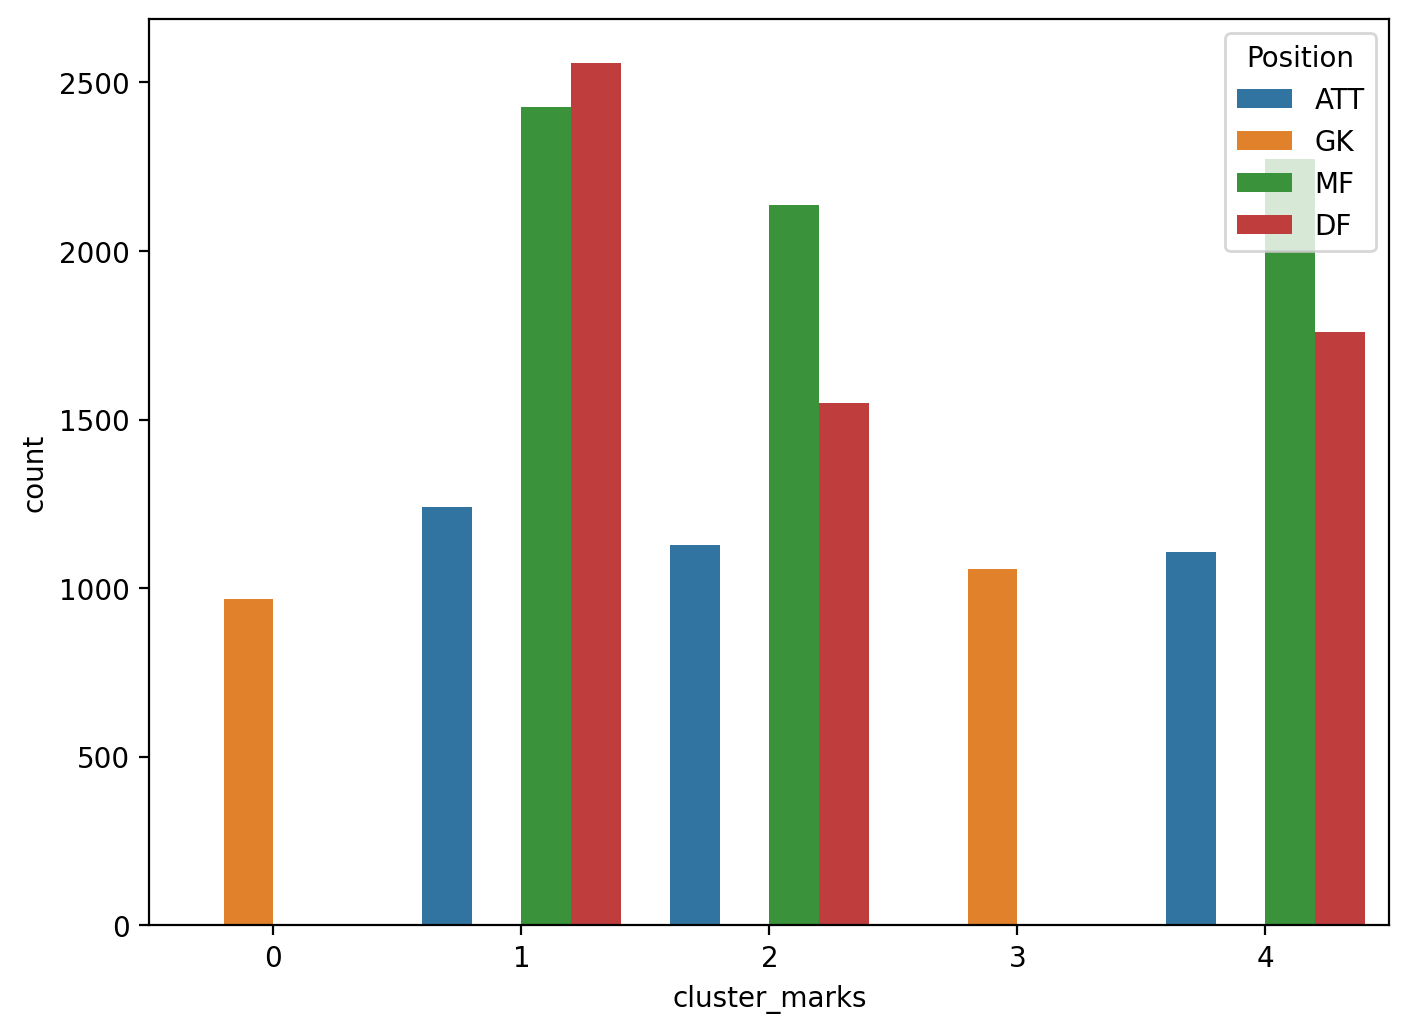

In [160]:
draw(df)

# Uklanjanje svih kolona koje golmane cine superiornijim od igraca

In [177]:
df[numeric].columns.values

array(['Unnamed: 0', 'ID', 'Age', 'Overall', 'Potential', 'Special',
       'International Reputation', 'Weak Foot', 'Skill Moves',
       'Jersey Number', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed',
       'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping',
       'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions',
       'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking',
       'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes'], dtype=object)

In [206]:
columns_to_drop = ['GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']

In [207]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [208]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 3274, (17.982094798703795 %)

NAPAD: 1631 (49.8167379352474 %)
Broj igraca na poziciji RF: 14, (0.42761148442272445 %)
Broj igraca na poziciji LF: 13, (0.3970678069639585 %)
Broj igraca na poziciji RW: 189, (5.77275503970678 %)
Broj igraca na poziciji LW: 188, (5.742211362248015 %)
Broj igraca na poziciji ST: 918, (28.03909590714722 %)
Broj igraca na poziciji CF: 37, (1.1301160659743432 %)
Broj igraca na poziciji RS: 131, (4.00122174709835 %)
Broj igraca na poziciji LS: 141, (4.306658521686011 %)

VEZNI RED: 1639 (50.06108735491753 %)
Broj igraca na poziciji RDM: 8, (0.2443494196701283 %)
Broj igraca na poziciji CDM: 2, (0.061087354917532075 %)
Broj igraca na poziciji LDM: 11, (0.3359804520464264 %)
Broj igraca na poziciji RM: 483, (14.752596212583995 %)
Broj igraca na poziciji RCM: 41, (1.2522907758094075 %)
Broj igraca na poziciji CM: 67, (2.0464263897373245 %)
Broj igraca na poziciji LCM: 61, (1.863164324984728 %)
Broj igraca na poziciji LM: 486, (14.844227

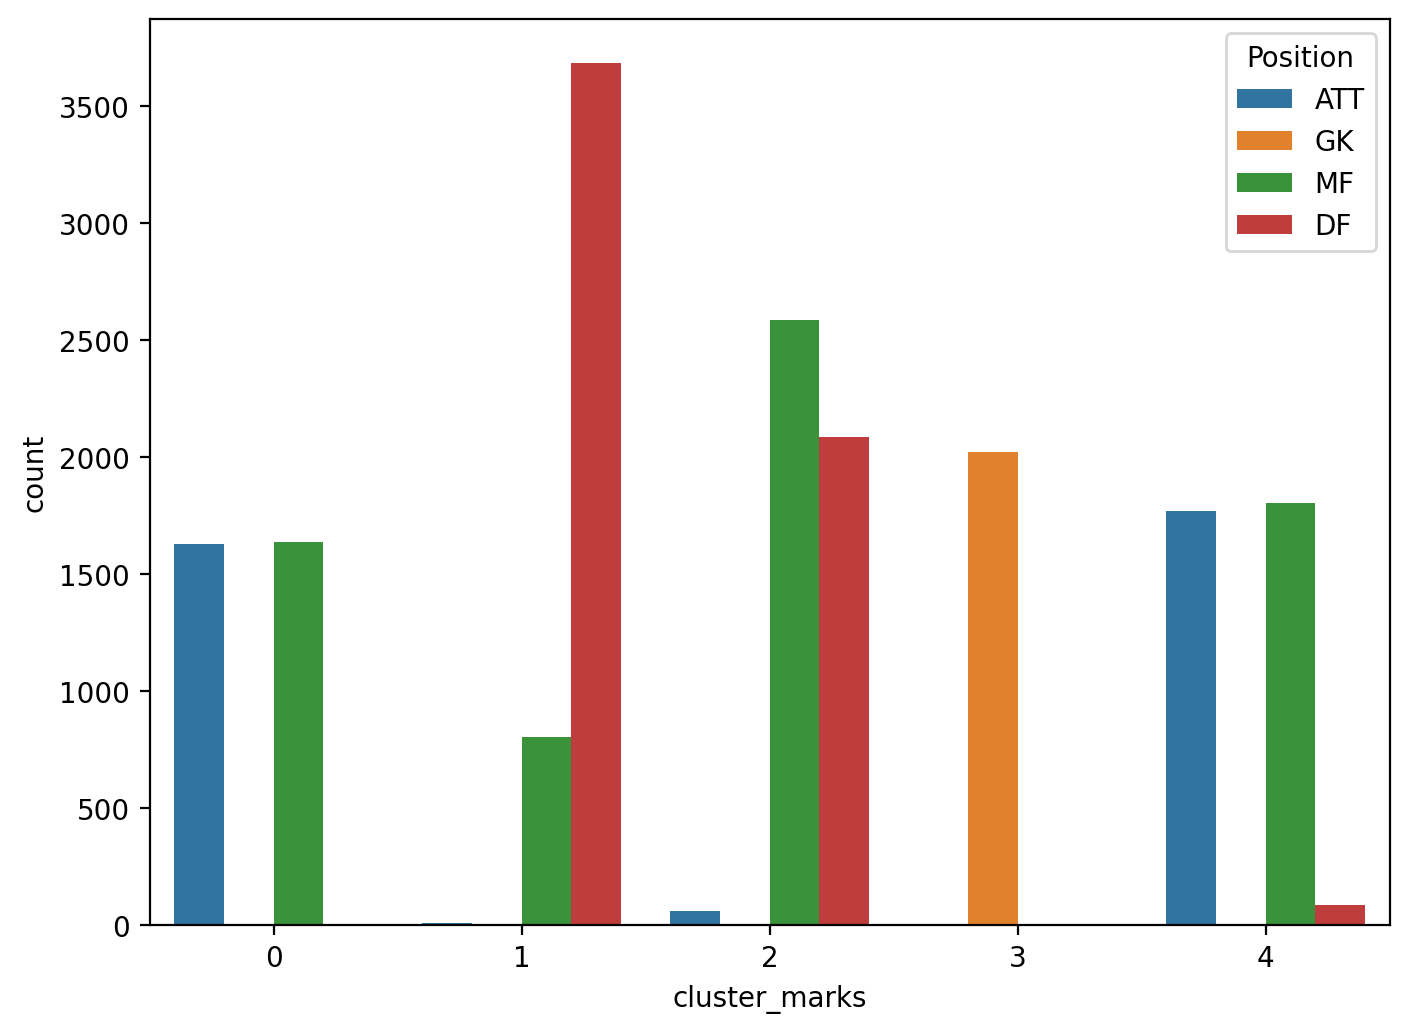

In [209]:
draw(df)

# Uklanjanje svih kolona kojima se golmani razlikuju od igraca

In [199]:
columns_to_drop = ['Special', 'Skill Moves', 'Crossing', 'Finishing', 'HeadingAccuracy',
                   'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
                   'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed',
                   'Agility', 'Balance', 'ShotPower', 'Stamina', 'LongShots', 
                   'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
                   'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
                   'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']

In [200]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric].drop(columns=columns_to_drop, axis=1))

KMeans(n_clusters=5, random_state=0)

In [201]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 1517, (8.331960235074423 %)

NAPAD: 336 (22.148978246539222 %)
Broj igraca na poziciji RF: 4, (0.26367831245880025 %)
Broj igraca na poziciji LF: 5, (0.3295978905735003 %)
Broj igraca na poziciji RW: 39, (2.5708635464733027 %)
Broj igraca na poziciji LW: 27, (1.7798286090969018 %)
Broj igraca na poziciji ST: 188, (12.392880685563611 %)
Broj igraca na poziciji CF: 10, (0.6591957811470006 %)
Broj igraca na poziciji RS: 30, (1.977587343441002 %)
Broj igraca na poziciji LS: 33, (2.175346077785102 %)

VEZNI RED: 602 (39.683586025049436 %)
Broj igraca na poziciji RDM: 24, (1.5820698747528017 %)
Broj igraca na poziciji CDM: 90, (5.932762030323006 %)
Broj igraca na poziciji LDM: 22, (1.4502307185234016 %)
Broj igraca na poziciji RM: 83, (5.471324983520105 %)
Broj igraca na poziciji RCM: 56, (3.691496374423204 %)
Broj igraca na poziciji CM: 91, (5.998681608437706 %)
Broj igraca na poziciji LCM: 56, (3.691496374423204 %)
Broj igraca na poziciji LM: 80, (5.27356624917600

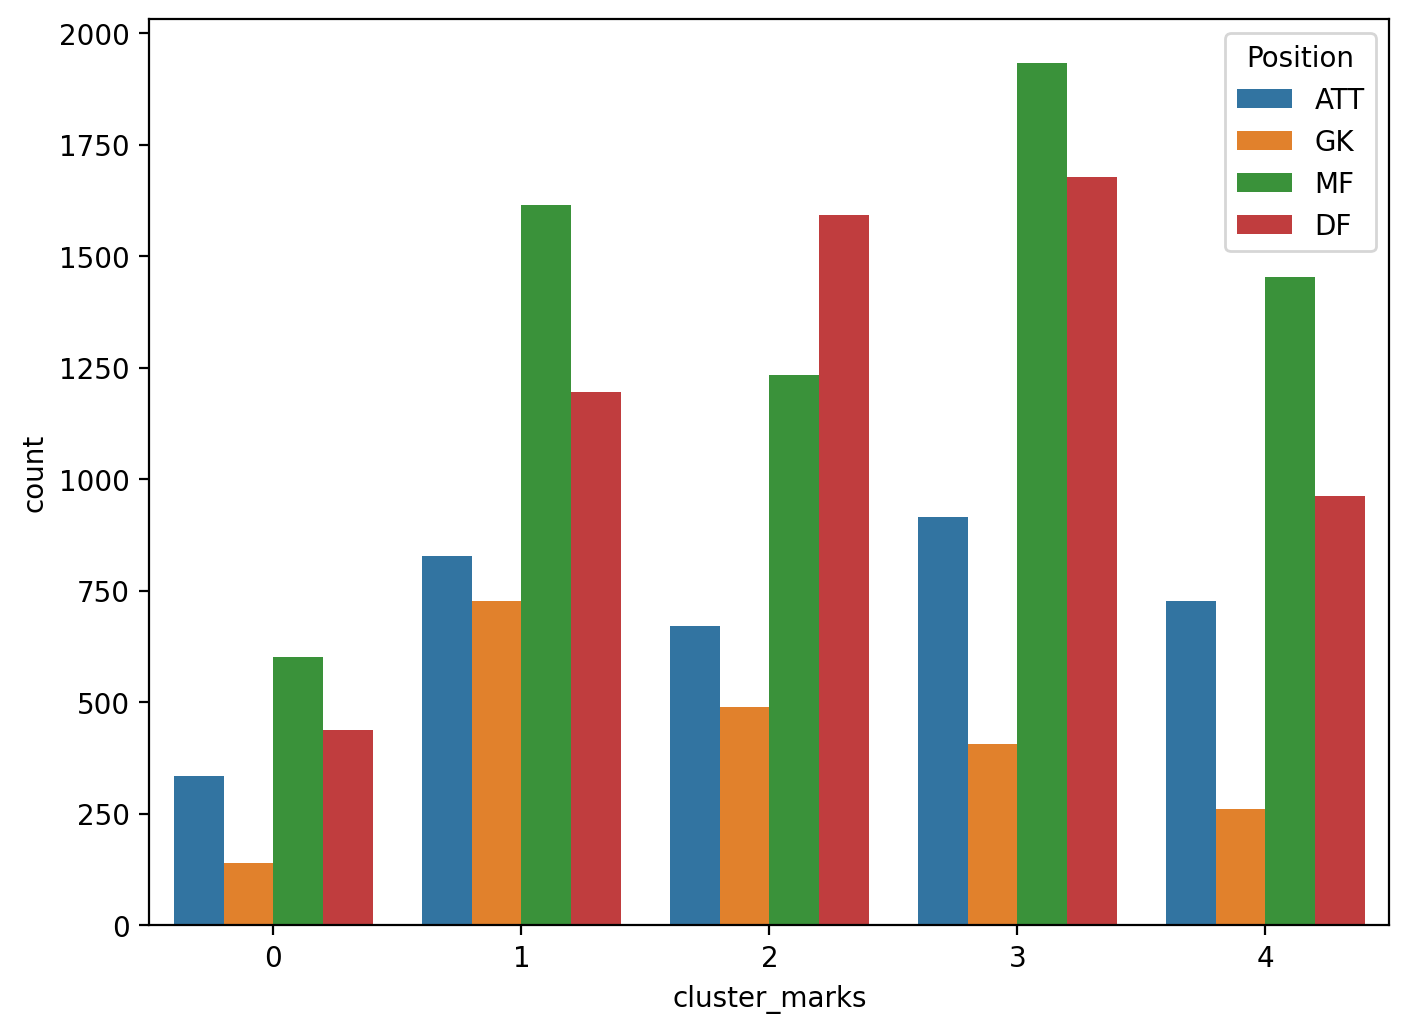

In [202]:
draw(df)

# 6.2.2021. Zasto je igrac ID=193911 svrstan u golmane?

In [ ]:
def find_irq_outliers(values):
    
    outliers = []
    sorted_values = sorted(values)
    min, max = np.percentile(sorted_values, [25, 75])
    irq_difference = max - min
    upper_border = max + 1.5 * irq_difference
    lower_border = min - 1.5 * irq_difference

    for value in sorted_values:
        if value < lower_border or value > upper_border:
            outliers.append(value)
    return outliers
        
outlier_numeric_columns = []
for numerical_variable in numeric:
    if len(find_irq_outliers(df[numerical_variable])):
        outlier_numeric_columns.append(numerical_variable)

outlier_numeric_columns

In [52]:
df.columns.values


array(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage',
       'Special', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Real Face',
       'Position', 'Jersey Number', 'Joined', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle',
       'SlidingTackle', 

In [62]:
df_temp = df.loc[df['Position'] == 'ST']

find_irq_outliers(df_temp['GKDiving'])
df_temp.loc[df_temp['GKDiving'] == 0.5842696629213483]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [64]:
find_irq_outliers(df_temp['GKHandling'])
df_temp.loc[df_temp['GKHandling'] == 0.5164835164835165]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [80]:
find_irq_outliers(df_temp['GKKicking'])
df_temp.loc[df_temp['GKKicking'] == 0.6777777777777778]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [69]:
find_irq_outliers(df_temp['GKPositioning'])
df_temp.loc[df_temp['GKPositioning'] == 0.6292134831460674]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [72]:
find_irq_outliers(df_temp['GKReflexes'])
df_temp.loc[df_temp['GKReflexes'] == 0.6344086021505377]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [73]:
find_irq_outliers(df_temp['Special'])

[0.18637770897832823,
 0.8513931888544892,
 0.8520123839009288,
 0.8637770897832817,
 0.879876160990712,
 0.8879256965944273,
 0.9269349845201238,
 0.958513931888545]

In [81]:
df_temp.loc[df_temp['Special'] == 0.18637770897832823]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [87]:
df_temp.loc[df_temp['Finishing'] == 0.19354838709677422]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [88]:
find_irq_outliers(df_temp['HeadingAccuracy'])

[0.12222222222222223,
 0.2888888888888889,
 0.32222222222222224,
 0.977777777777778,
 0.977777777777778,
 0.988888888888889,
 1.0]

In [90]:
df_temp.loc[df_temp['HeadingAccuracy'] == 0.12222222222222223]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [91]:
find_irq_outliers(df_temp['ShortPassing'])

[0.18604651162790695,
 0.24418604651162792,
 0.2674418604651163,
 0.2906976744186046,
 0.3023255813953488,
 0.883720930232558,
 0.883720930232558,
 0.8953488372093023,
 0.9069767441860465]

In [92]:
df_temp.loc[df_temp['ShortPassing'] == 0.18604651162790695]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [93]:
find_irq_outliers(df_temp['Volleys'])

[0.1511627906976744, 0.1744186046511628, 0.18604651162790697]

In [95]:
df_temp.loc[df_temp['Volleys'] == 0.1511627906976744]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [96]:
find_irq_outliers(df_temp['Dribbling'])

[0.10752688172043011,
 0.3655913978494624,
 0.3655913978494624,
 0.3763440860215054,
 0.3763440860215054,
 0.3763440860215054,
 0.3763440860215054,
 0.3763440860215054,
 0.3763440860215054,
 0.38709677419354843,
 0.870967741935484,
 0.870967741935484,
 0.870967741935484,
 0.870967741935484,
 0.870967741935484,
 0.881720430107527,
 0.881720430107527,
 0.881720430107527,
 0.881720430107527,
 0.89247311827957,
 0.89247311827957,
 0.903225806451613,
 0.913978494623656]

In [97]:
df_temp.loc[df_temp['Dribbling'] == 0.10752688172043011]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [105]:
df_temp.loc[df_temp['BallControl'] == 0.08791208791208793]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [137]:
find_irq_outliers(df_temp['ShotPower'])

[0.11827956989247312,
 0.23655913978494622,
 0.23655913978494622,
 0.31182795698924737,
 0.38709677419354843,
 0.9677419354838711,
 1.0]

In [138]:
df_temp.loc[df_temp['ShotPower'] == 0.11827956989247312]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [145]:
find_irq_outliers(df_temp['LongShots'])

[0.14285714285714288,
 0.19780219780219782,
 0.20879120879120883,
 0.28571428571428575,
 0.28571428571428575,
 0.29670329670329676,
 0.3076923076923077,
 0.3186813186813187,
 0.3516483516483517,
 0.3516483516483517,
 0.8791208791208792,
 0.8901098901098902,
 0.8901098901098902,
 0.9010989010989012,
 0.9010989010989012,
 0.967032967032967,
 0.9890109890109892]

In [146]:
df_temp.loc[df_temp['LongShots'] == 0.14285714285714288]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

In [148]:
find_irq_outliers(df_temp['Interceptions'])

[0.6179775280898877,
 0.6179775280898877,
 0.6179775280898877,
 0.6179775280898877,
 0.6179775280898877,
 0.6179775280898877,
 0.6179775280898877,
 0.6292134831460674,
 0.6292134831460674,
 0.6292134831460674,
 0.6292134831460674,
 0.6292134831460674,
 0.6292134831460674,
 0.6404494382022472,
 0.6404494382022472,
 0.651685393258427,
 0.651685393258427,
 0.6629213483146067,
 0.6629213483146067,
 0.6741573033707865,
 0.6741573033707865,
 0.6741573033707865,
 0.6853932584269663,
 0.6966292134831461,
 0.6966292134831461,
 0.7078651685393259,
 0.7078651685393259,
 0.7191011235955056]

In [149]:
df_temp.loc[df_temp['Interceptions'] == 0.6179775280898877]

Unnamed: 0      ID             Name       Age  \
3525         3525  158309          Gao Lin  0.551724   
5197         5197  232318       Waguininho  0.413793   
5497         5497  198611        N. ?ur?i?  0.551724   
6349         6349  202175  M. Vilhjálmsson  0.517241   
9298         9298  191861    Dong Xuesheng  0.448276   
9608         9608  202169          J. Gatt  0.344828   
16539       16539  245167  L. Lalruatthara  0.241379   

                                                Photo    Nationality  \
3525   https://cdn.sofifa.org/players/4/19/158309.png       China PR   
5197   https://cdn.sofifa.org/players/4/19/232318.png         Brazil   
5497   https://cdn.sofifa.org/players/4/19/198611.png         Serbia   
6349   https://cdn.sofifa.org/players/4/19/202175.png        Iceland   
9298   https://cdn.sofifa.org/players/4/19/191861.png       China PR   
9608   https://cdn.sofifa.org/players/4/19/202169.png  United States   
16539  https://cdn.sofifa.org/players/4/19/245167.png          India   

                                       Flag   Overall  Potential  \
3525   https://cdn.sofifa.org/flags/155.png  0.541667   0.510638   
5197    https://cdn.sofifa.org/flags/54.png  0.500000   0.468085   
5497    https://cdn.sofifa.org/flags/51.png  0.500000   0.468085   
6349    https://cdn.sofifa.org/flags/24.png  0.479167   0.446809   
9298   https://cdn.sofifa.org/flags/155.png  0.416667   0.382979   
9608    https://cdn.sofifa.org/flags/95.png  0.416667   0.382979   
16539  https://cdn.sofifa.org/flags/159.png  0.229167   0.319149   

                                 Club  ...   Marking StandingTackle  \
3525   Guangzhou Evergrande Taobao FC  ...  0.428571       0.549451   
5197          Suwon Samsung Bluewings  ...  0.461538       0.538462   
5497                      Hammarby IF  ...  0.505495       0.516484   
6349                     Rosenborg BK  ...  0.604396       0.648352   
9298           Hebei China Fortune FC  ...  0.395604       0.131868   
9608                       SCR Altach  ...  0.395604       0.472527   
16539                       AS Monaco  ...  0.626374       0.648352   

      SlidingTackle  GKDiving GKHandling  GKKicking  GKPositioning  \
3525       0.545455  0.101124   0.087912   0.066667       0.112360   
5197       0.488636  0.134831   0.065934   0.111111       0.067416   
5497       0.465909  0.112360   0.164835   0.088889       0.134831   
6349       0.579545  0.056180   0.164835   0.144444       0.146067   
9298       0.170455  0.123596   0.142857   0.088889       0.067416   
9608       0.443182  0.123596   0.120879   0.133333       0.134831   
16539      0.613636  0.157303   0.120879   0.111111       0.056180   

       GKReflexes Release Clause cluster_marks  
3525     0.086022          5.4M             3  
5197     0.129032          2.3M             3  
5497     0.053763          1.8M             3  
6349     0.150538          1.2M             4  
9298     0.096774          1.4M             1  
9608     0.086022            1M             3  
16539    0.118280          1.1M             0  

[7 rows x 89 columns]

In [150]:
find_irq_outliers(df_temp['Positioning'])

[0.1075268817204301,
 0.2580645161290323,
 0.2580645161290323,
 0.35483870967741943,
 0.37634408602150543,
 0.37634408602150543,
 0.38709677419354843,
 0.9569892473118281,
 0.9569892473118281,
 0.9677419354838711,
 0.9677419354838711,
 0.978494623655914,
 1.0]

In [151]:
df_temp.loc[df_temp['Positioning'] == 0.1075268817204301]

Unnamed: 0      ID     Name       Age  \
16450       16450  193911  S. Paul  0.517241   

                                                Photo Nationality  \
16450  https://cdn.sofifa.org/players/4/19/193911.png       India   

                                       Flag   Overall  Potential       Club  \
16450  https://cdn.sofifa.org/flags/159.png  0.229167   0.191489  AS Monaco   

       ...   Marking StandingTackle SlidingTackle  GKDiving GKHandling  \
16450  ...  0.098901       0.142857      0.102273   0.58427   0.516484   

       GKKicking  GKPositioning  GKReflexes Release Clause cluster_marks  
16450   0.677778       0.629213    0.634409          1.1M             2  

[1 rows x 89 columns]

## Da li ce zamenom outlier parametara median vrednoscu odgovarajucih kolona k-means algoritam prestati igraca ID=193911 da svrstava u golmane?


In [246]:
df.loc[df['ID'] == 193911, 'GKDiving'] = df_temp['GKDiving'].median()

In [247]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric])

KMeans(n_clusters=5, random_state=0)

In [248]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 3544, (19.465040918328118 %)

NAPAD: 1937 (54.65575620767494 %)
Broj igraca na poziciji RF: 1, (0.02821670428893905 %)
Broj igraca na poziciji LF: 1, (0.02821670428893905 %)
Broj igraca na poziciji RW: 165, (4.655756207674944 %)
Broj igraca na poziciji LW: 171, (4.8250564334085775 %)
Broj igraca na poziciji ST: 1400, (39.503386004514674 %)
Broj igraca na poziciji CF: 39, (1.100451467268623 %)
Broj igraca na poziciji RS: 78, (2.200902934537246 %)
Broj igraca na poziciji LS: 82, (2.3137697516930023 %)

VEZNI RED: 1568 (44.24379232505643 %)
Broj igraca na poziciji RDM: 6, (0.16930022573363432 %)
Broj igraca na poziciji CDM: 8, (0.2257336343115124 %)
Broj igraca na poziciji LDM: 6, (0.16930022573363432 %)
Broj igraca na poziciji RM: 444, (12.528216704288939 %)
Broj igraca na poziciji RCM: 18, (0.5079006772009029 %)
Broj igraca na poziciji CM: 300, (8.465011286681715 %)
Broj igraca na poziciji LCM: 25, (0.7054176072234764 %)
Broj igraca na poziciji LM: 418, (11.794

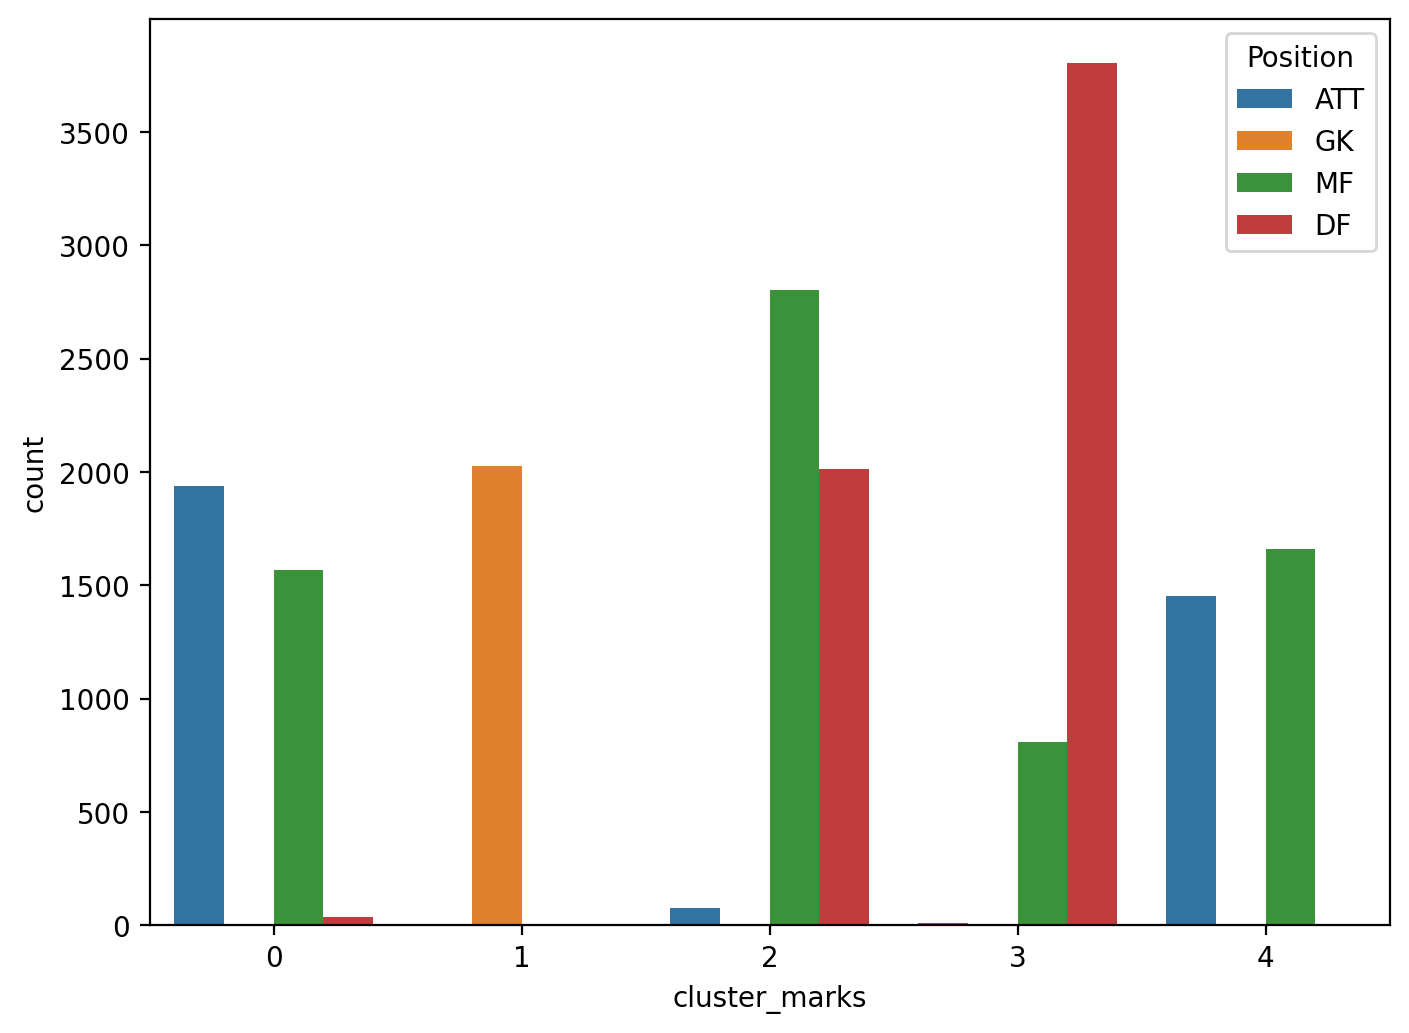

In [249]:
draw(df)

In [250]:
df.loc[df['ID'] == 193911, 'GKHandling'] = df_temp['GKHandling'].median()

In [251]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric])

KMeans(n_clusters=5, random_state=0)

In [252]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 3544, (19.465040918328118 %)

NAPAD: 1937 (54.65575620767494 %)
Broj igraca na poziciji RF: 1, (0.02821670428893905 %)
Broj igraca na poziciji LF: 1, (0.02821670428893905 %)
Broj igraca na poziciji RW: 165, (4.655756207674944 %)
Broj igraca na poziciji LW: 171, (4.8250564334085775 %)
Broj igraca na poziciji ST: 1400, (39.503386004514674 %)
Broj igraca na poziciji CF: 39, (1.100451467268623 %)
Broj igraca na poziciji RS: 78, (2.200902934537246 %)
Broj igraca na poziciji LS: 82, (2.3137697516930023 %)

VEZNI RED: 1568 (44.24379232505643 %)
Broj igraca na poziciji RDM: 6, (0.16930022573363432 %)
Broj igraca na poziciji CDM: 8, (0.2257336343115124 %)
Broj igraca na poziciji LDM: 6, (0.16930022573363432 %)
Broj igraca na poziciji RM: 444, (12.528216704288939 %)
Broj igraca na poziciji RCM: 18, (0.5079006772009029 %)
Broj igraca na poziciji CM: 300, (8.465011286681715 %)
Broj igraca na poziciji LCM: 25, (0.7054176072234764 %)
Broj igraca na poziciji LM: 418, (11.794

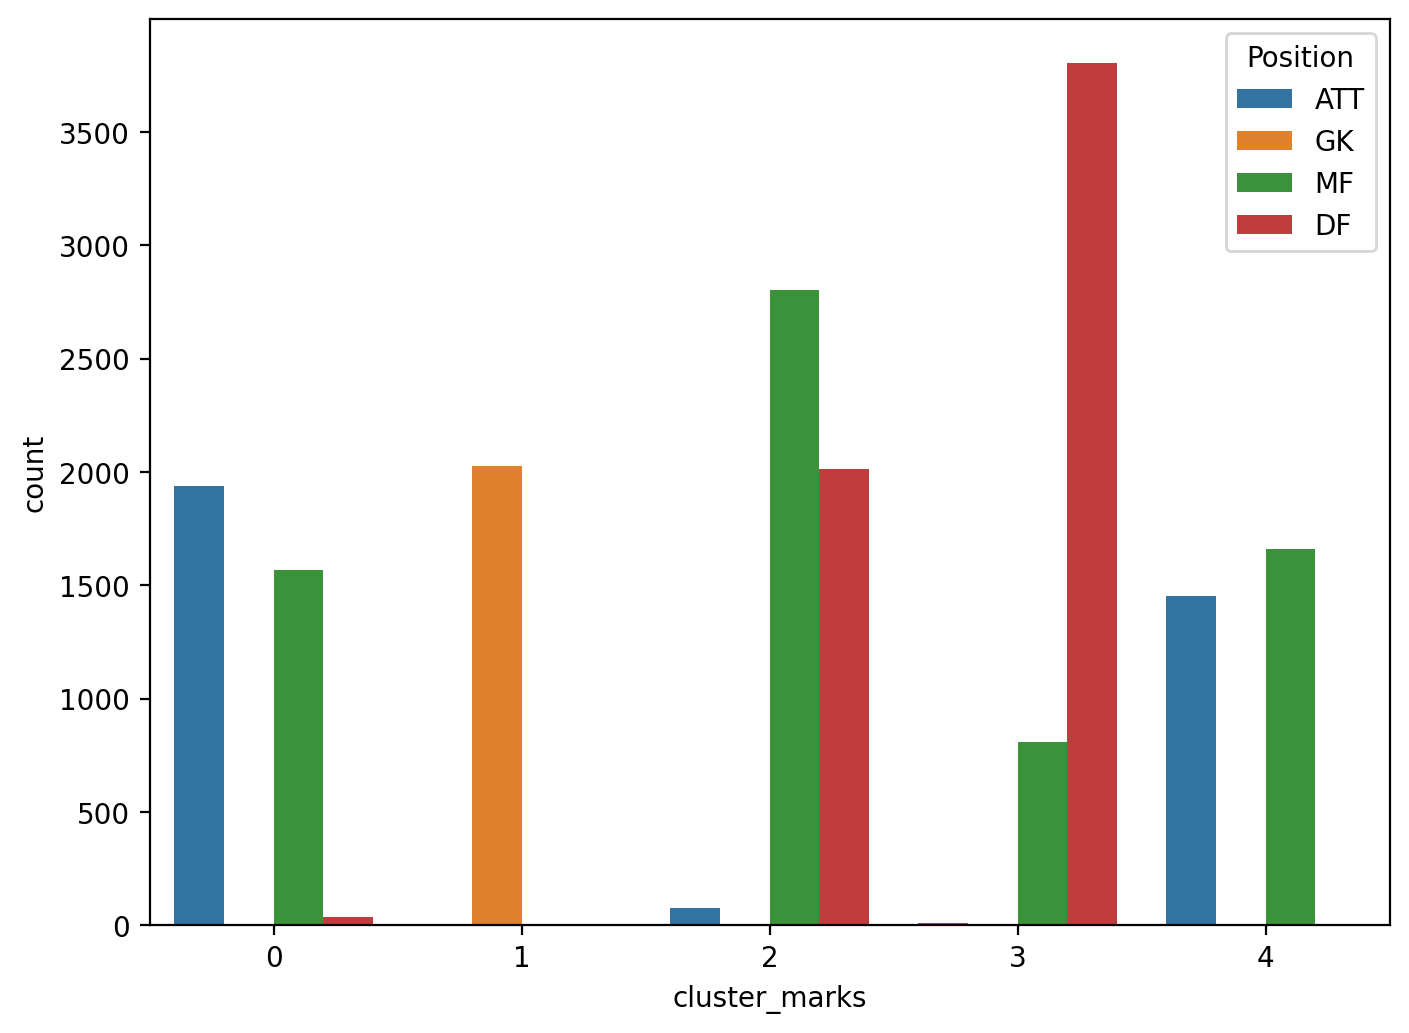

In [253]:
draw(df)

In [254]:
df.loc[df['ID'] == 193911, 'GKKicking'] = df_temp['GKKicking'].median()

In [255]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric])

KMeans(n_clusters=5, random_state=0)

In [256]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 4626, (25.40781018289669 %)

NAPAD: 10 (0.21616947686986598 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 10, (0.21616947686986598 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 809 (17.488110678772156 %)
Broj igraca na poziciji RDM: 37, (0.799827064418504 %)
Broj igraca na poziciji CDM: 355, (7.674016428880242 %)
Broj igraca na poziciji LDM: 37, (0.799827064418504 %)
Broj igraca na poziciji RM: 27, (0.5836575875486382 %)
Broj igraca na poziciji RCM: 35, (0.7565931690445309 %)
Broj igraca na poziciji CM: 255, (5.512321660181582 %)
Broj igraca na poziciji LCM: 31, (0.6701253782965845 %)
Broj igraca na poziciji LM: 24, (0.5188067444876783 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 8, (0.17293558149589278 %)
Broj

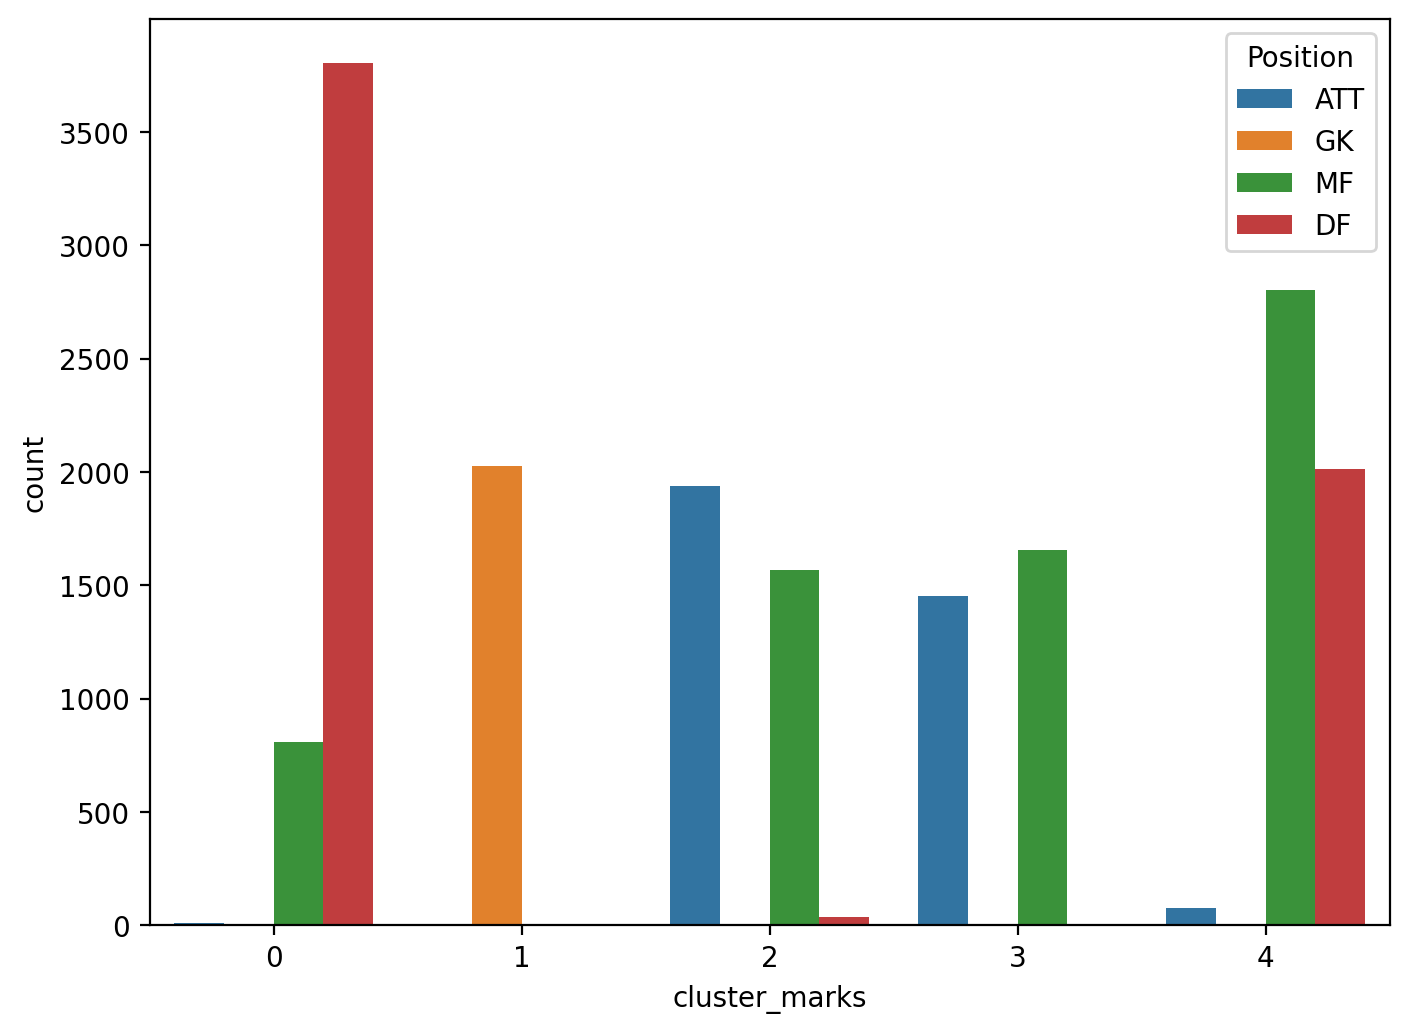

In [257]:
draw(df)

In [258]:
df.loc[df['ID'] == 193911, 'GKPositioning'] = df_temp['GKPositioning'].median()

In [259]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric])

KMeans(n_clusters=5, random_state=0)

In [260]:
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 2026, (11.127588290218048 %)

NAPAD: 1 (0.04935834155972359 %)
Broj igraca na poziciji RF: 0, (0.0 %)
Broj igraca na poziciji LF: 0, (0.0 %)
Broj igraca na poziciji RW: 0, (0.0 %)
Broj igraca na poziciji LW: 0, (0.0 %)
Broj igraca na poziciji ST: 1, (0.04935834155972359 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 0, (0.0 %)
Broj igraca na poziciji LS: 0, (0.0 %)

VEZNI RED: 0 (0.0 %)
Broj igraca na poziciji RDM: 0, (0.0 %)
Broj igraca na poziciji CDM: 0, (0.0 %)
Broj igraca na poziciji LDM: 0, (0.0 %)
Broj igraca na poziciji RM: 0, (0.0 %)
Broj igraca na poziciji RCM: 0, (0.0 %)
Broj igraca na poziciji CM: 0, (0.0 %)
Broj igraca na poziciji LCM: 0, (0.0 %)
Broj igraca na poziciji LM: 0, (0.0 %)
Broj igraca na poziciji RAM: 0, (0.0 %)
Broj igraca na poziciji CAM: 0, (0.0 %)
Broj igraca na poziciji LAM: 0, (0.0 %)

ODBRANA: 0 (0.0 %)
Broj igraca na poziciji RWB: 0, (0.0 %)
Broj igraca na poziciji RB: 0, (0.0 %)
Broj igraca na poziciji R

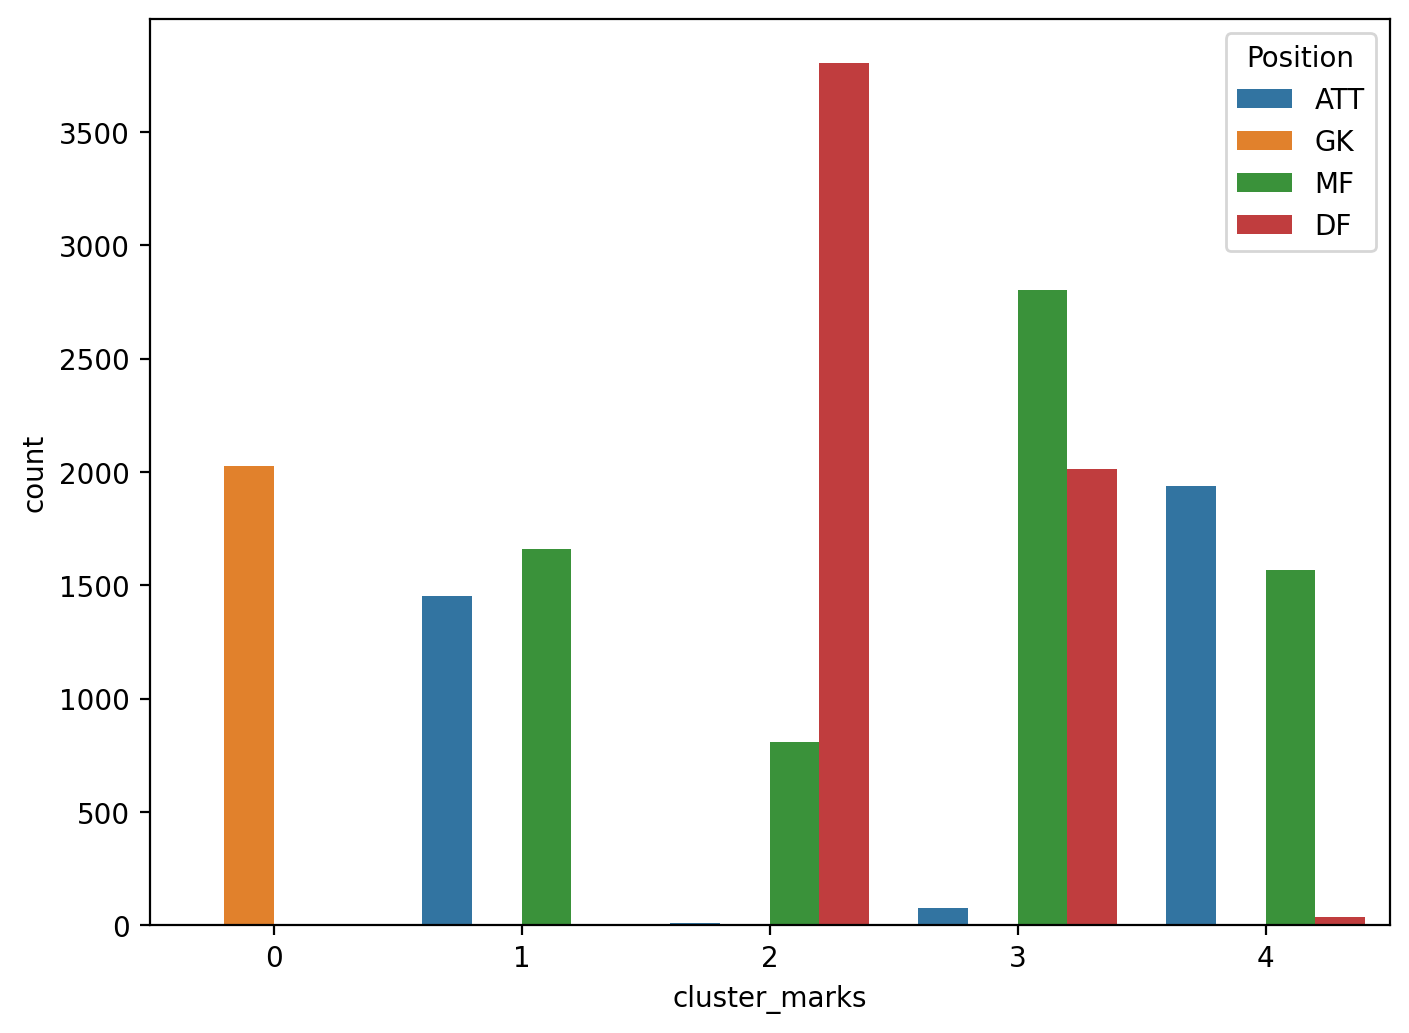

In [261]:
draw(df)

In [262]:
df.loc[df['ID'] == 193911, 'GKReflexes'] = df_temp['GKReflexes'].median()

In [263]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric])
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 4894, (26.87977151644972 %)

NAPAD: 77 (1.5733551287290561 %)
Broj igraca na poziciji RF: 1, (0.02043318348998774 %)
Broj igraca na poziciji LF: 1, (0.02043318348998774 %)
Broj igraca na poziciji RW: 23, (0.469963220269718 %)
Broj igraca na poziciji LW: 25, (0.5108295872496935 %)
Broj igraca na poziciji ST: 21, (0.4290968532897425 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 4, (0.08173273395995095 %)
Broj igraca na poziciji LS: 2, (0.04086636697997548 %)

VEZNI RED: 2802 (57.25378013894564 %)
Broj igraca na poziciji RDM: 197, (4.025337147527585 %)
Broj igraca na poziciji CDM: 583, (11.912545974662853 %)
Broj igraca na poziciji LDM: 188, (3.8414384961176955 %)
Broj igraca na poziciji RM: 176, (3.5962402942378424 %)
Broj igraca na poziciji RCM: 293, (5.986922762566408 %)
Broj igraca na poziciji CM: 759, (15.508786268900696 %)
Broj igraca na poziciji LCM: 276, (5.639558643236616 %)
Broj igraca na poziciji LM: 179, (3.657539844707806 %)
B

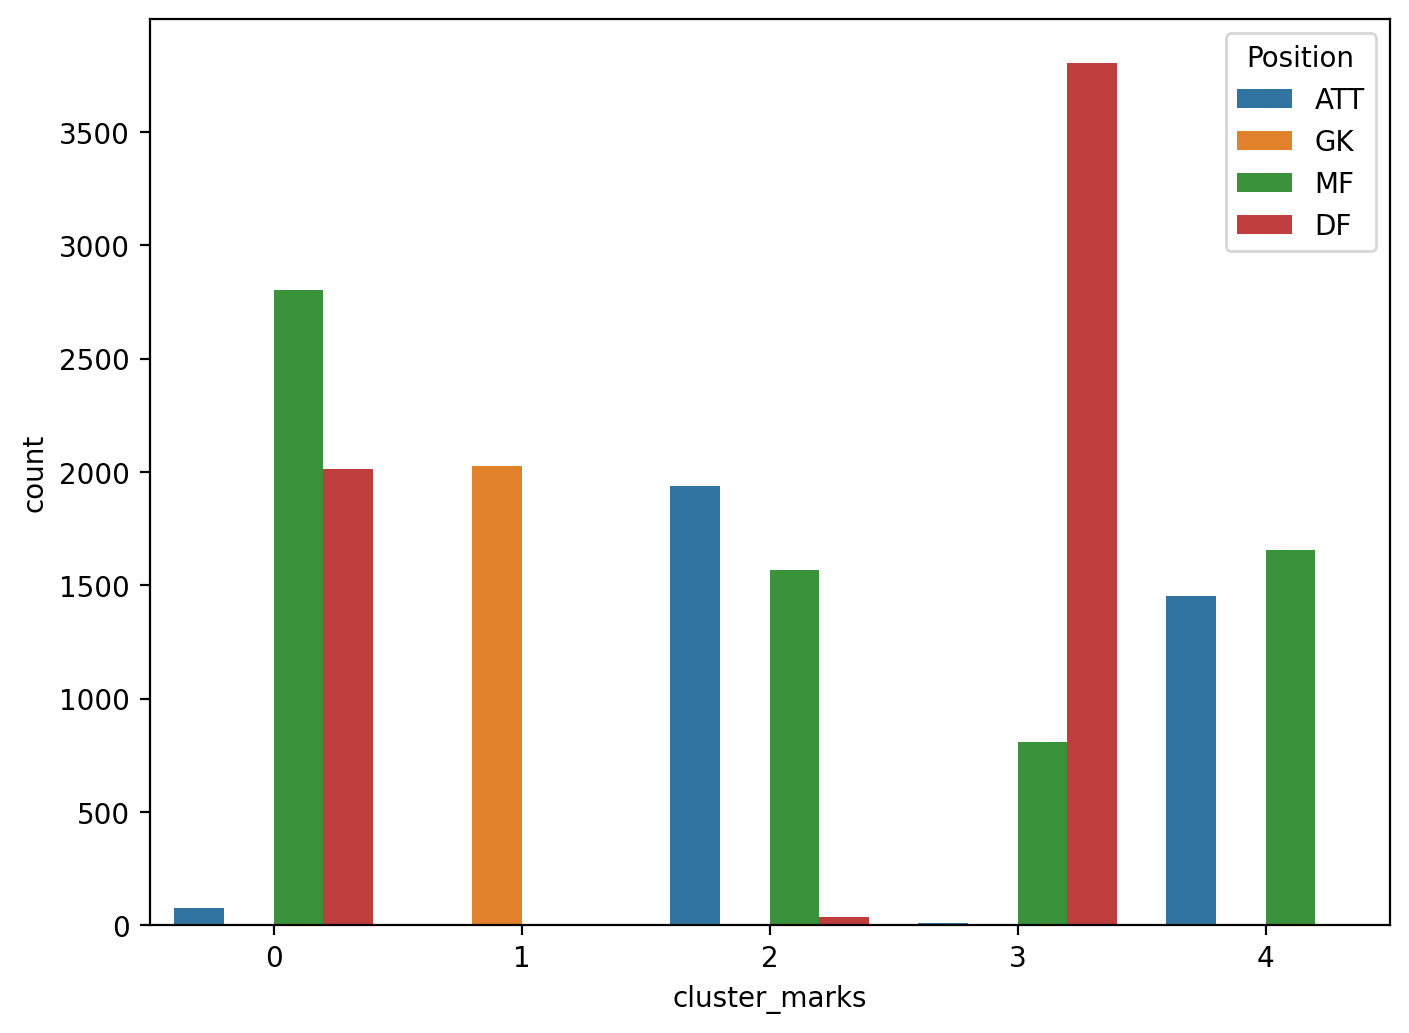

In [264]:
draw(df)

In [265]:
df.loc[df['ID'] == 193911, 'Special'] = df_temp['Special'].median()

In [266]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric])
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 4894, (26.87977151644972 %)

NAPAD: 77 (1.5733551287290561 %)
Broj igraca na poziciji RF: 1, (0.02043318348998774 %)
Broj igraca na poziciji LF: 1, (0.02043318348998774 %)
Broj igraca na poziciji RW: 23, (0.469963220269718 %)
Broj igraca na poziciji LW: 25, (0.5108295872496935 %)
Broj igraca na poziciji ST: 21, (0.4290968532897425 %)
Broj igraca na poziciji CF: 0, (0.0 %)
Broj igraca na poziciji RS: 4, (0.08173273395995095 %)
Broj igraca na poziciji LS: 2, (0.04086636697997548 %)

VEZNI RED: 2802 (57.25378013894564 %)
Broj igraca na poziciji RDM: 197, (4.025337147527585 %)
Broj igraca na poziciji CDM: 583, (11.912545974662853 %)
Broj igraca na poziciji LDM: 188, (3.8414384961176955 %)
Broj igraca na poziciji RM: 176, (3.5962402942378424 %)
Broj igraca na poziciji RCM: 293, (5.986922762566408 %)
Broj igraca na poziciji CM: 759, (15.508786268900696 %)
Broj igraca na poziciji LCM: 276, (5.639558643236616 %)
Broj igraca na poziciji LM: 179, (3.657539844707806 %)
B

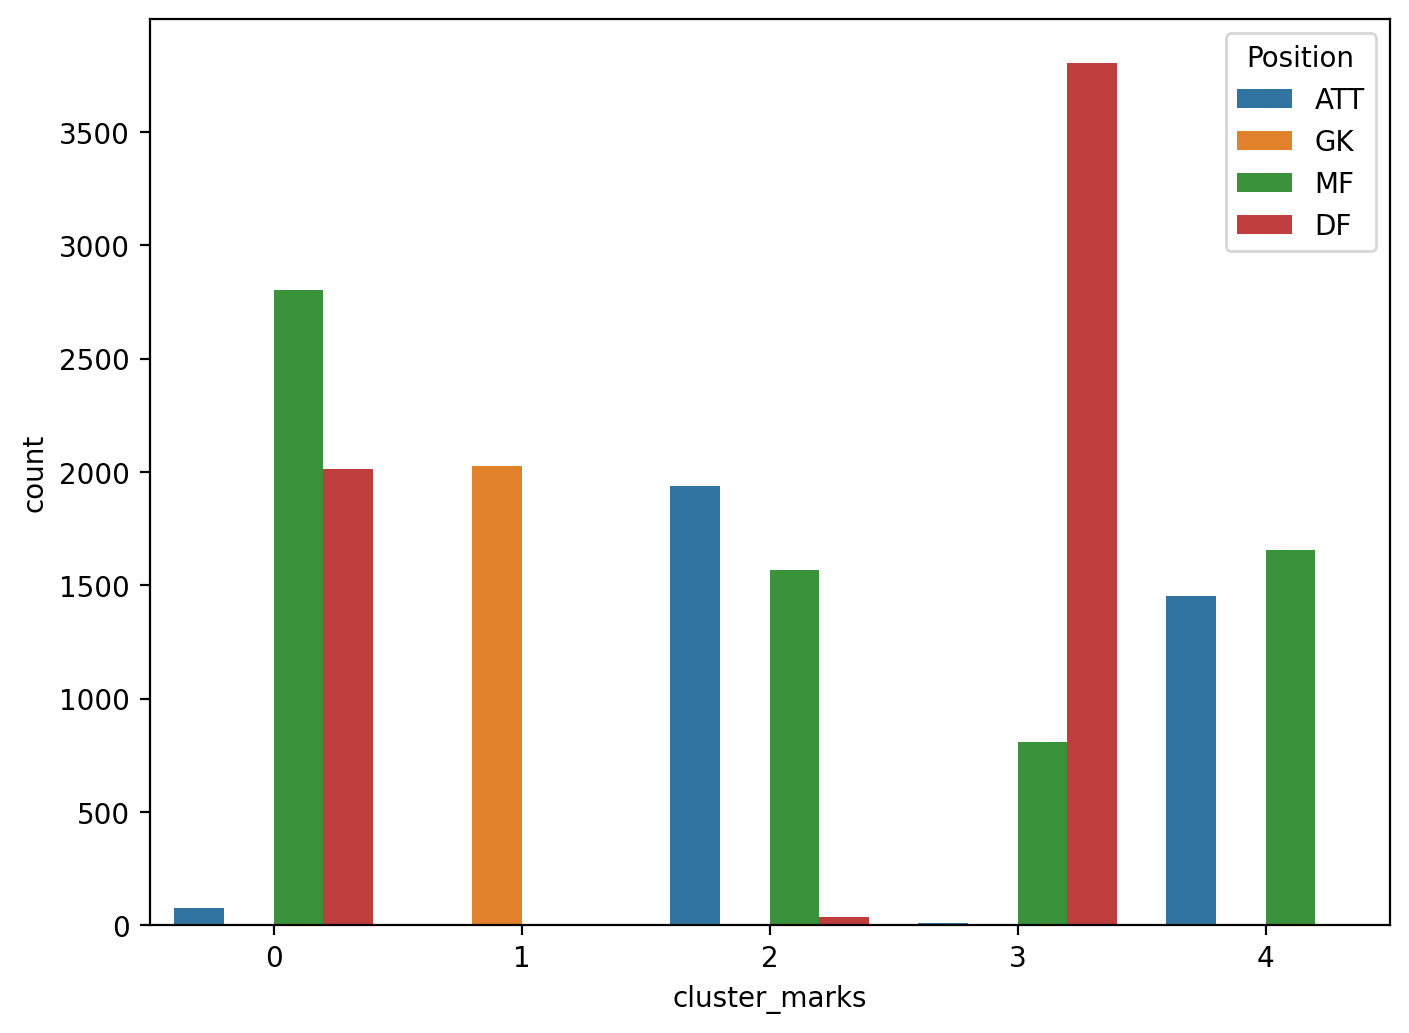

In [267]:
draw(df)

In [268]:
df.loc[df['ID'] == 193911, 'Finishing'] = df_temp['Finishing'].median()

In [269]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric])
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 3117, (17.119789092107432 %)

NAPAD: 1453 (46.61533525826115 %)
Broj igraca na poziciji RF: 14, (0.44914982354828364 %)
Broj igraca na poziciji LF: 13, (0.4170676932948348 %)
Broj igraca na poziciji RW: 182, (5.838947706127687 %)
Broj igraca na poziciji LW: 185, (5.935194096888034 %)
Broj igraca na poziciji ST: 780, (25.02406159769009 %)
Broj igraca na poziciji CF: 35, (1.122874558870709 %)
Broj igraca na poziciji RS: 121, (3.881937760667308 %)
Broj igraca na poziciji LS: 123, (3.946102021174206 %)

VEZNI RED: 1659 (53.22425409047161 %)
Broj igraca na poziciji RDM: 8, (0.25665704202759065 %)
Broj igraca na poziciji CDM: 2, (0.06416426050689766 %)
Broj igraca na poziciji LDM: 12, (0.384985563041386 %)
Broj igraca na poziciji RM: 477, (15.30317613089509 %)
Broj igraca na poziciji RCM: 45, (1.4436958614051971 %)
Broj igraca na poziciji CM: 80, (2.5665704202759065 %)
Broj igraca na poziciji LCM: 63, (2.021174205967276 %)
Broj igraca na poziciji LM: 474, (15.206929

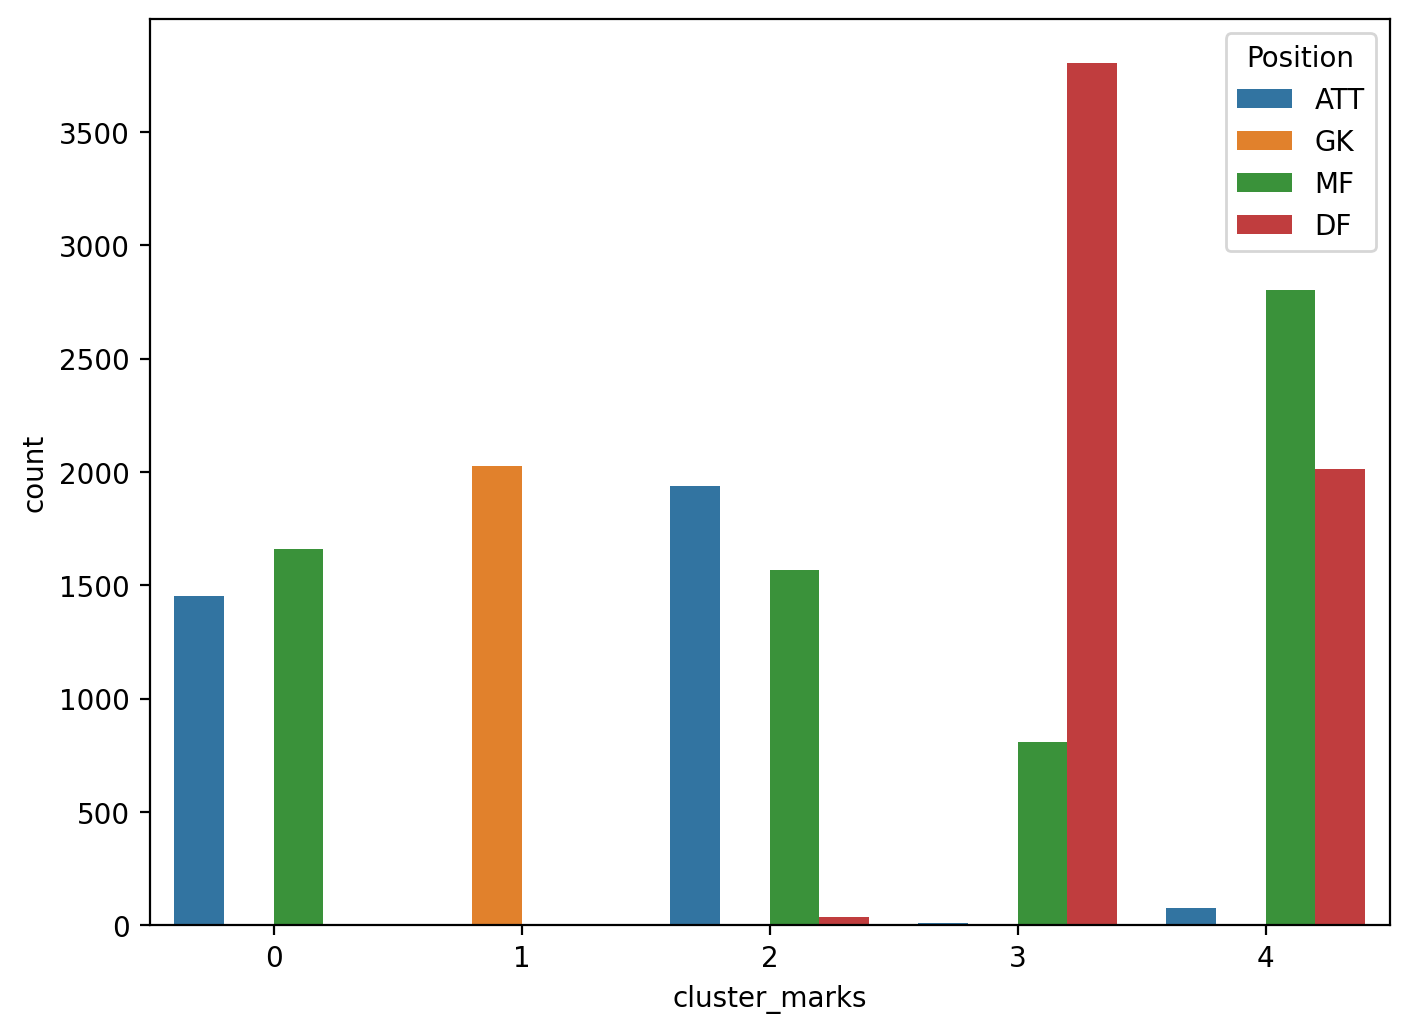

In [270]:
draw(df)

In [271]:
df.loc[df['ID'] == 193911, 'HeadingAccuracy'] = df_temp['HeadingAccuracy'].median()

In [272]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric])
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 3117, (17.119789092107432 %)

NAPAD: 1453 (46.61533525826115 %)
Broj igraca na poziciji RF: 14, (0.44914982354828364 %)
Broj igraca na poziciji LF: 13, (0.4170676932948348 %)
Broj igraca na poziciji RW: 182, (5.838947706127687 %)
Broj igraca na poziciji LW: 185, (5.935194096888034 %)
Broj igraca na poziciji ST: 780, (25.02406159769009 %)
Broj igraca na poziciji CF: 35, (1.122874558870709 %)
Broj igraca na poziciji RS: 121, (3.881937760667308 %)
Broj igraca na poziciji LS: 123, (3.946102021174206 %)

VEZNI RED: 1659 (53.22425409047161 %)
Broj igraca na poziciji RDM: 8, (0.25665704202759065 %)
Broj igraca na poziciji CDM: 2, (0.06416426050689766 %)
Broj igraca na poziciji LDM: 12, (0.384985563041386 %)
Broj igraca na poziciji RM: 477, (15.30317613089509 %)
Broj igraca na poziciji RCM: 45, (1.4436958614051971 %)
Broj igraca na poziciji CM: 80, (2.5665704202759065 %)
Broj igraca na poziciji LCM: 63, (2.021174205967276 %)
Broj igraca na poziciji LM: 474, (15.206929

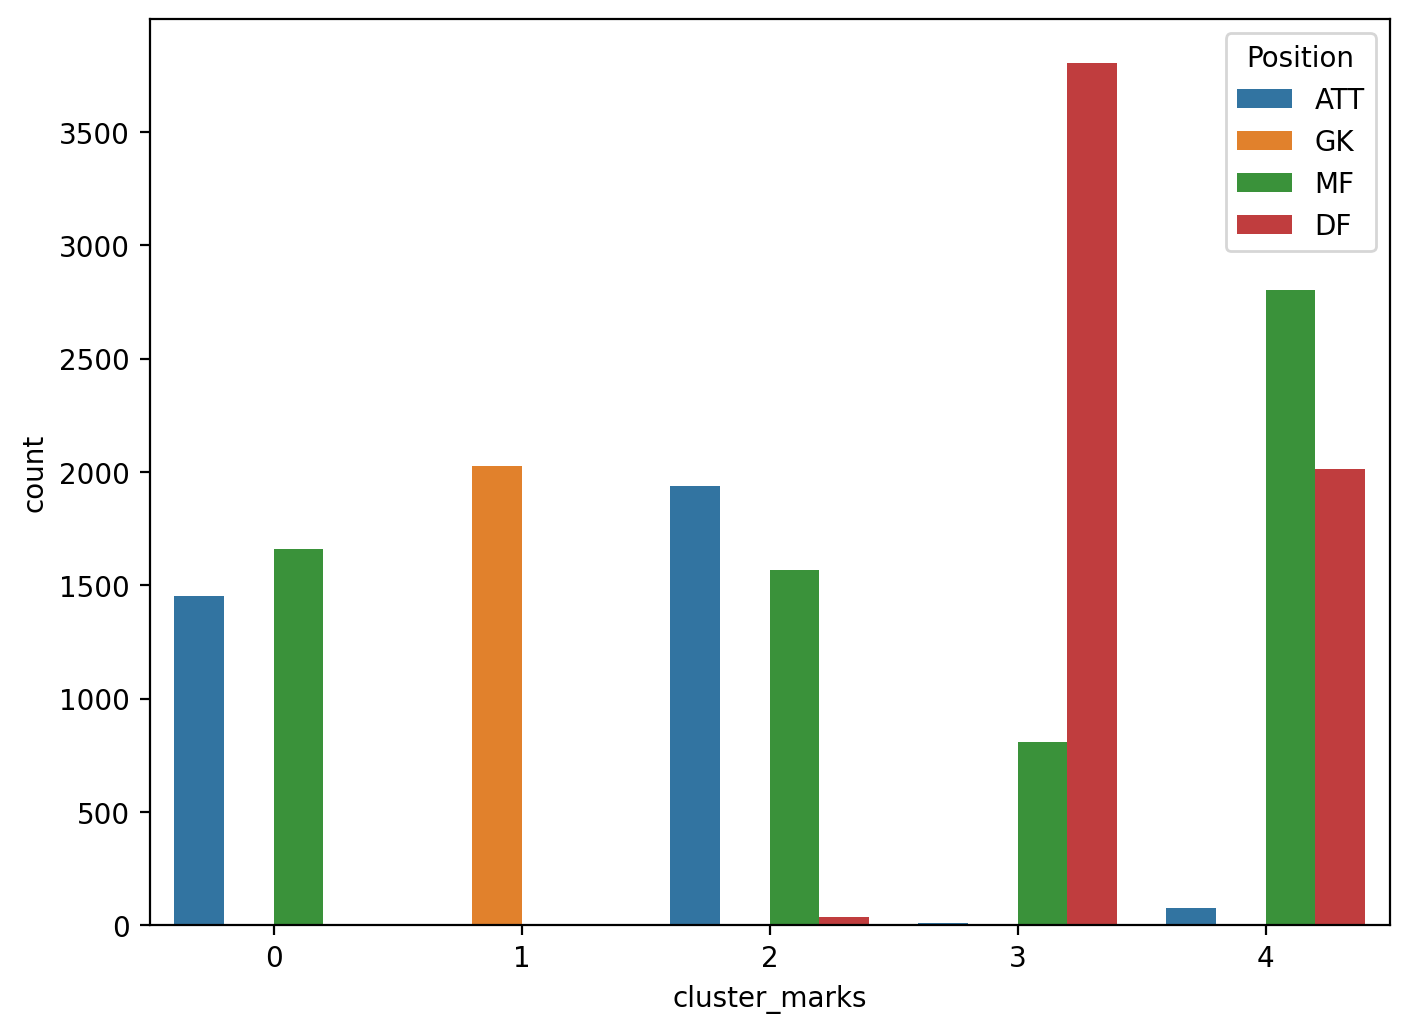

In [273]:
draw(df)

In [274]:
df.loc[df['ID'] == 193911, 'ShotPower'] = df_temp['ShotPower'].median()

In [275]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(df[numeric])
print_percentige_of_five_clusters(df)

Broj igraca u klasteru 0: 3544, (19.465040918328118 %)

NAPAD: 1937 (54.65575620767494 %)
Broj igraca na poziciji RF: 1, (0.02821670428893905 %)
Broj igraca na poziciji LF: 1, (0.02821670428893905 %)
Broj igraca na poziciji RW: 165, (4.655756207674944 %)
Broj igraca na poziciji LW: 171, (4.8250564334085775 %)
Broj igraca na poziciji ST: 1400, (39.503386004514674 %)
Broj igraca na poziciji CF: 39, (1.100451467268623 %)
Broj igraca na poziciji RS: 78, (2.200902934537246 %)
Broj igraca na poziciji LS: 82, (2.3137697516930023 %)

VEZNI RED: 1568 (44.24379232505643 %)
Broj igraca na poziciji RDM: 6, (0.16930022573363432 %)
Broj igraca na poziciji CDM: 8, (0.2257336343115124 %)
Broj igraca na poziciji LDM: 6, (0.16930022573363432 %)
Broj igraca na poziciji RM: 444, (12.528216704288939 %)
Broj igraca na poziciji RCM: 18, (0.5079006772009029 %)
Broj igraca na poziciji CM: 300, (8.465011286681715 %)
Broj igraca na poziciji LCM: 25, (0.7054176072234764 %)
Broj igraca na poziciji LM: 418, (11.794

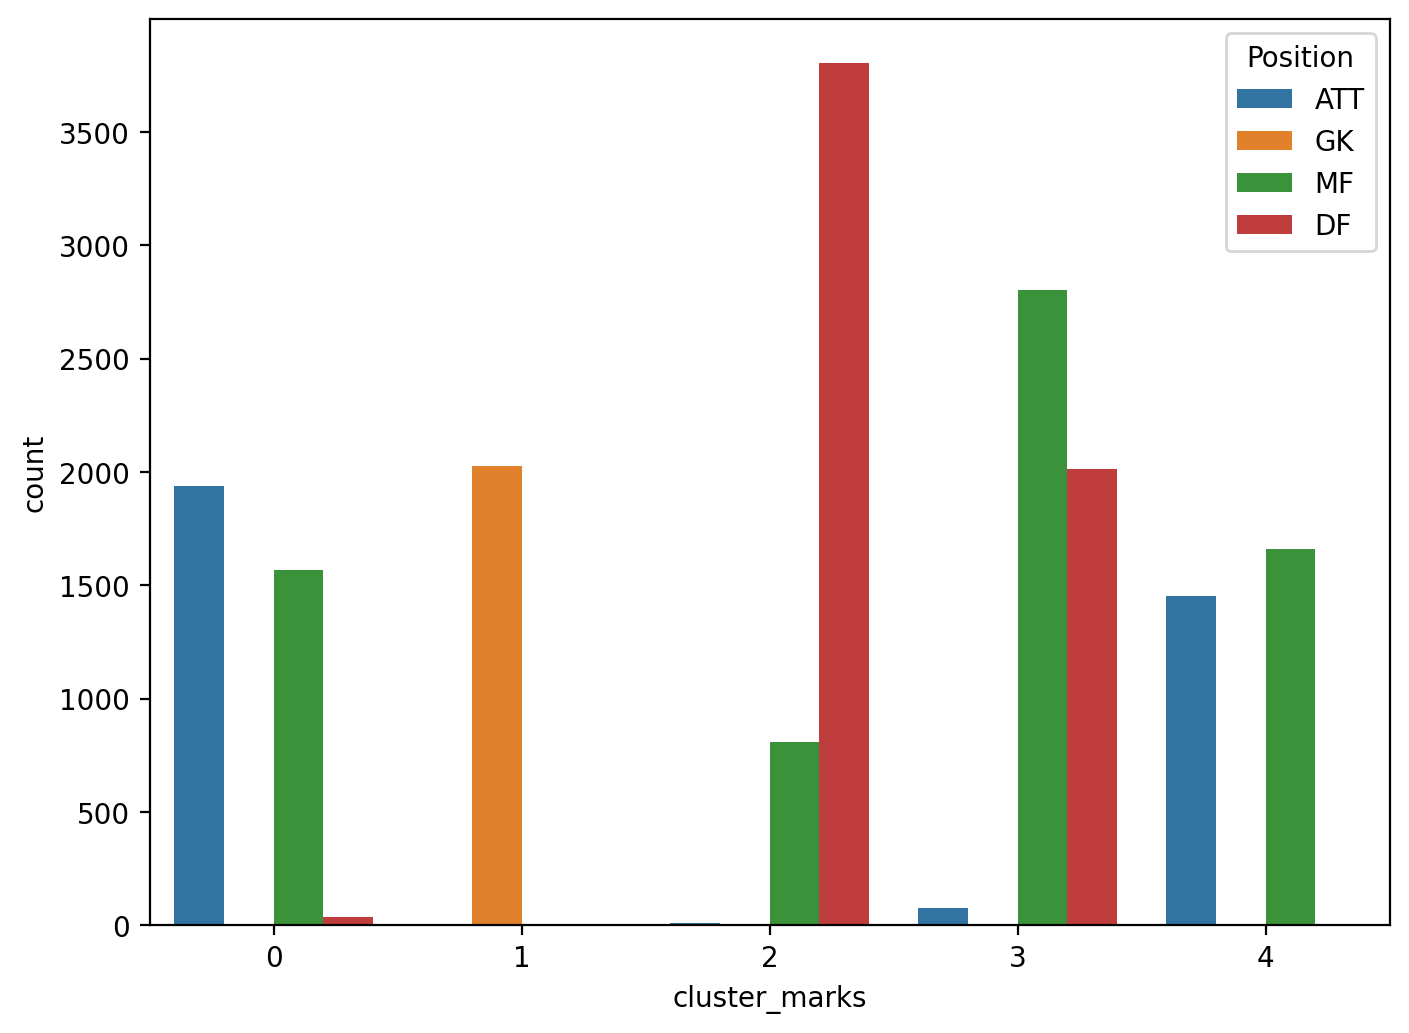

In [292]:
draw(df)

Nakon promene vrednosti parametara (**GKDiving**, **GKHandling**, **GKKicking**, **GKPositioning**, **GKReflexes**, **Special**, **Finishing**, **HeadingAccuracy**, **ShotPower**) na median vrednosti odgovarajuceg atributa, igrac sa vrednoscu ID=193911 svrstan je u klaster 0

In [291]:
# cluster_marks

print('Nakon zamena vrednosti, igrac je svrstan u klaster:', df.loc[df['ID'] == 193911]['cluster_marks'].values[0])

Nakon zamena vrednosti igrac je svrstan u klaster: 0
